In [1]:
# ''' S.M.Ali Mousavi
# last saved at 2020-05-19 20:19:04 '''

# Legend:
#     HC : Helper Class
#     HF : Helper Function

In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import lightgbm as lgb

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [2]:
import import_ipynb
import matplotlib.pyplot as plt
import LevelsCreater as lc
from sklearn.metrics import mean_absolute_error as MAE
from functions import mean_absolute_percentage_error, RMSSE, test_stationarity
from numpy import linalg as LA
from exovar import exovar
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error as MAE 

# HF: Seeding

In [16]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

# LGBM Model Hyper Parameters setting

In [17]:
########################### Model params
#################################################################################
### https://lightgbm.readthedocs.io/en/latest/Parameters.html ###
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons

# Setting global variables

In [18]:
########################### Vars
#################################################################################
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 12                 # Prediction horizon #vtM5crew 12days #DarkMagic=28days
USE_AUX     = True               # Use or not pretrained models

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
Absolute = '' # 'G://My Drive/Machine Learning/Kaggle Projects/M5/m5vtmechcrew/'
Cache    = 'Cache/'
ORIGINAL = 'Data/'
SALES    = 'sales_train_validation.csv'
Calendar = 'calendar.csv' # calendar csv from kaggle
BASE     = Absolute+'m5-simple-fe/grid_part_1.pkl'
PRICE    = Absolute+'m5-simple-fe/grid_part_2.pkl'
CALENDAR = Absolute+'m5-simple-fe/grid_part_3.pkl'  # calendar csv edited
LAGS     = 'm5-lags-features/lags_df_28.pkl'
MEAN_ENC = 'm5-custom-features/mean_encoding_df.pkl'


# AUX(pretrained) Models paths
AUX_MODELS = '../input/m5-aux-models/'


#STORES ids
STORES_IDS = pd.read_csv(Absolute+ORIGINAL+SALES)['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

# HC: Level Creator

In [19]:
class LevelsCreator:
    def __init__(self):
        pass
    
    def level_11(self,sales_data):
        df = sales_data.groupby(['item_id', 'state_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_10(self,sales_data):
        df= sales_data.groupby(['item_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_9(self,sales_data):
        df= sales_data.groupby(['store_id', 'dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_8(self,sales_data):
        df= sales_data.groupby(['store_id', 'cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_7(self,sales_data):
        df= sales_data.groupby(['state_id', 'dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_6(self,sales_data):
        df= sales_data.groupby(['state_id', 'cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_5(self,sales_data):
        df= sales_data.groupby(['dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_4(self,sales_data):
        df= sales_data.groupby(['cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_3(self,sales_data):
        df= sales_data.groupby(['store_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_2(self,sales_data):
        df= sales_data.groupby(['state_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_1(self,sales_data):
        df= (pd.DataFrame(self.level_2(sales_data).sum())).transpose()
        return df        

# HF: Loading data

In [20]:
# import LevelsCreater as lc

# SALES='sales_train_validation.csv'
sale=pd.read_csv(Absolute+ORIGINAL+SALES); sale.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [21]:
# levels = LevelsCreator()
# level3 = levels.level_3(sale); level3.head()

In [22]:
# t = level3.loc[['CA_1']].T.rename_axis('days', axis=1); tt=t.shift(2); t.head()

# HF: Categorical_to_sparse 
(Calendar exogenic variables to Sparse)

In [23]:
def categorical_to_sparse(calendar_data,node=1):
    CAL_DTYPES = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category",
                  "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
                  "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32',
                  'snap_WI': 'float32'}
    for col_name, col_fit in CAL_DTYPES.items():
        if col_name in calendar_data.columns:
            calendar_data[col_name] = calendar_data[col_name].astype(col_fit)

    for col_name, col_fit in CAL_DTYPES.items():
        if col_fit == 'category':
            calendar_data[col_name] = calendar_data[col_name].cat.codes.astype('int16')
            calendar_data[col_name] -= calendar_data[col_name].min()
    return calendar_data

# HF: series_to_supervised

In [24]:
# series_to_supervised(LevelsCreator().level_3(sale), n_in=3)

In [25]:
# # draft
# LevelsCreator().level_3(sale)

In [26]:
# # draft
# data2 = lc.LevelsCreater().get_level(sale,level=3); data2.head()

In [27]:
# # draft
# data =LevelsCreator().level_6(sale); data.head()

In [28]:
# # draft
# series_to_supervised_l3(data2, node=2, n_in=3, n_out=2, exo=True, dropnan=False)

In [29]:
def series_to_supervised_l3(data, node='CA_1', n_in=1, n_out=1, exo=False, dropnan=False):

    n_vars = 1 if type(data) is list else data.shape[1]
    data_shifted=pd.DataFrame()
    names=list()
    # Selecting a store of interest, 
    # Transposing the days from being column to being the index
    data=data.iloc[[node]].T
    
    # looping over the lag window(n_in) and making a new column
    for i in range(n_in, 0, -1):
        df=pd.DataFrame() #is this step necessary ?
        col_shifted=data.shift(i)
        col_shifted.columns=[f'{node}_t-{i}']
        data_shifted = pd.concat([data_shifted,col_shifted], axis=1, sort=False)

#     data_shifted.columns=col_names
    
    for i in range(0, n_out):
        df=pd.DataFrame()
        names=list()
        df=data.shift(-i)
#         if i == 0:
        names =[f'{node}_t_out-{i}'] #[('%s(t)' % (data.columns[j])) for j in range(n_vars)]
#         else:
#             names = [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
            
        df.columns=names
        data_shifted=pd.concat([data_shifted,df],axis=1,sort=False)
    

        
   # exogenic/categorical variables
    if exo==True:        
        calendar_data = pd.read_csv(ORIGINAL+Calendar) # reading the kaggle Calendar.csv file
        calendar_data =categorical_to_sparse(calendar_data,node=node) # encode the categorial variables in Calendar file
        data_shifted = data_shifted.merge(calendar_data, left_index=True, right_on='d') # index in data_shifted is same format as "d" column in Calendar, format: d_1*
        data_shifted = data_shifted.drop(['d', 'date'], axis=1) #dropping column 'd' and column 'date'
        
    # dropping the Nans if dropnan=True
    if dropnan:
        data_shifted.dropna(inplace=True)
        
  
    #reseting index from d_1...d_1913 to o...1912
    data_shifted.reset_index(drop=True, inplace=True)   
    # Renaming the index column from store_id to days
    data_shifted.rename_axis('days', axis=1, inplace=True) 
    
    return data_shifted

# HF: Train_test split  & LGB train_test DataSet builder

In [30]:
def train_validate_splitter_l3(data, node='CA_1', n_in=2, n_out=1, exo=False, dropnan=False):
    # making supervised data
    Supervised_data = series_to_supervised_l3(data, node=node,n_in=n_in, n_out=n_out, exo=exo, dropnan=dropnan)
    nan_mask = Supervised_data.isna().any(axis=1)
#     Target_data = data.iloc[[node]].T.reset_index(drop=True)
    Feature_data = Supervised_data[Supervised_data.columns[:n_in]]
    Target_data = Supervised_data[Supervised_data.columns[-n_out:]]
    
    #dropping rows that has one or more nan features 
    Feature_data = Feature_data[~nan_mask]
    Target_data = Target_data[~nan_mask]
#     END_TRAIN = END_TRAIN-len(nan_mask) Not#?? sure why it gives error if we redefine the END_TRAIN here

    # Train (All data less than 1913)
    # "Validation" (Last 12 days - not real validation set)
    X_train = Feature_data.iloc[:END_TRAIN-len(nan_mask)-P_HORIZON]
    X_validate = Feature_data.iloc[END_TRAIN-len(nan_mask)-P_HORIZON:]
    y_train = Target_data.iloc[:END_TRAIN-len(nan_mask)-P_HORIZON]
    y_validat = Target_data.iloc[END_TRAIN-len(nan_mask)-P_HORIZON:]
    
    return X_train, X_validate, y_train, y_validat

# LGB library needs inputs in specific format of train_test dataset
# dataset includes in it X or features and y or label
def lgb_train_validate_set_builder(X_train, X_validate, y_train, y_validat):
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_validate, label=y_validat)
    return train_data, valid_data

# Training Predict Plot `MAE`

In [31]:
from sklearn.metrics import mean_absolute_error as MAE

In [32]:
# #draft
# C=[]
# A = [1,1,1]
# B = [2,2,2]
# C.append(A)
# print(C)
# C.append(B)
# print(C)
# np.sum(C,axis=0)

In [41]:
## for purpose of review the LGBM hyperparameters is copied from the section "LGBM Model Hyper Parameters setting"
# lgb_params = {
#                     'boosting_type': 'gbdt',
#                     'objective': 'tweedie',
#                     'tweedie_variance_power': 1.1,
#                     'metric': 'rmse',
#                     'subsample': 0.5,
#                     'subsample_freq': 1,
#                     'learning_rate': 0.03,
#                     'num_leaves': 2**11-1,
#                     'min_data_in_leaf': 2**12-1,
#                     'feature_fraction': 0.5,
#                     'max_bin': 100,
#                     'n_estimators': 1400,
#                     'boost_from_average': False,
#                     'verbose': -1,
#                 } 

def model_LGBM(level=1,exo=False,node=0,normalized=False,n_in=3,n_out=1, lgb_params= lgb_params, decomposition=False):

    error_MAE =[]
    error_MAP =[]
    # make the level data frame 
    levels = lc.LevelsCreater()
    data_level = levels.get_level(sale,level=level);

    lag_range = range(1,n_in)
    
    def LGBM_(data, lag):
            X_train, X_validate, y_train, y_validat= \
            train_validate_splitter_l3(data_level, node=node, n_in=lag,n_out=n_out, exo=exo, dropnan=False)

            train_data, valid_data = lgb_train_validate_set_builder(
                                         X_train, X_validate, y_train, y_validat
                                          )

            # Launch seeder again to make lgb training 100% deterministic
            # with each "code line" np.random "evolves" 
            # so we need (may want) to "reset" it
            seed_everything(SEED)
            estimator = lgb.train(lgb_params,
                                  train_data,
                                  valid_sets = [valid_data],
                                  verbose_eval = 1
                                  )

            # Save model - it's not real '.bin' but a pickle file
            # estimator = lgb.Booster(model_file='model.txt')
            # can only predict with the best iteration (or the saving iteration)
            # pickle.dump gives us more flexibility
            # like estimator.predict(TEST, num_iteration=100)
            # num_iteration - number of iteration want to predict with, 
            # NULL or <= 0 means use best iteration

            model_name = 'lgb_model_'+'node'+str(node)+'_v'+str(VER)+'.bin' #just saves last trained model
            # pickling the trained models
            if not os.path.exists(Absolute+Cache):
                os.mkdir(Absolute+Cache)
            pickle.dump(estimator, open(Absolute+Cache+model_name, 'wb'))

            # in-sample prediction
            y_predict = estimator.predict(X_train)
            print(MAE(y_train, y_predict))
            
            return y_train, y_predict
        
    if decomposition==False:
        for lag in lag_range:
            print(lag)
            y_train, y_predict = LGBM_(data_level, lag)
            # adding each iteration error to a list of errors
            error_MAE.append(MAE(y_train, y_predict))
            error_MAP.append(mean_absolute_percentage_error(y_predict,y_train))

    if decomposition==True:
        decomposed=seasonal_decompose(data_level.values, model='additive',period=1)
        decomposed=[decomposed.resid,decomposed.seasonal,decomposed.trend]

        for lag in lag_range:
            print(lag)
            
            y_train_ = [] #pd.DataFrame()
            y_predict_ = []# pd.DataFrame()
            for composition in decomposed:
                print('dealing with decompositioin')
                dff=pd.DataFrame(composition)
                y_train_composition, y_predict_composition = LGBM_(composition, lag)
#                 print(np.shape(y_train_composition))
#                 print(y_train_composition.values)
                y_train_.append(y_train_composition.values) # y_train_ is a list of list, each element is y_train_composition
                y_predict_.append(y_predict_composition)
#             print([np.shape(element) for element in y_train_])

            # adding all the predictions from each composition
            y_train = np.sum(y_train_, axis=0) 
            y_predict = np.sum(y_predict_, axis=0)
            # adding each iteration error to a list of errors
            error_MAE.append(MAE(y_train, y_predict))
            error_MAP.append(mean_absolute_percentage_error(y_predict,y_train))
        
        #below is to feed the RMSEE function fix this later
#         Target_data = data_level.iloc[[node]].T.reset_index(drop=True)
        df = levels.get_level(sale,level=level)
        df = df.transpose()
        df = pd.DataFrame(df[df.columns[node]])
        print(y_predict.shape)
        print(y_train.shape)
        print(df.shape)

    return error_MAP,LA.norm(y_predict-y_train,2),RMSSE(y_predict,y_train,df.values) #

In [42]:
error_MAP, RMSE,RMSSE  = model_LGBM(level=6,node=0,exo=True,normalized=False,n_in=40,n_out=1, lgb_params= lgb_params, decomposition=True)

1
dealing with decompositioin
[1]	valid_0's rmse: 0.377075
[2]	valid_0's rmse: 0.377075
[3]	valid_0's rmse: 0.377075
[4]	valid_0's rmse: 0.377075
[5]	valid_0's rmse: 0.377075
[6]	valid_0's rmse: 0.377075
[7]	valid_0's rmse: 0.377075
[8]	valid_0's rmse: 0.377075
[9]	valid_0's rmse: 0.377075
[10]	valid_0's rmse: 0.377075
[11]	valid_0's rmse: 0.377075
[12]	valid_0's rmse: 0.377075
[13]	valid_0's rmse: 0.377075
[14]	valid_0's rmse: 0.377075
[15]	valid_0's rmse: 0.377075
[16]	valid_0's rmse: 0.377075
[17]	valid_0's rmse: 0.377075
[18]	valid_0's rmse: 0.377075
[19]	valid_0's rmse: 0.377075
[20]	valid_0's rmse: 0.377075
[21]	valid_0's rmse: 0.377075
[22]	valid_0's rmse: 0.377075
[23]	valid_0's rmse: 0.377075
[24]	valid_0's rmse: 0.377075
[25]	valid_0's rmse: 0.377075
[26]	valid_0's rmse: 0.377075
[27]	valid_0's rmse: 0.377075
[28]	valid_0's rmse: 0.377075
[29]	valid_0's rmse: 0.377075
[30]	valid_0's rmse: 0.377075
[31]	valid_0's rmse: 0.377075
[32]	valid_0's rmse: 0.377075
[33]	valid_0's rmse

[539]	valid_0's rmse: 0.377075
[540]	valid_0's rmse: 0.377075
[541]	valid_0's rmse: 0.377075
[542]	valid_0's rmse: 0.377075
[543]	valid_0's rmse: 0.377075
[544]	valid_0's rmse: 0.377075
[545]	valid_0's rmse: 0.377075
[546]	valid_0's rmse: 0.377075
[547]	valid_0's rmse: 0.377075
[548]	valid_0's rmse: 0.377075
[549]	valid_0's rmse: 0.377075
[550]	valid_0's rmse: 0.377075
[551]	valid_0's rmse: 0.377075
[552]	valid_0's rmse: 0.377075
[553]	valid_0's rmse: 0.377075
[554]	valid_0's rmse: 0.377075
[555]	valid_0's rmse: 0.377075
[556]	valid_0's rmse: 0.377075
[557]	valid_0's rmse: 0.377075
[558]	valid_0's rmse: 0.377075
[559]	valid_0's rmse: 0.377075
[560]	valid_0's rmse: 0.377075
[561]	valid_0's rmse: 0.377075
[562]	valid_0's rmse: 0.377075
[563]	valid_0's rmse: 0.377075
[564]	valid_0's rmse: 0.377075
[565]	valid_0's rmse: 0.377075
[566]	valid_0's rmse: 0.377075
[567]	valid_0's rmse: 0.377075
[568]	valid_0's rmse: 0.377075
[569]	valid_0's rmse: 0.377075
[570]	valid_0's rmse: 0.377075
[571]	va

[1129]	valid_0's rmse: 0.377075
[1130]	valid_0's rmse: 0.377075
[1131]	valid_0's rmse: 0.377075
[1132]	valid_0's rmse: 0.377075
[1133]	valid_0's rmse: 0.377075
[1134]	valid_0's rmse: 0.377075
[1135]	valid_0's rmse: 0.377075
[1136]	valid_0's rmse: 0.377075
[1137]	valid_0's rmse: 0.377075
[1138]	valid_0's rmse: 0.377075
[1139]	valid_0's rmse: 0.377075
[1140]	valid_0's rmse: 0.377075
[1141]	valid_0's rmse: 0.377075
[1142]	valid_0's rmse: 0.377075
[1143]	valid_0's rmse: 0.377075
[1144]	valid_0's rmse: 0.377075
[1145]	valid_0's rmse: 0.377075
[1146]	valid_0's rmse: 0.377075
[1147]	valid_0's rmse: 0.377075
[1148]	valid_0's rmse: 0.377075
[1149]	valid_0's rmse: 0.377075
[1150]	valid_0's rmse: 0.377075
[1151]	valid_0's rmse: 0.377075
[1152]	valid_0's rmse: 0.377075
[1153]	valid_0's rmse: 0.377075
[1154]	valid_0's rmse: 0.377075
[1155]	valid_0's rmse: 0.377075
[1156]	valid_0's rmse: 0.377075
[1157]	valid_0's rmse: 0.377075
[1158]	valid_0's rmse: 0.377075
[1159]	valid_0's rmse: 0.377075
[1160]	v

[172]	valid_0's rmse: 0.377075
[173]	valid_0's rmse: 0.377075
[174]	valid_0's rmse: 0.377075
[175]	valid_0's rmse: 0.377075
[176]	valid_0's rmse: 0.377075
[177]	valid_0's rmse: 0.377075
[178]	valid_0's rmse: 0.377075
[179]	valid_0's rmse: 0.377075
[180]	valid_0's rmse: 0.377075
[181]	valid_0's rmse: 0.377075
[182]	valid_0's rmse: 0.377075
[183]	valid_0's rmse: 0.377075
[184]	valid_0's rmse: 0.377075
[185]	valid_0's rmse: 0.377075
[186]	valid_0's rmse: 0.377075
[187]	valid_0's rmse: 0.377075
[188]	valid_0's rmse: 0.377075
[189]	valid_0's rmse: 0.377075
[190]	valid_0's rmse: 0.377075
[191]	valid_0's rmse: 0.377075
[192]	valid_0's rmse: 0.377075
[193]	valid_0's rmse: 0.377075
[194]	valid_0's rmse: 0.377075
[195]	valid_0's rmse: 0.377075
[196]	valid_0's rmse: 0.377075
[197]	valid_0's rmse: 0.377075
[198]	valid_0's rmse: 0.377075
[199]	valid_0's rmse: 0.377075
[200]	valid_0's rmse: 0.377075
[201]	valid_0's rmse: 0.377075
[202]	valid_0's rmse: 0.377075
[203]	valid_0's rmse: 0.377075
[204]	va

[783]	valid_0's rmse: 0.377075
[784]	valid_0's rmse: 0.377075
[785]	valid_0's rmse: 0.377075
[786]	valid_0's rmse: 0.377075
[787]	valid_0's rmse: 0.377075
[788]	valid_0's rmse: 0.377075
[789]	valid_0's rmse: 0.377075
[790]	valid_0's rmse: 0.377075
[791]	valid_0's rmse: 0.377075
[792]	valid_0's rmse: 0.377075
[793]	valid_0's rmse: 0.377075
[794]	valid_0's rmse: 0.377075
[795]	valid_0's rmse: 0.377075
[796]	valid_0's rmse: 0.377075
[797]	valid_0's rmse: 0.377075
[798]	valid_0's rmse: 0.377075
[799]	valid_0's rmse: 0.377075
[800]	valid_0's rmse: 0.377075
[801]	valid_0's rmse: 0.377075
[802]	valid_0's rmse: 0.377075
[803]	valid_0's rmse: 0.377075
[804]	valid_0's rmse: 0.377075
[805]	valid_0's rmse: 0.377075
[806]	valid_0's rmse: 0.377075
[807]	valid_0's rmse: 0.377075
[808]	valid_0's rmse: 0.377075
[809]	valid_0's rmse: 0.377075
[810]	valid_0's rmse: 0.377075
[811]	valid_0's rmse: 0.377075
[812]	valid_0's rmse: 0.377075
[813]	valid_0's rmse: 0.377075
[814]	valid_0's rmse: 0.377075
[815]	va

[1331]	valid_0's rmse: 0.377075
[1332]	valid_0's rmse: 0.377075
[1333]	valid_0's rmse: 0.377075
[1334]	valid_0's rmse: 0.377075
[1335]	valid_0's rmse: 0.377075
[1336]	valid_0's rmse: 0.377075
[1337]	valid_0's rmse: 0.377075
[1338]	valid_0's rmse: 0.377075
[1339]	valid_0's rmse: 0.377075
[1340]	valid_0's rmse: 0.377075
[1341]	valid_0's rmse: 0.377075
[1342]	valid_0's rmse: 0.377075
[1343]	valid_0's rmse: 0.377075
[1344]	valid_0's rmse: 0.377075
[1345]	valid_0's rmse: 0.377075
[1346]	valid_0's rmse: 0.377075
[1347]	valid_0's rmse: 0.377075
[1348]	valid_0's rmse: 0.377075
[1349]	valid_0's rmse: 0.377075
[1350]	valid_0's rmse: 0.377075
[1351]	valid_0's rmse: 0.377075
[1352]	valid_0's rmse: 0.377075
[1353]	valid_0's rmse: 0.377075
[1354]	valid_0's rmse: 0.377075
[1355]	valid_0's rmse: 0.377075
[1356]	valid_0's rmse: 0.377075
[1357]	valid_0's rmse: 0.377075
[1358]	valid_0's rmse: 0.377075
[1359]	valid_0's rmse: 0.377075
[1360]	valid_0's rmse: 0.377075
[1361]	valid_0's rmse: 0.377075
[1362]	v

[388]	valid_0's rmse: 0.377075
[389]	valid_0's rmse: 0.377075
[390]	valid_0's rmse: 0.377075
[391]	valid_0's rmse: 0.377075
[392]	valid_0's rmse: 0.377075
[393]	valid_0's rmse: 0.377075
[394]	valid_0's rmse: 0.377075
[395]	valid_0's rmse: 0.377075
[396]	valid_0's rmse: 0.377075
[397]	valid_0's rmse: 0.377075
[398]	valid_0's rmse: 0.377075
[399]	valid_0's rmse: 0.377075
[400]	valid_0's rmse: 0.377075
[401]	valid_0's rmse: 0.377075
[402]	valid_0's rmse: 0.377075
[403]	valid_0's rmse: 0.377075
[404]	valid_0's rmse: 0.377075
[405]	valid_0's rmse: 0.377075
[406]	valid_0's rmse: 0.377075
[407]	valid_0's rmse: 0.377075
[408]	valid_0's rmse: 0.377075
[409]	valid_0's rmse: 0.377075
[410]	valid_0's rmse: 0.377075
[411]	valid_0's rmse: 0.377075
[412]	valid_0's rmse: 0.377075
[413]	valid_0's rmse: 0.377075
[414]	valid_0's rmse: 0.377075
[415]	valid_0's rmse: 0.377075
[416]	valid_0's rmse: 0.377075
[417]	valid_0's rmse: 0.377075
[418]	valid_0's rmse: 0.377075
[419]	valid_0's rmse: 0.377075
[420]	va

[981]	valid_0's rmse: 0.377075
[982]	valid_0's rmse: 0.377075
[983]	valid_0's rmse: 0.377075
[984]	valid_0's rmse: 0.377075
[985]	valid_0's rmse: 0.377075
[986]	valid_0's rmse: 0.377075
[987]	valid_0's rmse: 0.377075
[988]	valid_0's rmse: 0.377075
[989]	valid_0's rmse: 0.377075
[990]	valid_0's rmse: 0.377075
[991]	valid_0's rmse: 0.377075
[992]	valid_0's rmse: 0.377075
[993]	valid_0's rmse: 0.377075
[994]	valid_0's rmse: 0.377075
[995]	valid_0's rmse: 0.377075
[996]	valid_0's rmse: 0.377075
[997]	valid_0's rmse: 0.377075
[998]	valid_0's rmse: 0.377075
[999]	valid_0's rmse: 0.377075
[1000]	valid_0's rmse: 0.377075
[1001]	valid_0's rmse: 0.377075
[1002]	valid_0's rmse: 0.377075
[1003]	valid_0's rmse: 0.377075
[1004]	valid_0's rmse: 0.377075
[1005]	valid_0's rmse: 0.377075
[1006]	valid_0's rmse: 0.377075
[1007]	valid_0's rmse: 0.377075
[1008]	valid_0's rmse: 0.377075
[1009]	valid_0's rmse: 0.377075
[1010]	valid_0's rmse: 0.377075
[1011]	valid_0's rmse: 0.377075
[1012]	valid_0's rmse: 0.37

[1]	valid_0's rmse: 0.377058
[2]	valid_0's rmse: 0.377058
[3]	valid_0's rmse: 0.377058
[4]	valid_0's rmse: 0.377058
[5]	valid_0's rmse: 0.377058
[6]	valid_0's rmse: 0.377058
[7]	valid_0's rmse: 0.377058
[8]	valid_0's rmse: 0.377058
[9]	valid_0's rmse: 0.377058
[10]	valid_0's rmse: 0.377058
[11]	valid_0's rmse: 0.377058
[12]	valid_0's rmse: 0.377058
[13]	valid_0's rmse: 0.377058
[14]	valid_0's rmse: 0.377058
[15]	valid_0's rmse: 0.377058
[16]	valid_0's rmse: 0.377058
[17]	valid_0's rmse: 0.377058
[18]	valid_0's rmse: 0.377058
[19]	valid_0's rmse: 0.377058
[20]	valid_0's rmse: 0.377058
[21]	valid_0's rmse: 0.377058
[22]	valid_0's rmse: 0.377058
[23]	valid_0's rmse: 0.377058
[24]	valid_0's rmse: 0.377058
[25]	valid_0's rmse: 0.377058
[26]	valid_0's rmse: 0.377058
[27]	valid_0's rmse: 0.377058
[28]	valid_0's rmse: 0.377058
[29]	valid_0's rmse: 0.377058
[30]	valid_0's rmse: 0.377058
[31]	valid_0's rmse: 0.377058
[32]	valid_0's rmse: 0.377058
[33]	valid_0's rmse: 0.377058
[34]	valid_0's rmse

[609]	valid_0's rmse: 0.377058
[610]	valid_0's rmse: 0.377058
[611]	valid_0's rmse: 0.377058
[612]	valid_0's rmse: 0.377058
[613]	valid_0's rmse: 0.377058
[614]	valid_0's rmse: 0.377058
[615]	valid_0's rmse: 0.377058
[616]	valid_0's rmse: 0.377058
[617]	valid_0's rmse: 0.377058
[618]	valid_0's rmse: 0.377058
[619]	valid_0's rmse: 0.377058
[620]	valid_0's rmse: 0.377058
[621]	valid_0's rmse: 0.377058
[622]	valid_0's rmse: 0.377058
[623]	valid_0's rmse: 0.377058
[624]	valid_0's rmse: 0.377058
[625]	valid_0's rmse: 0.377058
[626]	valid_0's rmse: 0.377058
[627]	valid_0's rmse: 0.377058
[628]	valid_0's rmse: 0.377058
[629]	valid_0's rmse: 0.377058
[630]	valid_0's rmse: 0.377058
[631]	valid_0's rmse: 0.377058
[632]	valid_0's rmse: 0.377058
[633]	valid_0's rmse: 0.377058
[634]	valid_0's rmse: 0.377058
[635]	valid_0's rmse: 0.377058
[636]	valid_0's rmse: 0.377058
[637]	valid_0's rmse: 0.377058
[638]	valid_0's rmse: 0.377058
[639]	valid_0's rmse: 0.377058
[640]	valid_0's rmse: 0.377058
[641]	va

[1249]	valid_0's rmse: 0.377058
[1250]	valid_0's rmse: 0.377058
[1251]	valid_0's rmse: 0.377058
[1252]	valid_0's rmse: 0.377058
[1253]	valid_0's rmse: 0.377058
[1254]	valid_0's rmse: 0.377058
[1255]	valid_0's rmse: 0.377058
[1256]	valid_0's rmse: 0.377058
[1257]	valid_0's rmse: 0.377058
[1258]	valid_0's rmse: 0.377058
[1259]	valid_0's rmse: 0.377058
[1260]	valid_0's rmse: 0.377058
[1261]	valid_0's rmse: 0.377058
[1262]	valid_0's rmse: 0.377058
[1263]	valid_0's rmse: 0.377058
[1264]	valid_0's rmse: 0.377058
[1265]	valid_0's rmse: 0.377058
[1266]	valid_0's rmse: 0.377058
[1267]	valid_0's rmse: 0.377058
[1268]	valid_0's rmse: 0.377058
[1269]	valid_0's rmse: 0.377058
[1270]	valid_0's rmse: 0.377058
[1271]	valid_0's rmse: 0.377058
[1272]	valid_0's rmse: 0.377058
[1273]	valid_0's rmse: 0.377058
[1274]	valid_0's rmse: 0.377058
[1275]	valid_0's rmse: 0.377058
[1276]	valid_0's rmse: 0.377058
[1277]	valid_0's rmse: 0.377058
[1278]	valid_0's rmse: 0.377058
[1279]	valid_0's rmse: 0.377058
[1280]	v

[277]	valid_0's rmse: 0.377058
[278]	valid_0's rmse: 0.377058
[279]	valid_0's rmse: 0.377058
[280]	valid_0's rmse: 0.377058
[281]	valid_0's rmse: 0.377058
[282]	valid_0's rmse: 0.377058
[283]	valid_0's rmse: 0.377058
[284]	valid_0's rmse: 0.377058
[285]	valid_0's rmse: 0.377058
[286]	valid_0's rmse: 0.377058
[287]	valid_0's rmse: 0.377058
[288]	valid_0's rmse: 0.377058
[289]	valid_0's rmse: 0.377058
[290]	valid_0's rmse: 0.377058
[291]	valid_0's rmse: 0.377058
[292]	valid_0's rmse: 0.377058
[293]	valid_0's rmse: 0.377058
[294]	valid_0's rmse: 0.377058
[295]	valid_0's rmse: 0.377058
[296]	valid_0's rmse: 0.377058
[297]	valid_0's rmse: 0.377058
[298]	valid_0's rmse: 0.377058
[299]	valid_0's rmse: 0.377058
[300]	valid_0's rmse: 0.377058
[301]	valid_0's rmse: 0.377058
[302]	valid_0's rmse: 0.377058
[303]	valid_0's rmse: 0.377058
[304]	valid_0's rmse: 0.377058
[305]	valid_0's rmse: 0.377058
[306]	valid_0's rmse: 0.377058
[307]	valid_0's rmse: 0.377058
[308]	valid_0's rmse: 0.377058
[309]	va

[851]	valid_0's rmse: 0.377058
[852]	valid_0's rmse: 0.377058
[853]	valid_0's rmse: 0.377058
[854]	valid_0's rmse: 0.377058
[855]	valid_0's rmse: 0.377058
[856]	valid_0's rmse: 0.377058
[857]	valid_0's rmse: 0.377058
[858]	valid_0's rmse: 0.377058
[859]	valid_0's rmse: 0.377058
[860]	valid_0's rmse: 0.377058
[861]	valid_0's rmse: 0.377058
[862]	valid_0's rmse: 0.377058
[863]	valid_0's rmse: 0.377058
[864]	valid_0's rmse: 0.377058
[865]	valid_0's rmse: 0.377058
[866]	valid_0's rmse: 0.377058
[867]	valid_0's rmse: 0.377058
[868]	valid_0's rmse: 0.377058
[869]	valid_0's rmse: 0.377058
[870]	valid_0's rmse: 0.377058
[871]	valid_0's rmse: 0.377058
[872]	valid_0's rmse: 0.377058
[873]	valid_0's rmse: 0.377058
[874]	valid_0's rmse: 0.377058
[875]	valid_0's rmse: 0.377058
[876]	valid_0's rmse: 0.377058
[877]	valid_0's rmse: 0.377058
[878]	valid_0's rmse: 0.377058
[879]	valid_0's rmse: 0.377058
[880]	valid_0's rmse: 0.377058
[881]	valid_0's rmse: 0.377058
[882]	valid_0's rmse: 0.377058
[883]	va

[1]	valid_0's rmse: 0.377058
[2]	valid_0's rmse: 0.377058
[3]	valid_0's rmse: 0.377058
[4]	valid_0's rmse: 0.377058
[5]	valid_0's rmse: 0.377058
[6]	valid_0's rmse: 0.377058
[7]	valid_0's rmse: 0.377058
[8]	valid_0's rmse: 0.377058
[9]	valid_0's rmse: 0.377058
[10]	valid_0's rmse: 0.377058
[11]	valid_0's rmse: 0.377058
[12]	valid_0's rmse: 0.377058
[13]	valid_0's rmse: 0.377058
[14]	valid_0's rmse: 0.377058
[15]	valid_0's rmse: 0.377058
[16]	valid_0's rmse: 0.377058
[17]	valid_0's rmse: 0.377058
[18]	valid_0's rmse: 0.377058
[19]	valid_0's rmse: 0.377058
[20]	valid_0's rmse: 0.377058
[21]	valid_0's rmse: 0.377058
[22]	valid_0's rmse: 0.377058
[23]	valid_0's rmse: 0.377058
[24]	valid_0's rmse: 0.377058
[25]	valid_0's rmse: 0.377058
[26]	valid_0's rmse: 0.377058
[27]	valid_0's rmse: 0.377058
[28]	valid_0's rmse: 0.377058
[29]	valid_0's rmse: 0.377058
[30]	valid_0's rmse: 0.377058
[31]	valid_0's rmse: 0.377058
[32]	valid_0's rmse: 0.377058
[33]	valid_0's rmse: 0.377058
[34]	valid_0's rmse

[594]	valid_0's rmse: 0.377058
[595]	valid_0's rmse: 0.377058
[596]	valid_0's rmse: 0.377058
[597]	valid_0's rmse: 0.377058
[598]	valid_0's rmse: 0.377058
[599]	valid_0's rmse: 0.377058
[600]	valid_0's rmse: 0.377058
[601]	valid_0's rmse: 0.377058
[602]	valid_0's rmse: 0.377058
[603]	valid_0's rmse: 0.377058
[604]	valid_0's rmse: 0.377058
[605]	valid_0's rmse: 0.377058
[606]	valid_0's rmse: 0.377058
[607]	valid_0's rmse: 0.377058
[608]	valid_0's rmse: 0.377058
[609]	valid_0's rmse: 0.377058
[610]	valid_0's rmse: 0.377058
[611]	valid_0's rmse: 0.377058
[612]	valid_0's rmse: 0.377058
[613]	valid_0's rmse: 0.377058
[614]	valid_0's rmse: 0.377058
[615]	valid_0's rmse: 0.377058
[616]	valid_0's rmse: 0.377058
[617]	valid_0's rmse: 0.377058
[618]	valid_0's rmse: 0.377058
[619]	valid_0's rmse: 0.377058
[620]	valid_0's rmse: 0.377058
[621]	valid_0's rmse: 0.377058
[622]	valid_0's rmse: 0.377058
[623]	valid_0's rmse: 0.377058
[624]	valid_0's rmse: 0.377058
[625]	valid_0's rmse: 0.377058
[626]	va

[1225]	valid_0's rmse: 0.377058
[1226]	valid_0's rmse: 0.377058
[1227]	valid_0's rmse: 0.377058
[1228]	valid_0's rmse: 0.377058
[1229]	valid_0's rmse: 0.377058
[1230]	valid_0's rmse: 0.377058
[1231]	valid_0's rmse: 0.377058
[1232]	valid_0's rmse: 0.377058
[1233]	valid_0's rmse: 0.377058
[1234]	valid_0's rmse: 0.377058
[1235]	valid_0's rmse: 0.377058
[1236]	valid_0's rmse: 0.377058
[1237]	valid_0's rmse: 0.377058
[1238]	valid_0's rmse: 0.377058
[1239]	valid_0's rmse: 0.377058
[1240]	valid_0's rmse: 0.377058
[1241]	valid_0's rmse: 0.377058
[1242]	valid_0's rmse: 0.377058
[1243]	valid_0's rmse: 0.377058
[1244]	valid_0's rmse: 0.377058
[1245]	valid_0's rmse: 0.377058
[1246]	valid_0's rmse: 0.377058
[1247]	valid_0's rmse: 0.377058
[1248]	valid_0's rmse: 0.377058
[1249]	valid_0's rmse: 0.377058
[1250]	valid_0's rmse: 0.377058
[1251]	valid_0's rmse: 0.377058
[1252]	valid_0's rmse: 0.377058
[1253]	valid_0's rmse: 0.377058
[1254]	valid_0's rmse: 0.377058
[1255]	valid_0's rmse: 0.377058
[1256]	v

[105]	valid_0's rmse: 0.37704
[106]	valid_0's rmse: 0.37704
[107]	valid_0's rmse: 0.37704
[108]	valid_0's rmse: 0.37704
[109]	valid_0's rmse: 0.37704
[110]	valid_0's rmse: 0.37704
[111]	valid_0's rmse: 0.37704
[112]	valid_0's rmse: 0.37704
[113]	valid_0's rmse: 0.37704
[114]	valid_0's rmse: 0.37704
[115]	valid_0's rmse: 0.37704
[116]	valid_0's rmse: 0.37704
[117]	valid_0's rmse: 0.37704
[118]	valid_0's rmse: 0.37704
[119]	valid_0's rmse: 0.37704
[120]	valid_0's rmse: 0.37704
[121]	valid_0's rmse: 0.37704
[122]	valid_0's rmse: 0.37704
[123]	valid_0's rmse: 0.37704
[124]	valid_0's rmse: 0.37704
[125]	valid_0's rmse: 0.37704
[126]	valid_0's rmse: 0.37704
[127]	valid_0's rmse: 0.37704
[128]	valid_0's rmse: 0.37704
[129]	valid_0's rmse: 0.37704
[130]	valid_0's rmse: 0.37704
[131]	valid_0's rmse: 0.37704
[132]	valid_0's rmse: 0.37704
[133]	valid_0's rmse: 0.37704
[134]	valid_0's rmse: 0.37704
[135]	valid_0's rmse: 0.37704
[136]	valid_0's rmse: 0.37704
[137]	valid_0's rmse: 0.37704
[138]	vali

[676]	valid_0's rmse: 0.37704
[677]	valid_0's rmse: 0.37704
[678]	valid_0's rmse: 0.37704
[679]	valid_0's rmse: 0.37704
[680]	valid_0's rmse: 0.37704
[681]	valid_0's rmse: 0.37704
[682]	valid_0's rmse: 0.37704
[683]	valid_0's rmse: 0.37704
[684]	valid_0's rmse: 0.37704
[685]	valid_0's rmse: 0.37704
[686]	valid_0's rmse: 0.37704
[687]	valid_0's rmse: 0.37704
[688]	valid_0's rmse: 0.37704
[689]	valid_0's rmse: 0.37704
[690]	valid_0's rmse: 0.37704
[691]	valid_0's rmse: 0.37704
[692]	valid_0's rmse: 0.37704
[693]	valid_0's rmse: 0.37704
[694]	valid_0's rmse: 0.37704
[695]	valid_0's rmse: 0.37704
[696]	valid_0's rmse: 0.37704
[697]	valid_0's rmse: 0.37704
[698]	valid_0's rmse: 0.37704
[699]	valid_0's rmse: 0.37704
[700]	valid_0's rmse: 0.37704
[701]	valid_0's rmse: 0.37704
[702]	valid_0's rmse: 0.37704
[703]	valid_0's rmse: 0.37704
[704]	valid_0's rmse: 0.37704
[705]	valid_0's rmse: 0.37704
[706]	valid_0's rmse: 0.37704
[707]	valid_0's rmse: 0.37704
[708]	valid_0's rmse: 0.37704
[709]	vali

[1291]	valid_0's rmse: 0.37704
[1292]	valid_0's rmse: 0.37704
[1293]	valid_0's rmse: 0.37704
[1294]	valid_0's rmse: 0.37704
[1295]	valid_0's rmse: 0.37704
[1296]	valid_0's rmse: 0.37704
[1297]	valid_0's rmse: 0.37704
[1298]	valid_0's rmse: 0.37704
[1299]	valid_0's rmse: 0.37704
[1300]	valid_0's rmse: 0.37704
[1301]	valid_0's rmse: 0.37704
[1302]	valid_0's rmse: 0.37704
[1303]	valid_0's rmse: 0.37704
[1304]	valid_0's rmse: 0.37704
[1305]	valid_0's rmse: 0.37704
[1306]	valid_0's rmse: 0.37704
[1307]	valid_0's rmse: 0.37704
[1308]	valid_0's rmse: 0.37704
[1309]	valid_0's rmse: 0.37704
[1310]	valid_0's rmse: 0.37704
[1311]	valid_0's rmse: 0.37704
[1312]	valid_0's rmse: 0.37704
[1313]	valid_0's rmse: 0.37704
[1314]	valid_0's rmse: 0.37704
[1315]	valid_0's rmse: 0.37704
[1316]	valid_0's rmse: 0.37704
[1317]	valid_0's rmse: 0.37704
[1318]	valid_0's rmse: 0.37704
[1319]	valid_0's rmse: 0.37704
[1320]	valid_0's rmse: 0.37704
[1321]	valid_0's rmse: 0.37704
[1322]	valid_0's rmse: 0.37704
[1323]	v

[301]	valid_0's rmse: 0.37704
[302]	valid_0's rmse: 0.37704
[303]	valid_0's rmse: 0.37704
[304]	valid_0's rmse: 0.37704
[305]	valid_0's rmse: 0.37704
[306]	valid_0's rmse: 0.37704
[307]	valid_0's rmse: 0.37704
[308]	valid_0's rmse: 0.37704
[309]	valid_0's rmse: 0.37704
[310]	valid_0's rmse: 0.37704
[311]	valid_0's rmse: 0.37704
[312]	valid_0's rmse: 0.37704
[313]	valid_0's rmse: 0.37704
[314]	valid_0's rmse: 0.37704
[315]	valid_0's rmse: 0.37704
[316]	valid_0's rmse: 0.37704
[317]	valid_0's rmse: 0.37704
[318]	valid_0's rmse: 0.37704
[319]	valid_0's rmse: 0.37704
[320]	valid_0's rmse: 0.37704
[321]	valid_0's rmse: 0.37704
[322]	valid_0's rmse: 0.37704
[323]	valid_0's rmse: 0.37704
[324]	valid_0's rmse: 0.37704
[325]	valid_0's rmse: 0.37704
[326]	valid_0's rmse: 0.37704
[327]	valid_0's rmse: 0.37704
[328]	valid_0's rmse: 0.37704
[329]	valid_0's rmse: 0.37704
[330]	valid_0's rmse: 0.37704
[331]	valid_0's rmse: 0.37704
[332]	valid_0's rmse: 0.37704
[333]	valid_0's rmse: 0.37704
[334]	vali

[913]	valid_0's rmse: 0.37704
[914]	valid_0's rmse: 0.37704
[915]	valid_0's rmse: 0.37704
[916]	valid_0's rmse: 0.37704
[917]	valid_0's rmse: 0.37704
[918]	valid_0's rmse: 0.37704
[919]	valid_0's rmse: 0.37704
[920]	valid_0's rmse: 0.37704
[921]	valid_0's rmse: 0.37704
[922]	valid_0's rmse: 0.37704
[923]	valid_0's rmse: 0.37704
[924]	valid_0's rmse: 0.37704
[925]	valid_0's rmse: 0.37704
[926]	valid_0's rmse: 0.37704
[927]	valid_0's rmse: 0.37704
[928]	valid_0's rmse: 0.37704
[929]	valid_0's rmse: 0.37704
[930]	valid_0's rmse: 0.37704
[931]	valid_0's rmse: 0.37704
[932]	valid_0's rmse: 0.37704
[933]	valid_0's rmse: 0.37704
[934]	valid_0's rmse: 0.37704
[935]	valid_0's rmse: 0.37704
[936]	valid_0's rmse: 0.37704
[937]	valid_0's rmse: 0.37704
[938]	valid_0's rmse: 0.37704
[939]	valid_0's rmse: 0.37704
[940]	valid_0's rmse: 0.37704
[941]	valid_0's rmse: 0.37704
[942]	valid_0's rmse: 0.37704
[943]	valid_0's rmse: 0.37704
[944]	valid_0's rmse: 0.37704
[945]	valid_0's rmse: 0.37704
[946]	vali

[1]	valid_0's rmse: 0.37704
[2]	valid_0's rmse: 0.37704
[3]	valid_0's rmse: 0.37704
[4]	valid_0's rmse: 0.37704
[5]	valid_0's rmse: 0.37704
[6]	valid_0's rmse: 0.37704
[7]	valid_0's rmse: 0.37704
[8]	valid_0's rmse: 0.37704
[9]	valid_0's rmse: 0.37704
[10]	valid_0's rmse: 0.37704
[11]	valid_0's rmse: 0.37704
[12]	valid_0's rmse: 0.37704
[13]	valid_0's rmse: 0.37704
[14]	valid_0's rmse: 0.37704
[15]	valid_0's rmse: 0.37704
[16]	valid_0's rmse: 0.37704
[17]	valid_0's rmse: 0.37704
[18]	valid_0's rmse: 0.37704
[19]	valid_0's rmse: 0.37704
[20]	valid_0's rmse: 0.37704
[21]	valid_0's rmse: 0.37704
[22]	valid_0's rmse: 0.37704
[23]	valid_0's rmse: 0.37704
[24]	valid_0's rmse: 0.37704
[25]	valid_0's rmse: 0.37704
[26]	valid_0's rmse: 0.37704
[27]	valid_0's rmse: 0.37704
[28]	valid_0's rmse: 0.37704
[29]	valid_0's rmse: 0.37704
[30]	valid_0's rmse: 0.37704
[31]	valid_0's rmse: 0.37704
[32]	valid_0's rmse: 0.37704
[33]	valid_0's rmse: 0.37704
[34]	valid_0's rmse: 0.37704
[35]	valid_0's rmse: 0.

[575]	valid_0's rmse: 0.37704
[576]	valid_0's rmse: 0.37704
[577]	valid_0's rmse: 0.37704
[578]	valid_0's rmse: 0.37704
[579]	valid_0's rmse: 0.37704
[580]	valid_0's rmse: 0.37704
[581]	valid_0's rmse: 0.37704
[582]	valid_0's rmse: 0.37704
[583]	valid_0's rmse: 0.37704
[584]	valid_0's rmse: 0.37704
[585]	valid_0's rmse: 0.37704
[586]	valid_0's rmse: 0.37704
[587]	valid_0's rmse: 0.37704
[588]	valid_0's rmse: 0.37704
[589]	valid_0's rmse: 0.37704
[590]	valid_0's rmse: 0.37704
[591]	valid_0's rmse: 0.37704
[592]	valid_0's rmse: 0.37704
[593]	valid_0's rmse: 0.37704
[594]	valid_0's rmse: 0.37704
[595]	valid_0's rmse: 0.37704
[596]	valid_0's rmse: 0.37704
[597]	valid_0's rmse: 0.37704
[598]	valid_0's rmse: 0.37704
[599]	valid_0's rmse: 0.37704
[600]	valid_0's rmse: 0.37704
[601]	valid_0's rmse: 0.37704
[602]	valid_0's rmse: 0.37704
[603]	valid_0's rmse: 0.37704
[604]	valid_0's rmse: 0.37704
[605]	valid_0's rmse: 0.37704
[606]	valid_0's rmse: 0.37704
[607]	valid_0's rmse: 0.37704
[608]	vali

[1130]	valid_0's rmse: 0.37704
[1131]	valid_0's rmse: 0.37704
[1132]	valid_0's rmse: 0.37704
[1133]	valid_0's rmse: 0.37704
[1134]	valid_0's rmse: 0.37704
[1135]	valid_0's rmse: 0.37704
[1136]	valid_0's rmse: 0.37704
[1137]	valid_0's rmse: 0.37704
[1138]	valid_0's rmse: 0.37704
[1139]	valid_0's rmse: 0.37704
[1140]	valid_0's rmse: 0.37704
[1141]	valid_0's rmse: 0.37704
[1142]	valid_0's rmse: 0.37704
[1143]	valid_0's rmse: 0.37704
[1144]	valid_0's rmse: 0.37704
[1145]	valid_0's rmse: 0.37704
[1146]	valid_0's rmse: 0.37704
[1147]	valid_0's rmse: 0.37704
[1148]	valid_0's rmse: 0.37704
[1149]	valid_0's rmse: 0.37704
[1150]	valid_0's rmse: 0.37704
[1151]	valid_0's rmse: 0.37704
[1152]	valid_0's rmse: 0.37704
[1153]	valid_0's rmse: 0.37704
[1154]	valid_0's rmse: 0.37704
[1155]	valid_0's rmse: 0.37704
[1156]	valid_0's rmse: 0.37704
[1157]	valid_0's rmse: 0.37704
[1158]	valid_0's rmse: 0.37704
[1159]	valid_0's rmse: 0.37704
[1160]	valid_0's rmse: 0.37704
[1161]	valid_0's rmse: 0.37704
[1162]	v

[4]	valid_0's rmse: 0.377023
[5]	valid_0's rmse: 0.377023
[6]	valid_0's rmse: 0.377023
[7]	valid_0's rmse: 0.377023
[8]	valid_0's rmse: 0.377023
[9]	valid_0's rmse: 0.377023
[10]	valid_0's rmse: 0.377023
[11]	valid_0's rmse: 0.377023
[12]	valid_0's rmse: 0.377023
[13]	valid_0's rmse: 0.377023
[14]	valid_0's rmse: 0.377023
[15]	valid_0's rmse: 0.377023
[16]	valid_0's rmse: 0.377023
[17]	valid_0's rmse: 0.377023
[18]	valid_0's rmse: 0.377023
[19]	valid_0's rmse: 0.377023
[20]	valid_0's rmse: 0.377023
[21]	valid_0's rmse: 0.377023
[22]	valid_0's rmse: 0.377023
[23]	valid_0's rmse: 0.377023
[24]	valid_0's rmse: 0.377023
[25]	valid_0's rmse: 0.377023
[26]	valid_0's rmse: 0.377023
[27]	valid_0's rmse: 0.377023
[28]	valid_0's rmse: 0.377023
[29]	valid_0's rmse: 0.377023
[30]	valid_0's rmse: 0.377023
[31]	valid_0's rmse: 0.377023
[32]	valid_0's rmse: 0.377023
[33]	valid_0's rmse: 0.377023
[34]	valid_0's rmse: 0.377023
[35]	valid_0's rmse: 0.377023
[36]	valid_0's rmse: 0.377023
[37]	valid_0's r

[627]	valid_0's rmse: 0.377023
[628]	valid_0's rmse: 0.377023
[629]	valid_0's rmse: 0.377023
[630]	valid_0's rmse: 0.377023
[631]	valid_0's rmse: 0.377023
[632]	valid_0's rmse: 0.377023
[633]	valid_0's rmse: 0.377023
[634]	valid_0's rmse: 0.377023
[635]	valid_0's rmse: 0.377023
[636]	valid_0's rmse: 0.377023
[637]	valid_0's rmse: 0.377023
[638]	valid_0's rmse: 0.377023
[639]	valid_0's rmse: 0.377023
[640]	valid_0's rmse: 0.377023
[641]	valid_0's rmse: 0.377023
[642]	valid_0's rmse: 0.377023
[643]	valid_0's rmse: 0.377023
[644]	valid_0's rmse: 0.377023
[645]	valid_0's rmse: 0.377023
[646]	valid_0's rmse: 0.377023
[647]	valid_0's rmse: 0.377023
[648]	valid_0's rmse: 0.377023
[649]	valid_0's rmse: 0.377023
[650]	valid_0's rmse: 0.377023
[651]	valid_0's rmse: 0.377023
[652]	valid_0's rmse: 0.377023
[653]	valid_0's rmse: 0.377023
[654]	valid_0's rmse: 0.377023
[655]	valid_0's rmse: 0.377023
[656]	valid_0's rmse: 0.377023
[657]	valid_0's rmse: 0.377023
[658]	valid_0's rmse: 0.377023
[659]	va

[1254]	valid_0's rmse: 0.377023
[1255]	valid_0's rmse: 0.377023
[1256]	valid_0's rmse: 0.377023
[1257]	valid_0's rmse: 0.377023
[1258]	valid_0's rmse: 0.377023
[1259]	valid_0's rmse: 0.377023
[1260]	valid_0's rmse: 0.377023
[1261]	valid_0's rmse: 0.377023
[1262]	valid_0's rmse: 0.377023
[1263]	valid_0's rmse: 0.377023
[1264]	valid_0's rmse: 0.377023
[1265]	valid_0's rmse: 0.377023
[1266]	valid_0's rmse: 0.377023
[1267]	valid_0's rmse: 0.377023
[1268]	valid_0's rmse: 0.377023
[1269]	valid_0's rmse: 0.377023
[1270]	valid_0's rmse: 0.377023
[1271]	valid_0's rmse: 0.377023
[1272]	valid_0's rmse: 0.377023
[1273]	valid_0's rmse: 0.377023
[1274]	valid_0's rmse: 0.377023
[1275]	valid_0's rmse: 0.377023
[1276]	valid_0's rmse: 0.377023
[1277]	valid_0's rmse: 0.377023
[1278]	valid_0's rmse: 0.377023
[1279]	valid_0's rmse: 0.377023
[1280]	valid_0's rmse: 0.377023
[1281]	valid_0's rmse: 0.377023
[1282]	valid_0's rmse: 0.377023
[1283]	valid_0's rmse: 0.377023
[1284]	valid_0's rmse: 0.377023
[1285]	v

[294]	valid_0's rmse: 0.377023
[295]	valid_0's rmse: 0.377023
[296]	valid_0's rmse: 0.377023
[297]	valid_0's rmse: 0.377023
[298]	valid_0's rmse: 0.377023
[299]	valid_0's rmse: 0.377023
[300]	valid_0's rmse: 0.377023
[301]	valid_0's rmse: 0.377023
[302]	valid_0's rmse: 0.377023
[303]	valid_0's rmse: 0.377023
[304]	valid_0's rmse: 0.377023
[305]	valid_0's rmse: 0.377023
[306]	valid_0's rmse: 0.377023
[307]	valid_0's rmse: 0.377023
[308]	valid_0's rmse: 0.377023
[309]	valid_0's rmse: 0.377023
[310]	valid_0's rmse: 0.377023
[311]	valid_0's rmse: 0.377023
[312]	valid_0's rmse: 0.377023
[313]	valid_0's rmse: 0.377023
[314]	valid_0's rmse: 0.377023
[315]	valid_0's rmse: 0.377023
[316]	valid_0's rmse: 0.377023
[317]	valid_0's rmse: 0.377023
[318]	valid_0's rmse: 0.377023
[319]	valid_0's rmse: 0.377023
[320]	valid_0's rmse: 0.377023
[321]	valid_0's rmse: 0.377023
[322]	valid_0's rmse: 0.377023
[323]	valid_0's rmse: 0.377023
[324]	valid_0's rmse: 0.377023
[325]	valid_0's rmse: 0.377023
[326]	va

[844]	valid_0's rmse: 0.377023
[845]	valid_0's rmse: 0.377023
[846]	valid_0's rmse: 0.377023
[847]	valid_0's rmse: 0.377023
[848]	valid_0's rmse: 0.377023
[849]	valid_0's rmse: 0.377023
[850]	valid_0's rmse: 0.377023
[851]	valid_0's rmse: 0.377023
[852]	valid_0's rmse: 0.377023
[853]	valid_0's rmse: 0.377023
[854]	valid_0's rmse: 0.377023
[855]	valid_0's rmse: 0.377023
[856]	valid_0's rmse: 0.377023
[857]	valid_0's rmse: 0.377023
[858]	valid_0's rmse: 0.377023
[859]	valid_0's rmse: 0.377023
[860]	valid_0's rmse: 0.377023
[861]	valid_0's rmse: 0.377023
[862]	valid_0's rmse: 0.377023
[863]	valid_0's rmse: 0.377023
[864]	valid_0's rmse: 0.377023
[865]	valid_0's rmse: 0.377023
[866]	valid_0's rmse: 0.377023
[867]	valid_0's rmse: 0.377023
[868]	valid_0's rmse: 0.377023
[869]	valid_0's rmse: 0.377023
[870]	valid_0's rmse: 0.377023
[871]	valid_0's rmse: 0.377023
[872]	valid_0's rmse: 0.377023
[873]	valid_0's rmse: 0.377023
[874]	valid_0's rmse: 0.377023
[875]	valid_0's rmse: 0.377023
[876]	va

[1357]	valid_0's rmse: 0.377023
[1358]	valid_0's rmse: 0.377023
[1359]	valid_0's rmse: 0.377023
[1360]	valid_0's rmse: 0.377023
[1361]	valid_0's rmse: 0.377023
[1362]	valid_0's rmse: 0.377023
[1363]	valid_0's rmse: 0.377023
[1364]	valid_0's rmse: 0.377023
[1365]	valid_0's rmse: 0.377023
[1366]	valid_0's rmse: 0.377023
[1367]	valid_0's rmse: 0.377023
[1368]	valid_0's rmse: 0.377023
[1369]	valid_0's rmse: 0.377023
[1370]	valid_0's rmse: 0.377023
[1371]	valid_0's rmse: 0.377023
[1372]	valid_0's rmse: 0.377023
[1373]	valid_0's rmse: 0.377023
[1374]	valid_0's rmse: 0.377023
[1375]	valid_0's rmse: 0.377023
[1376]	valid_0's rmse: 0.377023
[1377]	valid_0's rmse: 0.377023
[1378]	valid_0's rmse: 0.377023
[1379]	valid_0's rmse: 0.377023
[1380]	valid_0's rmse: 0.377023
[1381]	valid_0's rmse: 0.377023
[1382]	valid_0's rmse: 0.377023
[1383]	valid_0's rmse: 0.377023
[1384]	valid_0's rmse: 0.377023
[1385]	valid_0's rmse: 0.377023
[1386]	valid_0's rmse: 0.377023
[1387]	valid_0's rmse: 0.377023
[1388]	v

[553]	valid_0's rmse: 0.377023
[554]	valid_0's rmse: 0.377023
[555]	valid_0's rmse: 0.377023
[556]	valid_0's rmse: 0.377023
[557]	valid_0's rmse: 0.377023
[558]	valid_0's rmse: 0.377023
[559]	valid_0's rmse: 0.377023
[560]	valid_0's rmse: 0.377023
[561]	valid_0's rmse: 0.377023
[562]	valid_0's rmse: 0.377023
[563]	valid_0's rmse: 0.377023
[564]	valid_0's rmse: 0.377023
[565]	valid_0's rmse: 0.377023
[566]	valid_0's rmse: 0.377023
[567]	valid_0's rmse: 0.377023
[568]	valid_0's rmse: 0.377023
[569]	valid_0's rmse: 0.377023
[570]	valid_0's rmse: 0.377023
[571]	valid_0's rmse: 0.377023
[572]	valid_0's rmse: 0.377023
[573]	valid_0's rmse: 0.377023
[574]	valid_0's rmse: 0.377023
[575]	valid_0's rmse: 0.377023
[576]	valid_0's rmse: 0.377023
[577]	valid_0's rmse: 0.377023
[578]	valid_0's rmse: 0.377023
[579]	valid_0's rmse: 0.377023
[580]	valid_0's rmse: 0.377023
[581]	valid_0's rmse: 0.377023
[582]	valid_0's rmse: 0.377023
[583]	valid_0's rmse: 0.377023
[584]	valid_0's rmse: 0.377023
[585]	va

[1112]	valid_0's rmse: 0.377023
[1113]	valid_0's rmse: 0.377023
[1114]	valid_0's rmse: 0.377023
[1115]	valid_0's rmse: 0.377023
[1116]	valid_0's rmse: 0.377023
[1117]	valid_0's rmse: 0.377023
[1118]	valid_0's rmse: 0.377023
[1119]	valid_0's rmse: 0.377023
[1120]	valid_0's rmse: 0.377023
[1121]	valid_0's rmse: 0.377023
[1122]	valid_0's rmse: 0.377023
[1123]	valid_0's rmse: 0.377023
[1124]	valid_0's rmse: 0.377023
[1125]	valid_0's rmse: 0.377023
[1126]	valid_0's rmse: 0.377023
[1127]	valid_0's rmse: 0.377023
[1128]	valid_0's rmse: 0.377023
[1129]	valid_0's rmse: 0.377023
[1130]	valid_0's rmse: 0.377023
[1131]	valid_0's rmse: 0.377023
[1132]	valid_0's rmse: 0.377023
[1133]	valid_0's rmse: 0.377023
[1134]	valid_0's rmse: 0.377023
[1135]	valid_0's rmse: 0.377023
[1136]	valid_0's rmse: 0.377023
[1137]	valid_0's rmse: 0.377023
[1138]	valid_0's rmse: 0.377023
[1139]	valid_0's rmse: 0.377023
[1140]	valid_0's rmse: 0.377023
[1141]	valid_0's rmse: 0.377023
[1142]	valid_0's rmse: 0.377023
[1143]	v

[1]	valid_0's rmse: 0.377058
[2]	valid_0's rmse: 0.377058
[3]	valid_0's rmse: 0.377058
[4]	valid_0's rmse: 0.377058
[5]	valid_0's rmse: 0.377058
[6]	valid_0's rmse: 0.377058
[7]	valid_0's rmse: 0.377058
[8]	valid_0's rmse: 0.377058
[9]	valid_0's rmse: 0.377058
[10]	valid_0's rmse: 0.377058
[11]	valid_0's rmse: 0.377058
[12]	valid_0's rmse: 0.377058
[13]	valid_0's rmse: 0.377058
[14]	valid_0's rmse: 0.377058
[15]	valid_0's rmse: 0.377058
[16]	valid_0's rmse: 0.377058
[17]	valid_0's rmse: 0.377058
[18]	valid_0's rmse: 0.377058
[19]	valid_0's rmse: 0.377058
[20]	valid_0's rmse: 0.377058
[21]	valid_0's rmse: 0.377058
[22]	valid_0's rmse: 0.377058
[23]	valid_0's rmse: 0.377058
[24]	valid_0's rmse: 0.377058
[25]	valid_0's rmse: 0.377058
[26]	valid_0's rmse: 0.377058
[27]	valid_0's rmse: 0.377058
[28]	valid_0's rmse: 0.377058
[29]	valid_0's rmse: 0.377058
[30]	valid_0's rmse: 0.377058
[31]	valid_0's rmse: 0.377058
[32]	valid_0's rmse: 0.377058
[33]	valid_0's rmse: 0.377058
[34]	valid_0's rmse

[571]	valid_0's rmse: 0.377058
[572]	valid_0's rmse: 0.377058
[573]	valid_0's rmse: 0.377058
[574]	valid_0's rmse: 0.377058
[575]	valid_0's rmse: 0.377058
[576]	valid_0's rmse: 0.377058
[577]	valid_0's rmse: 0.377058
[578]	valid_0's rmse: 0.377058
[579]	valid_0's rmse: 0.377058
[580]	valid_0's rmse: 0.377058
[581]	valid_0's rmse: 0.377058
[582]	valid_0's rmse: 0.377058
[583]	valid_0's rmse: 0.377058
[584]	valid_0's rmse: 0.377058
[585]	valid_0's rmse: 0.377058
[586]	valid_0's rmse: 0.377058
[587]	valid_0's rmse: 0.377058
[588]	valid_0's rmse: 0.377058
[589]	valid_0's rmse: 0.377058
[590]	valid_0's rmse: 0.377058
[591]	valid_0's rmse: 0.377058
[592]	valid_0's rmse: 0.377058
[593]	valid_0's rmse: 0.377058
[594]	valid_0's rmse: 0.377058
[595]	valid_0's rmse: 0.377058
[596]	valid_0's rmse: 0.377058
[597]	valid_0's rmse: 0.377058
[598]	valid_0's rmse: 0.377058
[599]	valid_0's rmse: 0.377058
[600]	valid_0's rmse: 0.377058
[601]	valid_0's rmse: 0.377058
[602]	valid_0's rmse: 0.377058
[603]	va

[1082]	valid_0's rmse: 0.377058
[1083]	valid_0's rmse: 0.377058
[1084]	valid_0's rmse: 0.377058
[1085]	valid_0's rmse: 0.377058
[1086]	valid_0's rmse: 0.377058
[1087]	valid_0's rmse: 0.377058
[1088]	valid_0's rmse: 0.377058
[1089]	valid_0's rmse: 0.377058
[1090]	valid_0's rmse: 0.377058
[1091]	valid_0's rmse: 0.377058
[1092]	valid_0's rmse: 0.377058
[1093]	valid_0's rmse: 0.377058
[1094]	valid_0's rmse: 0.377058
[1095]	valid_0's rmse: 0.377058
[1096]	valid_0's rmse: 0.377058
[1097]	valid_0's rmse: 0.377058
[1098]	valid_0's rmse: 0.377058
[1099]	valid_0's rmse: 0.377058
[1100]	valid_0's rmse: 0.377058
[1101]	valid_0's rmse: 0.377058
[1102]	valid_0's rmse: 0.377058
[1103]	valid_0's rmse: 0.377058
[1104]	valid_0's rmse: 0.377058
[1105]	valid_0's rmse: 0.377058
[1106]	valid_0's rmse: 0.377058
[1107]	valid_0's rmse: 0.377058
[1108]	valid_0's rmse: 0.377058
[1109]	valid_0's rmse: 0.377058
[1110]	valid_0's rmse: 0.377058
[1111]	valid_0's rmse: 0.377058
[1112]	valid_0's rmse: 0.377058
[1113]	v

[98]	valid_0's rmse: 0.377058
[99]	valid_0's rmse: 0.377058
[100]	valid_0's rmse: 0.377058
[101]	valid_0's rmse: 0.377058
[102]	valid_0's rmse: 0.377058
[103]	valid_0's rmse: 0.377058
[104]	valid_0's rmse: 0.377058
[105]	valid_0's rmse: 0.377058
[106]	valid_0's rmse: 0.377058
[107]	valid_0's rmse: 0.377058
[108]	valid_0's rmse: 0.377058
[109]	valid_0's rmse: 0.377058
[110]	valid_0's rmse: 0.377058
[111]	valid_0's rmse: 0.377058
[112]	valid_0's rmse: 0.377058
[113]	valid_0's rmse: 0.377058
[114]	valid_0's rmse: 0.377058
[115]	valid_0's rmse: 0.377058
[116]	valid_0's rmse: 0.377058
[117]	valid_0's rmse: 0.377058
[118]	valid_0's rmse: 0.377058
[119]	valid_0's rmse: 0.377058
[120]	valid_0's rmse: 0.377058
[121]	valid_0's rmse: 0.377058
[122]	valid_0's rmse: 0.377058
[123]	valid_0's rmse: 0.377058
[124]	valid_0's rmse: 0.377058
[125]	valid_0's rmse: 0.377058
[126]	valid_0's rmse: 0.377058
[127]	valid_0's rmse: 0.377058
[128]	valid_0's rmse: 0.377058
[129]	valid_0's rmse: 0.377058
[130]	vali

[709]	valid_0's rmse: 0.377058
[710]	valid_0's rmse: 0.377058
[711]	valid_0's rmse: 0.377058
[712]	valid_0's rmse: 0.377058
[713]	valid_0's rmse: 0.377058
[714]	valid_0's rmse: 0.377058
[715]	valid_0's rmse: 0.377058
[716]	valid_0's rmse: 0.377058
[717]	valid_0's rmse: 0.377058
[718]	valid_0's rmse: 0.377058
[719]	valid_0's rmse: 0.377058
[720]	valid_0's rmse: 0.377058
[721]	valid_0's rmse: 0.377058
[722]	valid_0's rmse: 0.377058
[723]	valid_0's rmse: 0.377058
[724]	valid_0's rmse: 0.377058
[725]	valid_0's rmse: 0.377058
[726]	valid_0's rmse: 0.377058
[727]	valid_0's rmse: 0.377058
[728]	valid_0's rmse: 0.377058
[729]	valid_0's rmse: 0.377058
[730]	valid_0's rmse: 0.377058
[731]	valid_0's rmse: 0.377058
[732]	valid_0's rmse: 0.377058
[733]	valid_0's rmse: 0.377058
[734]	valid_0's rmse: 0.377058
[735]	valid_0's rmse: 0.377058
[736]	valid_0's rmse: 0.377058
[737]	valid_0's rmse: 0.377058
[738]	valid_0's rmse: 0.377058
[739]	valid_0's rmse: 0.377058
[740]	valid_0's rmse: 0.377058
[741]	va

[1311]	valid_0's rmse: 0.377058
[1312]	valid_0's rmse: 0.377058
[1313]	valid_0's rmse: 0.377058
[1314]	valid_0's rmse: 0.377058
[1315]	valid_0's rmse: 0.377058
[1316]	valid_0's rmse: 0.377058
[1317]	valid_0's rmse: 0.377058
[1318]	valid_0's rmse: 0.377058
[1319]	valid_0's rmse: 0.377058
[1320]	valid_0's rmse: 0.377058
[1321]	valid_0's rmse: 0.377058
[1322]	valid_0's rmse: 0.377058
[1323]	valid_0's rmse: 0.377058
[1324]	valid_0's rmse: 0.377058
[1325]	valid_0's rmse: 0.377058
[1326]	valid_0's rmse: 0.377058
[1327]	valid_0's rmse: 0.377058
[1328]	valid_0's rmse: 0.377058
[1329]	valid_0's rmse: 0.377058
[1330]	valid_0's rmse: 0.377058
[1331]	valid_0's rmse: 0.377058
[1332]	valid_0's rmse: 0.377058
[1333]	valid_0's rmse: 0.377058
[1334]	valid_0's rmse: 0.377058
[1335]	valid_0's rmse: 0.377058
[1336]	valid_0's rmse: 0.377058
[1337]	valid_0's rmse: 0.377058
[1338]	valid_0's rmse: 0.377058
[1339]	valid_0's rmse: 0.377058
[1340]	valid_0's rmse: 0.377058
[1341]	valid_0's rmse: 0.377058
[1342]	v

[302]	valid_0's rmse: 0.377058
[303]	valid_0's rmse: 0.377058
[304]	valid_0's rmse: 0.377058
[305]	valid_0's rmse: 0.377058
[306]	valid_0's rmse: 0.377058
[307]	valid_0's rmse: 0.377058
[308]	valid_0's rmse: 0.377058
[309]	valid_0's rmse: 0.377058
[310]	valid_0's rmse: 0.377058
[311]	valid_0's rmse: 0.377058
[312]	valid_0's rmse: 0.377058
[313]	valid_0's rmse: 0.377058
[314]	valid_0's rmse: 0.377058
[315]	valid_0's rmse: 0.377058
[316]	valid_0's rmse: 0.377058
[317]	valid_0's rmse: 0.377058
[318]	valid_0's rmse: 0.377058
[319]	valid_0's rmse: 0.377058
[320]	valid_0's rmse: 0.377058
[321]	valid_0's rmse: 0.377058
[322]	valid_0's rmse: 0.377058
[323]	valid_0's rmse: 0.377058
[324]	valid_0's rmse: 0.377058
[325]	valid_0's rmse: 0.377058
[326]	valid_0's rmse: 0.377058
[327]	valid_0's rmse: 0.377058
[328]	valid_0's rmse: 0.377058
[329]	valid_0's rmse: 0.377058
[330]	valid_0's rmse: 0.377058
[331]	valid_0's rmse: 0.377058
[332]	valid_0's rmse: 0.377058
[333]	valid_0's rmse: 0.377058
[334]	va

[879]	valid_0's rmse: 0.377058
[880]	valid_0's rmse: 0.377058
[881]	valid_0's rmse: 0.377058
[882]	valid_0's rmse: 0.377058
[883]	valid_0's rmse: 0.377058
[884]	valid_0's rmse: 0.377058
[885]	valid_0's rmse: 0.377058
[886]	valid_0's rmse: 0.377058
[887]	valid_0's rmse: 0.377058
[888]	valid_0's rmse: 0.377058
[889]	valid_0's rmse: 0.377058
[890]	valid_0's rmse: 0.377058
[891]	valid_0's rmse: 0.377058
[892]	valid_0's rmse: 0.377058
[893]	valid_0's rmse: 0.377058
[894]	valid_0's rmse: 0.377058
[895]	valid_0's rmse: 0.377058
[896]	valid_0's rmse: 0.377058
[897]	valid_0's rmse: 0.377058
[898]	valid_0's rmse: 0.377058
[899]	valid_0's rmse: 0.377058
[900]	valid_0's rmse: 0.377058
[901]	valid_0's rmse: 0.377058
[902]	valid_0's rmse: 0.377058
[903]	valid_0's rmse: 0.377058
[904]	valid_0's rmse: 0.377058
[905]	valid_0's rmse: 0.377058
[906]	valid_0's rmse: 0.377058
[907]	valid_0's rmse: 0.377058
[908]	valid_0's rmse: 0.377058
[909]	valid_0's rmse: 0.377058
[910]	valid_0's rmse: 0.377058
[911]	va

0.4426724483255888
6
dealing with decompositioin
[1]	valid_0's rmse: 0.377094
[2]	valid_0's rmse: 0.377094
[3]	valid_0's rmse: 0.377094
[4]	valid_0's rmse: 0.377094
[5]	valid_0's rmse: 0.377094
[6]	valid_0's rmse: 0.377094
[7]	valid_0's rmse: 0.377094
[8]	valid_0's rmse: 0.377094
[9]	valid_0's rmse: 0.377094
[10]	valid_0's rmse: 0.377094
[11]	valid_0's rmse: 0.377094
[12]	valid_0's rmse: 0.377094
[13]	valid_0's rmse: 0.377094
[14]	valid_0's rmse: 0.377094
[15]	valid_0's rmse: 0.377094
[16]	valid_0's rmse: 0.377094
[17]	valid_0's rmse: 0.377094
[18]	valid_0's rmse: 0.377094
[19]	valid_0's rmse: 0.377094
[20]	valid_0's rmse: 0.377094
[21]	valid_0's rmse: 0.377094
[22]	valid_0's rmse: 0.377094
[23]	valid_0's rmse: 0.377094
[24]	valid_0's rmse: 0.377094
[25]	valid_0's rmse: 0.377094
[26]	valid_0's rmse: 0.377094
[27]	valid_0's rmse: 0.377094
[28]	valid_0's rmse: 0.377094
[29]	valid_0's rmse: 0.377094
[30]	valid_0's rmse: 0.377094
[31]	valid_0's rmse: 0.377094
[32]	valid_0's rmse: 0.377094


[851]	valid_0's rmse: 0.377094
[852]	valid_0's rmse: 0.377094
[853]	valid_0's rmse: 0.377094
[854]	valid_0's rmse: 0.377094
[855]	valid_0's rmse: 0.377094
[856]	valid_0's rmse: 0.377094
[857]	valid_0's rmse: 0.377094
[858]	valid_0's rmse: 0.377094
[859]	valid_0's rmse: 0.377094
[860]	valid_0's rmse: 0.377094
[861]	valid_0's rmse: 0.377094
[862]	valid_0's rmse: 0.377094
[863]	valid_0's rmse: 0.377094
[864]	valid_0's rmse: 0.377094
[865]	valid_0's rmse: 0.377094
[866]	valid_0's rmse: 0.377094
[867]	valid_0's rmse: 0.377094
[868]	valid_0's rmse: 0.377094
[869]	valid_0's rmse: 0.377094
[870]	valid_0's rmse: 0.377094
[871]	valid_0's rmse: 0.377094
[872]	valid_0's rmse: 0.377094
[873]	valid_0's rmse: 0.377094
[874]	valid_0's rmse: 0.377094
[875]	valid_0's rmse: 0.377094
[876]	valid_0's rmse: 0.377094
[877]	valid_0's rmse: 0.377094
[878]	valid_0's rmse: 0.377094
[879]	valid_0's rmse: 0.377094
[880]	valid_0's rmse: 0.377094
[881]	valid_0's rmse: 0.377094
[882]	valid_0's rmse: 0.377094
[883]	va

0.44243301007372543
dealing with decompositioin
[1]	valid_0's rmse: 0.377094
[2]	valid_0's rmse: 0.377094
[3]	valid_0's rmse: 0.377094
[4]	valid_0's rmse: 0.377094
[5]	valid_0's rmse: 0.377094
[6]	valid_0's rmse: 0.377094
[7]	valid_0's rmse: 0.377094
[8]	valid_0's rmse: 0.377094
[9]	valid_0's rmse: 0.377094
[10]	valid_0's rmse: 0.377094
[11]	valid_0's rmse: 0.377094
[12]	valid_0's rmse: 0.377094
[13]	valid_0's rmse: 0.377094
[14]	valid_0's rmse: 0.377094
[15]	valid_0's rmse: 0.377094
[16]	valid_0's rmse: 0.377094
[17]	valid_0's rmse: 0.377094
[18]	valid_0's rmse: 0.377094
[19]	valid_0's rmse: 0.377094
[20]	valid_0's rmse: 0.377094
[21]	valid_0's rmse: 0.377094
[22]	valid_0's rmse: 0.377094
[23]	valid_0's rmse: 0.377094
[24]	valid_0's rmse: 0.377094
[25]	valid_0's rmse: 0.377094
[26]	valid_0's rmse: 0.377094
[27]	valid_0's rmse: 0.377094
[28]	valid_0's rmse: 0.377094
[29]	valid_0's rmse: 0.377094
[30]	valid_0's rmse: 0.377094
[31]	valid_0's rmse: 0.377094
[32]	valid_0's rmse: 0.377094
[

[377]	valid_0's rmse: 0.377094
[378]	valid_0's rmse: 0.377094
[379]	valid_0's rmse: 0.377094
[380]	valid_0's rmse: 0.377094
[381]	valid_0's rmse: 0.377094
[382]	valid_0's rmse: 0.377094
[383]	valid_0's rmse: 0.377094
[384]	valid_0's rmse: 0.377094
[385]	valid_0's rmse: 0.377094
[386]	valid_0's rmse: 0.377094
[387]	valid_0's rmse: 0.377094
[388]	valid_0's rmse: 0.377094
[389]	valid_0's rmse: 0.377094
[390]	valid_0's rmse: 0.377094
[391]	valid_0's rmse: 0.377094
[392]	valid_0's rmse: 0.377094
[393]	valid_0's rmse: 0.377094
[394]	valid_0's rmse: 0.377094
[395]	valid_0's rmse: 0.377094
[396]	valid_0's rmse: 0.377094
[397]	valid_0's rmse: 0.377094
[398]	valid_0's rmse: 0.377094
[399]	valid_0's rmse: 0.377094
[400]	valid_0's rmse: 0.377094
[401]	valid_0's rmse: 0.377094
[402]	valid_0's rmse: 0.377094
[403]	valid_0's rmse: 0.377094
[404]	valid_0's rmse: 0.377094
[405]	valid_0's rmse: 0.377094
[406]	valid_0's rmse: 0.377094
[407]	valid_0's rmse: 0.377094
[408]	valid_0's rmse: 0.377094
[409]	va

[842]	valid_0's rmse: 0.377094
[843]	valid_0's rmse: 0.377094
[844]	valid_0's rmse: 0.377094
[845]	valid_0's rmse: 0.377094
[846]	valid_0's rmse: 0.377094
[847]	valid_0's rmse: 0.377094
[848]	valid_0's rmse: 0.377094
[849]	valid_0's rmse: 0.377094
[850]	valid_0's rmse: 0.377094
[851]	valid_0's rmse: 0.377094
[852]	valid_0's rmse: 0.377094
[853]	valid_0's rmse: 0.377094
[854]	valid_0's rmse: 0.377094
[855]	valid_0's rmse: 0.377094
[856]	valid_0's rmse: 0.377094
[857]	valid_0's rmse: 0.377094
[858]	valid_0's rmse: 0.377094
[859]	valid_0's rmse: 0.377094
[860]	valid_0's rmse: 0.377094
[861]	valid_0's rmse: 0.377094
[862]	valid_0's rmse: 0.377094
[863]	valid_0's rmse: 0.377094
[864]	valid_0's rmse: 0.377094
[865]	valid_0's rmse: 0.377094
[866]	valid_0's rmse: 0.377094
[867]	valid_0's rmse: 0.377094
[868]	valid_0's rmse: 0.377094
[869]	valid_0's rmse: 0.377094
[870]	valid_0's rmse: 0.377094
[871]	valid_0's rmse: 0.377094
[872]	valid_0's rmse: 0.377094
[873]	valid_0's rmse: 0.377094
[874]	va

[1261]	valid_0's rmse: 0.377094
[1262]	valid_0's rmse: 0.377094
[1263]	valid_0's rmse: 0.377094
[1264]	valid_0's rmse: 0.377094
[1265]	valid_0's rmse: 0.377094
[1266]	valid_0's rmse: 0.377094
[1267]	valid_0's rmse: 0.377094
[1268]	valid_0's rmse: 0.377094
[1269]	valid_0's rmse: 0.377094
[1270]	valid_0's rmse: 0.377094
[1271]	valid_0's rmse: 0.377094
[1272]	valid_0's rmse: 0.377094
[1273]	valid_0's rmse: 0.377094
[1274]	valid_0's rmse: 0.377094
[1275]	valid_0's rmse: 0.377094
[1276]	valid_0's rmse: 0.377094
[1277]	valid_0's rmse: 0.377094
[1278]	valid_0's rmse: 0.377094
[1279]	valid_0's rmse: 0.377094
[1280]	valid_0's rmse: 0.377094
[1281]	valid_0's rmse: 0.377094
[1282]	valid_0's rmse: 0.377094
[1283]	valid_0's rmse: 0.377094
[1284]	valid_0's rmse: 0.377094
[1285]	valid_0's rmse: 0.377094
[1286]	valid_0's rmse: 0.377094
[1287]	valid_0's rmse: 0.377094
[1288]	valid_0's rmse: 0.377094
[1289]	valid_0's rmse: 0.377094
[1290]	valid_0's rmse: 0.377094
[1291]	valid_0's rmse: 0.377094
[1292]	v

[184]	valid_0's rmse: 0.377094
[185]	valid_0's rmse: 0.377094
[186]	valid_0's rmse: 0.377094
[187]	valid_0's rmse: 0.377094
[188]	valid_0's rmse: 0.377094
[189]	valid_0's rmse: 0.377094
[190]	valid_0's rmse: 0.377094
[191]	valid_0's rmse: 0.377094
[192]	valid_0's rmse: 0.377094
[193]	valid_0's rmse: 0.377094
[194]	valid_0's rmse: 0.377094
[195]	valid_0's rmse: 0.377094
[196]	valid_0's rmse: 0.377094
[197]	valid_0's rmse: 0.377094
[198]	valid_0's rmse: 0.377094
[199]	valid_0's rmse: 0.377094
[200]	valid_0's rmse: 0.377094
[201]	valid_0's rmse: 0.377094
[202]	valid_0's rmse: 0.377094
[203]	valid_0's rmse: 0.377094
[204]	valid_0's rmse: 0.377094
[205]	valid_0's rmse: 0.377094
[206]	valid_0's rmse: 0.377094
[207]	valid_0's rmse: 0.377094
[208]	valid_0's rmse: 0.377094
[209]	valid_0's rmse: 0.377094
[210]	valid_0's rmse: 0.377094
[211]	valid_0's rmse: 0.377094
[212]	valid_0's rmse: 0.377094
[213]	valid_0's rmse: 0.377094
[214]	valid_0's rmse: 0.377094
[215]	valid_0's rmse: 0.377094
[216]	va

[665]	valid_0's rmse: 0.377094
[666]	valid_0's rmse: 0.377094
[667]	valid_0's rmse: 0.377094
[668]	valid_0's rmse: 0.377094
[669]	valid_0's rmse: 0.377094
[670]	valid_0's rmse: 0.377094
[671]	valid_0's rmse: 0.377094
[672]	valid_0's rmse: 0.377094
[673]	valid_0's rmse: 0.377094
[674]	valid_0's rmse: 0.377094
[675]	valid_0's rmse: 0.377094
[676]	valid_0's rmse: 0.377094
[677]	valid_0's rmse: 0.377094
[678]	valid_0's rmse: 0.377094
[679]	valid_0's rmse: 0.377094
[680]	valid_0's rmse: 0.377094
[681]	valid_0's rmse: 0.377094
[682]	valid_0's rmse: 0.377094
[683]	valid_0's rmse: 0.377094
[684]	valid_0's rmse: 0.377094
[685]	valid_0's rmse: 0.377094
[686]	valid_0's rmse: 0.377094
[687]	valid_0's rmse: 0.377094
[688]	valid_0's rmse: 0.377094
[689]	valid_0's rmse: 0.377094
[690]	valid_0's rmse: 0.377094
[691]	valid_0's rmse: 0.377094
[692]	valid_0's rmse: 0.377094
[693]	valid_0's rmse: 0.377094
[694]	valid_0's rmse: 0.377094
[695]	valid_0's rmse: 0.377094
[696]	valid_0's rmse: 0.377094
[697]	va

[1104]	valid_0's rmse: 0.377094
[1105]	valid_0's rmse: 0.377094
[1106]	valid_0's rmse: 0.377094
[1107]	valid_0's rmse: 0.377094
[1108]	valid_0's rmse: 0.377094
[1109]	valid_0's rmse: 0.377094
[1110]	valid_0's rmse: 0.377094
[1111]	valid_0's rmse: 0.377094
[1112]	valid_0's rmse: 0.377094
[1113]	valid_0's rmse: 0.377094
[1114]	valid_0's rmse: 0.377094
[1115]	valid_0's rmse: 0.377094
[1116]	valid_0's rmse: 0.377094
[1117]	valid_0's rmse: 0.377094
[1118]	valid_0's rmse: 0.377094
[1119]	valid_0's rmse: 0.377094
[1120]	valid_0's rmse: 0.377094
[1121]	valid_0's rmse: 0.377094
[1122]	valid_0's rmse: 0.377094
[1123]	valid_0's rmse: 0.377094
[1124]	valid_0's rmse: 0.377094
[1125]	valid_0's rmse: 0.377094
[1126]	valid_0's rmse: 0.377094
[1127]	valid_0's rmse: 0.377094
[1128]	valid_0's rmse: 0.377094
[1129]	valid_0's rmse: 0.377094
[1130]	valid_0's rmse: 0.377094
[1131]	valid_0's rmse: 0.377094
[1132]	valid_0's rmse: 0.377094
[1133]	valid_0's rmse: 0.377094
[1134]	valid_0's rmse: 0.377094
[1135]	v

[1]	valid_0's rmse: 0.377076
[2]	valid_0's rmse: 0.377076
[3]	valid_0's rmse: 0.377076
[4]	valid_0's rmse: 0.377076
[5]	valid_0's rmse: 0.377076
[6]	valid_0's rmse: 0.377076
[7]	valid_0's rmse: 0.377076
[8]	valid_0's rmse: 0.377076
[9]	valid_0's rmse: 0.377076
[10]	valid_0's rmse: 0.377076
[11]	valid_0's rmse: 0.377076
[12]	valid_0's rmse: 0.377076
[13]	valid_0's rmse: 0.377076
[14]	valid_0's rmse: 0.377076
[15]	valid_0's rmse: 0.377076
[16]	valid_0's rmse: 0.377076
[17]	valid_0's rmse: 0.377076
[18]	valid_0's rmse: 0.377076
[19]	valid_0's rmse: 0.377076
[20]	valid_0's rmse: 0.377076
[21]	valid_0's rmse: 0.377076
[22]	valid_0's rmse: 0.377076
[23]	valid_0's rmse: 0.377076
[24]	valid_0's rmse: 0.377076
[25]	valid_0's rmse: 0.377076
[26]	valid_0's rmse: 0.377076
[27]	valid_0's rmse: 0.377076
[28]	valid_0's rmse: 0.377076
[29]	valid_0's rmse: 0.377076
[30]	valid_0's rmse: 0.377076
[31]	valid_0's rmse: 0.377076
[32]	valid_0's rmse: 0.377076
[33]	valid_0's rmse: 0.377076
[34]	valid_0's rmse

[489]	valid_0's rmse: 0.377076
[490]	valid_0's rmse: 0.377076
[491]	valid_0's rmse: 0.377076
[492]	valid_0's rmse: 0.377076
[493]	valid_0's rmse: 0.377076
[494]	valid_0's rmse: 0.377076
[495]	valid_0's rmse: 0.377076
[496]	valid_0's rmse: 0.377076
[497]	valid_0's rmse: 0.377076
[498]	valid_0's rmse: 0.377076
[499]	valid_0's rmse: 0.377076
[500]	valid_0's rmse: 0.377076
[501]	valid_0's rmse: 0.377076
[502]	valid_0's rmse: 0.377076
[503]	valid_0's rmse: 0.377076
[504]	valid_0's rmse: 0.377076
[505]	valid_0's rmse: 0.377076
[506]	valid_0's rmse: 0.377076
[507]	valid_0's rmse: 0.377076
[508]	valid_0's rmse: 0.377076
[509]	valid_0's rmse: 0.377076
[510]	valid_0's rmse: 0.377076
[511]	valid_0's rmse: 0.377076
[512]	valid_0's rmse: 0.377076
[513]	valid_0's rmse: 0.377076
[514]	valid_0's rmse: 0.377076
[515]	valid_0's rmse: 0.377076
[516]	valid_0's rmse: 0.377076
[517]	valid_0's rmse: 0.377076
[518]	valid_0's rmse: 0.377076
[519]	valid_0's rmse: 0.377076
[520]	valid_0's rmse: 0.377076
[521]	va

[912]	valid_0's rmse: 0.377076
[913]	valid_0's rmse: 0.377076
[914]	valid_0's rmse: 0.377076
[915]	valid_0's rmse: 0.377076
[916]	valid_0's rmse: 0.377076
[917]	valid_0's rmse: 0.377076
[918]	valid_0's rmse: 0.377076
[919]	valid_0's rmse: 0.377076
[920]	valid_0's rmse: 0.377076
[921]	valid_0's rmse: 0.377076
[922]	valid_0's rmse: 0.377076
[923]	valid_0's rmse: 0.377076
[924]	valid_0's rmse: 0.377076
[925]	valid_0's rmse: 0.377076
[926]	valid_0's rmse: 0.377076
[927]	valid_0's rmse: 0.377076
[928]	valid_0's rmse: 0.377076
[929]	valid_0's rmse: 0.377076
[930]	valid_0's rmse: 0.377076
[931]	valid_0's rmse: 0.377076
[932]	valid_0's rmse: 0.377076
[933]	valid_0's rmse: 0.377076
[934]	valid_0's rmse: 0.377076
[935]	valid_0's rmse: 0.377076
[936]	valid_0's rmse: 0.377076
[937]	valid_0's rmse: 0.377076
[938]	valid_0's rmse: 0.377076
[939]	valid_0's rmse: 0.377076
[940]	valid_0's rmse: 0.377076
[941]	valid_0's rmse: 0.377076
[942]	valid_0's rmse: 0.377076
[943]	valid_0's rmse: 0.377076
[944]	va

[1369]	valid_0's rmse: 0.377076
[1370]	valid_0's rmse: 0.377076
[1371]	valid_0's rmse: 0.377076
[1372]	valid_0's rmse: 0.377076
[1373]	valid_0's rmse: 0.377076
[1374]	valid_0's rmse: 0.377076
[1375]	valid_0's rmse: 0.377076
[1376]	valid_0's rmse: 0.377076
[1377]	valid_0's rmse: 0.377076
[1378]	valid_0's rmse: 0.377076
[1379]	valid_0's rmse: 0.377076
[1380]	valid_0's rmse: 0.377076
[1381]	valid_0's rmse: 0.377076
[1382]	valid_0's rmse: 0.377076
[1383]	valid_0's rmse: 0.377076
[1384]	valid_0's rmse: 0.377076
[1385]	valid_0's rmse: 0.377076
[1386]	valid_0's rmse: 0.377076
[1387]	valid_0's rmse: 0.377076
[1388]	valid_0's rmse: 0.377076
[1389]	valid_0's rmse: 0.377076
[1390]	valid_0's rmse: 0.377076
[1391]	valid_0's rmse: 0.377076
[1392]	valid_0's rmse: 0.377076
[1393]	valid_0's rmse: 0.377076
[1394]	valid_0's rmse: 0.377076
[1395]	valid_0's rmse: 0.377076
[1396]	valid_0's rmse: 0.377076
[1397]	valid_0's rmse: 0.377076
[1398]	valid_0's rmse: 0.377076
[1399]	valid_0's rmse: 0.377076
[1400]	v

[621]	valid_0's rmse: 0.377076
[622]	valid_0's rmse: 0.377076
[623]	valid_0's rmse: 0.377076
[624]	valid_0's rmse: 0.377076
[625]	valid_0's rmse: 0.377076
[626]	valid_0's rmse: 0.377076
[627]	valid_0's rmse: 0.377076
[628]	valid_0's rmse: 0.377076
[629]	valid_0's rmse: 0.377076
[630]	valid_0's rmse: 0.377076
[631]	valid_0's rmse: 0.377076
[632]	valid_0's rmse: 0.377076
[633]	valid_0's rmse: 0.377076
[634]	valid_0's rmse: 0.377076
[635]	valid_0's rmse: 0.377076
[636]	valid_0's rmse: 0.377076
[637]	valid_0's rmse: 0.377076
[638]	valid_0's rmse: 0.377076
[639]	valid_0's rmse: 0.377076
[640]	valid_0's rmse: 0.377076
[641]	valid_0's rmse: 0.377076
[642]	valid_0's rmse: 0.377076
[643]	valid_0's rmse: 0.377076
[644]	valid_0's rmse: 0.377076
[645]	valid_0's rmse: 0.377076
[646]	valid_0's rmse: 0.377076
[647]	valid_0's rmse: 0.377076
[648]	valid_0's rmse: 0.377076
[649]	valid_0's rmse: 0.377076
[650]	valid_0's rmse: 0.377076
[651]	valid_0's rmse: 0.377076
[652]	valid_0's rmse: 0.377076
[653]	va

[1069]	valid_0's rmse: 0.377076
[1070]	valid_0's rmse: 0.377076
[1071]	valid_0's rmse: 0.377076
[1072]	valid_0's rmse: 0.377076
[1073]	valid_0's rmse: 0.377076
[1074]	valid_0's rmse: 0.377076
[1075]	valid_0's rmse: 0.377076
[1076]	valid_0's rmse: 0.377076
[1077]	valid_0's rmse: 0.377076
[1078]	valid_0's rmse: 0.377076
[1079]	valid_0's rmse: 0.377076
[1080]	valid_0's rmse: 0.377076
[1081]	valid_0's rmse: 0.377076
[1082]	valid_0's rmse: 0.377076
[1083]	valid_0's rmse: 0.377076
[1084]	valid_0's rmse: 0.377076
[1085]	valid_0's rmse: 0.377076
[1086]	valid_0's rmse: 0.377076
[1087]	valid_0's rmse: 0.377076
[1088]	valid_0's rmse: 0.377076
[1089]	valid_0's rmse: 0.377076
[1090]	valid_0's rmse: 0.377076
[1091]	valid_0's rmse: 0.377076
[1092]	valid_0's rmse: 0.377076
[1093]	valid_0's rmse: 0.377076
[1094]	valid_0's rmse: 0.377076
[1095]	valid_0's rmse: 0.377076
[1096]	valid_0's rmse: 0.377076
[1097]	valid_0's rmse: 0.377076
[1098]	valid_0's rmse: 0.377076
[1099]	valid_0's rmse: 0.377076
[1100]	v

[1]	valid_0's rmse: 0.377076
[2]	valid_0's rmse: 0.377076
[3]	valid_0's rmse: 0.377076
[4]	valid_0's rmse: 0.377076
[5]	valid_0's rmse: 0.377076
[6]	valid_0's rmse: 0.377076
[7]	valid_0's rmse: 0.377076
[8]	valid_0's rmse: 0.377076
[9]	valid_0's rmse: 0.377076
[10]	valid_0's rmse: 0.377076
[11]	valid_0's rmse: 0.377076
[12]	valid_0's rmse: 0.377076
[13]	valid_0's rmse: 0.377076
[14]	valid_0's rmse: 0.377076
[15]	valid_0's rmse: 0.377076
[16]	valid_0's rmse: 0.377076
[17]	valid_0's rmse: 0.377076
[18]	valid_0's rmse: 0.377076
[19]	valid_0's rmse: 0.377076
[20]	valid_0's rmse: 0.377076
[21]	valid_0's rmse: 0.377076
[22]	valid_0's rmse: 0.377076
[23]	valid_0's rmse: 0.377076
[24]	valid_0's rmse: 0.377076
[25]	valid_0's rmse: 0.377076
[26]	valid_0's rmse: 0.377076
[27]	valid_0's rmse: 0.377076
[28]	valid_0's rmse: 0.377076
[29]	valid_0's rmse: 0.377076
[30]	valid_0's rmse: 0.377076
[31]	valid_0's rmse: 0.377076
[32]	valid_0's rmse: 0.377076
[33]	valid_0's rmse: 0.377076
[34]	valid_0's rmse

[458]	valid_0's rmse: 0.377076
[459]	valid_0's rmse: 0.377076
[460]	valid_0's rmse: 0.377076
[461]	valid_0's rmse: 0.377076
[462]	valid_0's rmse: 0.377076
[463]	valid_0's rmse: 0.377076
[464]	valid_0's rmse: 0.377076
[465]	valid_0's rmse: 0.377076
[466]	valid_0's rmse: 0.377076
[467]	valid_0's rmse: 0.377076
[468]	valid_0's rmse: 0.377076
[469]	valid_0's rmse: 0.377076
[470]	valid_0's rmse: 0.377076
[471]	valid_0's rmse: 0.377076
[472]	valid_0's rmse: 0.377076
[473]	valid_0's rmse: 0.377076
[474]	valid_0's rmse: 0.377076
[475]	valid_0's rmse: 0.377076
[476]	valid_0's rmse: 0.377076
[477]	valid_0's rmse: 0.377076
[478]	valid_0's rmse: 0.377076
[479]	valid_0's rmse: 0.377076
[480]	valid_0's rmse: 0.377076
[481]	valid_0's rmse: 0.377076
[482]	valid_0's rmse: 0.377076
[483]	valid_0's rmse: 0.377076
[484]	valid_0's rmse: 0.377076
[485]	valid_0's rmse: 0.377076
[486]	valid_0's rmse: 0.377076
[487]	valid_0's rmse: 0.377076
[488]	valid_0's rmse: 0.377076
[489]	valid_0's rmse: 0.377076
[490]	va

[922]	valid_0's rmse: 0.377076
[923]	valid_0's rmse: 0.377076
[924]	valid_0's rmse: 0.377076
[925]	valid_0's rmse: 0.377076
[926]	valid_0's rmse: 0.377076
[927]	valid_0's rmse: 0.377076
[928]	valid_0's rmse: 0.377076
[929]	valid_0's rmse: 0.377076
[930]	valid_0's rmse: 0.377076
[931]	valid_0's rmse: 0.377076
[932]	valid_0's rmse: 0.377076
[933]	valid_0's rmse: 0.377076
[934]	valid_0's rmse: 0.377076
[935]	valid_0's rmse: 0.377076
[936]	valid_0's rmse: 0.377076
[937]	valid_0's rmse: 0.377076
[938]	valid_0's rmse: 0.377076
[939]	valid_0's rmse: 0.377076
[940]	valid_0's rmse: 0.377076
[941]	valid_0's rmse: 0.377076
[942]	valid_0's rmse: 0.377076
[943]	valid_0's rmse: 0.377076
[944]	valid_0's rmse: 0.377076
[945]	valid_0's rmse: 0.377076
[946]	valid_0's rmse: 0.377076
[947]	valid_0's rmse: 0.377076
[948]	valid_0's rmse: 0.377076
[949]	valid_0's rmse: 0.377076
[950]	valid_0's rmse: 0.377076
[951]	valid_0's rmse: 0.377076
[952]	valid_0's rmse: 0.377076
[953]	valid_0's rmse: 0.377076
[954]	va

[1333]	valid_0's rmse: 0.377076
[1334]	valid_0's rmse: 0.377076
[1335]	valid_0's rmse: 0.377076
[1336]	valid_0's rmse: 0.377076
[1337]	valid_0's rmse: 0.377076
[1338]	valid_0's rmse: 0.377076
[1339]	valid_0's rmse: 0.377076
[1340]	valid_0's rmse: 0.377076
[1341]	valid_0's rmse: 0.377076
[1342]	valid_0's rmse: 0.377076
[1343]	valid_0's rmse: 0.377076
[1344]	valid_0's rmse: 0.377076
[1345]	valid_0's rmse: 0.377076
[1346]	valid_0's rmse: 0.377076
[1347]	valid_0's rmse: 0.377076
[1348]	valid_0's rmse: 0.377076
[1349]	valid_0's rmse: 0.377076
[1350]	valid_0's rmse: 0.377076
[1351]	valid_0's rmse: 0.377076
[1352]	valid_0's rmse: 0.377076
[1353]	valid_0's rmse: 0.377076
[1354]	valid_0's rmse: 0.377076
[1355]	valid_0's rmse: 0.377076
[1356]	valid_0's rmse: 0.377076
[1357]	valid_0's rmse: 0.377076
[1358]	valid_0's rmse: 0.377076
[1359]	valid_0's rmse: 0.377076
[1360]	valid_0's rmse: 0.377076
[1361]	valid_0's rmse: 0.377076
[1362]	valid_0's rmse: 0.377076
[1363]	valid_0's rmse: 0.377076
[1364]	v

[580]	valid_0's rmse: 0.377112
[581]	valid_0's rmse: 0.377112
[582]	valid_0's rmse: 0.377112
[583]	valid_0's rmse: 0.377112
[584]	valid_0's rmse: 0.377112
[585]	valid_0's rmse: 0.377112
[586]	valid_0's rmse: 0.377112
[587]	valid_0's rmse: 0.377112
[588]	valid_0's rmse: 0.377112
[589]	valid_0's rmse: 0.377112
[590]	valid_0's rmse: 0.377112
[591]	valid_0's rmse: 0.377112
[592]	valid_0's rmse: 0.377112
[593]	valid_0's rmse: 0.377112
[594]	valid_0's rmse: 0.377112
[595]	valid_0's rmse: 0.377112
[596]	valid_0's rmse: 0.377112
[597]	valid_0's rmse: 0.377112
[598]	valid_0's rmse: 0.377112
[599]	valid_0's rmse: 0.377112
[600]	valid_0's rmse: 0.377112
[601]	valid_0's rmse: 0.377112
[602]	valid_0's rmse: 0.377112
[603]	valid_0's rmse: 0.377112
[604]	valid_0's rmse: 0.377112
[605]	valid_0's rmse: 0.377112
[606]	valid_0's rmse: 0.377112
[607]	valid_0's rmse: 0.377112
[608]	valid_0's rmse: 0.377112
[609]	valid_0's rmse: 0.377112
[610]	valid_0's rmse: 0.377112
[611]	valid_0's rmse: 0.377112
[612]	va

[1058]	valid_0's rmse: 0.377112
[1059]	valid_0's rmse: 0.377112
[1060]	valid_0's rmse: 0.377112
[1061]	valid_0's rmse: 0.377112
[1062]	valid_0's rmse: 0.377112
[1063]	valid_0's rmse: 0.377112
[1064]	valid_0's rmse: 0.377112
[1065]	valid_0's rmse: 0.377112
[1066]	valid_0's rmse: 0.377112
[1067]	valid_0's rmse: 0.377112
[1068]	valid_0's rmse: 0.377112
[1069]	valid_0's rmse: 0.377112
[1070]	valid_0's rmse: 0.377112
[1071]	valid_0's rmse: 0.377112
[1072]	valid_0's rmse: 0.377112
[1073]	valid_0's rmse: 0.377112
[1074]	valid_0's rmse: 0.377112
[1075]	valid_0's rmse: 0.377112
[1076]	valid_0's rmse: 0.377112
[1077]	valid_0's rmse: 0.377112
[1078]	valid_0's rmse: 0.377112
[1079]	valid_0's rmse: 0.377112
[1080]	valid_0's rmse: 0.377112
[1081]	valid_0's rmse: 0.377112
[1082]	valid_0's rmse: 0.377112
[1083]	valid_0's rmse: 0.377112
[1084]	valid_0's rmse: 0.377112
[1085]	valid_0's rmse: 0.377112
[1086]	valid_0's rmse: 0.377112
[1087]	valid_0's rmse: 0.377112
[1088]	valid_0's rmse: 0.377112
[1089]	v

[1]	valid_0's rmse: 0.377112
[2]	valid_0's rmse: 0.377112
[3]	valid_0's rmse: 0.377112
[4]	valid_0's rmse: 0.377112
[5]	valid_0's rmse: 0.377112
[6]	valid_0's rmse: 0.377112
[7]	valid_0's rmse: 0.377112
[8]	valid_0's rmse: 0.377112
[9]	valid_0's rmse: 0.377112
[10]	valid_0's rmse: 0.377112
[11]	valid_0's rmse: 0.377112
[12]	valid_0's rmse: 0.377112
[13]	valid_0's rmse: 0.377112
[14]	valid_0's rmse: 0.377112
[15]	valid_0's rmse: 0.377112
[16]	valid_0's rmse: 0.377112
[17]	valid_0's rmse: 0.377112
[18]	valid_0's rmse: 0.377112
[19]	valid_0's rmse: 0.377112
[20]	valid_0's rmse: 0.377112
[21]	valid_0's rmse: 0.377112
[22]	valid_0's rmse: 0.377112
[23]	valid_0's rmse: 0.377112
[24]	valid_0's rmse: 0.377112
[25]	valid_0's rmse: 0.377112
[26]	valid_0's rmse: 0.377112
[27]	valid_0's rmse: 0.377112
[28]	valid_0's rmse: 0.377112
[29]	valid_0's rmse: 0.377112
[30]	valid_0's rmse: 0.377112
[31]	valid_0's rmse: 0.377112
[32]	valid_0's rmse: 0.377112
[33]	valid_0's rmse: 0.377112
[34]	valid_0's rmse

[486]	valid_0's rmse: 0.377112
[487]	valid_0's rmse: 0.377112
[488]	valid_0's rmse: 0.377112
[489]	valid_0's rmse: 0.377112
[490]	valid_0's rmse: 0.377112
[491]	valid_0's rmse: 0.377112
[492]	valid_0's rmse: 0.377112
[493]	valid_0's rmse: 0.377112
[494]	valid_0's rmse: 0.377112
[495]	valid_0's rmse: 0.377112
[496]	valid_0's rmse: 0.377112
[497]	valid_0's rmse: 0.377112
[498]	valid_0's rmse: 0.377112
[499]	valid_0's rmse: 0.377112
[500]	valid_0's rmse: 0.377112
[501]	valid_0's rmse: 0.377112
[502]	valid_0's rmse: 0.377112
[503]	valid_0's rmse: 0.377112
[504]	valid_0's rmse: 0.377112
[505]	valid_0's rmse: 0.377112
[506]	valid_0's rmse: 0.377112
[507]	valid_0's rmse: 0.377112
[508]	valid_0's rmse: 0.377112
[509]	valid_0's rmse: 0.377112
[510]	valid_0's rmse: 0.377112
[511]	valid_0's rmse: 0.377112
[512]	valid_0's rmse: 0.377112
[513]	valid_0's rmse: 0.377112
[514]	valid_0's rmse: 0.377112
[515]	valid_0's rmse: 0.377112
[516]	valid_0's rmse: 0.377112
[517]	valid_0's rmse: 0.377112
[518]	va

[1004]	valid_0's rmse: 0.377112
[1005]	valid_0's rmse: 0.377112
[1006]	valid_0's rmse: 0.377112
[1007]	valid_0's rmse: 0.377112
[1008]	valid_0's rmse: 0.377112
[1009]	valid_0's rmse: 0.377112
[1010]	valid_0's rmse: 0.377112
[1011]	valid_0's rmse: 0.377112
[1012]	valid_0's rmse: 0.377112
[1013]	valid_0's rmse: 0.377112
[1014]	valid_0's rmse: 0.377112
[1015]	valid_0's rmse: 0.377112
[1016]	valid_0's rmse: 0.377112
[1017]	valid_0's rmse: 0.377112
[1018]	valid_0's rmse: 0.377112
[1019]	valid_0's rmse: 0.377112
[1020]	valid_0's rmse: 0.377112
[1021]	valid_0's rmse: 0.377112
[1022]	valid_0's rmse: 0.377112
[1023]	valid_0's rmse: 0.377112
[1024]	valid_0's rmse: 0.377112
[1025]	valid_0's rmse: 0.377112
[1026]	valid_0's rmse: 0.377112
[1027]	valid_0's rmse: 0.377112
[1028]	valid_0's rmse: 0.377112
[1029]	valid_0's rmse: 0.377112
[1030]	valid_0's rmse: 0.377112
[1031]	valid_0's rmse: 0.377112
[1032]	valid_0's rmse: 0.377112
[1033]	valid_0's rmse: 0.377112
[1034]	valid_0's rmse: 0.377112
[1035]	v

[1]	valid_0's rmse: 0.377112
[2]	valid_0's rmse: 0.377112
[3]	valid_0's rmse: 0.377112
[4]	valid_0's rmse: 0.377112
[5]	valid_0's rmse: 0.377112
[6]	valid_0's rmse: 0.377112
[7]	valid_0's rmse: 0.377112
[8]	valid_0's rmse: 0.377112
[9]	valid_0's rmse: 0.377112
[10]	valid_0's rmse: 0.377112
[11]	valid_0's rmse: 0.377112
[12]	valid_0's rmse: 0.377112
[13]	valid_0's rmse: 0.377112
[14]	valid_0's rmse: 0.377112
[15]	valid_0's rmse: 0.377112
[16]	valid_0's rmse: 0.377112
[17]	valid_0's rmse: 0.377112
[18]	valid_0's rmse: 0.377112
[19]	valid_0's rmse: 0.377112
[20]	valid_0's rmse: 0.377112
[21]	valid_0's rmse: 0.377112
[22]	valid_0's rmse: 0.377112
[23]	valid_0's rmse: 0.377112
[24]	valid_0's rmse: 0.377112
[25]	valid_0's rmse: 0.377112
[26]	valid_0's rmse: 0.377112
[27]	valid_0's rmse: 0.377112
[28]	valid_0's rmse: 0.377112
[29]	valid_0's rmse: 0.377112
[30]	valid_0's rmse: 0.377112
[31]	valid_0's rmse: 0.377112
[32]	valid_0's rmse: 0.377112
[33]	valid_0's rmse: 0.377112
[34]	valid_0's rmse

[514]	valid_0's rmse: 0.377112
[515]	valid_0's rmse: 0.377112
[516]	valid_0's rmse: 0.377112
[517]	valid_0's rmse: 0.377112
[518]	valid_0's rmse: 0.377112
[519]	valid_0's rmse: 0.377112
[520]	valid_0's rmse: 0.377112
[521]	valid_0's rmse: 0.377112
[522]	valid_0's rmse: 0.377112
[523]	valid_0's rmse: 0.377112
[524]	valid_0's rmse: 0.377112
[525]	valid_0's rmse: 0.377112
[526]	valid_0's rmse: 0.377112
[527]	valid_0's rmse: 0.377112
[528]	valid_0's rmse: 0.377112
[529]	valid_0's rmse: 0.377112
[530]	valid_0's rmse: 0.377112
[531]	valid_0's rmse: 0.377112
[532]	valid_0's rmse: 0.377112
[533]	valid_0's rmse: 0.377112
[534]	valid_0's rmse: 0.377112
[535]	valid_0's rmse: 0.377112
[536]	valid_0's rmse: 0.377112
[537]	valid_0's rmse: 0.377112
[538]	valid_0's rmse: 0.377112
[539]	valid_0's rmse: 0.377112
[540]	valid_0's rmse: 0.377112
[541]	valid_0's rmse: 0.377112
[542]	valid_0's rmse: 0.377112
[543]	valid_0's rmse: 0.377112
[544]	valid_0's rmse: 0.377112
[545]	valid_0's rmse: 0.377112
[546]	va

[980]	valid_0's rmse: 0.377112
[981]	valid_0's rmse: 0.377112
[982]	valid_0's rmse: 0.377112
[983]	valid_0's rmse: 0.377112
[984]	valid_0's rmse: 0.377112
[985]	valid_0's rmse: 0.377112
[986]	valid_0's rmse: 0.377112
[987]	valid_0's rmse: 0.377112
[988]	valid_0's rmse: 0.377112
[989]	valid_0's rmse: 0.377112
[990]	valid_0's rmse: 0.377112
[991]	valid_0's rmse: 0.377112
[992]	valid_0's rmse: 0.377112
[993]	valid_0's rmse: 0.377112
[994]	valid_0's rmse: 0.377112
[995]	valid_0's rmse: 0.377112
[996]	valid_0's rmse: 0.377112
[997]	valid_0's rmse: 0.377112
[998]	valid_0's rmse: 0.377112
[999]	valid_0's rmse: 0.377112
[1000]	valid_0's rmse: 0.377112
[1001]	valid_0's rmse: 0.377112
[1002]	valid_0's rmse: 0.377112
[1003]	valid_0's rmse: 0.377112
[1004]	valid_0's rmse: 0.377112
[1005]	valid_0's rmse: 0.377112
[1006]	valid_0's rmse: 0.377112
[1007]	valid_0's rmse: 0.377112
[1008]	valid_0's rmse: 0.377112
[1009]	valid_0's rmse: 0.377112
[1010]	valid_0's rmse: 0.377112
[1011]	valid_0's rmse: 0.377

9
dealing with decompositioin
[1]	valid_0's rmse: 0.377148
[2]	valid_0's rmse: 0.377148
[3]	valid_0's rmse: 0.377148
[4]	valid_0's rmse: 0.377148
[5]	valid_0's rmse: 0.377148
[6]	valid_0's rmse: 0.377148
[7]	valid_0's rmse: 0.377148
[8]	valid_0's rmse: 0.377148
[9]	valid_0's rmse: 0.377148
[10]	valid_0's rmse: 0.377148
[11]	valid_0's rmse: 0.377148
[12]	valid_0's rmse: 0.377148
[13]	valid_0's rmse: 0.377148
[14]	valid_0's rmse: 0.377148
[15]	valid_0's rmse: 0.377148
[16]	valid_0's rmse: 0.377148
[17]	valid_0's rmse: 0.377148
[18]	valid_0's rmse: 0.377148
[19]	valid_0's rmse: 0.377148
[20]	valid_0's rmse: 0.377148
[21]	valid_0's rmse: 0.377148
[22]	valid_0's rmse: 0.377148
[23]	valid_0's rmse: 0.377148
[24]	valid_0's rmse: 0.377148
[25]	valid_0's rmse: 0.377148
[26]	valid_0's rmse: 0.377148
[27]	valid_0's rmse: 0.377148
[28]	valid_0's rmse: 0.377148
[29]	valid_0's rmse: 0.377148
[30]	valid_0's rmse: 0.377148
[31]	valid_0's rmse: 0.377148
[32]	valid_0's rmse: 0.377148
[33]	valid_0's rmse

[319]	valid_0's rmse: 0.377148
[320]	valid_0's rmse: 0.377148
[321]	valid_0's rmse: 0.377148
[322]	valid_0's rmse: 0.377148
[323]	valid_0's rmse: 0.377148
[324]	valid_0's rmse: 0.377148
[325]	valid_0's rmse: 0.377148
[326]	valid_0's rmse: 0.377148
[327]	valid_0's rmse: 0.377148
[328]	valid_0's rmse: 0.377148
[329]	valid_0's rmse: 0.377148
[330]	valid_0's rmse: 0.377148
[331]	valid_0's rmse: 0.377148
[332]	valid_0's rmse: 0.377148
[333]	valid_0's rmse: 0.377148
[334]	valid_0's rmse: 0.377148
[335]	valid_0's rmse: 0.377148
[336]	valid_0's rmse: 0.377148
[337]	valid_0's rmse: 0.377148
[338]	valid_0's rmse: 0.377148
[339]	valid_0's rmse: 0.377148
[340]	valid_0's rmse: 0.377148
[341]	valid_0's rmse: 0.377148
[342]	valid_0's rmse: 0.377148
[343]	valid_0's rmse: 0.377148
[344]	valid_0's rmse: 0.377148
[345]	valid_0's rmse: 0.377148
[346]	valid_0's rmse: 0.377148
[347]	valid_0's rmse: 0.377148
[348]	valid_0's rmse: 0.377148
[349]	valid_0's rmse: 0.377148
[350]	valid_0's rmse: 0.377148
[351]	va

[852]	valid_0's rmse: 0.377148
[853]	valid_0's rmse: 0.377148
[854]	valid_0's rmse: 0.377148
[855]	valid_0's rmse: 0.377148
[856]	valid_0's rmse: 0.377148
[857]	valid_0's rmse: 0.377148
[858]	valid_0's rmse: 0.377148
[859]	valid_0's rmse: 0.377148
[860]	valid_0's rmse: 0.377148
[861]	valid_0's rmse: 0.377148
[862]	valid_0's rmse: 0.377148
[863]	valid_0's rmse: 0.377148
[864]	valid_0's rmse: 0.377148
[865]	valid_0's rmse: 0.377148
[866]	valid_0's rmse: 0.377148
[867]	valid_0's rmse: 0.377148
[868]	valid_0's rmse: 0.377148
[869]	valid_0's rmse: 0.377148
[870]	valid_0's rmse: 0.377148
[871]	valid_0's rmse: 0.377148
[872]	valid_0's rmse: 0.377148
[873]	valid_0's rmse: 0.377148
[874]	valid_0's rmse: 0.377148
[875]	valid_0's rmse: 0.377148
[876]	valid_0's rmse: 0.377148
[877]	valid_0's rmse: 0.377148
[878]	valid_0's rmse: 0.377148
[879]	valid_0's rmse: 0.377148
[880]	valid_0's rmse: 0.377148
[881]	valid_0's rmse: 0.377148
[882]	valid_0's rmse: 0.377148
[883]	valid_0's rmse: 0.377148
[884]	va

[1373]	valid_0's rmse: 0.377148
[1374]	valid_0's rmse: 0.377148
[1375]	valid_0's rmse: 0.377148
[1376]	valid_0's rmse: 0.377148
[1377]	valid_0's rmse: 0.377148
[1378]	valid_0's rmse: 0.377148
[1379]	valid_0's rmse: 0.377148
[1380]	valid_0's rmse: 0.377148
[1381]	valid_0's rmse: 0.377148
[1382]	valid_0's rmse: 0.377148
[1383]	valid_0's rmse: 0.377148
[1384]	valid_0's rmse: 0.377148
[1385]	valid_0's rmse: 0.377148
[1386]	valid_0's rmse: 0.377148
[1387]	valid_0's rmse: 0.377148
[1388]	valid_0's rmse: 0.377148
[1389]	valid_0's rmse: 0.377148
[1390]	valid_0's rmse: 0.377148
[1391]	valid_0's rmse: 0.377148
[1392]	valid_0's rmse: 0.377148
[1393]	valid_0's rmse: 0.377148
[1394]	valid_0's rmse: 0.377148
[1395]	valid_0's rmse: 0.377148
[1396]	valid_0's rmse: 0.377148
[1397]	valid_0's rmse: 0.377148
[1398]	valid_0's rmse: 0.377148
[1399]	valid_0's rmse: 0.377148
[1400]	valid_0's rmse: 0.377148
0.4420705406987918
dealing with decompositioin
[1]	valid_0's rmse: 0.377148
[2]	valid_0's rmse: 0.377148

[266]	valid_0's rmse: 0.377148
[267]	valid_0's rmse: 0.377148
[268]	valid_0's rmse: 0.377148
[269]	valid_0's rmse: 0.377148
[270]	valid_0's rmse: 0.377148
[271]	valid_0's rmse: 0.377148
[272]	valid_0's rmse: 0.377148
[273]	valid_0's rmse: 0.377148
[274]	valid_0's rmse: 0.377148
[275]	valid_0's rmse: 0.377148
[276]	valid_0's rmse: 0.377148
[277]	valid_0's rmse: 0.377148
[278]	valid_0's rmse: 0.377148
[279]	valid_0's rmse: 0.377148
[280]	valid_0's rmse: 0.377148
[281]	valid_0's rmse: 0.377148
[282]	valid_0's rmse: 0.377148
[283]	valid_0's rmse: 0.377148
[284]	valid_0's rmse: 0.377148
[285]	valid_0's rmse: 0.377148
[286]	valid_0's rmse: 0.377148
[287]	valid_0's rmse: 0.377148
[288]	valid_0's rmse: 0.377148
[289]	valid_0's rmse: 0.377148
[290]	valid_0's rmse: 0.377148
[291]	valid_0's rmse: 0.377148
[292]	valid_0's rmse: 0.377148
[293]	valid_0's rmse: 0.377148
[294]	valid_0's rmse: 0.377148
[295]	valid_0's rmse: 0.377148
[296]	valid_0's rmse: 0.377148
[297]	valid_0's rmse: 0.377148
[298]	va

[775]	valid_0's rmse: 0.377148
[776]	valid_0's rmse: 0.377148
[777]	valid_0's rmse: 0.377148
[778]	valid_0's rmse: 0.377148
[779]	valid_0's rmse: 0.377148
[780]	valid_0's rmse: 0.377148
[781]	valid_0's rmse: 0.377148
[782]	valid_0's rmse: 0.377148
[783]	valid_0's rmse: 0.377148
[784]	valid_0's rmse: 0.377148
[785]	valid_0's rmse: 0.377148
[786]	valid_0's rmse: 0.377148
[787]	valid_0's rmse: 0.377148
[788]	valid_0's rmse: 0.377148
[789]	valid_0's rmse: 0.377148
[790]	valid_0's rmse: 0.377148
[791]	valid_0's rmse: 0.377148
[792]	valid_0's rmse: 0.377148
[793]	valid_0's rmse: 0.377148
[794]	valid_0's rmse: 0.377148
[795]	valid_0's rmse: 0.377148
[796]	valid_0's rmse: 0.377148
[797]	valid_0's rmse: 0.377148
[798]	valid_0's rmse: 0.377148
[799]	valid_0's rmse: 0.377148
[800]	valid_0's rmse: 0.377148
[801]	valid_0's rmse: 0.377148
[802]	valid_0's rmse: 0.377148
[803]	valid_0's rmse: 0.377148
[804]	valid_0's rmse: 0.377148
[805]	valid_0's rmse: 0.377148
[806]	valid_0's rmse: 0.377148
[807]	va

[1289]	valid_0's rmse: 0.377148
[1290]	valid_0's rmse: 0.377148
[1291]	valid_0's rmse: 0.377148
[1292]	valid_0's rmse: 0.377148
[1293]	valid_0's rmse: 0.377148
[1294]	valid_0's rmse: 0.377148
[1295]	valid_0's rmse: 0.377148
[1296]	valid_0's rmse: 0.377148
[1297]	valid_0's rmse: 0.377148
[1298]	valid_0's rmse: 0.377148
[1299]	valid_0's rmse: 0.377148
[1300]	valid_0's rmse: 0.377148
[1301]	valid_0's rmse: 0.377148
[1302]	valid_0's rmse: 0.377148
[1303]	valid_0's rmse: 0.377148
[1304]	valid_0's rmse: 0.377148
[1305]	valid_0's rmse: 0.377148
[1306]	valid_0's rmse: 0.377148
[1307]	valid_0's rmse: 0.377148
[1308]	valid_0's rmse: 0.377148
[1309]	valid_0's rmse: 0.377148
[1310]	valid_0's rmse: 0.377148
[1311]	valid_0's rmse: 0.377148
[1312]	valid_0's rmse: 0.377148
[1313]	valid_0's rmse: 0.377148
[1314]	valid_0's rmse: 0.377148
[1315]	valid_0's rmse: 0.377148
[1316]	valid_0's rmse: 0.377148
[1317]	valid_0's rmse: 0.377148
[1318]	valid_0's rmse: 0.377148
[1319]	valid_0's rmse: 0.377148
[1320]	v

[219]	valid_0's rmse: 0.377148
[220]	valid_0's rmse: 0.377148
[221]	valid_0's rmse: 0.377148
[222]	valid_0's rmse: 0.377148
[223]	valid_0's rmse: 0.377148
[224]	valid_0's rmse: 0.377148
[225]	valid_0's rmse: 0.377148
[226]	valid_0's rmse: 0.377148
[227]	valid_0's rmse: 0.377148
[228]	valid_0's rmse: 0.377148
[229]	valid_0's rmse: 0.377148
[230]	valid_0's rmse: 0.377148
[231]	valid_0's rmse: 0.377148
[232]	valid_0's rmse: 0.377148
[233]	valid_0's rmse: 0.377148
[234]	valid_0's rmse: 0.377148
[235]	valid_0's rmse: 0.377148
[236]	valid_0's rmse: 0.377148
[237]	valid_0's rmse: 0.377148
[238]	valid_0's rmse: 0.377148
[239]	valid_0's rmse: 0.377148
[240]	valid_0's rmse: 0.377148
[241]	valid_0's rmse: 0.377148
[242]	valid_0's rmse: 0.377148
[243]	valid_0's rmse: 0.377148
[244]	valid_0's rmse: 0.377148
[245]	valid_0's rmse: 0.377148
[246]	valid_0's rmse: 0.377148
[247]	valid_0's rmse: 0.377148
[248]	valid_0's rmse: 0.377148
[249]	valid_0's rmse: 0.377148
[250]	valid_0's rmse: 0.377148
[251]	va

[744]	valid_0's rmse: 0.377148
[745]	valid_0's rmse: 0.377148
[746]	valid_0's rmse: 0.377148
[747]	valid_0's rmse: 0.377148
[748]	valid_0's rmse: 0.377148
[749]	valid_0's rmse: 0.377148
[750]	valid_0's rmse: 0.377148
[751]	valid_0's rmse: 0.377148
[752]	valid_0's rmse: 0.377148
[753]	valid_0's rmse: 0.377148
[754]	valid_0's rmse: 0.377148
[755]	valid_0's rmse: 0.377148
[756]	valid_0's rmse: 0.377148
[757]	valid_0's rmse: 0.377148
[758]	valid_0's rmse: 0.377148
[759]	valid_0's rmse: 0.377148
[760]	valid_0's rmse: 0.377148
[761]	valid_0's rmse: 0.377148
[762]	valid_0's rmse: 0.377148
[763]	valid_0's rmse: 0.377148
[764]	valid_0's rmse: 0.377148
[765]	valid_0's rmse: 0.377148
[766]	valid_0's rmse: 0.377148
[767]	valid_0's rmse: 0.377148
[768]	valid_0's rmse: 0.377148
[769]	valid_0's rmse: 0.377148
[770]	valid_0's rmse: 0.377148
[771]	valid_0's rmse: 0.377148
[772]	valid_0's rmse: 0.377148
[773]	valid_0's rmse: 0.377148
[774]	valid_0's rmse: 0.377148
[775]	valid_0's rmse: 0.377148
[776]	va

[1257]	valid_0's rmse: 0.377148
[1258]	valid_0's rmse: 0.377148
[1259]	valid_0's rmse: 0.377148
[1260]	valid_0's rmse: 0.377148
[1261]	valid_0's rmse: 0.377148
[1262]	valid_0's rmse: 0.377148
[1263]	valid_0's rmse: 0.377148
[1264]	valid_0's rmse: 0.377148
[1265]	valid_0's rmse: 0.377148
[1266]	valid_0's rmse: 0.377148
[1267]	valid_0's rmse: 0.377148
[1268]	valid_0's rmse: 0.377148
[1269]	valid_0's rmse: 0.377148
[1270]	valid_0's rmse: 0.377148
[1271]	valid_0's rmse: 0.377148
[1272]	valid_0's rmse: 0.377148
[1273]	valid_0's rmse: 0.377148
[1274]	valid_0's rmse: 0.377148
[1275]	valid_0's rmse: 0.377148
[1276]	valid_0's rmse: 0.377148
[1277]	valid_0's rmse: 0.377148
[1278]	valid_0's rmse: 0.377148
[1279]	valid_0's rmse: 0.377148
[1280]	valid_0's rmse: 0.377148
[1281]	valid_0's rmse: 0.377148
[1282]	valid_0's rmse: 0.377148
[1283]	valid_0's rmse: 0.377148
[1284]	valid_0's rmse: 0.377148
[1285]	valid_0's rmse: 0.377148
[1286]	valid_0's rmse: 0.377148
[1287]	valid_0's rmse: 0.377148
[1288]	v

[506]	valid_0's rmse: 0.37713
[507]	valid_0's rmse: 0.37713
[508]	valid_0's rmse: 0.37713
[509]	valid_0's rmse: 0.37713
[510]	valid_0's rmse: 0.37713
[511]	valid_0's rmse: 0.37713
[512]	valid_0's rmse: 0.37713
[513]	valid_0's rmse: 0.37713
[514]	valid_0's rmse: 0.37713
[515]	valid_0's rmse: 0.37713
[516]	valid_0's rmse: 0.37713
[517]	valid_0's rmse: 0.37713
[518]	valid_0's rmse: 0.37713
[519]	valid_0's rmse: 0.37713
[520]	valid_0's rmse: 0.37713
[521]	valid_0's rmse: 0.37713
[522]	valid_0's rmse: 0.37713
[523]	valid_0's rmse: 0.37713
[524]	valid_0's rmse: 0.37713
[525]	valid_0's rmse: 0.37713
[526]	valid_0's rmse: 0.37713
[527]	valid_0's rmse: 0.37713
[528]	valid_0's rmse: 0.37713
[529]	valid_0's rmse: 0.37713
[530]	valid_0's rmse: 0.37713
[531]	valid_0's rmse: 0.37713
[532]	valid_0's rmse: 0.37713
[533]	valid_0's rmse: 0.37713
[534]	valid_0's rmse: 0.37713
[535]	valid_0's rmse: 0.37713
[536]	valid_0's rmse: 0.37713
[537]	valid_0's rmse: 0.37713
[538]	valid_0's rmse: 0.37713
[539]	vali

[1024]	valid_0's rmse: 0.37713
[1025]	valid_0's rmse: 0.37713
[1026]	valid_0's rmse: 0.37713
[1027]	valid_0's rmse: 0.37713
[1028]	valid_0's rmse: 0.37713
[1029]	valid_0's rmse: 0.37713
[1030]	valid_0's rmse: 0.37713
[1031]	valid_0's rmse: 0.37713
[1032]	valid_0's rmse: 0.37713
[1033]	valid_0's rmse: 0.37713
[1034]	valid_0's rmse: 0.37713
[1035]	valid_0's rmse: 0.37713
[1036]	valid_0's rmse: 0.37713
[1037]	valid_0's rmse: 0.37713
[1038]	valid_0's rmse: 0.37713
[1039]	valid_0's rmse: 0.37713
[1040]	valid_0's rmse: 0.37713
[1041]	valid_0's rmse: 0.37713
[1042]	valid_0's rmse: 0.37713
[1043]	valid_0's rmse: 0.37713
[1044]	valid_0's rmse: 0.37713
[1045]	valid_0's rmse: 0.37713
[1046]	valid_0's rmse: 0.37713
[1047]	valid_0's rmse: 0.37713
[1048]	valid_0's rmse: 0.37713
[1049]	valid_0's rmse: 0.37713
[1050]	valid_0's rmse: 0.37713
[1051]	valid_0's rmse: 0.37713
[1052]	valid_0's rmse: 0.37713
[1053]	valid_0's rmse: 0.37713
[1054]	valid_0's rmse: 0.37713
[1055]	valid_0's rmse: 0.37713
[1056]	v

0.4421892115537402
dealing with decompositioin
[1]	valid_0's rmse: 0.37713
[2]	valid_0's rmse: 0.37713
[3]	valid_0's rmse: 0.37713
[4]	valid_0's rmse: 0.37713
[5]	valid_0's rmse: 0.37713
[6]	valid_0's rmse: 0.37713
[7]	valid_0's rmse: 0.37713
[8]	valid_0's rmse: 0.37713
[9]	valid_0's rmse: 0.37713
[10]	valid_0's rmse: 0.37713
[11]	valid_0's rmse: 0.37713
[12]	valid_0's rmse: 0.37713
[13]	valid_0's rmse: 0.37713
[14]	valid_0's rmse: 0.37713
[15]	valid_0's rmse: 0.37713
[16]	valid_0's rmse: 0.37713
[17]	valid_0's rmse: 0.37713
[18]	valid_0's rmse: 0.37713
[19]	valid_0's rmse: 0.37713
[20]	valid_0's rmse: 0.37713
[21]	valid_0's rmse: 0.37713
[22]	valid_0's rmse: 0.37713
[23]	valid_0's rmse: 0.37713
[24]	valid_0's rmse: 0.37713
[25]	valid_0's rmse: 0.37713
[26]	valid_0's rmse: 0.37713
[27]	valid_0's rmse: 0.37713
[28]	valid_0's rmse: 0.37713
[29]	valid_0's rmse: 0.37713
[30]	valid_0's rmse: 0.37713
[31]	valid_0's rmse: 0.37713
[32]	valid_0's rmse: 0.37713
[33]	valid_0's rmse: 0.37713
[34]	

[347]	valid_0's rmse: 0.37713
[348]	valid_0's rmse: 0.37713
[349]	valid_0's rmse: 0.37713
[350]	valid_0's rmse: 0.37713
[351]	valid_0's rmse: 0.37713
[352]	valid_0's rmse: 0.37713
[353]	valid_0's rmse: 0.37713
[354]	valid_0's rmse: 0.37713
[355]	valid_0's rmse: 0.37713
[356]	valid_0's rmse: 0.37713
[357]	valid_0's rmse: 0.37713
[358]	valid_0's rmse: 0.37713
[359]	valid_0's rmse: 0.37713
[360]	valid_0's rmse: 0.37713
[361]	valid_0's rmse: 0.37713
[362]	valid_0's rmse: 0.37713
[363]	valid_0's rmse: 0.37713
[364]	valid_0's rmse: 0.37713
[365]	valid_0's rmse: 0.37713
[366]	valid_0's rmse: 0.37713
[367]	valid_0's rmse: 0.37713
[368]	valid_0's rmse: 0.37713
[369]	valid_0's rmse: 0.37713
[370]	valid_0's rmse: 0.37713
[371]	valid_0's rmse: 0.37713
[372]	valid_0's rmse: 0.37713
[373]	valid_0's rmse: 0.37713
[374]	valid_0's rmse: 0.37713
[375]	valid_0's rmse: 0.37713
[376]	valid_0's rmse: 0.37713
[377]	valid_0's rmse: 0.37713
[378]	valid_0's rmse: 0.37713
[379]	valid_0's rmse: 0.37713
[380]	vali

[883]	valid_0's rmse: 0.37713
[884]	valid_0's rmse: 0.37713
[885]	valid_0's rmse: 0.37713
[886]	valid_0's rmse: 0.37713
[887]	valid_0's rmse: 0.37713
[888]	valid_0's rmse: 0.37713
[889]	valid_0's rmse: 0.37713
[890]	valid_0's rmse: 0.37713
[891]	valid_0's rmse: 0.37713
[892]	valid_0's rmse: 0.37713
[893]	valid_0's rmse: 0.37713
[894]	valid_0's rmse: 0.37713
[895]	valid_0's rmse: 0.37713
[896]	valid_0's rmse: 0.37713
[897]	valid_0's rmse: 0.37713
[898]	valid_0's rmse: 0.37713
[899]	valid_0's rmse: 0.37713
[900]	valid_0's rmse: 0.37713
[901]	valid_0's rmse: 0.37713
[902]	valid_0's rmse: 0.37713
[903]	valid_0's rmse: 0.37713
[904]	valid_0's rmse: 0.37713
[905]	valid_0's rmse: 0.37713
[906]	valid_0's rmse: 0.37713
[907]	valid_0's rmse: 0.37713
[908]	valid_0's rmse: 0.37713
[909]	valid_0's rmse: 0.37713
[910]	valid_0's rmse: 0.37713
[911]	valid_0's rmse: 0.37713
[912]	valid_0's rmse: 0.37713
[913]	valid_0's rmse: 0.37713
[914]	valid_0's rmse: 0.37713
[915]	valid_0's rmse: 0.37713
[916]	vali

[1400]	valid_0's rmse: 0.37713
0.4421892115537402
dealing with decompositioin
[1]	valid_0's rmse: 0.37713
[2]	valid_0's rmse: 0.37713
[3]	valid_0's rmse: 0.37713
[4]	valid_0's rmse: 0.37713
[5]	valid_0's rmse: 0.37713
[6]	valid_0's rmse: 0.37713
[7]	valid_0's rmse: 0.37713
[8]	valid_0's rmse: 0.37713
[9]	valid_0's rmse: 0.37713
[10]	valid_0's rmse: 0.37713
[11]	valid_0's rmse: 0.37713
[12]	valid_0's rmse: 0.37713
[13]	valid_0's rmse: 0.37713
[14]	valid_0's rmse: 0.37713
[15]	valid_0's rmse: 0.37713
[16]	valid_0's rmse: 0.37713
[17]	valid_0's rmse: 0.37713
[18]	valid_0's rmse: 0.37713
[19]	valid_0's rmse: 0.37713
[20]	valid_0's rmse: 0.37713
[21]	valid_0's rmse: 0.37713
[22]	valid_0's rmse: 0.37713
[23]	valid_0's rmse: 0.37713
[24]	valid_0's rmse: 0.37713
[25]	valid_0's rmse: 0.37713
[26]	valid_0's rmse: 0.37713
[27]	valid_0's rmse: 0.37713
[28]	valid_0's rmse: 0.37713
[29]	valid_0's rmse: 0.37713
[30]	valid_0's rmse: 0.37713
[31]	valid_0's rmse: 0.37713
[32]	valid_0's rmse: 0.37713
[33

[306]	valid_0's rmse: 0.37713
[307]	valid_0's rmse: 0.37713
[308]	valid_0's rmse: 0.37713
[309]	valid_0's rmse: 0.37713
[310]	valid_0's rmse: 0.37713
[311]	valid_0's rmse: 0.37713
[312]	valid_0's rmse: 0.37713
[313]	valid_0's rmse: 0.37713
[314]	valid_0's rmse: 0.37713
[315]	valid_0's rmse: 0.37713
[316]	valid_0's rmse: 0.37713
[317]	valid_0's rmse: 0.37713
[318]	valid_0's rmse: 0.37713
[319]	valid_0's rmse: 0.37713
[320]	valid_0's rmse: 0.37713
[321]	valid_0's rmse: 0.37713
[322]	valid_0's rmse: 0.37713
[323]	valid_0's rmse: 0.37713
[324]	valid_0's rmse: 0.37713
[325]	valid_0's rmse: 0.37713
[326]	valid_0's rmse: 0.37713
[327]	valid_0's rmse: 0.37713
[328]	valid_0's rmse: 0.37713
[329]	valid_0's rmse: 0.37713
[330]	valid_0's rmse: 0.37713
[331]	valid_0's rmse: 0.37713
[332]	valid_0's rmse: 0.37713
[333]	valid_0's rmse: 0.37713
[334]	valid_0's rmse: 0.37713
[335]	valid_0's rmse: 0.37713
[336]	valid_0's rmse: 0.37713
[337]	valid_0's rmse: 0.37713
[338]	valid_0's rmse: 0.37713
[339]	vali

[817]	valid_0's rmse: 0.37713
[818]	valid_0's rmse: 0.37713
[819]	valid_0's rmse: 0.37713
[820]	valid_0's rmse: 0.37713
[821]	valid_0's rmse: 0.37713
[822]	valid_0's rmse: 0.37713
[823]	valid_0's rmse: 0.37713
[824]	valid_0's rmse: 0.37713
[825]	valid_0's rmse: 0.37713
[826]	valid_0's rmse: 0.37713
[827]	valid_0's rmse: 0.37713
[828]	valid_0's rmse: 0.37713
[829]	valid_0's rmse: 0.37713
[830]	valid_0's rmse: 0.37713
[831]	valid_0's rmse: 0.37713
[832]	valid_0's rmse: 0.37713
[833]	valid_0's rmse: 0.37713
[834]	valid_0's rmse: 0.37713
[835]	valid_0's rmse: 0.37713
[836]	valid_0's rmse: 0.37713
[837]	valid_0's rmse: 0.37713
[838]	valid_0's rmse: 0.37713
[839]	valid_0's rmse: 0.37713
[840]	valid_0's rmse: 0.37713
[841]	valid_0's rmse: 0.37713
[842]	valid_0's rmse: 0.37713
[843]	valid_0's rmse: 0.37713
[844]	valid_0's rmse: 0.37713
[845]	valid_0's rmse: 0.37713
[846]	valid_0's rmse: 0.37713
[847]	valid_0's rmse: 0.37713
[848]	valid_0's rmse: 0.37713
[849]	valid_0's rmse: 0.37713
[850]	vali

[1359]	valid_0's rmse: 0.37713
[1360]	valid_0's rmse: 0.37713
[1361]	valid_0's rmse: 0.37713
[1362]	valid_0's rmse: 0.37713
[1363]	valid_0's rmse: 0.37713
[1364]	valid_0's rmse: 0.37713
[1365]	valid_0's rmse: 0.37713
[1366]	valid_0's rmse: 0.37713
[1367]	valid_0's rmse: 0.37713
[1368]	valid_0's rmse: 0.37713
[1369]	valid_0's rmse: 0.37713
[1370]	valid_0's rmse: 0.37713
[1371]	valid_0's rmse: 0.37713
[1372]	valid_0's rmse: 0.37713
[1373]	valid_0's rmse: 0.37713
[1374]	valid_0's rmse: 0.37713
[1375]	valid_0's rmse: 0.37713
[1376]	valid_0's rmse: 0.37713
[1377]	valid_0's rmse: 0.37713
[1378]	valid_0's rmse: 0.37713
[1379]	valid_0's rmse: 0.37713
[1380]	valid_0's rmse: 0.37713
[1381]	valid_0's rmse: 0.37713
[1382]	valid_0's rmse: 0.37713
[1383]	valid_0's rmse: 0.37713
[1384]	valid_0's rmse: 0.37713
[1385]	valid_0's rmse: 0.37713
[1386]	valid_0's rmse: 0.37713
[1387]	valid_0's rmse: 0.37713
[1388]	valid_0's rmse: 0.37713
[1389]	valid_0's rmse: 0.37713
[1390]	valid_0's rmse: 0.37713
[1391]	v

[646]	valid_0's rmse: 0.377166
[647]	valid_0's rmse: 0.377166
[648]	valid_0's rmse: 0.377166
[649]	valid_0's rmse: 0.377166
[650]	valid_0's rmse: 0.377166
[651]	valid_0's rmse: 0.377166
[652]	valid_0's rmse: 0.377166
[653]	valid_0's rmse: 0.377166
[654]	valid_0's rmse: 0.377166
[655]	valid_0's rmse: 0.377166
[656]	valid_0's rmse: 0.377166
[657]	valid_0's rmse: 0.377166
[658]	valid_0's rmse: 0.377166
[659]	valid_0's rmse: 0.377166
[660]	valid_0's rmse: 0.377166
[661]	valid_0's rmse: 0.377166
[662]	valid_0's rmse: 0.377166
[663]	valid_0's rmse: 0.377166
[664]	valid_0's rmse: 0.377166
[665]	valid_0's rmse: 0.377166
[666]	valid_0's rmse: 0.377166
[667]	valid_0's rmse: 0.377166
[668]	valid_0's rmse: 0.377166
[669]	valid_0's rmse: 0.377166
[670]	valid_0's rmse: 0.377166
[671]	valid_0's rmse: 0.377166
[672]	valid_0's rmse: 0.377166
[673]	valid_0's rmse: 0.377166
[674]	valid_0's rmse: 0.377166
[675]	valid_0's rmse: 0.377166
[676]	valid_0's rmse: 0.377166
[677]	valid_0's rmse: 0.377166
[678]	va

[1176]	valid_0's rmse: 0.377166
[1177]	valid_0's rmse: 0.377166
[1178]	valid_0's rmse: 0.377166
[1179]	valid_0's rmse: 0.377166
[1180]	valid_0's rmse: 0.377166
[1181]	valid_0's rmse: 0.377166
[1182]	valid_0's rmse: 0.377166
[1183]	valid_0's rmse: 0.377166
[1184]	valid_0's rmse: 0.377166
[1185]	valid_0's rmse: 0.377166
[1186]	valid_0's rmse: 0.377166
[1187]	valid_0's rmse: 0.377166
[1188]	valid_0's rmse: 0.377166
[1189]	valid_0's rmse: 0.377166
[1190]	valid_0's rmse: 0.377166
[1191]	valid_0's rmse: 0.377166
[1192]	valid_0's rmse: 0.377166
[1193]	valid_0's rmse: 0.377166
[1194]	valid_0's rmse: 0.377166
[1195]	valid_0's rmse: 0.377166
[1196]	valid_0's rmse: 0.377166
[1197]	valid_0's rmse: 0.377166
[1198]	valid_0's rmse: 0.377166
[1199]	valid_0's rmse: 0.377166
[1200]	valid_0's rmse: 0.377166
[1201]	valid_0's rmse: 0.377166
[1202]	valid_0's rmse: 0.377166
[1203]	valid_0's rmse: 0.377166
[1204]	valid_0's rmse: 0.377166
[1205]	valid_0's rmse: 0.377166
[1206]	valid_0's rmse: 0.377166
[1207]	v

[62]	valid_0's rmse: 0.377166
[63]	valid_0's rmse: 0.377166
[64]	valid_0's rmse: 0.377166
[65]	valid_0's rmse: 0.377166
[66]	valid_0's rmse: 0.377166
[67]	valid_0's rmse: 0.377166
[68]	valid_0's rmse: 0.377166
[69]	valid_0's rmse: 0.377166
[70]	valid_0's rmse: 0.377166
[71]	valid_0's rmse: 0.377166
[72]	valid_0's rmse: 0.377166
[73]	valid_0's rmse: 0.377166
[74]	valid_0's rmse: 0.377166
[75]	valid_0's rmse: 0.377166
[76]	valid_0's rmse: 0.377166
[77]	valid_0's rmse: 0.377166
[78]	valid_0's rmse: 0.377166
[79]	valid_0's rmse: 0.377166
[80]	valid_0's rmse: 0.377166
[81]	valid_0's rmse: 0.377166
[82]	valid_0's rmse: 0.377166
[83]	valid_0's rmse: 0.377166
[84]	valid_0's rmse: 0.377166
[85]	valid_0's rmse: 0.377166
[86]	valid_0's rmse: 0.377166
[87]	valid_0's rmse: 0.377166
[88]	valid_0's rmse: 0.377166
[89]	valid_0's rmse: 0.377166
[90]	valid_0's rmse: 0.377166
[91]	valid_0's rmse: 0.377166
[92]	valid_0's rmse: 0.377166
[93]	valid_0's rmse: 0.377166
[94]	valid_0's rmse: 0.377166
[95]	valid

[592]	valid_0's rmse: 0.377166
[593]	valid_0's rmse: 0.377166
[594]	valid_0's rmse: 0.377166
[595]	valid_0's rmse: 0.377166
[596]	valid_0's rmse: 0.377166
[597]	valid_0's rmse: 0.377166
[598]	valid_0's rmse: 0.377166
[599]	valid_0's rmse: 0.377166
[600]	valid_0's rmse: 0.377166
[601]	valid_0's rmse: 0.377166
[602]	valid_0's rmse: 0.377166
[603]	valid_0's rmse: 0.377166
[604]	valid_0's rmse: 0.377166
[605]	valid_0's rmse: 0.377166
[606]	valid_0's rmse: 0.377166
[607]	valid_0's rmse: 0.377166
[608]	valid_0's rmse: 0.377166
[609]	valid_0's rmse: 0.377166
[610]	valid_0's rmse: 0.377166
[611]	valid_0's rmse: 0.377166
[612]	valid_0's rmse: 0.377166
[613]	valid_0's rmse: 0.377166
[614]	valid_0's rmse: 0.377166
[615]	valid_0's rmse: 0.377166
[616]	valid_0's rmse: 0.377166
[617]	valid_0's rmse: 0.377166
[618]	valid_0's rmse: 0.377166
[619]	valid_0's rmse: 0.377166
[620]	valid_0's rmse: 0.377166
[621]	valid_0's rmse: 0.377166
[622]	valid_0's rmse: 0.377166
[623]	valid_0's rmse: 0.377166
[624]	va

[1097]	valid_0's rmse: 0.377166
[1098]	valid_0's rmse: 0.377166
[1099]	valid_0's rmse: 0.377166
[1100]	valid_0's rmse: 0.377166
[1101]	valid_0's rmse: 0.377166
[1102]	valid_0's rmse: 0.377166
[1103]	valid_0's rmse: 0.377166
[1104]	valid_0's rmse: 0.377166
[1105]	valid_0's rmse: 0.377166
[1106]	valid_0's rmse: 0.377166
[1107]	valid_0's rmse: 0.377166
[1108]	valid_0's rmse: 0.377166
[1109]	valid_0's rmse: 0.377166
[1110]	valid_0's rmse: 0.377166
[1111]	valid_0's rmse: 0.377166
[1112]	valid_0's rmse: 0.377166
[1113]	valid_0's rmse: 0.377166
[1114]	valid_0's rmse: 0.377166
[1115]	valid_0's rmse: 0.377166
[1116]	valid_0's rmse: 0.377166
[1117]	valid_0's rmse: 0.377166
[1118]	valid_0's rmse: 0.377166
[1119]	valid_0's rmse: 0.377166
[1120]	valid_0's rmse: 0.377166
[1121]	valid_0's rmse: 0.377166
[1122]	valid_0's rmse: 0.377166
[1123]	valid_0's rmse: 0.377166
[1124]	valid_0's rmse: 0.377166
[1125]	valid_0's rmse: 0.377166
[1126]	valid_0's rmse: 0.377166
[1127]	valid_0's rmse: 0.377166
[1128]	v

[13]	valid_0's rmse: 0.377166
[14]	valid_0's rmse: 0.377166
[15]	valid_0's rmse: 0.377166
[16]	valid_0's rmse: 0.377166
[17]	valid_0's rmse: 0.377166
[18]	valid_0's rmse: 0.377166
[19]	valid_0's rmse: 0.377166
[20]	valid_0's rmse: 0.377166
[21]	valid_0's rmse: 0.377166
[22]	valid_0's rmse: 0.377166
[23]	valid_0's rmse: 0.377166
[24]	valid_0's rmse: 0.377166
[25]	valid_0's rmse: 0.377166
[26]	valid_0's rmse: 0.377166
[27]	valid_0's rmse: 0.377166
[28]	valid_0's rmse: 0.377166
[29]	valid_0's rmse: 0.377166
[30]	valid_0's rmse: 0.377166
[31]	valid_0's rmse: 0.377166
[32]	valid_0's rmse: 0.377166
[33]	valid_0's rmse: 0.377166
[34]	valid_0's rmse: 0.377166
[35]	valid_0's rmse: 0.377166
[36]	valid_0's rmse: 0.377166
[37]	valid_0's rmse: 0.377166
[38]	valid_0's rmse: 0.377166
[39]	valid_0's rmse: 0.377166
[40]	valid_0's rmse: 0.377166
[41]	valid_0's rmse: 0.377166
[42]	valid_0's rmse: 0.377166
[43]	valid_0's rmse: 0.377166
[44]	valid_0's rmse: 0.377166
[45]	valid_0's rmse: 0.377166
[46]	valid

[543]	valid_0's rmse: 0.377166
[544]	valid_0's rmse: 0.377166
[545]	valid_0's rmse: 0.377166
[546]	valid_0's rmse: 0.377166
[547]	valid_0's rmse: 0.377166
[548]	valid_0's rmse: 0.377166
[549]	valid_0's rmse: 0.377166
[550]	valid_0's rmse: 0.377166
[551]	valid_0's rmse: 0.377166
[552]	valid_0's rmse: 0.377166
[553]	valid_0's rmse: 0.377166
[554]	valid_0's rmse: 0.377166
[555]	valid_0's rmse: 0.377166
[556]	valid_0's rmse: 0.377166
[557]	valid_0's rmse: 0.377166
[558]	valid_0's rmse: 0.377166
[559]	valid_0's rmse: 0.377166
[560]	valid_0's rmse: 0.377166
[561]	valid_0's rmse: 0.377166
[562]	valid_0's rmse: 0.377166
[563]	valid_0's rmse: 0.377166
[564]	valid_0's rmse: 0.377166
[565]	valid_0's rmse: 0.377166
[566]	valid_0's rmse: 0.377166
[567]	valid_0's rmse: 0.377166
[568]	valid_0's rmse: 0.377166
[569]	valid_0's rmse: 0.377166
[570]	valid_0's rmse: 0.377166
[571]	valid_0's rmse: 0.377166
[572]	valid_0's rmse: 0.377166
[573]	valid_0's rmse: 0.377166
[574]	valid_0's rmse: 0.377166
[575]	va

[1072]	valid_0's rmse: 0.377166
[1073]	valid_0's rmse: 0.377166
[1074]	valid_0's rmse: 0.377166
[1075]	valid_0's rmse: 0.377166
[1076]	valid_0's rmse: 0.377166
[1077]	valid_0's rmse: 0.377166
[1078]	valid_0's rmse: 0.377166
[1079]	valid_0's rmse: 0.377166
[1080]	valid_0's rmse: 0.377166
[1081]	valid_0's rmse: 0.377166
[1082]	valid_0's rmse: 0.377166
[1083]	valid_0's rmse: 0.377166
[1084]	valid_0's rmse: 0.377166
[1085]	valid_0's rmse: 0.377166
[1086]	valid_0's rmse: 0.377166
[1087]	valid_0's rmse: 0.377166
[1088]	valid_0's rmse: 0.377166
[1089]	valid_0's rmse: 0.377166
[1090]	valid_0's rmse: 0.377166
[1091]	valid_0's rmse: 0.377166
[1092]	valid_0's rmse: 0.377166
[1093]	valid_0's rmse: 0.377166
[1094]	valid_0's rmse: 0.377166
[1095]	valid_0's rmse: 0.377166
[1096]	valid_0's rmse: 0.377166
[1097]	valid_0's rmse: 0.377166
[1098]	valid_0's rmse: 0.377166
[1099]	valid_0's rmse: 0.377166
[1100]	valid_0's rmse: 0.377166
[1101]	valid_0's rmse: 0.377166
[1102]	valid_0's rmse: 0.377166
[1103]	v

12
dealing with decompositioin
[1]	valid_0's rmse: 0.377202
[2]	valid_0's rmse: 0.377202
[3]	valid_0's rmse: 0.377202
[4]	valid_0's rmse: 0.377202
[5]	valid_0's rmse: 0.377202
[6]	valid_0's rmse: 0.377202
[7]	valid_0's rmse: 0.377202
[8]	valid_0's rmse: 0.377202
[9]	valid_0's rmse: 0.377202
[10]	valid_0's rmse: 0.377202
[11]	valid_0's rmse: 0.377202
[12]	valid_0's rmse: 0.377202
[13]	valid_0's rmse: 0.377202
[14]	valid_0's rmse: 0.377202
[15]	valid_0's rmse: 0.377202
[16]	valid_0's rmse: 0.377202
[17]	valid_0's rmse: 0.377202
[18]	valid_0's rmse: 0.377202
[19]	valid_0's rmse: 0.377202
[20]	valid_0's rmse: 0.377202
[21]	valid_0's rmse: 0.377202
[22]	valid_0's rmse: 0.377202
[23]	valid_0's rmse: 0.377202
[24]	valid_0's rmse: 0.377202
[25]	valid_0's rmse: 0.377202
[26]	valid_0's rmse: 0.377202
[27]	valid_0's rmse: 0.377202
[28]	valid_0's rmse: 0.377202
[29]	valid_0's rmse: 0.377202
[30]	valid_0's rmse: 0.377202
[31]	valid_0's rmse: 0.377202
[32]	valid_0's rmse: 0.377202
[33]	valid_0's rms

[337]	valid_0's rmse: 0.377202
[338]	valid_0's rmse: 0.377202
[339]	valid_0's rmse: 0.377202
[340]	valid_0's rmse: 0.377202
[341]	valid_0's rmse: 0.377202
[342]	valid_0's rmse: 0.377202
[343]	valid_0's rmse: 0.377202
[344]	valid_0's rmse: 0.377202
[345]	valid_0's rmse: 0.377202
[346]	valid_0's rmse: 0.377202
[347]	valid_0's rmse: 0.377202
[348]	valid_0's rmse: 0.377202
[349]	valid_0's rmse: 0.377202
[350]	valid_0's rmse: 0.377202
[351]	valid_0's rmse: 0.377202
[352]	valid_0's rmse: 0.377202
[353]	valid_0's rmse: 0.377202
[354]	valid_0's rmse: 0.377202
[355]	valid_0's rmse: 0.377202
[356]	valid_0's rmse: 0.377202
[357]	valid_0's rmse: 0.377202
[358]	valid_0's rmse: 0.377202
[359]	valid_0's rmse: 0.377202
[360]	valid_0's rmse: 0.377202
[361]	valid_0's rmse: 0.377202
[362]	valid_0's rmse: 0.377202
[363]	valid_0's rmse: 0.377202
[364]	valid_0's rmse: 0.377202
[365]	valid_0's rmse: 0.377202
[366]	valid_0's rmse: 0.377202
[367]	valid_0's rmse: 0.377202
[368]	valid_0's rmse: 0.377202
[369]	va

[873]	valid_0's rmse: 0.377202
[874]	valid_0's rmse: 0.377202
[875]	valid_0's rmse: 0.377202
[876]	valid_0's rmse: 0.377202
[877]	valid_0's rmse: 0.377202
[878]	valid_0's rmse: 0.377202
[879]	valid_0's rmse: 0.377202
[880]	valid_0's rmse: 0.377202
[881]	valid_0's rmse: 0.377202
[882]	valid_0's rmse: 0.377202
[883]	valid_0's rmse: 0.377202
[884]	valid_0's rmse: 0.377202
[885]	valid_0's rmse: 0.377202
[886]	valid_0's rmse: 0.377202
[887]	valid_0's rmse: 0.377202
[888]	valid_0's rmse: 0.377202
[889]	valid_0's rmse: 0.377202
[890]	valid_0's rmse: 0.377202
[891]	valid_0's rmse: 0.377202
[892]	valid_0's rmse: 0.377202
[893]	valid_0's rmse: 0.377202
[894]	valid_0's rmse: 0.377202
[895]	valid_0's rmse: 0.377202
[896]	valid_0's rmse: 0.377202
[897]	valid_0's rmse: 0.377202
[898]	valid_0's rmse: 0.377202
[899]	valid_0's rmse: 0.377202
[900]	valid_0's rmse: 0.377202
[901]	valid_0's rmse: 0.377202
[902]	valid_0's rmse: 0.377202
[903]	valid_0's rmse: 0.377202
[904]	valid_0's rmse: 0.377202
[905]	va

[1397]	valid_0's rmse: 0.377202
[1398]	valid_0's rmse: 0.377202
[1399]	valid_0's rmse: 0.377202
[1400]	valid_0's rmse: 0.377202
0.44170577703071
dealing with decompositioin
[1]	valid_0's rmse: 0.377202
[2]	valid_0's rmse: 0.377202
[3]	valid_0's rmse: 0.377202
[4]	valid_0's rmse: 0.377202
[5]	valid_0's rmse: 0.377202
[6]	valid_0's rmse: 0.377202
[7]	valid_0's rmse: 0.377202
[8]	valid_0's rmse: 0.377202
[9]	valid_0's rmse: 0.377202
[10]	valid_0's rmse: 0.377202
[11]	valid_0's rmse: 0.377202
[12]	valid_0's rmse: 0.377202
[13]	valid_0's rmse: 0.377202
[14]	valid_0's rmse: 0.377202
[15]	valid_0's rmse: 0.377202
[16]	valid_0's rmse: 0.377202
[17]	valid_0's rmse: 0.377202
[18]	valid_0's rmse: 0.377202
[19]	valid_0's rmse: 0.377202
[20]	valid_0's rmse: 0.377202
[21]	valid_0's rmse: 0.377202
[22]	valid_0's rmse: 0.377202
[23]	valid_0's rmse: 0.377202
[24]	valid_0's rmse: 0.377202
[25]	valid_0's rmse: 0.377202
[26]	valid_0's rmse: 0.377202
[27]	valid_0's rmse: 0.377202
[28]	valid_0's rmse: 0.377

[288]	valid_0's rmse: 0.377202
[289]	valid_0's rmse: 0.377202
[290]	valid_0's rmse: 0.377202
[291]	valid_0's rmse: 0.377202
[292]	valid_0's rmse: 0.377202
[293]	valid_0's rmse: 0.377202
[294]	valid_0's rmse: 0.377202
[295]	valid_0's rmse: 0.377202
[296]	valid_0's rmse: 0.377202
[297]	valid_0's rmse: 0.377202
[298]	valid_0's rmse: 0.377202
[299]	valid_0's rmse: 0.377202
[300]	valid_0's rmse: 0.377202
[301]	valid_0's rmse: 0.377202
[302]	valid_0's rmse: 0.377202
[303]	valid_0's rmse: 0.377202
[304]	valid_0's rmse: 0.377202
[305]	valid_0's rmse: 0.377202
[306]	valid_0's rmse: 0.377202
[307]	valid_0's rmse: 0.377202
[308]	valid_0's rmse: 0.377202
[309]	valid_0's rmse: 0.377202
[310]	valid_0's rmse: 0.377202
[311]	valid_0's rmse: 0.377202
[312]	valid_0's rmse: 0.377202
[313]	valid_0's rmse: 0.377202
[314]	valid_0's rmse: 0.377202
[315]	valid_0's rmse: 0.377202
[316]	valid_0's rmse: 0.377202
[317]	valid_0's rmse: 0.377202
[318]	valid_0's rmse: 0.377202
[319]	valid_0's rmse: 0.377202
[320]	va

[817]	valid_0's rmse: 0.377202
[818]	valid_0's rmse: 0.377202
[819]	valid_0's rmse: 0.377202
[820]	valid_0's rmse: 0.377202
[821]	valid_0's rmse: 0.377202
[822]	valid_0's rmse: 0.377202
[823]	valid_0's rmse: 0.377202
[824]	valid_0's rmse: 0.377202
[825]	valid_0's rmse: 0.377202
[826]	valid_0's rmse: 0.377202
[827]	valid_0's rmse: 0.377202
[828]	valid_0's rmse: 0.377202
[829]	valid_0's rmse: 0.377202
[830]	valid_0's rmse: 0.377202
[831]	valid_0's rmse: 0.377202
[832]	valid_0's rmse: 0.377202
[833]	valid_0's rmse: 0.377202
[834]	valid_0's rmse: 0.377202
[835]	valid_0's rmse: 0.377202
[836]	valid_0's rmse: 0.377202
[837]	valid_0's rmse: 0.377202
[838]	valid_0's rmse: 0.377202
[839]	valid_0's rmse: 0.377202
[840]	valid_0's rmse: 0.377202
[841]	valid_0's rmse: 0.377202
[842]	valid_0's rmse: 0.377202
[843]	valid_0's rmse: 0.377202
[844]	valid_0's rmse: 0.377202
[845]	valid_0's rmse: 0.377202
[846]	valid_0's rmse: 0.377202
[847]	valid_0's rmse: 0.377202
[848]	valid_0's rmse: 0.377202
[849]	va

[1326]	valid_0's rmse: 0.377202
[1327]	valid_0's rmse: 0.377202
[1328]	valid_0's rmse: 0.377202
[1329]	valid_0's rmse: 0.377202
[1330]	valid_0's rmse: 0.377202
[1331]	valid_0's rmse: 0.377202
[1332]	valid_0's rmse: 0.377202
[1333]	valid_0's rmse: 0.377202
[1334]	valid_0's rmse: 0.377202
[1335]	valid_0's rmse: 0.377202
[1336]	valid_0's rmse: 0.377202
[1337]	valid_0's rmse: 0.377202
[1338]	valid_0's rmse: 0.377202
[1339]	valid_0's rmse: 0.377202
[1340]	valid_0's rmse: 0.377202
[1341]	valid_0's rmse: 0.377202
[1342]	valid_0's rmse: 0.377202
[1343]	valid_0's rmse: 0.377202
[1344]	valid_0's rmse: 0.377202
[1345]	valid_0's rmse: 0.377202
[1346]	valid_0's rmse: 0.377202
[1347]	valid_0's rmse: 0.377202
[1348]	valid_0's rmse: 0.377202
[1349]	valid_0's rmse: 0.377202
[1350]	valid_0's rmse: 0.377202
[1351]	valid_0's rmse: 0.377202
[1352]	valid_0's rmse: 0.377202
[1353]	valid_0's rmse: 0.377202
[1354]	valid_0's rmse: 0.377202
[1355]	valid_0's rmse: 0.377202
[1356]	valid_0's rmse: 0.377202
[1357]	v

[194]	valid_0's rmse: 0.377202
[195]	valid_0's rmse: 0.377202
[196]	valid_0's rmse: 0.377202
[197]	valid_0's rmse: 0.377202
[198]	valid_0's rmse: 0.377202
[199]	valid_0's rmse: 0.377202
[200]	valid_0's rmse: 0.377202
[201]	valid_0's rmse: 0.377202
[202]	valid_0's rmse: 0.377202
[203]	valid_0's rmse: 0.377202
[204]	valid_0's rmse: 0.377202
[205]	valid_0's rmse: 0.377202
[206]	valid_0's rmse: 0.377202
[207]	valid_0's rmse: 0.377202
[208]	valid_0's rmse: 0.377202
[209]	valid_0's rmse: 0.377202
[210]	valid_0's rmse: 0.377202
[211]	valid_0's rmse: 0.377202
[212]	valid_0's rmse: 0.377202
[213]	valid_0's rmse: 0.377202
[214]	valid_0's rmse: 0.377202
[215]	valid_0's rmse: 0.377202
[216]	valid_0's rmse: 0.377202
[217]	valid_0's rmse: 0.377202
[218]	valid_0's rmse: 0.377202
[219]	valid_0's rmse: 0.377202
[220]	valid_0's rmse: 0.377202
[221]	valid_0's rmse: 0.377202
[222]	valid_0's rmse: 0.377202
[223]	valid_0's rmse: 0.377202
[224]	valid_0's rmse: 0.377202
[225]	valid_0's rmse: 0.377202
[226]	va

[710]	valid_0's rmse: 0.377202
[711]	valid_0's rmse: 0.377202
[712]	valid_0's rmse: 0.377202
[713]	valid_0's rmse: 0.377202
[714]	valid_0's rmse: 0.377202
[715]	valid_0's rmse: 0.377202
[716]	valid_0's rmse: 0.377202
[717]	valid_0's rmse: 0.377202
[718]	valid_0's rmse: 0.377202
[719]	valid_0's rmse: 0.377202
[720]	valid_0's rmse: 0.377202
[721]	valid_0's rmse: 0.377202
[722]	valid_0's rmse: 0.377202
[723]	valid_0's rmse: 0.377202
[724]	valid_0's rmse: 0.377202
[725]	valid_0's rmse: 0.377202
[726]	valid_0's rmse: 0.377202
[727]	valid_0's rmse: 0.377202
[728]	valid_0's rmse: 0.377202
[729]	valid_0's rmse: 0.377202
[730]	valid_0's rmse: 0.377202
[731]	valid_0's rmse: 0.377202
[732]	valid_0's rmse: 0.377202
[733]	valid_0's rmse: 0.377202
[734]	valid_0's rmse: 0.377202
[735]	valid_0's rmse: 0.377202
[736]	valid_0's rmse: 0.377202
[737]	valid_0's rmse: 0.377202
[738]	valid_0's rmse: 0.377202
[739]	valid_0's rmse: 0.377202
[740]	valid_0's rmse: 0.377202
[741]	valid_0's rmse: 0.377202
[742]	va

[1233]	valid_0's rmse: 0.377202
[1234]	valid_0's rmse: 0.377202
[1235]	valid_0's rmse: 0.377202
[1236]	valid_0's rmse: 0.377202
[1237]	valid_0's rmse: 0.377202
[1238]	valid_0's rmse: 0.377202
[1239]	valid_0's rmse: 0.377202
[1240]	valid_0's rmse: 0.377202
[1241]	valid_0's rmse: 0.377202
[1242]	valid_0's rmse: 0.377202
[1243]	valid_0's rmse: 0.377202
[1244]	valid_0's rmse: 0.377202
[1245]	valid_0's rmse: 0.377202
[1246]	valid_0's rmse: 0.377202
[1247]	valid_0's rmse: 0.377202
[1248]	valid_0's rmse: 0.377202
[1249]	valid_0's rmse: 0.377202
[1250]	valid_0's rmse: 0.377202
[1251]	valid_0's rmse: 0.377202
[1252]	valid_0's rmse: 0.377202
[1253]	valid_0's rmse: 0.377202
[1254]	valid_0's rmse: 0.377202
[1255]	valid_0's rmse: 0.377202
[1256]	valid_0's rmse: 0.377202
[1257]	valid_0's rmse: 0.377202
[1258]	valid_0's rmse: 0.377202
[1259]	valid_0's rmse: 0.377202
[1260]	valid_0's rmse: 0.377202
[1261]	valid_0's rmse: 0.377202
[1262]	valid_0's rmse: 0.377202
[1263]	valid_0's rmse: 0.377202
[1264]	v

[538]	valid_0's rmse: 0.377184
[539]	valid_0's rmse: 0.377184
[540]	valid_0's rmse: 0.377184
[541]	valid_0's rmse: 0.377184
[542]	valid_0's rmse: 0.377184
[543]	valid_0's rmse: 0.377184
[544]	valid_0's rmse: 0.377184
[545]	valid_0's rmse: 0.377184
[546]	valid_0's rmse: 0.377184
[547]	valid_0's rmse: 0.377184
[548]	valid_0's rmse: 0.377184
[549]	valid_0's rmse: 0.377184
[550]	valid_0's rmse: 0.377184
[551]	valid_0's rmse: 0.377184
[552]	valid_0's rmse: 0.377184
[553]	valid_0's rmse: 0.377184
[554]	valid_0's rmse: 0.377184
[555]	valid_0's rmse: 0.377184
[556]	valid_0's rmse: 0.377184
[557]	valid_0's rmse: 0.377184
[558]	valid_0's rmse: 0.377184
[559]	valid_0's rmse: 0.377184
[560]	valid_0's rmse: 0.377184
[561]	valid_0's rmse: 0.377184
[562]	valid_0's rmse: 0.377184
[563]	valid_0's rmse: 0.377184
[564]	valid_0's rmse: 0.377184
[565]	valid_0's rmse: 0.377184
[566]	valid_0's rmse: 0.377184
[567]	valid_0's rmse: 0.377184
[568]	valid_0's rmse: 0.377184
[569]	valid_0's rmse: 0.377184
[570]	va

[971]	valid_0's rmse: 0.377184
[972]	valid_0's rmse: 0.377184
[973]	valid_0's rmse: 0.377184
[974]	valid_0's rmse: 0.377184
[975]	valid_0's rmse: 0.377184
[976]	valid_0's rmse: 0.377184
[977]	valid_0's rmse: 0.377184
[978]	valid_0's rmse: 0.377184
[979]	valid_0's rmse: 0.377184
[980]	valid_0's rmse: 0.377184
[981]	valid_0's rmse: 0.377184
[982]	valid_0's rmse: 0.377184
[983]	valid_0's rmse: 0.377184
[984]	valid_0's rmse: 0.377184
[985]	valid_0's rmse: 0.377184
[986]	valid_0's rmse: 0.377184
[987]	valid_0's rmse: 0.377184
[988]	valid_0's rmse: 0.377184
[989]	valid_0's rmse: 0.377184
[990]	valid_0's rmse: 0.377184
[991]	valid_0's rmse: 0.377184
[992]	valid_0's rmse: 0.377184
[993]	valid_0's rmse: 0.377184
[994]	valid_0's rmse: 0.377184
[995]	valid_0's rmse: 0.377184
[996]	valid_0's rmse: 0.377184
[997]	valid_0's rmse: 0.377184
[998]	valid_0's rmse: 0.377184
[999]	valid_0's rmse: 0.377184
[1000]	valid_0's rmse: 0.377184
[1001]	valid_0's rmse: 0.377184
[1002]	valid_0's rmse: 0.377184
[1003

dealing with decompositioin
[1]	valid_0's rmse: 0.377184
[2]	valid_0's rmse: 0.377184
[3]	valid_0's rmse: 0.377184
[4]	valid_0's rmse: 0.377184
[5]	valid_0's rmse: 0.377184
[6]	valid_0's rmse: 0.377184
[7]	valid_0's rmse: 0.377184
[8]	valid_0's rmse: 0.377184
[9]	valid_0's rmse: 0.377184
[10]	valid_0's rmse: 0.377184
[11]	valid_0's rmse: 0.377184
[12]	valid_0's rmse: 0.377184
[13]	valid_0's rmse: 0.377184
[14]	valid_0's rmse: 0.377184
[15]	valid_0's rmse: 0.377184
[16]	valid_0's rmse: 0.377184
[17]	valid_0's rmse: 0.377184
[18]	valid_0's rmse: 0.377184
[19]	valid_0's rmse: 0.377184
[20]	valid_0's rmse: 0.377184
[21]	valid_0's rmse: 0.377184
[22]	valid_0's rmse: 0.377184
[23]	valid_0's rmse: 0.377184
[24]	valid_0's rmse: 0.377184
[25]	valid_0's rmse: 0.377184
[26]	valid_0's rmse: 0.377184
[27]	valid_0's rmse: 0.377184
[28]	valid_0's rmse: 0.377184
[29]	valid_0's rmse: 0.377184
[30]	valid_0's rmse: 0.377184
[31]	valid_0's rmse: 0.377184
[32]	valid_0's rmse: 0.377184
[33]	valid_0's rmse: 

[713]	valid_0's rmse: 0.377184
[714]	valid_0's rmse: 0.377184
[715]	valid_0's rmse: 0.377184
[716]	valid_0's rmse: 0.377184
[717]	valid_0's rmse: 0.377184
[718]	valid_0's rmse: 0.377184
[719]	valid_0's rmse: 0.377184
[720]	valid_0's rmse: 0.377184
[721]	valid_0's rmse: 0.377184
[722]	valid_0's rmse: 0.377184
[723]	valid_0's rmse: 0.377184
[724]	valid_0's rmse: 0.377184
[725]	valid_0's rmse: 0.377184
[726]	valid_0's rmse: 0.377184
[727]	valid_0's rmse: 0.377184
[728]	valid_0's rmse: 0.377184
[729]	valid_0's rmse: 0.377184
[730]	valid_0's rmse: 0.377184
[731]	valid_0's rmse: 0.377184
[732]	valid_0's rmse: 0.377184
[733]	valid_0's rmse: 0.377184
[734]	valid_0's rmse: 0.377184
[735]	valid_0's rmse: 0.377184
[736]	valid_0's rmse: 0.377184
[737]	valid_0's rmse: 0.377184
[738]	valid_0's rmse: 0.377184
[739]	valid_0's rmse: 0.377184
[740]	valid_0's rmse: 0.377184
[741]	valid_0's rmse: 0.377184
[742]	valid_0's rmse: 0.377184
[743]	valid_0's rmse: 0.377184
[744]	valid_0's rmse: 0.377184
[745]	va

[1158]	valid_0's rmse: 0.377184
[1159]	valid_0's rmse: 0.377184
[1160]	valid_0's rmse: 0.377184
[1161]	valid_0's rmse: 0.377184
[1162]	valid_0's rmse: 0.377184
[1163]	valid_0's rmse: 0.377184
[1164]	valid_0's rmse: 0.377184
[1165]	valid_0's rmse: 0.377184
[1166]	valid_0's rmse: 0.377184
[1167]	valid_0's rmse: 0.377184
[1168]	valid_0's rmse: 0.377184
[1169]	valid_0's rmse: 0.377184
[1170]	valid_0's rmse: 0.377184
[1171]	valid_0's rmse: 0.377184
[1172]	valid_0's rmse: 0.377184
[1173]	valid_0's rmse: 0.377184
[1174]	valid_0's rmse: 0.377184
[1175]	valid_0's rmse: 0.377184
[1176]	valid_0's rmse: 0.377184
[1177]	valid_0's rmse: 0.377184
[1178]	valid_0's rmse: 0.377184
[1179]	valid_0's rmse: 0.377184
[1180]	valid_0's rmse: 0.377184
[1181]	valid_0's rmse: 0.377184
[1182]	valid_0's rmse: 0.377184
[1183]	valid_0's rmse: 0.377184
[1184]	valid_0's rmse: 0.377184
[1185]	valid_0's rmse: 0.377184
[1186]	valid_0's rmse: 0.377184
[1187]	valid_0's rmse: 0.377184
[1188]	valid_0's rmse: 0.377184
[1189]	v

[29]	valid_0's rmse: 0.377184
[30]	valid_0's rmse: 0.377184
[31]	valid_0's rmse: 0.377184
[32]	valid_0's rmse: 0.377184
[33]	valid_0's rmse: 0.377184
[34]	valid_0's rmse: 0.377184
[35]	valid_0's rmse: 0.377184
[36]	valid_0's rmse: 0.377184
[37]	valid_0's rmse: 0.377184
[38]	valid_0's rmse: 0.377184
[39]	valid_0's rmse: 0.377184
[40]	valid_0's rmse: 0.377184
[41]	valid_0's rmse: 0.377184
[42]	valid_0's rmse: 0.377184
[43]	valid_0's rmse: 0.377184
[44]	valid_0's rmse: 0.377184
[45]	valid_0's rmse: 0.377184
[46]	valid_0's rmse: 0.377184
[47]	valid_0's rmse: 0.377184
[48]	valid_0's rmse: 0.377184
[49]	valid_0's rmse: 0.377184
[50]	valid_0's rmse: 0.377184
[51]	valid_0's rmse: 0.377184
[52]	valid_0's rmse: 0.377184
[53]	valid_0's rmse: 0.377184
[54]	valid_0's rmse: 0.377184
[55]	valid_0's rmse: 0.377184
[56]	valid_0's rmse: 0.377184
[57]	valid_0's rmse: 0.377184
[58]	valid_0's rmse: 0.377184
[59]	valid_0's rmse: 0.377184
[60]	valid_0's rmse: 0.377184
[61]	valid_0's rmse: 0.377184
[62]	valid

[536]	valid_0's rmse: 0.377184
[537]	valid_0's rmse: 0.377184
[538]	valid_0's rmse: 0.377184
[539]	valid_0's rmse: 0.377184
[540]	valid_0's rmse: 0.377184
[541]	valid_0's rmse: 0.377184
[542]	valid_0's rmse: 0.377184
[543]	valid_0's rmse: 0.377184
[544]	valid_0's rmse: 0.377184
[545]	valid_0's rmse: 0.377184
[546]	valid_0's rmse: 0.377184
[547]	valid_0's rmse: 0.377184
[548]	valid_0's rmse: 0.377184
[549]	valid_0's rmse: 0.377184
[550]	valid_0's rmse: 0.377184
[551]	valid_0's rmse: 0.377184
[552]	valid_0's rmse: 0.377184
[553]	valid_0's rmse: 0.377184
[554]	valid_0's rmse: 0.377184
[555]	valid_0's rmse: 0.377184
[556]	valid_0's rmse: 0.377184
[557]	valid_0's rmse: 0.377184
[558]	valid_0's rmse: 0.377184
[559]	valid_0's rmse: 0.377184
[560]	valid_0's rmse: 0.377184
[561]	valid_0's rmse: 0.377184
[562]	valid_0's rmse: 0.377184
[563]	valid_0's rmse: 0.377184
[564]	valid_0's rmse: 0.377184
[565]	valid_0's rmse: 0.377184
[566]	valid_0's rmse: 0.377184
[567]	valid_0's rmse: 0.377184
[568]	va

[1025]	valid_0's rmse: 0.377184
[1026]	valid_0's rmse: 0.377184
[1027]	valid_0's rmse: 0.377184
[1028]	valid_0's rmse: 0.377184
[1029]	valid_0's rmse: 0.377184
[1030]	valid_0's rmse: 0.377184
[1031]	valid_0's rmse: 0.377184
[1032]	valid_0's rmse: 0.377184
[1033]	valid_0's rmse: 0.377184
[1034]	valid_0's rmse: 0.377184
[1035]	valid_0's rmse: 0.377184
[1036]	valid_0's rmse: 0.377184
[1037]	valid_0's rmse: 0.377184
[1038]	valid_0's rmse: 0.377184
[1039]	valid_0's rmse: 0.377184
[1040]	valid_0's rmse: 0.377184
[1041]	valid_0's rmse: 0.377184
[1042]	valid_0's rmse: 0.377184
[1043]	valid_0's rmse: 0.377184
[1044]	valid_0's rmse: 0.377184
[1045]	valid_0's rmse: 0.377184
[1046]	valid_0's rmse: 0.377184
[1047]	valid_0's rmse: 0.377184
[1048]	valid_0's rmse: 0.377184
[1049]	valid_0's rmse: 0.377184
[1050]	valid_0's rmse: 0.377184
[1051]	valid_0's rmse: 0.377184
[1052]	valid_0's rmse: 0.377184
[1053]	valid_0's rmse: 0.377184
[1054]	valid_0's rmse: 0.377184
[1055]	valid_0's rmse: 0.377184
[1056]	v

14
dealing with decompositioin
[1]	valid_0's rmse: 0.37722
[2]	valid_0's rmse: 0.37722
[3]	valid_0's rmse: 0.37722
[4]	valid_0's rmse: 0.37722
[5]	valid_0's rmse: 0.37722
[6]	valid_0's rmse: 0.37722
[7]	valid_0's rmse: 0.37722
[8]	valid_0's rmse: 0.37722
[9]	valid_0's rmse: 0.37722
[10]	valid_0's rmse: 0.37722
[11]	valid_0's rmse: 0.37722
[12]	valid_0's rmse: 0.37722
[13]	valid_0's rmse: 0.37722
[14]	valid_0's rmse: 0.37722
[15]	valid_0's rmse: 0.37722
[16]	valid_0's rmse: 0.37722
[17]	valid_0's rmse: 0.37722
[18]	valid_0's rmse: 0.37722
[19]	valid_0's rmse: 0.37722
[20]	valid_0's rmse: 0.37722
[21]	valid_0's rmse: 0.37722
[22]	valid_0's rmse: 0.37722
[23]	valid_0's rmse: 0.37722
[24]	valid_0's rmse: 0.37722
[25]	valid_0's rmse: 0.37722
[26]	valid_0's rmse: 0.37722
[27]	valid_0's rmse: 0.37722
[28]	valid_0's rmse: 0.37722
[29]	valid_0's rmse: 0.37722
[30]	valid_0's rmse: 0.37722
[31]	valid_0's rmse: 0.37722
[32]	valid_0's rmse: 0.37722
[33]	valid_0's rmse: 0.37722
[34]	valid_0's rmse: 

[317]	valid_0's rmse: 0.37722
[318]	valid_0's rmse: 0.37722
[319]	valid_0's rmse: 0.37722
[320]	valid_0's rmse: 0.37722
[321]	valid_0's rmse: 0.37722
[322]	valid_0's rmse: 0.37722
[323]	valid_0's rmse: 0.37722
[324]	valid_0's rmse: 0.37722
[325]	valid_0's rmse: 0.37722
[326]	valid_0's rmse: 0.37722
[327]	valid_0's rmse: 0.37722
[328]	valid_0's rmse: 0.37722
[329]	valid_0's rmse: 0.37722
[330]	valid_0's rmse: 0.37722
[331]	valid_0's rmse: 0.37722
[332]	valid_0's rmse: 0.37722
[333]	valid_0's rmse: 0.37722
[334]	valid_0's rmse: 0.37722
[335]	valid_0's rmse: 0.37722
[336]	valid_0's rmse: 0.37722
[337]	valid_0's rmse: 0.37722
[338]	valid_0's rmse: 0.37722
[339]	valid_0's rmse: 0.37722
[340]	valid_0's rmse: 0.37722
[341]	valid_0's rmse: 0.37722
[342]	valid_0's rmse: 0.37722
[343]	valid_0's rmse: 0.37722
[344]	valid_0's rmse: 0.37722
[345]	valid_0's rmse: 0.37722
[346]	valid_0's rmse: 0.37722
[347]	valid_0's rmse: 0.37722
[348]	valid_0's rmse: 0.37722
[349]	valid_0's rmse: 0.37722
[350]	vali

[846]	valid_0's rmse: 0.37722
[847]	valid_0's rmse: 0.37722
[848]	valid_0's rmse: 0.37722
[849]	valid_0's rmse: 0.37722
[850]	valid_0's rmse: 0.37722
[851]	valid_0's rmse: 0.37722
[852]	valid_0's rmse: 0.37722
[853]	valid_0's rmse: 0.37722
[854]	valid_0's rmse: 0.37722
[855]	valid_0's rmse: 0.37722
[856]	valid_0's rmse: 0.37722
[857]	valid_0's rmse: 0.37722
[858]	valid_0's rmse: 0.37722
[859]	valid_0's rmse: 0.37722
[860]	valid_0's rmse: 0.37722
[861]	valid_0's rmse: 0.37722
[862]	valid_0's rmse: 0.37722
[863]	valid_0's rmse: 0.37722
[864]	valid_0's rmse: 0.37722
[865]	valid_0's rmse: 0.37722
[866]	valid_0's rmse: 0.37722
[867]	valid_0's rmse: 0.37722
[868]	valid_0's rmse: 0.37722
[869]	valid_0's rmse: 0.37722
[870]	valid_0's rmse: 0.37722
[871]	valid_0's rmse: 0.37722
[872]	valid_0's rmse: 0.37722
[873]	valid_0's rmse: 0.37722
[874]	valid_0's rmse: 0.37722
[875]	valid_0's rmse: 0.37722
[876]	valid_0's rmse: 0.37722
[877]	valid_0's rmse: 0.37722
[878]	valid_0's rmse: 0.37722
[879]	vali

[1350]	valid_0's rmse: 0.37722
[1351]	valid_0's rmse: 0.37722
[1352]	valid_0's rmse: 0.37722
[1353]	valid_0's rmse: 0.37722
[1354]	valid_0's rmse: 0.37722
[1355]	valid_0's rmse: 0.37722
[1356]	valid_0's rmse: 0.37722
[1357]	valid_0's rmse: 0.37722
[1358]	valid_0's rmse: 0.37722
[1359]	valid_0's rmse: 0.37722
[1360]	valid_0's rmse: 0.37722
[1361]	valid_0's rmse: 0.37722
[1362]	valid_0's rmse: 0.37722
[1363]	valid_0's rmse: 0.37722
[1364]	valid_0's rmse: 0.37722
[1365]	valid_0's rmse: 0.37722
[1366]	valid_0's rmse: 0.37722
[1367]	valid_0's rmse: 0.37722
[1368]	valid_0's rmse: 0.37722
[1369]	valid_0's rmse: 0.37722
[1370]	valid_0's rmse: 0.37722
[1371]	valid_0's rmse: 0.37722
[1372]	valid_0's rmse: 0.37722
[1373]	valid_0's rmse: 0.37722
[1374]	valid_0's rmse: 0.37722
[1375]	valid_0's rmse: 0.37722
[1376]	valid_0's rmse: 0.37722
[1377]	valid_0's rmse: 0.37722
[1378]	valid_0's rmse: 0.37722
[1379]	valid_0's rmse: 0.37722
[1380]	valid_0's rmse: 0.37722
[1381]	valid_0's rmse: 0.37722
[1382]	v

[690]	valid_0's rmse: 0.37722
[691]	valid_0's rmse: 0.37722
[692]	valid_0's rmse: 0.37722
[693]	valid_0's rmse: 0.37722
[694]	valid_0's rmse: 0.37722
[695]	valid_0's rmse: 0.37722
[696]	valid_0's rmse: 0.37722
[697]	valid_0's rmse: 0.37722
[698]	valid_0's rmse: 0.37722
[699]	valid_0's rmse: 0.37722
[700]	valid_0's rmse: 0.37722
[701]	valid_0's rmse: 0.37722
[702]	valid_0's rmse: 0.37722
[703]	valid_0's rmse: 0.37722
[704]	valid_0's rmse: 0.37722
[705]	valid_0's rmse: 0.37722
[706]	valid_0's rmse: 0.37722
[707]	valid_0's rmse: 0.37722
[708]	valid_0's rmse: 0.37722
[709]	valid_0's rmse: 0.37722
[710]	valid_0's rmse: 0.37722
[711]	valid_0's rmse: 0.37722
[712]	valid_0's rmse: 0.37722
[713]	valid_0's rmse: 0.37722
[714]	valid_0's rmse: 0.37722
[715]	valid_0's rmse: 0.37722
[716]	valid_0's rmse: 0.37722
[717]	valid_0's rmse: 0.37722
[718]	valid_0's rmse: 0.37722
[719]	valid_0's rmse: 0.37722
[720]	valid_0's rmse: 0.37722
[721]	valid_0's rmse: 0.37722
[722]	valid_0's rmse: 0.37722
[723]	vali

[1197]	valid_0's rmse: 0.37722
[1198]	valid_0's rmse: 0.37722
[1199]	valid_0's rmse: 0.37722
[1200]	valid_0's rmse: 0.37722
[1201]	valid_0's rmse: 0.37722
[1202]	valid_0's rmse: 0.37722
[1203]	valid_0's rmse: 0.37722
[1204]	valid_0's rmse: 0.37722
[1205]	valid_0's rmse: 0.37722
[1206]	valid_0's rmse: 0.37722
[1207]	valid_0's rmse: 0.37722
[1208]	valid_0's rmse: 0.37722
[1209]	valid_0's rmse: 0.37722
[1210]	valid_0's rmse: 0.37722
[1211]	valid_0's rmse: 0.37722
[1212]	valid_0's rmse: 0.37722
[1213]	valid_0's rmse: 0.37722
[1214]	valid_0's rmse: 0.37722
[1215]	valid_0's rmse: 0.37722
[1216]	valid_0's rmse: 0.37722
[1217]	valid_0's rmse: 0.37722
[1218]	valid_0's rmse: 0.37722
[1219]	valid_0's rmse: 0.37722
[1220]	valid_0's rmse: 0.37722
[1221]	valid_0's rmse: 0.37722
[1222]	valid_0's rmse: 0.37722
[1223]	valid_0's rmse: 0.37722
[1224]	valid_0's rmse: 0.37722
[1225]	valid_0's rmse: 0.37722
[1226]	valid_0's rmse: 0.37722
[1227]	valid_0's rmse: 0.37722
[1228]	valid_0's rmse: 0.37722
[1229]	v

[87]	valid_0's rmse: 0.37722
[88]	valid_0's rmse: 0.37722
[89]	valid_0's rmse: 0.37722
[90]	valid_0's rmse: 0.37722
[91]	valid_0's rmse: 0.37722
[92]	valid_0's rmse: 0.37722
[93]	valid_0's rmse: 0.37722
[94]	valid_0's rmse: 0.37722
[95]	valid_0's rmse: 0.37722
[96]	valid_0's rmse: 0.37722
[97]	valid_0's rmse: 0.37722
[98]	valid_0's rmse: 0.37722
[99]	valid_0's rmse: 0.37722
[100]	valid_0's rmse: 0.37722
[101]	valid_0's rmse: 0.37722
[102]	valid_0's rmse: 0.37722
[103]	valid_0's rmse: 0.37722
[104]	valid_0's rmse: 0.37722
[105]	valid_0's rmse: 0.37722
[106]	valid_0's rmse: 0.37722
[107]	valid_0's rmse: 0.37722
[108]	valid_0's rmse: 0.37722
[109]	valid_0's rmse: 0.37722
[110]	valid_0's rmse: 0.37722
[111]	valid_0's rmse: 0.37722
[112]	valid_0's rmse: 0.37722
[113]	valid_0's rmse: 0.37722
[114]	valid_0's rmse: 0.37722
[115]	valid_0's rmse: 0.37722
[116]	valid_0's rmse: 0.37722
[117]	valid_0's rmse: 0.37722
[118]	valid_0's rmse: 0.37722
[119]	valid_0's rmse: 0.37722
[120]	valid_0's rmse: 0

[545]	valid_0's rmse: 0.37722
[546]	valid_0's rmse: 0.37722
[547]	valid_0's rmse: 0.37722
[548]	valid_0's rmse: 0.37722
[549]	valid_0's rmse: 0.37722
[550]	valid_0's rmse: 0.37722
[551]	valid_0's rmse: 0.37722
[552]	valid_0's rmse: 0.37722
[553]	valid_0's rmse: 0.37722
[554]	valid_0's rmse: 0.37722
[555]	valid_0's rmse: 0.37722
[556]	valid_0's rmse: 0.37722
[557]	valid_0's rmse: 0.37722
[558]	valid_0's rmse: 0.37722
[559]	valid_0's rmse: 0.37722
[560]	valid_0's rmse: 0.37722
[561]	valid_0's rmse: 0.37722
[562]	valid_0's rmse: 0.37722
[563]	valid_0's rmse: 0.37722
[564]	valid_0's rmse: 0.37722
[565]	valid_0's rmse: 0.37722
[566]	valid_0's rmse: 0.37722
[567]	valid_0's rmse: 0.37722
[568]	valid_0's rmse: 0.37722
[569]	valid_0's rmse: 0.37722
[570]	valid_0's rmse: 0.37722
[571]	valid_0's rmse: 0.37722
[572]	valid_0's rmse: 0.37722
[573]	valid_0's rmse: 0.37722
[574]	valid_0's rmse: 0.37722
[575]	valid_0's rmse: 0.37722
[576]	valid_0's rmse: 0.37722
[577]	valid_0's rmse: 0.37722
[578]	vali

[1044]	valid_0's rmse: 0.37722
[1045]	valid_0's rmse: 0.37722
[1046]	valid_0's rmse: 0.37722
[1047]	valid_0's rmse: 0.37722
[1048]	valid_0's rmse: 0.37722
[1049]	valid_0's rmse: 0.37722
[1050]	valid_0's rmse: 0.37722
[1051]	valid_0's rmse: 0.37722
[1052]	valid_0's rmse: 0.37722
[1053]	valid_0's rmse: 0.37722
[1054]	valid_0's rmse: 0.37722
[1055]	valid_0's rmse: 0.37722
[1056]	valid_0's rmse: 0.37722
[1057]	valid_0's rmse: 0.37722
[1058]	valid_0's rmse: 0.37722
[1059]	valid_0's rmse: 0.37722
[1060]	valid_0's rmse: 0.37722
[1061]	valid_0's rmse: 0.37722
[1062]	valid_0's rmse: 0.37722
[1063]	valid_0's rmse: 0.37722
[1064]	valid_0's rmse: 0.37722
[1065]	valid_0's rmse: 0.37722
[1066]	valid_0's rmse: 0.37722
[1067]	valid_0's rmse: 0.37722
[1068]	valid_0's rmse: 0.37722
[1069]	valid_0's rmse: 0.37722
[1070]	valid_0's rmse: 0.37722
[1071]	valid_0's rmse: 0.37722
[1072]	valid_0's rmse: 0.37722
[1073]	valid_0's rmse: 0.37722
[1074]	valid_0's rmse: 0.37722
[1075]	valid_0's rmse: 0.37722
[1076]	v

15
dealing with decompositioin
[1]	valid_0's rmse: 0.377257
[2]	valid_0's rmse: 0.377257
[3]	valid_0's rmse: 0.377257
[4]	valid_0's rmse: 0.377257
[5]	valid_0's rmse: 0.377257
[6]	valid_0's rmse: 0.377257
[7]	valid_0's rmse: 0.377257
[8]	valid_0's rmse: 0.377257
[9]	valid_0's rmse: 0.377257
[10]	valid_0's rmse: 0.377257
[11]	valid_0's rmse: 0.377257
[12]	valid_0's rmse: 0.377257
[13]	valid_0's rmse: 0.377257
[14]	valid_0's rmse: 0.377257
[15]	valid_0's rmse: 0.377257
[16]	valid_0's rmse: 0.377257
[17]	valid_0's rmse: 0.377257
[18]	valid_0's rmse: 0.377257
[19]	valid_0's rmse: 0.377257
[20]	valid_0's rmse: 0.377257
[21]	valid_0's rmse: 0.377257
[22]	valid_0's rmse: 0.377257
[23]	valid_0's rmse: 0.377257
[24]	valid_0's rmse: 0.377257
[25]	valid_0's rmse: 0.377257
[26]	valid_0's rmse: 0.377257
[27]	valid_0's rmse: 0.377257
[28]	valid_0's rmse: 0.377257
[29]	valid_0's rmse: 0.377257
[30]	valid_0's rmse: 0.377257
[31]	valid_0's rmse: 0.377257
[32]	valid_0's rmse: 0.377257
[33]	valid_0's rms

[302]	valid_0's rmse: 0.377257
[303]	valid_0's rmse: 0.377257
[304]	valid_0's rmse: 0.377257
[305]	valid_0's rmse: 0.377257
[306]	valid_0's rmse: 0.377257
[307]	valid_0's rmse: 0.377257
[308]	valid_0's rmse: 0.377257
[309]	valid_0's rmse: 0.377257
[310]	valid_0's rmse: 0.377257
[311]	valid_0's rmse: 0.377257
[312]	valid_0's rmse: 0.377257
[313]	valid_0's rmse: 0.377257
[314]	valid_0's rmse: 0.377257
[315]	valid_0's rmse: 0.377257
[316]	valid_0's rmse: 0.377257
[317]	valid_0's rmse: 0.377257
[318]	valid_0's rmse: 0.377257
[319]	valid_0's rmse: 0.377257
[320]	valid_0's rmse: 0.377257
[321]	valid_0's rmse: 0.377257
[322]	valid_0's rmse: 0.377257
[323]	valid_0's rmse: 0.377257
[324]	valid_0's rmse: 0.377257
[325]	valid_0's rmse: 0.377257
[326]	valid_0's rmse: 0.377257
[327]	valid_0's rmse: 0.377257
[328]	valid_0's rmse: 0.377257
[329]	valid_0's rmse: 0.377257
[330]	valid_0's rmse: 0.377257
[331]	valid_0's rmse: 0.377257
[332]	valid_0's rmse: 0.377257
[333]	valid_0's rmse: 0.377257
[334]	va

[829]	valid_0's rmse: 0.377257
[830]	valid_0's rmse: 0.377257
[831]	valid_0's rmse: 0.377257
[832]	valid_0's rmse: 0.377257
[833]	valid_0's rmse: 0.377257
[834]	valid_0's rmse: 0.377257
[835]	valid_0's rmse: 0.377257
[836]	valid_0's rmse: 0.377257
[837]	valid_0's rmse: 0.377257
[838]	valid_0's rmse: 0.377257
[839]	valid_0's rmse: 0.377257
[840]	valid_0's rmse: 0.377257
[841]	valid_0's rmse: 0.377257
[842]	valid_0's rmse: 0.377257
[843]	valid_0's rmse: 0.377257
[844]	valid_0's rmse: 0.377257
[845]	valid_0's rmse: 0.377257
[846]	valid_0's rmse: 0.377257
[847]	valid_0's rmse: 0.377257
[848]	valid_0's rmse: 0.377257
[849]	valid_0's rmse: 0.377257
[850]	valid_0's rmse: 0.377257
[851]	valid_0's rmse: 0.377257
[852]	valid_0's rmse: 0.377257
[853]	valid_0's rmse: 0.377257
[854]	valid_0's rmse: 0.377257
[855]	valid_0's rmse: 0.377257
[856]	valid_0's rmse: 0.377257
[857]	valid_0's rmse: 0.377257
[858]	valid_0's rmse: 0.377257
[859]	valid_0's rmse: 0.377257
[860]	valid_0's rmse: 0.377257
[861]	va

[1348]	valid_0's rmse: 0.377257
[1349]	valid_0's rmse: 0.377257
[1350]	valid_0's rmse: 0.377257
[1351]	valid_0's rmse: 0.377257
[1352]	valid_0's rmse: 0.377257
[1353]	valid_0's rmse: 0.377257
[1354]	valid_0's rmse: 0.377257
[1355]	valid_0's rmse: 0.377257
[1356]	valid_0's rmse: 0.377257
[1357]	valid_0's rmse: 0.377257
[1358]	valid_0's rmse: 0.377257
[1359]	valid_0's rmse: 0.377257
[1360]	valid_0's rmse: 0.377257
[1361]	valid_0's rmse: 0.377257
[1362]	valid_0's rmse: 0.377257
[1363]	valid_0's rmse: 0.377257
[1364]	valid_0's rmse: 0.377257
[1365]	valid_0's rmse: 0.377257
[1366]	valid_0's rmse: 0.377257
[1367]	valid_0's rmse: 0.377257
[1368]	valid_0's rmse: 0.377257
[1369]	valid_0's rmse: 0.377257
[1370]	valid_0's rmse: 0.377257
[1371]	valid_0's rmse: 0.377257
[1372]	valid_0's rmse: 0.377257
[1373]	valid_0's rmse: 0.377257
[1374]	valid_0's rmse: 0.377257
[1375]	valid_0's rmse: 0.377257
[1376]	valid_0's rmse: 0.377257
[1377]	valid_0's rmse: 0.377257
[1378]	valid_0's rmse: 0.377257
[1379]	v

[225]	valid_0's rmse: 0.377257
[226]	valid_0's rmse: 0.377257
[227]	valid_0's rmse: 0.377257
[228]	valid_0's rmse: 0.377257
[229]	valid_0's rmse: 0.377257
[230]	valid_0's rmse: 0.377257
[231]	valid_0's rmse: 0.377257
[232]	valid_0's rmse: 0.377257
[233]	valid_0's rmse: 0.377257
[234]	valid_0's rmse: 0.377257
[235]	valid_0's rmse: 0.377257
[236]	valid_0's rmse: 0.377257
[237]	valid_0's rmse: 0.377257
[238]	valid_0's rmse: 0.377257
[239]	valid_0's rmse: 0.377257
[240]	valid_0's rmse: 0.377257
[241]	valid_0's rmse: 0.377257
[242]	valid_0's rmse: 0.377257
[243]	valid_0's rmse: 0.377257
[244]	valid_0's rmse: 0.377257
[245]	valid_0's rmse: 0.377257
[246]	valid_0's rmse: 0.377257
[247]	valid_0's rmse: 0.377257
[248]	valid_0's rmse: 0.377257
[249]	valid_0's rmse: 0.377257
[250]	valid_0's rmse: 0.377257
[251]	valid_0's rmse: 0.377257
[252]	valid_0's rmse: 0.377257
[253]	valid_0's rmse: 0.377257
[254]	valid_0's rmse: 0.377257
[255]	valid_0's rmse: 0.377257
[256]	valid_0's rmse: 0.377257
[257]	va

[748]	valid_0's rmse: 0.377257
[749]	valid_0's rmse: 0.377257
[750]	valid_0's rmse: 0.377257
[751]	valid_0's rmse: 0.377257
[752]	valid_0's rmse: 0.377257
[753]	valid_0's rmse: 0.377257
[754]	valid_0's rmse: 0.377257
[755]	valid_0's rmse: 0.377257
[756]	valid_0's rmse: 0.377257
[757]	valid_0's rmse: 0.377257
[758]	valid_0's rmse: 0.377257
[759]	valid_0's rmse: 0.377257
[760]	valid_0's rmse: 0.377257
[761]	valid_0's rmse: 0.377257
[762]	valid_0's rmse: 0.377257
[763]	valid_0's rmse: 0.377257
[764]	valid_0's rmse: 0.377257
[765]	valid_0's rmse: 0.377257
[766]	valid_0's rmse: 0.377257
[767]	valid_0's rmse: 0.377257
[768]	valid_0's rmse: 0.377257
[769]	valid_0's rmse: 0.377257
[770]	valid_0's rmse: 0.377257
[771]	valid_0's rmse: 0.377257
[772]	valid_0's rmse: 0.377257
[773]	valid_0's rmse: 0.377257
[774]	valid_0's rmse: 0.377257
[775]	valid_0's rmse: 0.377257
[776]	valid_0's rmse: 0.377257
[777]	valid_0's rmse: 0.377257
[778]	valid_0's rmse: 0.377257
[779]	valid_0's rmse: 0.377257
[780]	va

[1275]	valid_0's rmse: 0.377257
[1276]	valid_0's rmse: 0.377257
[1277]	valid_0's rmse: 0.377257
[1278]	valid_0's rmse: 0.377257
[1279]	valid_0's rmse: 0.377257
[1280]	valid_0's rmse: 0.377257
[1281]	valid_0's rmse: 0.377257
[1282]	valid_0's rmse: 0.377257
[1283]	valid_0's rmse: 0.377257
[1284]	valid_0's rmse: 0.377257
[1285]	valid_0's rmse: 0.377257
[1286]	valid_0's rmse: 0.377257
[1287]	valid_0's rmse: 0.377257
[1288]	valid_0's rmse: 0.377257
[1289]	valid_0's rmse: 0.377257
[1290]	valid_0's rmse: 0.377257
[1291]	valid_0's rmse: 0.377257
[1292]	valid_0's rmse: 0.377257
[1293]	valid_0's rmse: 0.377257
[1294]	valid_0's rmse: 0.377257
[1295]	valid_0's rmse: 0.377257
[1296]	valid_0's rmse: 0.377257
[1297]	valid_0's rmse: 0.377257
[1298]	valid_0's rmse: 0.377257
[1299]	valid_0's rmse: 0.377257
[1300]	valid_0's rmse: 0.377257
[1301]	valid_0's rmse: 0.377257
[1302]	valid_0's rmse: 0.377257
[1303]	valid_0's rmse: 0.377257
[1304]	valid_0's rmse: 0.377257
[1305]	valid_0's rmse: 0.377257
[1306]	v

[162]	valid_0's rmse: 0.377257
[163]	valid_0's rmse: 0.377257
[164]	valid_0's rmse: 0.377257
[165]	valid_0's rmse: 0.377257
[166]	valid_0's rmse: 0.377257
[167]	valid_0's rmse: 0.377257
[168]	valid_0's rmse: 0.377257
[169]	valid_0's rmse: 0.377257
[170]	valid_0's rmse: 0.377257
[171]	valid_0's rmse: 0.377257
[172]	valid_0's rmse: 0.377257
[173]	valid_0's rmse: 0.377257
[174]	valid_0's rmse: 0.377257
[175]	valid_0's rmse: 0.377257
[176]	valid_0's rmse: 0.377257
[177]	valid_0's rmse: 0.377257
[178]	valid_0's rmse: 0.377257
[179]	valid_0's rmse: 0.377257
[180]	valid_0's rmse: 0.377257
[181]	valid_0's rmse: 0.377257
[182]	valid_0's rmse: 0.377257
[183]	valid_0's rmse: 0.377257
[184]	valid_0's rmse: 0.377257
[185]	valid_0's rmse: 0.377257
[186]	valid_0's rmse: 0.377257
[187]	valid_0's rmse: 0.377257
[188]	valid_0's rmse: 0.377257
[189]	valid_0's rmse: 0.377257
[190]	valid_0's rmse: 0.377257
[191]	valid_0's rmse: 0.377257
[192]	valid_0's rmse: 0.377257
[193]	valid_0's rmse: 0.377257
[194]	va

[698]	valid_0's rmse: 0.377257
[699]	valid_0's rmse: 0.377257
[700]	valid_0's rmse: 0.377257
[701]	valid_0's rmse: 0.377257
[702]	valid_0's rmse: 0.377257
[703]	valid_0's rmse: 0.377257
[704]	valid_0's rmse: 0.377257
[705]	valid_0's rmse: 0.377257
[706]	valid_0's rmse: 0.377257
[707]	valid_0's rmse: 0.377257
[708]	valid_0's rmse: 0.377257
[709]	valid_0's rmse: 0.377257
[710]	valid_0's rmse: 0.377257
[711]	valid_0's rmse: 0.377257
[712]	valid_0's rmse: 0.377257
[713]	valid_0's rmse: 0.377257
[714]	valid_0's rmse: 0.377257
[715]	valid_0's rmse: 0.377257
[716]	valid_0's rmse: 0.377257
[717]	valid_0's rmse: 0.377257
[718]	valid_0's rmse: 0.377257
[719]	valid_0's rmse: 0.377257
[720]	valid_0's rmse: 0.377257
[721]	valid_0's rmse: 0.377257
[722]	valid_0's rmse: 0.377257
[723]	valid_0's rmse: 0.377257
[724]	valid_0's rmse: 0.377257
[725]	valid_0's rmse: 0.377257
[726]	valid_0's rmse: 0.377257
[727]	valid_0's rmse: 0.377257
[728]	valid_0's rmse: 0.377257
[729]	valid_0's rmse: 0.377257
[730]	va

[1205]	valid_0's rmse: 0.377257
[1206]	valid_0's rmse: 0.377257
[1207]	valid_0's rmse: 0.377257
[1208]	valid_0's rmse: 0.377257
[1209]	valid_0's rmse: 0.377257
[1210]	valid_0's rmse: 0.377257
[1211]	valid_0's rmse: 0.377257
[1212]	valid_0's rmse: 0.377257
[1213]	valid_0's rmse: 0.377257
[1214]	valid_0's rmse: 0.377257
[1215]	valid_0's rmse: 0.377257
[1216]	valid_0's rmse: 0.377257
[1217]	valid_0's rmse: 0.377257
[1218]	valid_0's rmse: 0.377257
[1219]	valid_0's rmse: 0.377257
[1220]	valid_0's rmse: 0.377257
[1221]	valid_0's rmse: 0.377257
[1222]	valid_0's rmse: 0.377257
[1223]	valid_0's rmse: 0.377257
[1224]	valid_0's rmse: 0.377257
[1225]	valid_0's rmse: 0.377257
[1226]	valid_0's rmse: 0.377257
[1227]	valid_0's rmse: 0.377257
[1228]	valid_0's rmse: 0.377257
[1229]	valid_0's rmse: 0.377257
[1230]	valid_0's rmse: 0.377257
[1231]	valid_0's rmse: 0.377257
[1232]	valid_0's rmse: 0.377257
[1233]	valid_0's rmse: 0.377257
[1234]	valid_0's rmse: 0.377257
[1235]	valid_0's rmse: 0.377257
[1236]	v

[504]	valid_0's rmse: 0.377239
[505]	valid_0's rmse: 0.377239
[506]	valid_0's rmse: 0.377239
[507]	valid_0's rmse: 0.377239
[508]	valid_0's rmse: 0.377239
[509]	valid_0's rmse: 0.377239
[510]	valid_0's rmse: 0.377239
[511]	valid_0's rmse: 0.377239
[512]	valid_0's rmse: 0.377239
[513]	valid_0's rmse: 0.377239
[514]	valid_0's rmse: 0.377239
[515]	valid_0's rmse: 0.377239
[516]	valid_0's rmse: 0.377239
[517]	valid_0's rmse: 0.377239
[518]	valid_0's rmse: 0.377239
[519]	valid_0's rmse: 0.377239
[520]	valid_0's rmse: 0.377239
[521]	valid_0's rmse: 0.377239
[522]	valid_0's rmse: 0.377239
[523]	valid_0's rmse: 0.377239
[524]	valid_0's rmse: 0.377239
[525]	valid_0's rmse: 0.377239
[526]	valid_0's rmse: 0.377239
[527]	valid_0's rmse: 0.377239
[528]	valid_0's rmse: 0.377239
[529]	valid_0's rmse: 0.377239
[530]	valid_0's rmse: 0.377239
[531]	valid_0's rmse: 0.377239
[532]	valid_0's rmse: 0.377239
[533]	valid_0's rmse: 0.377239
[534]	valid_0's rmse: 0.377239
[535]	valid_0's rmse: 0.377239
[536]	va

[1025]	valid_0's rmse: 0.377239
[1026]	valid_0's rmse: 0.377239
[1027]	valid_0's rmse: 0.377239
[1028]	valid_0's rmse: 0.377239
[1029]	valid_0's rmse: 0.377239
[1030]	valid_0's rmse: 0.377239
[1031]	valid_0's rmse: 0.377239
[1032]	valid_0's rmse: 0.377239
[1033]	valid_0's rmse: 0.377239
[1034]	valid_0's rmse: 0.377239
[1035]	valid_0's rmse: 0.377239
[1036]	valid_0's rmse: 0.377239
[1037]	valid_0's rmse: 0.377239
[1038]	valid_0's rmse: 0.377239
[1039]	valid_0's rmse: 0.377239
[1040]	valid_0's rmse: 0.377239
[1041]	valid_0's rmse: 0.377239
[1042]	valid_0's rmse: 0.377239
[1043]	valid_0's rmse: 0.377239
[1044]	valid_0's rmse: 0.377239
[1045]	valid_0's rmse: 0.377239
[1046]	valid_0's rmse: 0.377239
[1047]	valid_0's rmse: 0.377239
[1048]	valid_0's rmse: 0.377239
[1049]	valid_0's rmse: 0.377239
[1050]	valid_0's rmse: 0.377239
[1051]	valid_0's rmse: 0.377239
[1052]	valid_0's rmse: 0.377239
[1053]	valid_0's rmse: 0.377239
[1054]	valid_0's rmse: 0.377239
[1055]	valid_0's rmse: 0.377239
[1056]	v

[1]	valid_0's rmse: 0.377239
[2]	valid_0's rmse: 0.377239
[3]	valid_0's rmse: 0.377239
[4]	valid_0's rmse: 0.377239
[5]	valid_0's rmse: 0.377239
[6]	valid_0's rmse: 0.377239
[7]	valid_0's rmse: 0.377239
[8]	valid_0's rmse: 0.377239
[9]	valid_0's rmse: 0.377239
[10]	valid_0's rmse: 0.377239
[11]	valid_0's rmse: 0.377239
[12]	valid_0's rmse: 0.377239
[13]	valid_0's rmse: 0.377239
[14]	valid_0's rmse: 0.377239
[15]	valid_0's rmse: 0.377239
[16]	valid_0's rmse: 0.377239
[17]	valid_0's rmse: 0.377239
[18]	valid_0's rmse: 0.377239
[19]	valid_0's rmse: 0.377239
[20]	valid_0's rmse: 0.377239
[21]	valid_0's rmse: 0.377239
[22]	valid_0's rmse: 0.377239
[23]	valid_0's rmse: 0.377239
[24]	valid_0's rmse: 0.377239
[25]	valid_0's rmse: 0.377239
[26]	valid_0's rmse: 0.377239
[27]	valid_0's rmse: 0.377239
[28]	valid_0's rmse: 0.377239
[29]	valid_0's rmse: 0.377239
[30]	valid_0's rmse: 0.377239
[31]	valid_0's rmse: 0.377239
[32]	valid_0's rmse: 0.377239
[33]	valid_0's rmse: 0.377239
[34]	valid_0's rmse

[481]	valid_0's rmse: 0.377239
[482]	valid_0's rmse: 0.377239
[483]	valid_0's rmse: 0.377239
[484]	valid_0's rmse: 0.377239
[485]	valid_0's rmse: 0.377239
[486]	valid_0's rmse: 0.377239
[487]	valid_0's rmse: 0.377239
[488]	valid_0's rmse: 0.377239
[489]	valid_0's rmse: 0.377239
[490]	valid_0's rmse: 0.377239
[491]	valid_0's rmse: 0.377239
[492]	valid_0's rmse: 0.377239
[493]	valid_0's rmse: 0.377239
[494]	valid_0's rmse: 0.377239
[495]	valid_0's rmse: 0.377239
[496]	valid_0's rmse: 0.377239
[497]	valid_0's rmse: 0.377239
[498]	valid_0's rmse: 0.377239
[499]	valid_0's rmse: 0.377239
[500]	valid_0's rmse: 0.377239
[501]	valid_0's rmse: 0.377239
[502]	valid_0's rmse: 0.377239
[503]	valid_0's rmse: 0.377239
[504]	valid_0's rmse: 0.377239
[505]	valid_0's rmse: 0.377239
[506]	valid_0's rmse: 0.377239
[507]	valid_0's rmse: 0.377239
[508]	valid_0's rmse: 0.377239
[509]	valid_0's rmse: 0.377239
[510]	valid_0's rmse: 0.377239
[511]	valid_0's rmse: 0.377239
[512]	valid_0's rmse: 0.377239
[513]	va

[1006]	valid_0's rmse: 0.377239
[1007]	valid_0's rmse: 0.377239
[1008]	valid_0's rmse: 0.377239
[1009]	valid_0's rmse: 0.377239
[1010]	valid_0's rmse: 0.377239
[1011]	valid_0's rmse: 0.377239
[1012]	valid_0's rmse: 0.377239
[1013]	valid_0's rmse: 0.377239
[1014]	valid_0's rmse: 0.377239
[1015]	valid_0's rmse: 0.377239
[1016]	valid_0's rmse: 0.377239
[1017]	valid_0's rmse: 0.377239
[1018]	valid_0's rmse: 0.377239
[1019]	valid_0's rmse: 0.377239
[1020]	valid_0's rmse: 0.377239
[1021]	valid_0's rmse: 0.377239
[1022]	valid_0's rmse: 0.377239
[1023]	valid_0's rmse: 0.377239
[1024]	valid_0's rmse: 0.377239
[1025]	valid_0's rmse: 0.377239
[1026]	valid_0's rmse: 0.377239
[1027]	valid_0's rmse: 0.377239
[1028]	valid_0's rmse: 0.377239
[1029]	valid_0's rmse: 0.377239
[1030]	valid_0's rmse: 0.377239
[1031]	valid_0's rmse: 0.377239
[1032]	valid_0's rmse: 0.377239
[1033]	valid_0's rmse: 0.377239
[1034]	valid_0's rmse: 0.377239
[1035]	valid_0's rmse: 0.377239
[1036]	valid_0's rmse: 0.377239
[1037]	v

[1]	valid_0's rmse: 0.377239
[2]	valid_0's rmse: 0.377239
[3]	valid_0's rmse: 0.377239
[4]	valid_0's rmse: 0.377239
[5]	valid_0's rmse: 0.377239
[6]	valid_0's rmse: 0.377239
[7]	valid_0's rmse: 0.377239
[8]	valid_0's rmse: 0.377239
[9]	valid_0's rmse: 0.377239
[10]	valid_0's rmse: 0.377239
[11]	valid_0's rmse: 0.377239
[12]	valid_0's rmse: 0.377239
[13]	valid_0's rmse: 0.377239
[14]	valid_0's rmse: 0.377239
[15]	valid_0's rmse: 0.377239
[16]	valid_0's rmse: 0.377239
[17]	valid_0's rmse: 0.377239
[18]	valid_0's rmse: 0.377239
[19]	valid_0's rmse: 0.377239
[20]	valid_0's rmse: 0.377239
[21]	valid_0's rmse: 0.377239
[22]	valid_0's rmse: 0.377239
[23]	valid_0's rmse: 0.377239
[24]	valid_0's rmse: 0.377239
[25]	valid_0's rmse: 0.377239
[26]	valid_0's rmse: 0.377239
[27]	valid_0's rmse: 0.377239
[28]	valid_0's rmse: 0.377239
[29]	valid_0's rmse: 0.377239
[30]	valid_0's rmse: 0.377239
[31]	valid_0's rmse: 0.377239
[32]	valid_0's rmse: 0.377239
[33]	valid_0's rmse: 0.377239
[34]	valid_0's rmse

[497]	valid_0's rmse: 0.377239
[498]	valid_0's rmse: 0.377239
[499]	valid_0's rmse: 0.377239
[500]	valid_0's rmse: 0.377239
[501]	valid_0's rmse: 0.377239
[502]	valid_0's rmse: 0.377239
[503]	valid_0's rmse: 0.377239
[504]	valid_0's rmse: 0.377239
[505]	valid_0's rmse: 0.377239
[506]	valid_0's rmse: 0.377239
[507]	valid_0's rmse: 0.377239
[508]	valid_0's rmse: 0.377239
[509]	valid_0's rmse: 0.377239
[510]	valid_0's rmse: 0.377239
[511]	valid_0's rmse: 0.377239
[512]	valid_0's rmse: 0.377239
[513]	valid_0's rmse: 0.377239
[514]	valid_0's rmse: 0.377239
[515]	valid_0's rmse: 0.377239
[516]	valid_0's rmse: 0.377239
[517]	valid_0's rmse: 0.377239
[518]	valid_0's rmse: 0.377239
[519]	valid_0's rmse: 0.377239
[520]	valid_0's rmse: 0.377239
[521]	valid_0's rmse: 0.377239
[522]	valid_0's rmse: 0.377239
[523]	valid_0's rmse: 0.377239
[524]	valid_0's rmse: 0.377239
[525]	valid_0's rmse: 0.377239
[526]	valid_0's rmse: 0.377239
[527]	valid_0's rmse: 0.377239
[528]	valid_0's rmse: 0.377239
[529]	va

[1005]	valid_0's rmse: 0.377239
[1006]	valid_0's rmse: 0.377239
[1007]	valid_0's rmse: 0.377239
[1008]	valid_0's rmse: 0.377239
[1009]	valid_0's rmse: 0.377239
[1010]	valid_0's rmse: 0.377239
[1011]	valid_0's rmse: 0.377239
[1012]	valid_0's rmse: 0.377239
[1013]	valid_0's rmse: 0.377239
[1014]	valid_0's rmse: 0.377239
[1015]	valid_0's rmse: 0.377239
[1016]	valid_0's rmse: 0.377239
[1017]	valid_0's rmse: 0.377239
[1018]	valid_0's rmse: 0.377239
[1019]	valid_0's rmse: 0.377239
[1020]	valid_0's rmse: 0.377239
[1021]	valid_0's rmse: 0.377239
[1022]	valid_0's rmse: 0.377239
[1023]	valid_0's rmse: 0.377239
[1024]	valid_0's rmse: 0.377239
[1025]	valid_0's rmse: 0.377239
[1026]	valid_0's rmse: 0.377239
[1027]	valid_0's rmse: 0.377239
[1028]	valid_0's rmse: 0.377239
[1029]	valid_0's rmse: 0.377239
[1030]	valid_0's rmse: 0.377239
[1031]	valid_0's rmse: 0.377239
[1032]	valid_0's rmse: 0.377239
[1033]	valid_0's rmse: 0.377239
[1034]	valid_0's rmse: 0.377239
[1035]	valid_0's rmse: 0.377239
[1036]	v

17
dealing with decompositioin
[1]	valid_0's rmse: 0.377275
[2]	valid_0's rmse: 0.377275
[3]	valid_0's rmse: 0.377275
[4]	valid_0's rmse: 0.377275
[5]	valid_0's rmse: 0.377275
[6]	valid_0's rmse: 0.377275
[7]	valid_0's rmse: 0.377275
[8]	valid_0's rmse: 0.377275
[9]	valid_0's rmse: 0.377275
[10]	valid_0's rmse: 0.377275
[11]	valid_0's rmse: 0.377275
[12]	valid_0's rmse: 0.377275
[13]	valid_0's rmse: 0.377275
[14]	valid_0's rmse: 0.377275
[15]	valid_0's rmse: 0.377275
[16]	valid_0's rmse: 0.377275
[17]	valid_0's rmse: 0.377275
[18]	valid_0's rmse: 0.377275
[19]	valid_0's rmse: 0.377275
[20]	valid_0's rmse: 0.377275
[21]	valid_0's rmse: 0.377275
[22]	valid_0's rmse: 0.377275
[23]	valid_0's rmse: 0.377275
[24]	valid_0's rmse: 0.377275
[25]	valid_0's rmse: 0.377275
[26]	valid_0's rmse: 0.377275
[27]	valid_0's rmse: 0.377275
[28]	valid_0's rmse: 0.377275
[29]	valid_0's rmse: 0.377275
[30]	valid_0's rmse: 0.377275
[31]	valid_0's rmse: 0.377275
[32]	valid_0's rmse: 0.377275
[33]	valid_0's rms

[763]	valid_0's rmse: 0.377275
[764]	valid_0's rmse: 0.377275
[765]	valid_0's rmse: 0.377275
[766]	valid_0's rmse: 0.377275
[767]	valid_0's rmse: 0.377275
[768]	valid_0's rmse: 0.377275
[769]	valid_0's rmse: 0.377275
[770]	valid_0's rmse: 0.377275
[771]	valid_0's rmse: 0.377275
[772]	valid_0's rmse: 0.377275
[773]	valid_0's rmse: 0.377275
[774]	valid_0's rmse: 0.377275
[775]	valid_0's rmse: 0.377275
[776]	valid_0's rmse: 0.377275
[777]	valid_0's rmse: 0.377275
[778]	valid_0's rmse: 0.377275
[779]	valid_0's rmse: 0.377275
[780]	valid_0's rmse: 0.377275
[781]	valid_0's rmse: 0.377275
[782]	valid_0's rmse: 0.377275
[783]	valid_0's rmse: 0.377275
[784]	valid_0's rmse: 0.377275
[785]	valid_0's rmse: 0.377275
[786]	valid_0's rmse: 0.377275
[787]	valid_0's rmse: 0.377275
[788]	valid_0's rmse: 0.377275
[789]	valid_0's rmse: 0.377275
[790]	valid_0's rmse: 0.377275
[791]	valid_0's rmse: 0.377275
[792]	valid_0's rmse: 0.377275
[793]	valid_0's rmse: 0.377275
[794]	valid_0's rmse: 0.377275
[795]	va

[1297]	valid_0's rmse: 0.377275
[1298]	valid_0's rmse: 0.377275
[1299]	valid_0's rmse: 0.377275
[1300]	valid_0's rmse: 0.377275
[1301]	valid_0's rmse: 0.377275
[1302]	valid_0's rmse: 0.377275
[1303]	valid_0's rmse: 0.377275
[1304]	valid_0's rmse: 0.377275
[1305]	valid_0's rmse: 0.377275
[1306]	valid_0's rmse: 0.377275
[1307]	valid_0's rmse: 0.377275
[1308]	valid_0's rmse: 0.377275
[1309]	valid_0's rmse: 0.377275
[1310]	valid_0's rmse: 0.377275
[1311]	valid_0's rmse: 0.377275
[1312]	valid_0's rmse: 0.377275
[1313]	valid_0's rmse: 0.377275
[1314]	valid_0's rmse: 0.377275
[1315]	valid_0's rmse: 0.377275
[1316]	valid_0's rmse: 0.377275
[1317]	valid_0's rmse: 0.377275
[1318]	valid_0's rmse: 0.377275
[1319]	valid_0's rmse: 0.377275
[1320]	valid_0's rmse: 0.377275
[1321]	valid_0's rmse: 0.377275
[1322]	valid_0's rmse: 0.377275
[1323]	valid_0's rmse: 0.377275
[1324]	valid_0's rmse: 0.377275
[1325]	valid_0's rmse: 0.377275
[1326]	valid_0's rmse: 0.377275
[1327]	valid_0's rmse: 0.377275
[1328]	v

[191]	valid_0's rmse: 0.377275
[192]	valid_0's rmse: 0.377275
[193]	valid_0's rmse: 0.377275
[194]	valid_0's rmse: 0.377275
[195]	valid_0's rmse: 0.377275
[196]	valid_0's rmse: 0.377275
[197]	valid_0's rmse: 0.377275
[198]	valid_0's rmse: 0.377275
[199]	valid_0's rmse: 0.377275
[200]	valid_0's rmse: 0.377275
[201]	valid_0's rmse: 0.377275
[202]	valid_0's rmse: 0.377275
[203]	valid_0's rmse: 0.377275
[204]	valid_0's rmse: 0.377275
[205]	valid_0's rmse: 0.377275
[206]	valid_0's rmse: 0.377275
[207]	valid_0's rmse: 0.377275
[208]	valid_0's rmse: 0.377275
[209]	valid_0's rmse: 0.377275
[210]	valid_0's rmse: 0.377275
[211]	valid_0's rmse: 0.377275
[212]	valid_0's rmse: 0.377275
[213]	valid_0's rmse: 0.377275
[214]	valid_0's rmse: 0.377275
[215]	valid_0's rmse: 0.377275
[216]	valid_0's rmse: 0.377275
[217]	valid_0's rmse: 0.377275
[218]	valid_0's rmse: 0.377275
[219]	valid_0's rmse: 0.377275
[220]	valid_0's rmse: 0.377275
[221]	valid_0's rmse: 0.377275
[222]	valid_0's rmse: 0.377275
[223]	va

[664]	valid_0's rmse: 0.377275
[665]	valid_0's rmse: 0.377275
[666]	valid_0's rmse: 0.377275
[667]	valid_0's rmse: 0.377275
[668]	valid_0's rmse: 0.377275
[669]	valid_0's rmse: 0.377275
[670]	valid_0's rmse: 0.377275
[671]	valid_0's rmse: 0.377275
[672]	valid_0's rmse: 0.377275
[673]	valid_0's rmse: 0.377275
[674]	valid_0's rmse: 0.377275
[675]	valid_0's rmse: 0.377275
[676]	valid_0's rmse: 0.377275
[677]	valid_0's rmse: 0.377275
[678]	valid_0's rmse: 0.377275
[679]	valid_0's rmse: 0.377275
[680]	valid_0's rmse: 0.377275
[681]	valid_0's rmse: 0.377275
[682]	valid_0's rmse: 0.377275
[683]	valid_0's rmse: 0.377275
[684]	valid_0's rmse: 0.377275
[685]	valid_0's rmse: 0.377275
[686]	valid_0's rmse: 0.377275
[687]	valid_0's rmse: 0.377275
[688]	valid_0's rmse: 0.377275
[689]	valid_0's rmse: 0.377275
[690]	valid_0's rmse: 0.377275
[691]	valid_0's rmse: 0.377275
[692]	valid_0's rmse: 0.377275
[693]	valid_0's rmse: 0.377275
[694]	valid_0's rmse: 0.377275
[695]	valid_0's rmse: 0.377275
[696]	va

[1191]	valid_0's rmse: 0.377275
[1192]	valid_0's rmse: 0.377275
[1193]	valid_0's rmse: 0.377275
[1194]	valid_0's rmse: 0.377275
[1195]	valid_0's rmse: 0.377275
[1196]	valid_0's rmse: 0.377275
[1197]	valid_0's rmse: 0.377275
[1198]	valid_0's rmse: 0.377275
[1199]	valid_0's rmse: 0.377275
[1200]	valid_0's rmse: 0.377275
[1201]	valid_0's rmse: 0.377275
[1202]	valid_0's rmse: 0.377275
[1203]	valid_0's rmse: 0.377275
[1204]	valid_0's rmse: 0.377275
[1205]	valid_0's rmse: 0.377275
[1206]	valid_0's rmse: 0.377275
[1207]	valid_0's rmse: 0.377275
[1208]	valid_0's rmse: 0.377275
[1209]	valid_0's rmse: 0.377275
[1210]	valid_0's rmse: 0.377275
[1211]	valid_0's rmse: 0.377275
[1212]	valid_0's rmse: 0.377275
[1213]	valid_0's rmse: 0.377275
[1214]	valid_0's rmse: 0.377275
[1215]	valid_0's rmse: 0.377275
[1216]	valid_0's rmse: 0.377275
[1217]	valid_0's rmse: 0.377275
[1218]	valid_0's rmse: 0.377275
[1219]	valid_0's rmse: 0.377275
[1220]	valid_0's rmse: 0.377275
[1221]	valid_0's rmse: 0.377275
[1222]	v

[69]	valid_0's rmse: 0.377275
[70]	valid_0's rmse: 0.377275
[71]	valid_0's rmse: 0.377275
[72]	valid_0's rmse: 0.377275
[73]	valid_0's rmse: 0.377275
[74]	valid_0's rmse: 0.377275
[75]	valid_0's rmse: 0.377275
[76]	valid_0's rmse: 0.377275
[77]	valid_0's rmse: 0.377275
[78]	valid_0's rmse: 0.377275
[79]	valid_0's rmse: 0.377275
[80]	valid_0's rmse: 0.377275
[81]	valid_0's rmse: 0.377275
[82]	valid_0's rmse: 0.377275
[83]	valid_0's rmse: 0.377275
[84]	valid_0's rmse: 0.377275
[85]	valid_0's rmse: 0.377275
[86]	valid_0's rmse: 0.377275
[87]	valid_0's rmse: 0.377275
[88]	valid_0's rmse: 0.377275
[89]	valid_0's rmse: 0.377275
[90]	valid_0's rmse: 0.377275
[91]	valid_0's rmse: 0.377275
[92]	valid_0's rmse: 0.377275
[93]	valid_0's rmse: 0.377275
[94]	valid_0's rmse: 0.377275
[95]	valid_0's rmse: 0.377275
[96]	valid_0's rmse: 0.377275
[97]	valid_0's rmse: 0.377275
[98]	valid_0's rmse: 0.377275
[99]	valid_0's rmse: 0.377275
[100]	valid_0's rmse: 0.377275
[101]	valid_0's rmse: 0.377275
[102]	va

[610]	valid_0's rmse: 0.377275
[611]	valid_0's rmse: 0.377275
[612]	valid_0's rmse: 0.377275
[613]	valid_0's rmse: 0.377275
[614]	valid_0's rmse: 0.377275
[615]	valid_0's rmse: 0.377275
[616]	valid_0's rmse: 0.377275
[617]	valid_0's rmse: 0.377275
[618]	valid_0's rmse: 0.377275
[619]	valid_0's rmse: 0.377275
[620]	valid_0's rmse: 0.377275
[621]	valid_0's rmse: 0.377275
[622]	valid_0's rmse: 0.377275
[623]	valid_0's rmse: 0.377275
[624]	valid_0's rmse: 0.377275
[625]	valid_0's rmse: 0.377275
[626]	valid_0's rmse: 0.377275
[627]	valid_0's rmse: 0.377275
[628]	valid_0's rmse: 0.377275
[629]	valid_0's rmse: 0.377275
[630]	valid_0's rmse: 0.377275
[631]	valid_0's rmse: 0.377275
[632]	valid_0's rmse: 0.377275
[633]	valid_0's rmse: 0.377275
[634]	valid_0's rmse: 0.377275
[635]	valid_0's rmse: 0.377275
[636]	valid_0's rmse: 0.377275
[637]	valid_0's rmse: 0.377275
[638]	valid_0's rmse: 0.377275
[639]	valid_0's rmse: 0.377275
[640]	valid_0's rmse: 0.377275
[641]	valid_0's rmse: 0.377275
[642]	va

[1128]	valid_0's rmse: 0.377275
[1129]	valid_0's rmse: 0.377275
[1130]	valid_0's rmse: 0.377275
[1131]	valid_0's rmse: 0.377275
[1132]	valid_0's rmse: 0.377275
[1133]	valid_0's rmse: 0.377275
[1134]	valid_0's rmse: 0.377275
[1135]	valid_0's rmse: 0.377275
[1136]	valid_0's rmse: 0.377275
[1137]	valid_0's rmse: 0.377275
[1138]	valid_0's rmse: 0.377275
[1139]	valid_0's rmse: 0.377275
[1140]	valid_0's rmse: 0.377275
[1141]	valid_0's rmse: 0.377275
[1142]	valid_0's rmse: 0.377275
[1143]	valid_0's rmse: 0.377275
[1144]	valid_0's rmse: 0.377275
[1145]	valid_0's rmse: 0.377275
[1146]	valid_0's rmse: 0.377275
[1147]	valid_0's rmse: 0.377275
[1148]	valid_0's rmse: 0.377275
[1149]	valid_0's rmse: 0.377275
[1150]	valid_0's rmse: 0.377275
[1151]	valid_0's rmse: 0.377275
[1152]	valid_0's rmse: 0.377275
[1153]	valid_0's rmse: 0.377275
[1154]	valid_0's rmse: 0.377275
[1155]	valid_0's rmse: 0.377275
[1156]	valid_0's rmse: 0.377275
[1157]	valid_0's rmse: 0.377275
[1158]	valid_0's rmse: 0.377275
[1159]	v

[1]	valid_0's rmse: 0.377312
[2]	valid_0's rmse: 0.377312
[3]	valid_0's rmse: 0.377312
[4]	valid_0's rmse: 0.377312
[5]	valid_0's rmse: 0.377312
[6]	valid_0's rmse: 0.377312
[7]	valid_0's rmse: 0.377312
[8]	valid_0's rmse: 0.377312
[9]	valid_0's rmse: 0.377312
[10]	valid_0's rmse: 0.377312
[11]	valid_0's rmse: 0.377312
[12]	valid_0's rmse: 0.377312
[13]	valid_0's rmse: 0.377312
[14]	valid_0's rmse: 0.377312
[15]	valid_0's rmse: 0.377312
[16]	valid_0's rmse: 0.377312
[17]	valid_0's rmse: 0.377312
[18]	valid_0's rmse: 0.377312
[19]	valid_0's rmse: 0.377312
[20]	valid_0's rmse: 0.377312
[21]	valid_0's rmse: 0.377312
[22]	valid_0's rmse: 0.377312
[23]	valid_0's rmse: 0.377312
[24]	valid_0's rmse: 0.377312
[25]	valid_0's rmse: 0.377312
[26]	valid_0's rmse: 0.377312
[27]	valid_0's rmse: 0.377312
[28]	valid_0's rmse: 0.377312
[29]	valid_0's rmse: 0.377312
[30]	valid_0's rmse: 0.377312
[31]	valid_0's rmse: 0.377312
[32]	valid_0's rmse: 0.377312
[33]	valid_0's rmse: 0.377312
[34]	valid_0's rmse

[496]	valid_0's rmse: 0.377312
[497]	valid_0's rmse: 0.377312
[498]	valid_0's rmse: 0.377312
[499]	valid_0's rmse: 0.377312
[500]	valid_0's rmse: 0.377312
[501]	valid_0's rmse: 0.377312
[502]	valid_0's rmse: 0.377312
[503]	valid_0's rmse: 0.377312
[504]	valid_0's rmse: 0.377312
[505]	valid_0's rmse: 0.377312
[506]	valid_0's rmse: 0.377312
[507]	valid_0's rmse: 0.377312
[508]	valid_0's rmse: 0.377312
[509]	valid_0's rmse: 0.377312
[510]	valid_0's rmse: 0.377312
[511]	valid_0's rmse: 0.377312
[512]	valid_0's rmse: 0.377312
[513]	valid_0's rmse: 0.377312
[514]	valid_0's rmse: 0.377312
[515]	valid_0's rmse: 0.377312
[516]	valid_0's rmse: 0.377312
[517]	valid_0's rmse: 0.377312
[518]	valid_0's rmse: 0.377312
[519]	valid_0's rmse: 0.377312
[520]	valid_0's rmse: 0.377312
[521]	valid_0's rmse: 0.377312
[522]	valid_0's rmse: 0.377312
[523]	valid_0's rmse: 0.377312
[524]	valid_0's rmse: 0.377312
[525]	valid_0's rmse: 0.377312
[526]	valid_0's rmse: 0.377312
[527]	valid_0's rmse: 0.377312
[528]	va

[1021]	valid_0's rmse: 0.377312
[1022]	valid_0's rmse: 0.377312
[1023]	valid_0's rmse: 0.377312
[1024]	valid_0's rmse: 0.377312
[1025]	valid_0's rmse: 0.377312
[1026]	valid_0's rmse: 0.377312
[1027]	valid_0's rmse: 0.377312
[1028]	valid_0's rmse: 0.377312
[1029]	valid_0's rmse: 0.377312
[1030]	valid_0's rmse: 0.377312
[1031]	valid_0's rmse: 0.377312
[1032]	valid_0's rmse: 0.377312
[1033]	valid_0's rmse: 0.377312
[1034]	valid_0's rmse: 0.377312
[1035]	valid_0's rmse: 0.377312
[1036]	valid_0's rmse: 0.377312
[1037]	valid_0's rmse: 0.377312
[1038]	valid_0's rmse: 0.377312
[1039]	valid_0's rmse: 0.377312
[1040]	valid_0's rmse: 0.377312
[1041]	valid_0's rmse: 0.377312
[1042]	valid_0's rmse: 0.377312
[1043]	valid_0's rmse: 0.377312
[1044]	valid_0's rmse: 0.377312
[1045]	valid_0's rmse: 0.377312
[1046]	valid_0's rmse: 0.377312
[1047]	valid_0's rmse: 0.377312
[1048]	valid_0's rmse: 0.377312
[1049]	valid_0's rmse: 0.377312
[1050]	valid_0's rmse: 0.377312
[1051]	valid_0's rmse: 0.377312
[1052]	v

[1]	valid_0's rmse: 0.377312
[2]	valid_0's rmse: 0.377312
[3]	valid_0's rmse: 0.377312
[4]	valid_0's rmse: 0.377312
[5]	valid_0's rmse: 0.377312
[6]	valid_0's rmse: 0.377312
[7]	valid_0's rmse: 0.377312
[8]	valid_0's rmse: 0.377312
[9]	valid_0's rmse: 0.377312
[10]	valid_0's rmse: 0.377312
[11]	valid_0's rmse: 0.377312
[12]	valid_0's rmse: 0.377312
[13]	valid_0's rmse: 0.377312
[14]	valid_0's rmse: 0.377312
[15]	valid_0's rmse: 0.377312
[16]	valid_0's rmse: 0.377312
[17]	valid_0's rmse: 0.377312
[18]	valid_0's rmse: 0.377312
[19]	valid_0's rmse: 0.377312
[20]	valid_0's rmse: 0.377312
[21]	valid_0's rmse: 0.377312
[22]	valid_0's rmse: 0.377312
[23]	valid_0's rmse: 0.377312
[24]	valid_0's rmse: 0.377312
[25]	valid_0's rmse: 0.377312
[26]	valid_0's rmse: 0.377312
[27]	valid_0's rmse: 0.377312
[28]	valid_0's rmse: 0.377312
[29]	valid_0's rmse: 0.377312
[30]	valid_0's rmse: 0.377312
[31]	valid_0's rmse: 0.377312
[32]	valid_0's rmse: 0.377312
[33]	valid_0's rmse: 0.377312
[34]	valid_0's rmse

[481]	valid_0's rmse: 0.377312
[482]	valid_0's rmse: 0.377312
[483]	valid_0's rmse: 0.377312
[484]	valid_0's rmse: 0.377312
[485]	valid_0's rmse: 0.377312
[486]	valid_0's rmse: 0.377312
[487]	valid_0's rmse: 0.377312
[488]	valid_0's rmse: 0.377312
[489]	valid_0's rmse: 0.377312
[490]	valid_0's rmse: 0.377312
[491]	valid_0's rmse: 0.377312
[492]	valid_0's rmse: 0.377312
[493]	valid_0's rmse: 0.377312
[494]	valid_0's rmse: 0.377312
[495]	valid_0's rmse: 0.377312
[496]	valid_0's rmse: 0.377312
[497]	valid_0's rmse: 0.377312
[498]	valid_0's rmse: 0.377312
[499]	valid_0's rmse: 0.377312
[500]	valid_0's rmse: 0.377312
[501]	valid_0's rmse: 0.377312
[502]	valid_0's rmse: 0.377312
[503]	valid_0's rmse: 0.377312
[504]	valid_0's rmse: 0.377312
[505]	valid_0's rmse: 0.377312
[506]	valid_0's rmse: 0.377312
[507]	valid_0's rmse: 0.377312
[508]	valid_0's rmse: 0.377312
[509]	valid_0's rmse: 0.377312
[510]	valid_0's rmse: 0.377312
[511]	valid_0's rmse: 0.377312
[512]	valid_0's rmse: 0.377312
[513]	va

[1000]	valid_0's rmse: 0.377312
[1001]	valid_0's rmse: 0.377312
[1002]	valid_0's rmse: 0.377312
[1003]	valid_0's rmse: 0.377312
[1004]	valid_0's rmse: 0.377312
[1005]	valid_0's rmse: 0.377312
[1006]	valid_0's rmse: 0.377312
[1007]	valid_0's rmse: 0.377312
[1008]	valid_0's rmse: 0.377312
[1009]	valid_0's rmse: 0.377312
[1010]	valid_0's rmse: 0.377312
[1011]	valid_0's rmse: 0.377312
[1012]	valid_0's rmse: 0.377312
[1013]	valid_0's rmse: 0.377312
[1014]	valid_0's rmse: 0.377312
[1015]	valid_0's rmse: 0.377312
[1016]	valid_0's rmse: 0.377312
[1017]	valid_0's rmse: 0.377312
[1018]	valid_0's rmse: 0.377312
[1019]	valid_0's rmse: 0.377312
[1020]	valid_0's rmse: 0.377312
[1021]	valid_0's rmse: 0.377312
[1022]	valid_0's rmse: 0.377312
[1023]	valid_0's rmse: 0.377312
[1024]	valid_0's rmse: 0.377312
[1025]	valid_0's rmse: 0.377312
[1026]	valid_0's rmse: 0.377312
[1027]	valid_0's rmse: 0.377312
[1028]	valid_0's rmse: 0.377312
[1029]	valid_0's rmse: 0.377312
[1030]	valid_0's rmse: 0.377312
[1031]	v

[1]	valid_0's rmse: 0.377312
[2]	valid_0's rmse: 0.377312
[3]	valid_0's rmse: 0.377312
[4]	valid_0's rmse: 0.377312
[5]	valid_0's rmse: 0.377312
[6]	valid_0's rmse: 0.377312
[7]	valid_0's rmse: 0.377312
[8]	valid_0's rmse: 0.377312
[9]	valid_0's rmse: 0.377312
[10]	valid_0's rmse: 0.377312
[11]	valid_0's rmse: 0.377312
[12]	valid_0's rmse: 0.377312
[13]	valid_0's rmse: 0.377312
[14]	valid_0's rmse: 0.377312
[15]	valid_0's rmse: 0.377312
[16]	valid_0's rmse: 0.377312
[17]	valid_0's rmse: 0.377312
[18]	valid_0's rmse: 0.377312
[19]	valid_0's rmse: 0.377312
[20]	valid_0's rmse: 0.377312
[21]	valid_0's rmse: 0.377312
[22]	valid_0's rmse: 0.377312
[23]	valid_0's rmse: 0.377312
[24]	valid_0's rmse: 0.377312
[25]	valid_0's rmse: 0.377312
[26]	valid_0's rmse: 0.377312
[27]	valid_0's rmse: 0.377312
[28]	valid_0's rmse: 0.377312
[29]	valid_0's rmse: 0.377312
[30]	valid_0's rmse: 0.377312
[31]	valid_0's rmse: 0.377312
[32]	valid_0's rmse: 0.377312
[33]	valid_0's rmse: 0.377312
[34]	valid_0's rmse

[485]	valid_0's rmse: 0.377312
[486]	valid_0's rmse: 0.377312
[487]	valid_0's rmse: 0.377312
[488]	valid_0's rmse: 0.377312
[489]	valid_0's rmse: 0.377312
[490]	valid_0's rmse: 0.377312
[491]	valid_0's rmse: 0.377312
[492]	valid_0's rmse: 0.377312
[493]	valid_0's rmse: 0.377312
[494]	valid_0's rmse: 0.377312
[495]	valid_0's rmse: 0.377312
[496]	valid_0's rmse: 0.377312
[497]	valid_0's rmse: 0.377312
[498]	valid_0's rmse: 0.377312
[499]	valid_0's rmse: 0.377312
[500]	valid_0's rmse: 0.377312
[501]	valid_0's rmse: 0.377312
[502]	valid_0's rmse: 0.377312
[503]	valid_0's rmse: 0.377312
[504]	valid_0's rmse: 0.377312
[505]	valid_0's rmse: 0.377312
[506]	valid_0's rmse: 0.377312
[507]	valid_0's rmse: 0.377312
[508]	valid_0's rmse: 0.377312
[509]	valid_0's rmse: 0.377312
[510]	valid_0's rmse: 0.377312
[511]	valid_0's rmse: 0.377312
[512]	valid_0's rmse: 0.377312
[513]	valid_0's rmse: 0.377312
[514]	valid_0's rmse: 0.377312
[515]	valid_0's rmse: 0.377312
[516]	valid_0's rmse: 0.377312
[517]	va

[1024]	valid_0's rmse: 0.377312
[1025]	valid_0's rmse: 0.377312
[1026]	valid_0's rmse: 0.377312
[1027]	valid_0's rmse: 0.377312
[1028]	valid_0's rmse: 0.377312
[1029]	valid_0's rmse: 0.377312
[1030]	valid_0's rmse: 0.377312
[1031]	valid_0's rmse: 0.377312
[1032]	valid_0's rmse: 0.377312
[1033]	valid_0's rmse: 0.377312
[1034]	valid_0's rmse: 0.377312
[1035]	valid_0's rmse: 0.377312
[1036]	valid_0's rmse: 0.377312
[1037]	valid_0's rmse: 0.377312
[1038]	valid_0's rmse: 0.377312
[1039]	valid_0's rmse: 0.377312
[1040]	valid_0's rmse: 0.377312
[1041]	valid_0's rmse: 0.377312
[1042]	valid_0's rmse: 0.377312
[1043]	valid_0's rmse: 0.377312
[1044]	valid_0's rmse: 0.377312
[1045]	valid_0's rmse: 0.377312
[1046]	valid_0's rmse: 0.377312
[1047]	valid_0's rmse: 0.377312
[1048]	valid_0's rmse: 0.377312
[1049]	valid_0's rmse: 0.377312
[1050]	valid_0's rmse: 0.377312
[1051]	valid_0's rmse: 0.377312
[1052]	valid_0's rmse: 0.377312
[1053]	valid_0's rmse: 0.377312
[1054]	valid_0's rmse: 0.377312
[1055]	v

19
dealing with decompositioin
[1]	valid_0's rmse: 0.377294
[2]	valid_0's rmse: 0.377294
[3]	valid_0's rmse: 0.377294
[4]	valid_0's rmse: 0.377294
[5]	valid_0's rmse: 0.377294
[6]	valid_0's rmse: 0.377294
[7]	valid_0's rmse: 0.377294
[8]	valid_0's rmse: 0.377294
[9]	valid_0's rmse: 0.377294
[10]	valid_0's rmse: 0.377294
[11]	valid_0's rmse: 0.377294
[12]	valid_0's rmse: 0.377294
[13]	valid_0's rmse: 0.377294
[14]	valid_0's rmse: 0.377294
[15]	valid_0's rmse: 0.377294
[16]	valid_0's rmse: 0.377294
[17]	valid_0's rmse: 0.377294
[18]	valid_0's rmse: 0.377294
[19]	valid_0's rmse: 0.377294
[20]	valid_0's rmse: 0.377294
[21]	valid_0's rmse: 0.377294
[22]	valid_0's rmse: 0.377294
[23]	valid_0's rmse: 0.377294
[24]	valid_0's rmse: 0.377294
[25]	valid_0's rmse: 0.377294
[26]	valid_0's rmse: 0.377294
[27]	valid_0's rmse: 0.377294
[28]	valid_0's rmse: 0.377294
[29]	valid_0's rmse: 0.377294
[30]	valid_0's rmse: 0.377294
[31]	valid_0's rmse: 0.377294
[32]	valid_0's rmse: 0.377294
[33]	valid_0's rms

[308]	valid_0's rmse: 0.377294
[309]	valid_0's rmse: 0.377294
[310]	valid_0's rmse: 0.377294
[311]	valid_0's rmse: 0.377294
[312]	valid_0's rmse: 0.377294
[313]	valid_0's rmse: 0.377294
[314]	valid_0's rmse: 0.377294
[315]	valid_0's rmse: 0.377294
[316]	valid_0's rmse: 0.377294
[317]	valid_0's rmse: 0.377294
[318]	valid_0's rmse: 0.377294
[319]	valid_0's rmse: 0.377294
[320]	valid_0's rmse: 0.377294
[321]	valid_0's rmse: 0.377294
[322]	valid_0's rmse: 0.377294
[323]	valid_0's rmse: 0.377294
[324]	valid_0's rmse: 0.377294
[325]	valid_0's rmse: 0.377294
[326]	valid_0's rmse: 0.377294
[327]	valid_0's rmse: 0.377294
[328]	valid_0's rmse: 0.377294
[329]	valid_0's rmse: 0.377294
[330]	valid_0's rmse: 0.377294
[331]	valid_0's rmse: 0.377294
[332]	valid_0's rmse: 0.377294
[333]	valid_0's rmse: 0.377294
[334]	valid_0's rmse: 0.377294
[335]	valid_0's rmse: 0.377294
[336]	valid_0's rmse: 0.377294
[337]	valid_0's rmse: 0.377294
[338]	valid_0's rmse: 0.377294
[339]	valid_0's rmse: 0.377294
[340]	va

[832]	valid_0's rmse: 0.377294
[833]	valid_0's rmse: 0.377294
[834]	valid_0's rmse: 0.377294
[835]	valid_0's rmse: 0.377294
[836]	valid_0's rmse: 0.377294
[837]	valid_0's rmse: 0.377294
[838]	valid_0's rmse: 0.377294
[839]	valid_0's rmse: 0.377294
[840]	valid_0's rmse: 0.377294
[841]	valid_0's rmse: 0.377294
[842]	valid_0's rmse: 0.377294
[843]	valid_0's rmse: 0.377294
[844]	valid_0's rmse: 0.377294
[845]	valid_0's rmse: 0.377294
[846]	valid_0's rmse: 0.377294
[847]	valid_0's rmse: 0.377294
[848]	valid_0's rmse: 0.377294
[849]	valid_0's rmse: 0.377294
[850]	valid_0's rmse: 0.377294
[851]	valid_0's rmse: 0.377294
[852]	valid_0's rmse: 0.377294
[853]	valid_0's rmse: 0.377294
[854]	valid_0's rmse: 0.377294
[855]	valid_0's rmse: 0.377294
[856]	valid_0's rmse: 0.377294
[857]	valid_0's rmse: 0.377294
[858]	valid_0's rmse: 0.377294
[859]	valid_0's rmse: 0.377294
[860]	valid_0's rmse: 0.377294
[861]	valid_0's rmse: 0.377294
[862]	valid_0's rmse: 0.377294
[863]	valid_0's rmse: 0.377294
[864]	va

[1346]	valid_0's rmse: 0.377294
[1347]	valid_0's rmse: 0.377294
[1348]	valid_0's rmse: 0.377294
[1349]	valid_0's rmse: 0.377294
[1350]	valid_0's rmse: 0.377294
[1351]	valid_0's rmse: 0.377294
[1352]	valid_0's rmse: 0.377294
[1353]	valid_0's rmse: 0.377294
[1354]	valid_0's rmse: 0.377294
[1355]	valid_0's rmse: 0.377294
[1356]	valid_0's rmse: 0.377294
[1357]	valid_0's rmse: 0.377294
[1358]	valid_0's rmse: 0.377294
[1359]	valid_0's rmse: 0.377294
[1360]	valid_0's rmse: 0.377294
[1361]	valid_0's rmse: 0.377294
[1362]	valid_0's rmse: 0.377294
[1363]	valid_0's rmse: 0.377294
[1364]	valid_0's rmse: 0.377294
[1365]	valid_0's rmse: 0.377294
[1366]	valid_0's rmse: 0.377294
[1367]	valid_0's rmse: 0.377294
[1368]	valid_0's rmse: 0.377294
[1369]	valid_0's rmse: 0.377294
[1370]	valid_0's rmse: 0.377294
[1371]	valid_0's rmse: 0.377294
[1372]	valid_0's rmse: 0.377294
[1373]	valid_0's rmse: 0.377294
[1374]	valid_0's rmse: 0.377294
[1375]	valid_0's rmse: 0.377294
[1376]	valid_0's rmse: 0.377294
[1377]	v

[748]	valid_0's rmse: 0.377294
[749]	valid_0's rmse: 0.377294
[750]	valid_0's rmse: 0.377294
[751]	valid_0's rmse: 0.377294
[752]	valid_0's rmse: 0.377294
[753]	valid_0's rmse: 0.377294
[754]	valid_0's rmse: 0.377294
[755]	valid_0's rmse: 0.377294
[756]	valid_0's rmse: 0.377294
[757]	valid_0's rmse: 0.377294
[758]	valid_0's rmse: 0.377294
[759]	valid_0's rmse: 0.377294
[760]	valid_0's rmse: 0.377294
[761]	valid_0's rmse: 0.377294
[762]	valid_0's rmse: 0.377294
[763]	valid_0's rmse: 0.377294
[764]	valid_0's rmse: 0.377294
[765]	valid_0's rmse: 0.377294
[766]	valid_0's rmse: 0.377294
[767]	valid_0's rmse: 0.377294
[768]	valid_0's rmse: 0.377294
[769]	valid_0's rmse: 0.377294
[770]	valid_0's rmse: 0.377294
[771]	valid_0's rmse: 0.377294
[772]	valid_0's rmse: 0.377294
[773]	valid_0's rmse: 0.377294
[774]	valid_0's rmse: 0.377294
[775]	valid_0's rmse: 0.377294
[776]	valid_0's rmse: 0.377294
[777]	valid_0's rmse: 0.377294
[778]	valid_0's rmse: 0.377294
[779]	valid_0's rmse: 0.377294
[780]	va

[1280]	valid_0's rmse: 0.377294
[1281]	valid_0's rmse: 0.377294
[1282]	valid_0's rmse: 0.377294
[1283]	valid_0's rmse: 0.377294
[1284]	valid_0's rmse: 0.377294
[1285]	valid_0's rmse: 0.377294
[1286]	valid_0's rmse: 0.377294
[1287]	valid_0's rmse: 0.377294
[1288]	valid_0's rmse: 0.377294
[1289]	valid_0's rmse: 0.377294
[1290]	valid_0's rmse: 0.377294
[1291]	valid_0's rmse: 0.377294
[1292]	valid_0's rmse: 0.377294
[1293]	valid_0's rmse: 0.377294
[1294]	valid_0's rmse: 0.377294
[1295]	valid_0's rmse: 0.377294
[1296]	valid_0's rmse: 0.377294
[1297]	valid_0's rmse: 0.377294
[1298]	valid_0's rmse: 0.377294
[1299]	valid_0's rmse: 0.377294
[1300]	valid_0's rmse: 0.377294
[1301]	valid_0's rmse: 0.377294
[1302]	valid_0's rmse: 0.377294
[1303]	valid_0's rmse: 0.377294
[1304]	valid_0's rmse: 0.377294
[1305]	valid_0's rmse: 0.377294
[1306]	valid_0's rmse: 0.377294
[1307]	valid_0's rmse: 0.377294
[1308]	valid_0's rmse: 0.377294
[1309]	valid_0's rmse: 0.377294
[1310]	valid_0's rmse: 0.377294
[1311]	v

[158]	valid_0's rmse: 0.377294
[159]	valid_0's rmse: 0.377294
[160]	valid_0's rmse: 0.377294
[161]	valid_0's rmse: 0.377294
[162]	valid_0's rmse: 0.377294
[163]	valid_0's rmse: 0.377294
[164]	valid_0's rmse: 0.377294
[165]	valid_0's rmse: 0.377294
[166]	valid_0's rmse: 0.377294
[167]	valid_0's rmse: 0.377294
[168]	valid_0's rmse: 0.377294
[169]	valid_0's rmse: 0.377294
[170]	valid_0's rmse: 0.377294
[171]	valid_0's rmse: 0.377294
[172]	valid_0's rmse: 0.377294
[173]	valid_0's rmse: 0.377294
[174]	valid_0's rmse: 0.377294
[175]	valid_0's rmse: 0.377294
[176]	valid_0's rmse: 0.377294
[177]	valid_0's rmse: 0.377294
[178]	valid_0's rmse: 0.377294
[179]	valid_0's rmse: 0.377294
[180]	valid_0's rmse: 0.377294
[181]	valid_0's rmse: 0.377294
[182]	valid_0's rmse: 0.377294
[183]	valid_0's rmse: 0.377294
[184]	valid_0's rmse: 0.377294
[185]	valid_0's rmse: 0.377294
[186]	valid_0's rmse: 0.377294
[187]	valid_0's rmse: 0.377294
[188]	valid_0's rmse: 0.377294
[189]	valid_0's rmse: 0.377294
[190]	va

[702]	valid_0's rmse: 0.377294
[703]	valid_0's rmse: 0.377294
[704]	valid_0's rmse: 0.377294
[705]	valid_0's rmse: 0.377294
[706]	valid_0's rmse: 0.377294
[707]	valid_0's rmse: 0.377294
[708]	valid_0's rmse: 0.377294
[709]	valid_0's rmse: 0.377294
[710]	valid_0's rmse: 0.377294
[711]	valid_0's rmse: 0.377294
[712]	valid_0's rmse: 0.377294
[713]	valid_0's rmse: 0.377294
[714]	valid_0's rmse: 0.377294
[715]	valid_0's rmse: 0.377294
[716]	valid_0's rmse: 0.377294
[717]	valid_0's rmse: 0.377294
[718]	valid_0's rmse: 0.377294
[719]	valid_0's rmse: 0.377294
[720]	valid_0's rmse: 0.377294
[721]	valid_0's rmse: 0.377294
[722]	valid_0's rmse: 0.377294
[723]	valid_0's rmse: 0.377294
[724]	valid_0's rmse: 0.377294
[725]	valid_0's rmse: 0.377294
[726]	valid_0's rmse: 0.377294
[727]	valid_0's rmse: 0.377294
[728]	valid_0's rmse: 0.377294
[729]	valid_0's rmse: 0.377294
[730]	valid_0's rmse: 0.377294
[731]	valid_0's rmse: 0.377294
[732]	valid_0's rmse: 0.377294
[733]	valid_0's rmse: 0.377294
[734]	va

[1228]	valid_0's rmse: 0.377294
[1229]	valid_0's rmse: 0.377294
[1230]	valid_0's rmse: 0.377294
[1231]	valid_0's rmse: 0.377294
[1232]	valid_0's rmse: 0.377294
[1233]	valid_0's rmse: 0.377294
[1234]	valid_0's rmse: 0.377294
[1235]	valid_0's rmse: 0.377294
[1236]	valid_0's rmse: 0.377294
[1237]	valid_0's rmse: 0.377294
[1238]	valid_0's rmse: 0.377294
[1239]	valid_0's rmse: 0.377294
[1240]	valid_0's rmse: 0.377294
[1241]	valid_0's rmse: 0.377294
[1242]	valid_0's rmse: 0.377294
[1243]	valid_0's rmse: 0.377294
[1244]	valid_0's rmse: 0.377294
[1245]	valid_0's rmse: 0.377294
[1246]	valid_0's rmse: 0.377294
[1247]	valid_0's rmse: 0.377294
[1248]	valid_0's rmse: 0.377294
[1249]	valid_0's rmse: 0.377294
[1250]	valid_0's rmse: 0.377294
[1251]	valid_0's rmse: 0.377294
[1252]	valid_0's rmse: 0.377294
[1253]	valid_0's rmse: 0.377294
[1254]	valid_0's rmse: 0.377294
[1255]	valid_0's rmse: 0.377294
[1256]	valid_0's rmse: 0.377294
[1257]	valid_0's rmse: 0.377294
[1258]	valid_0's rmse: 0.377294
[1259]	v

[520]	valid_0's rmse: 0.377276
[521]	valid_0's rmse: 0.377276
[522]	valid_0's rmse: 0.377276
[523]	valid_0's rmse: 0.377276
[524]	valid_0's rmse: 0.377276
[525]	valid_0's rmse: 0.377276
[526]	valid_0's rmse: 0.377276
[527]	valid_0's rmse: 0.377276
[528]	valid_0's rmse: 0.377276
[529]	valid_0's rmse: 0.377276
[530]	valid_0's rmse: 0.377276
[531]	valid_0's rmse: 0.377276
[532]	valid_0's rmse: 0.377276
[533]	valid_0's rmse: 0.377276
[534]	valid_0's rmse: 0.377276
[535]	valid_0's rmse: 0.377276
[536]	valid_0's rmse: 0.377276
[537]	valid_0's rmse: 0.377276
[538]	valid_0's rmse: 0.377276
[539]	valid_0's rmse: 0.377276
[540]	valid_0's rmse: 0.377276
[541]	valid_0's rmse: 0.377276
[542]	valid_0's rmse: 0.377276
[543]	valid_0's rmse: 0.377276
[544]	valid_0's rmse: 0.377276
[545]	valid_0's rmse: 0.377276
[546]	valid_0's rmse: 0.377276
[547]	valid_0's rmse: 0.377276
[548]	valid_0's rmse: 0.377276
[549]	valid_0's rmse: 0.377276
[550]	valid_0's rmse: 0.377276
[551]	valid_0's rmse: 0.377276
[552]	va

[1028]	valid_0's rmse: 0.377276
[1029]	valid_0's rmse: 0.377276
[1030]	valid_0's rmse: 0.377276
[1031]	valid_0's rmse: 0.377276
[1032]	valid_0's rmse: 0.377276
[1033]	valid_0's rmse: 0.377276
[1034]	valid_0's rmse: 0.377276
[1035]	valid_0's rmse: 0.377276
[1036]	valid_0's rmse: 0.377276
[1037]	valid_0's rmse: 0.377276
[1038]	valid_0's rmse: 0.377276
[1039]	valid_0's rmse: 0.377276
[1040]	valid_0's rmse: 0.377276
[1041]	valid_0's rmse: 0.377276
[1042]	valid_0's rmse: 0.377276
[1043]	valid_0's rmse: 0.377276
[1044]	valid_0's rmse: 0.377276
[1045]	valid_0's rmse: 0.377276
[1046]	valid_0's rmse: 0.377276
[1047]	valid_0's rmse: 0.377276
[1048]	valid_0's rmse: 0.377276
[1049]	valid_0's rmse: 0.377276
[1050]	valid_0's rmse: 0.377276
[1051]	valid_0's rmse: 0.377276
[1052]	valid_0's rmse: 0.377276
[1053]	valid_0's rmse: 0.377276
[1054]	valid_0's rmse: 0.377276
[1055]	valid_0's rmse: 0.377276
[1056]	valid_0's rmse: 0.377276
[1057]	valid_0's rmse: 0.377276
[1058]	valid_0's rmse: 0.377276
[1059]	v

[1]	valid_0's rmse: 0.377276
[2]	valid_0's rmse: 0.377276
[3]	valid_0's rmse: 0.377276
[4]	valid_0's rmse: 0.377276
[5]	valid_0's rmse: 0.377276
[6]	valid_0's rmse: 0.377276
[7]	valid_0's rmse: 0.377276
[8]	valid_0's rmse: 0.377276
[9]	valid_0's rmse: 0.377276
[10]	valid_0's rmse: 0.377276
[11]	valid_0's rmse: 0.377276
[12]	valid_0's rmse: 0.377276
[13]	valid_0's rmse: 0.377276
[14]	valid_0's rmse: 0.377276
[15]	valid_0's rmse: 0.377276
[16]	valid_0's rmse: 0.377276
[17]	valid_0's rmse: 0.377276
[18]	valid_0's rmse: 0.377276
[19]	valid_0's rmse: 0.377276
[20]	valid_0's rmse: 0.377276
[21]	valid_0's rmse: 0.377276
[22]	valid_0's rmse: 0.377276
[23]	valid_0's rmse: 0.377276
[24]	valid_0's rmse: 0.377276
[25]	valid_0's rmse: 0.377276
[26]	valid_0's rmse: 0.377276
[27]	valid_0's rmse: 0.377276
[28]	valid_0's rmse: 0.377276
[29]	valid_0's rmse: 0.377276
[30]	valid_0's rmse: 0.377276
[31]	valid_0's rmse: 0.377276
[32]	valid_0's rmse: 0.377276
[33]	valid_0's rmse: 0.377276
[34]	valid_0's rmse

[496]	valid_0's rmse: 0.377276
[497]	valid_0's rmse: 0.377276
[498]	valid_0's rmse: 0.377276
[499]	valid_0's rmse: 0.377276
[500]	valid_0's rmse: 0.377276
[501]	valid_0's rmse: 0.377276
[502]	valid_0's rmse: 0.377276
[503]	valid_0's rmse: 0.377276
[504]	valid_0's rmse: 0.377276
[505]	valid_0's rmse: 0.377276
[506]	valid_0's rmse: 0.377276
[507]	valid_0's rmse: 0.377276
[508]	valid_0's rmse: 0.377276
[509]	valid_0's rmse: 0.377276
[510]	valid_0's rmse: 0.377276
[511]	valid_0's rmse: 0.377276
[512]	valid_0's rmse: 0.377276
[513]	valid_0's rmse: 0.377276
[514]	valid_0's rmse: 0.377276
[515]	valid_0's rmse: 0.377276
[516]	valid_0's rmse: 0.377276
[517]	valid_0's rmse: 0.377276
[518]	valid_0's rmse: 0.377276
[519]	valid_0's rmse: 0.377276
[520]	valid_0's rmse: 0.377276
[521]	valid_0's rmse: 0.377276
[522]	valid_0's rmse: 0.377276
[523]	valid_0's rmse: 0.377276
[524]	valid_0's rmse: 0.377276
[525]	valid_0's rmse: 0.377276
[526]	valid_0's rmse: 0.377276
[527]	valid_0's rmse: 0.377276
[528]	va

[1019]	valid_0's rmse: 0.377276
[1020]	valid_0's rmse: 0.377276
[1021]	valid_0's rmse: 0.377276
[1022]	valid_0's rmse: 0.377276
[1023]	valid_0's rmse: 0.377276
[1024]	valid_0's rmse: 0.377276
[1025]	valid_0's rmse: 0.377276
[1026]	valid_0's rmse: 0.377276
[1027]	valid_0's rmse: 0.377276
[1028]	valid_0's rmse: 0.377276
[1029]	valid_0's rmse: 0.377276
[1030]	valid_0's rmse: 0.377276
[1031]	valid_0's rmse: 0.377276
[1032]	valid_0's rmse: 0.377276
[1033]	valid_0's rmse: 0.377276
[1034]	valid_0's rmse: 0.377276
[1035]	valid_0's rmse: 0.377276
[1036]	valid_0's rmse: 0.377276
[1037]	valid_0's rmse: 0.377276
[1038]	valid_0's rmse: 0.377276
[1039]	valid_0's rmse: 0.377276
[1040]	valid_0's rmse: 0.377276
[1041]	valid_0's rmse: 0.377276
[1042]	valid_0's rmse: 0.377276
[1043]	valid_0's rmse: 0.377276
[1044]	valid_0's rmse: 0.377276
[1045]	valid_0's rmse: 0.377276
[1046]	valid_0's rmse: 0.377276
[1047]	valid_0's rmse: 0.377276
[1048]	valid_0's rmse: 0.377276
[1049]	valid_0's rmse: 0.377276
[1050]	v

[1]	valid_0's rmse: 0.377276
[2]	valid_0's rmse: 0.377276
[3]	valid_0's rmse: 0.377276
[4]	valid_0's rmse: 0.377276
[5]	valid_0's rmse: 0.377276
[6]	valid_0's rmse: 0.377276
[7]	valid_0's rmse: 0.377276
[8]	valid_0's rmse: 0.377276
[9]	valid_0's rmse: 0.377276
[10]	valid_0's rmse: 0.377276
[11]	valid_0's rmse: 0.377276
[12]	valid_0's rmse: 0.377276
[13]	valid_0's rmse: 0.377276
[14]	valid_0's rmse: 0.377276
[15]	valid_0's rmse: 0.377276
[16]	valid_0's rmse: 0.377276
[17]	valid_0's rmse: 0.377276
[18]	valid_0's rmse: 0.377276
[19]	valid_0's rmse: 0.377276
[20]	valid_0's rmse: 0.377276
[21]	valid_0's rmse: 0.377276
[22]	valid_0's rmse: 0.377276
[23]	valid_0's rmse: 0.377276
[24]	valid_0's rmse: 0.377276
[25]	valid_0's rmse: 0.377276
[26]	valid_0's rmse: 0.377276
[27]	valid_0's rmse: 0.377276
[28]	valid_0's rmse: 0.377276
[29]	valid_0's rmse: 0.377276
[30]	valid_0's rmse: 0.377276
[31]	valid_0's rmse: 0.377276
[32]	valid_0's rmse: 0.377276
[33]	valid_0's rmse: 0.377276
[34]	valid_0's rmse

[414]	valid_0's rmse: 0.377276
[415]	valid_0's rmse: 0.377276
[416]	valid_0's rmse: 0.377276
[417]	valid_0's rmse: 0.377276
[418]	valid_0's rmse: 0.377276
[419]	valid_0's rmse: 0.377276
[420]	valid_0's rmse: 0.377276
[421]	valid_0's rmse: 0.377276
[422]	valid_0's rmse: 0.377276
[423]	valid_0's rmse: 0.377276
[424]	valid_0's rmse: 0.377276
[425]	valid_0's rmse: 0.377276
[426]	valid_0's rmse: 0.377276
[427]	valid_0's rmse: 0.377276
[428]	valid_0's rmse: 0.377276
[429]	valid_0's rmse: 0.377276
[430]	valid_0's rmse: 0.377276
[431]	valid_0's rmse: 0.377276
[432]	valid_0's rmse: 0.377276
[433]	valid_0's rmse: 0.377276
[434]	valid_0's rmse: 0.377276
[435]	valid_0's rmse: 0.377276
[436]	valid_0's rmse: 0.377276
[437]	valid_0's rmse: 0.377276
[438]	valid_0's rmse: 0.377276
[439]	valid_0's rmse: 0.377276
[440]	valid_0's rmse: 0.377276
[441]	valid_0's rmse: 0.377276
[442]	valid_0's rmse: 0.377276
[443]	valid_0's rmse: 0.377276
[444]	valid_0's rmse: 0.377276
[445]	valid_0's rmse: 0.377276
[446]	va

[868]	valid_0's rmse: 0.377276
[869]	valid_0's rmse: 0.377276
[870]	valid_0's rmse: 0.377276
[871]	valid_0's rmse: 0.377276
[872]	valid_0's rmse: 0.377276
[873]	valid_0's rmse: 0.377276
[874]	valid_0's rmse: 0.377276
[875]	valid_0's rmse: 0.377276
[876]	valid_0's rmse: 0.377276
[877]	valid_0's rmse: 0.377276
[878]	valid_0's rmse: 0.377276
[879]	valid_0's rmse: 0.377276
[880]	valid_0's rmse: 0.377276
[881]	valid_0's rmse: 0.377276
[882]	valid_0's rmse: 0.377276
[883]	valid_0's rmse: 0.377276
[884]	valid_0's rmse: 0.377276
[885]	valid_0's rmse: 0.377276
[886]	valid_0's rmse: 0.377276
[887]	valid_0's rmse: 0.377276
[888]	valid_0's rmse: 0.377276
[889]	valid_0's rmse: 0.377276
[890]	valid_0's rmse: 0.377276
[891]	valid_0's rmse: 0.377276
[892]	valid_0's rmse: 0.377276
[893]	valid_0's rmse: 0.377276
[894]	valid_0's rmse: 0.377276
[895]	valid_0's rmse: 0.377276
[896]	valid_0's rmse: 0.377276
[897]	valid_0's rmse: 0.377276
[898]	valid_0's rmse: 0.377276
[899]	valid_0's rmse: 0.377276
[900]	va

[1334]	valid_0's rmse: 0.377276
[1335]	valid_0's rmse: 0.377276
[1336]	valid_0's rmse: 0.377276
[1337]	valid_0's rmse: 0.377276
[1338]	valid_0's rmse: 0.377276
[1339]	valid_0's rmse: 0.377276
[1340]	valid_0's rmse: 0.377276
[1341]	valid_0's rmse: 0.377276
[1342]	valid_0's rmse: 0.377276
[1343]	valid_0's rmse: 0.377276
[1344]	valid_0's rmse: 0.377276
[1345]	valid_0's rmse: 0.377276
[1346]	valid_0's rmse: 0.377276
[1347]	valid_0's rmse: 0.377276
[1348]	valid_0's rmse: 0.377276
[1349]	valid_0's rmse: 0.377276
[1350]	valid_0's rmse: 0.377276
[1351]	valid_0's rmse: 0.377276
[1352]	valid_0's rmse: 0.377276
[1353]	valid_0's rmse: 0.377276
[1354]	valid_0's rmse: 0.377276
[1355]	valid_0's rmse: 0.377276
[1356]	valid_0's rmse: 0.377276
[1357]	valid_0's rmse: 0.377276
[1358]	valid_0's rmse: 0.377276
[1359]	valid_0's rmse: 0.377276
[1360]	valid_0's rmse: 0.377276
[1361]	valid_0's rmse: 0.377276
[1362]	valid_0's rmse: 0.377276
[1363]	valid_0's rmse: 0.377276
[1364]	valid_0's rmse: 0.377276
[1365]	v

[568]	valid_0's rmse: 0.377258
[569]	valid_0's rmse: 0.377258
[570]	valid_0's rmse: 0.377258
[571]	valid_0's rmse: 0.377258
[572]	valid_0's rmse: 0.377258
[573]	valid_0's rmse: 0.377258
[574]	valid_0's rmse: 0.377258
[575]	valid_0's rmse: 0.377258
[576]	valid_0's rmse: 0.377258
[577]	valid_0's rmse: 0.377258
[578]	valid_0's rmse: 0.377258
[579]	valid_0's rmse: 0.377258
[580]	valid_0's rmse: 0.377258
[581]	valid_0's rmse: 0.377258
[582]	valid_0's rmse: 0.377258
[583]	valid_0's rmse: 0.377258
[584]	valid_0's rmse: 0.377258
[585]	valid_0's rmse: 0.377258
[586]	valid_0's rmse: 0.377258
[587]	valid_0's rmse: 0.377258
[588]	valid_0's rmse: 0.377258
[589]	valid_0's rmse: 0.377258
[590]	valid_0's rmse: 0.377258
[591]	valid_0's rmse: 0.377258
[592]	valid_0's rmse: 0.377258
[593]	valid_0's rmse: 0.377258
[594]	valid_0's rmse: 0.377258
[595]	valid_0's rmse: 0.377258
[596]	valid_0's rmse: 0.377258
[597]	valid_0's rmse: 0.377258
[598]	valid_0's rmse: 0.377258
[599]	valid_0's rmse: 0.377258
[600]	va

[1069]	valid_0's rmse: 0.377258
[1070]	valid_0's rmse: 0.377258
[1071]	valid_0's rmse: 0.377258
[1072]	valid_0's rmse: 0.377258
[1073]	valid_0's rmse: 0.377258
[1074]	valid_0's rmse: 0.377258
[1075]	valid_0's rmse: 0.377258
[1076]	valid_0's rmse: 0.377258
[1077]	valid_0's rmse: 0.377258
[1078]	valid_0's rmse: 0.377258
[1079]	valid_0's rmse: 0.377258
[1080]	valid_0's rmse: 0.377258
[1081]	valid_0's rmse: 0.377258
[1082]	valid_0's rmse: 0.377258
[1083]	valid_0's rmse: 0.377258
[1084]	valid_0's rmse: 0.377258
[1085]	valid_0's rmse: 0.377258
[1086]	valid_0's rmse: 0.377258
[1087]	valid_0's rmse: 0.377258
[1088]	valid_0's rmse: 0.377258
[1089]	valid_0's rmse: 0.377258
[1090]	valid_0's rmse: 0.377258
[1091]	valid_0's rmse: 0.377258
[1092]	valid_0's rmse: 0.377258
[1093]	valid_0's rmse: 0.377258
[1094]	valid_0's rmse: 0.377258
[1095]	valid_0's rmse: 0.377258
[1096]	valid_0's rmse: 0.377258
[1097]	valid_0's rmse: 0.377258
[1098]	valid_0's rmse: 0.377258
[1099]	valid_0's rmse: 0.377258
[1100]	v

[1]	valid_0's rmse: 0.377258
[2]	valid_0's rmse: 0.377258
[3]	valid_0's rmse: 0.377258
[4]	valid_0's rmse: 0.377258
[5]	valid_0's rmse: 0.377258
[6]	valid_0's rmse: 0.377258
[7]	valid_0's rmse: 0.377258
[8]	valid_0's rmse: 0.377258
[9]	valid_0's rmse: 0.377258
[10]	valid_0's rmse: 0.377258
[11]	valid_0's rmse: 0.377258
[12]	valid_0's rmse: 0.377258
[13]	valid_0's rmse: 0.377258
[14]	valid_0's rmse: 0.377258
[15]	valid_0's rmse: 0.377258
[16]	valid_0's rmse: 0.377258
[17]	valid_0's rmse: 0.377258
[18]	valid_0's rmse: 0.377258
[19]	valid_0's rmse: 0.377258
[20]	valid_0's rmse: 0.377258
[21]	valid_0's rmse: 0.377258
[22]	valid_0's rmse: 0.377258
[23]	valid_0's rmse: 0.377258
[24]	valid_0's rmse: 0.377258
[25]	valid_0's rmse: 0.377258
[26]	valid_0's rmse: 0.377258
[27]	valid_0's rmse: 0.377258
[28]	valid_0's rmse: 0.377258
[29]	valid_0's rmse: 0.377258
[30]	valid_0's rmse: 0.377258
[31]	valid_0's rmse: 0.377258
[32]	valid_0's rmse: 0.377258
[33]	valid_0's rmse: 0.377258
[34]	valid_0's rmse

[461]	valid_0's rmse: 0.377258
[462]	valid_0's rmse: 0.377258
[463]	valid_0's rmse: 0.377258
[464]	valid_0's rmse: 0.377258
[465]	valid_0's rmse: 0.377258
[466]	valid_0's rmse: 0.377258
[467]	valid_0's rmse: 0.377258
[468]	valid_0's rmse: 0.377258
[469]	valid_0's rmse: 0.377258
[470]	valid_0's rmse: 0.377258
[471]	valid_0's rmse: 0.377258
[472]	valid_0's rmse: 0.377258
[473]	valid_0's rmse: 0.377258
[474]	valid_0's rmse: 0.377258
[475]	valid_0's rmse: 0.377258
[476]	valid_0's rmse: 0.377258
[477]	valid_0's rmse: 0.377258
[478]	valid_0's rmse: 0.377258
[479]	valid_0's rmse: 0.377258
[480]	valid_0's rmse: 0.377258
[481]	valid_0's rmse: 0.377258
[482]	valid_0's rmse: 0.377258
[483]	valid_0's rmse: 0.377258
[484]	valid_0's rmse: 0.377258
[485]	valid_0's rmse: 0.377258
[486]	valid_0's rmse: 0.377258
[487]	valid_0's rmse: 0.377258
[488]	valid_0's rmse: 0.377258
[489]	valid_0's rmse: 0.377258
[490]	valid_0's rmse: 0.377258
[491]	valid_0's rmse: 0.377258
[492]	valid_0's rmse: 0.377258
[493]	va

[950]	valid_0's rmse: 0.377258
[951]	valid_0's rmse: 0.377258
[952]	valid_0's rmse: 0.377258
[953]	valid_0's rmse: 0.377258
[954]	valid_0's rmse: 0.377258
[955]	valid_0's rmse: 0.377258
[956]	valid_0's rmse: 0.377258
[957]	valid_0's rmse: 0.377258
[958]	valid_0's rmse: 0.377258
[959]	valid_0's rmse: 0.377258
[960]	valid_0's rmse: 0.377258
[961]	valid_0's rmse: 0.377258
[962]	valid_0's rmse: 0.377258
[963]	valid_0's rmse: 0.377258
[964]	valid_0's rmse: 0.377258
[965]	valid_0's rmse: 0.377258
[966]	valid_0's rmse: 0.377258
[967]	valid_0's rmse: 0.377258
[968]	valid_0's rmse: 0.377258
[969]	valid_0's rmse: 0.377258
[970]	valid_0's rmse: 0.377258
[971]	valid_0's rmse: 0.377258
[972]	valid_0's rmse: 0.377258
[973]	valid_0's rmse: 0.377258
[974]	valid_0's rmse: 0.377258
[975]	valid_0's rmse: 0.377258
[976]	valid_0's rmse: 0.377258
[977]	valid_0's rmse: 0.377258
[978]	valid_0's rmse: 0.377258
[979]	valid_0's rmse: 0.377258
[980]	valid_0's rmse: 0.377258
[981]	valid_0's rmse: 0.377258
[982]	va

[1]	valid_0's rmse: 0.377258
[2]	valid_0's rmse: 0.377258
[3]	valid_0's rmse: 0.377258
[4]	valid_0's rmse: 0.377258
[5]	valid_0's rmse: 0.377258
[6]	valid_0's rmse: 0.377258
[7]	valid_0's rmse: 0.377258
[8]	valid_0's rmse: 0.377258
[9]	valid_0's rmse: 0.377258
[10]	valid_0's rmse: 0.377258
[11]	valid_0's rmse: 0.377258
[12]	valid_0's rmse: 0.377258
[13]	valid_0's rmse: 0.377258
[14]	valid_0's rmse: 0.377258
[15]	valid_0's rmse: 0.377258
[16]	valid_0's rmse: 0.377258
[17]	valid_0's rmse: 0.377258
[18]	valid_0's rmse: 0.377258
[19]	valid_0's rmse: 0.377258
[20]	valid_0's rmse: 0.377258
[21]	valid_0's rmse: 0.377258
[22]	valid_0's rmse: 0.377258
[23]	valid_0's rmse: 0.377258
[24]	valid_0's rmse: 0.377258
[25]	valid_0's rmse: 0.377258
[26]	valid_0's rmse: 0.377258
[27]	valid_0's rmse: 0.377258
[28]	valid_0's rmse: 0.377258
[29]	valid_0's rmse: 0.377258
[30]	valid_0's rmse: 0.377258
[31]	valid_0's rmse: 0.377258
[32]	valid_0's rmse: 0.377258
[33]	valid_0's rmse: 0.377258
[34]	valid_0's rmse

[463]	valid_0's rmse: 0.377258
[464]	valid_0's rmse: 0.377258
[465]	valid_0's rmse: 0.377258
[466]	valid_0's rmse: 0.377258
[467]	valid_0's rmse: 0.377258
[468]	valid_0's rmse: 0.377258
[469]	valid_0's rmse: 0.377258
[470]	valid_0's rmse: 0.377258
[471]	valid_0's rmse: 0.377258
[472]	valid_0's rmse: 0.377258
[473]	valid_0's rmse: 0.377258
[474]	valid_0's rmse: 0.377258
[475]	valid_0's rmse: 0.377258
[476]	valid_0's rmse: 0.377258
[477]	valid_0's rmse: 0.377258
[478]	valid_0's rmse: 0.377258
[479]	valid_0's rmse: 0.377258
[480]	valid_0's rmse: 0.377258
[481]	valid_0's rmse: 0.377258
[482]	valid_0's rmse: 0.377258
[483]	valid_0's rmse: 0.377258
[484]	valid_0's rmse: 0.377258
[485]	valid_0's rmse: 0.377258
[486]	valid_0's rmse: 0.377258
[487]	valid_0's rmse: 0.377258
[488]	valid_0's rmse: 0.377258
[489]	valid_0's rmse: 0.377258
[490]	valid_0's rmse: 0.377258
[491]	valid_0's rmse: 0.377258
[492]	valid_0's rmse: 0.377258
[493]	valid_0's rmse: 0.377258
[494]	valid_0's rmse: 0.377258
[495]	va

[985]	valid_0's rmse: 0.377258
[986]	valid_0's rmse: 0.377258
[987]	valid_0's rmse: 0.377258
[988]	valid_0's rmse: 0.377258
[989]	valid_0's rmse: 0.377258
[990]	valid_0's rmse: 0.377258
[991]	valid_0's rmse: 0.377258
[992]	valid_0's rmse: 0.377258
[993]	valid_0's rmse: 0.377258
[994]	valid_0's rmse: 0.377258
[995]	valid_0's rmse: 0.377258
[996]	valid_0's rmse: 0.377258
[997]	valid_0's rmse: 0.377258
[998]	valid_0's rmse: 0.377258
[999]	valid_0's rmse: 0.377258
[1000]	valid_0's rmse: 0.377258
[1001]	valid_0's rmse: 0.377258
[1002]	valid_0's rmse: 0.377258
[1003]	valid_0's rmse: 0.377258
[1004]	valid_0's rmse: 0.377258
[1005]	valid_0's rmse: 0.377258
[1006]	valid_0's rmse: 0.377258
[1007]	valid_0's rmse: 0.377258
[1008]	valid_0's rmse: 0.377258
[1009]	valid_0's rmse: 0.377258
[1010]	valid_0's rmse: 0.377258
[1011]	valid_0's rmse: 0.377258
[1012]	valid_0's rmse: 0.377258
[1013]	valid_0's rmse: 0.377258
[1014]	valid_0's rmse: 0.377258
[1015]	valid_0's rmse: 0.377258
[1016]	valid_0's rmse: 

22
dealing with decompositioin
[1]	valid_0's rmse: 0.37724
[2]	valid_0's rmse: 0.37724
[3]	valid_0's rmse: 0.37724
[4]	valid_0's rmse: 0.37724
[5]	valid_0's rmse: 0.37724
[6]	valid_0's rmse: 0.37724
[7]	valid_0's rmse: 0.37724
[8]	valid_0's rmse: 0.37724
[9]	valid_0's rmse: 0.37724
[10]	valid_0's rmse: 0.37724
[11]	valid_0's rmse: 0.37724
[12]	valid_0's rmse: 0.37724
[13]	valid_0's rmse: 0.37724
[14]	valid_0's rmse: 0.37724
[15]	valid_0's rmse: 0.37724
[16]	valid_0's rmse: 0.37724
[17]	valid_0's rmse: 0.37724
[18]	valid_0's rmse: 0.37724
[19]	valid_0's rmse: 0.37724
[20]	valid_0's rmse: 0.37724
[21]	valid_0's rmse: 0.37724
[22]	valid_0's rmse: 0.37724
[23]	valid_0's rmse: 0.37724
[24]	valid_0's rmse: 0.37724
[25]	valid_0's rmse: 0.37724
[26]	valid_0's rmse: 0.37724
[27]	valid_0's rmse: 0.37724
[28]	valid_0's rmse: 0.37724
[29]	valid_0's rmse: 0.37724
[30]	valid_0's rmse: 0.37724
[31]	valid_0's rmse: 0.37724
[32]	valid_0's rmse: 0.37724
[33]	valid_0's rmse: 0.37724
[34]	valid_0's rmse: 

[337]	valid_0's rmse: 0.37724
[338]	valid_0's rmse: 0.37724
[339]	valid_0's rmse: 0.37724
[340]	valid_0's rmse: 0.37724
[341]	valid_0's rmse: 0.37724
[342]	valid_0's rmse: 0.37724
[343]	valid_0's rmse: 0.37724
[344]	valid_0's rmse: 0.37724
[345]	valid_0's rmse: 0.37724
[346]	valid_0's rmse: 0.37724
[347]	valid_0's rmse: 0.37724
[348]	valid_0's rmse: 0.37724
[349]	valid_0's rmse: 0.37724
[350]	valid_0's rmse: 0.37724
[351]	valid_0's rmse: 0.37724
[352]	valid_0's rmse: 0.37724
[353]	valid_0's rmse: 0.37724
[354]	valid_0's rmse: 0.37724
[355]	valid_0's rmse: 0.37724
[356]	valid_0's rmse: 0.37724
[357]	valid_0's rmse: 0.37724
[358]	valid_0's rmse: 0.37724
[359]	valid_0's rmse: 0.37724
[360]	valid_0's rmse: 0.37724
[361]	valid_0's rmse: 0.37724
[362]	valid_0's rmse: 0.37724
[363]	valid_0's rmse: 0.37724
[364]	valid_0's rmse: 0.37724
[365]	valid_0's rmse: 0.37724
[366]	valid_0's rmse: 0.37724
[367]	valid_0's rmse: 0.37724
[368]	valid_0's rmse: 0.37724
[369]	valid_0's rmse: 0.37724
[370]	vali

[870]	valid_0's rmse: 0.37724
[871]	valid_0's rmse: 0.37724
[872]	valid_0's rmse: 0.37724
[873]	valid_0's rmse: 0.37724
[874]	valid_0's rmse: 0.37724
[875]	valid_0's rmse: 0.37724
[876]	valid_0's rmse: 0.37724
[877]	valid_0's rmse: 0.37724
[878]	valid_0's rmse: 0.37724
[879]	valid_0's rmse: 0.37724
[880]	valid_0's rmse: 0.37724
[881]	valid_0's rmse: 0.37724
[882]	valid_0's rmse: 0.37724
[883]	valid_0's rmse: 0.37724
[884]	valid_0's rmse: 0.37724
[885]	valid_0's rmse: 0.37724
[886]	valid_0's rmse: 0.37724
[887]	valid_0's rmse: 0.37724
[888]	valid_0's rmse: 0.37724
[889]	valid_0's rmse: 0.37724
[890]	valid_0's rmse: 0.37724
[891]	valid_0's rmse: 0.37724
[892]	valid_0's rmse: 0.37724
[893]	valid_0's rmse: 0.37724
[894]	valid_0's rmse: 0.37724
[895]	valid_0's rmse: 0.37724
[896]	valid_0's rmse: 0.37724
[897]	valid_0's rmse: 0.37724
[898]	valid_0's rmse: 0.37724
[899]	valid_0's rmse: 0.37724
[900]	valid_0's rmse: 0.37724
[901]	valid_0's rmse: 0.37724
[902]	valid_0's rmse: 0.37724
[903]	vali

[1381]	valid_0's rmse: 0.37724
[1382]	valid_0's rmse: 0.37724
[1383]	valid_0's rmse: 0.37724
[1384]	valid_0's rmse: 0.37724
[1385]	valid_0's rmse: 0.37724
[1386]	valid_0's rmse: 0.37724
[1387]	valid_0's rmse: 0.37724
[1388]	valid_0's rmse: 0.37724
[1389]	valid_0's rmse: 0.37724
[1390]	valid_0's rmse: 0.37724
[1391]	valid_0's rmse: 0.37724
[1392]	valid_0's rmse: 0.37724
[1393]	valid_0's rmse: 0.37724
[1394]	valid_0's rmse: 0.37724
[1395]	valid_0's rmse: 0.37724
[1396]	valid_0's rmse: 0.37724
[1397]	valid_0's rmse: 0.37724
[1398]	valid_0's rmse: 0.37724
[1399]	valid_0's rmse: 0.37724
[1400]	valid_0's rmse: 0.37724
0.44144845086203893
dealing with decompositioin
[1]	valid_0's rmse: 0.37724
[2]	valid_0's rmse: 0.37724
[3]	valid_0's rmse: 0.37724
[4]	valid_0's rmse: 0.37724
[5]	valid_0's rmse: 0.37724
[6]	valid_0's rmse: 0.37724
[7]	valid_0's rmse: 0.37724
[8]	valid_0's rmse: 0.37724
[9]	valid_0's rmse: 0.37724
[10]	valid_0's rmse: 0.37724
[11]	valid_0's rmse: 0.37724
[12]	valid_0's rmse: 0

[740]	valid_0's rmse: 0.37724
[741]	valid_0's rmse: 0.37724
[742]	valid_0's rmse: 0.37724
[743]	valid_0's rmse: 0.37724
[744]	valid_0's rmse: 0.37724
[745]	valid_0's rmse: 0.37724
[746]	valid_0's rmse: 0.37724
[747]	valid_0's rmse: 0.37724
[748]	valid_0's rmse: 0.37724
[749]	valid_0's rmse: 0.37724
[750]	valid_0's rmse: 0.37724
[751]	valid_0's rmse: 0.37724
[752]	valid_0's rmse: 0.37724
[753]	valid_0's rmse: 0.37724
[754]	valid_0's rmse: 0.37724
[755]	valid_0's rmse: 0.37724
[756]	valid_0's rmse: 0.37724
[757]	valid_0's rmse: 0.37724
[758]	valid_0's rmse: 0.37724
[759]	valid_0's rmse: 0.37724
[760]	valid_0's rmse: 0.37724
[761]	valid_0's rmse: 0.37724
[762]	valid_0's rmse: 0.37724
[763]	valid_0's rmse: 0.37724
[764]	valid_0's rmse: 0.37724
[765]	valid_0's rmse: 0.37724
[766]	valid_0's rmse: 0.37724
[767]	valid_0's rmse: 0.37724
[768]	valid_0's rmse: 0.37724
[769]	valid_0's rmse: 0.37724
[770]	valid_0's rmse: 0.37724
[771]	valid_0's rmse: 0.37724
[772]	valid_0's rmse: 0.37724
[773]	vali

[1272]	valid_0's rmse: 0.37724
[1273]	valid_0's rmse: 0.37724
[1274]	valid_0's rmse: 0.37724
[1275]	valid_0's rmse: 0.37724
[1276]	valid_0's rmse: 0.37724
[1277]	valid_0's rmse: 0.37724
[1278]	valid_0's rmse: 0.37724
[1279]	valid_0's rmse: 0.37724
[1280]	valid_0's rmse: 0.37724
[1281]	valid_0's rmse: 0.37724
[1282]	valid_0's rmse: 0.37724
[1283]	valid_0's rmse: 0.37724
[1284]	valid_0's rmse: 0.37724
[1285]	valid_0's rmse: 0.37724
[1286]	valid_0's rmse: 0.37724
[1287]	valid_0's rmse: 0.37724
[1288]	valid_0's rmse: 0.37724
[1289]	valid_0's rmse: 0.37724
[1290]	valid_0's rmse: 0.37724
[1291]	valid_0's rmse: 0.37724
[1292]	valid_0's rmse: 0.37724
[1293]	valid_0's rmse: 0.37724
[1294]	valid_0's rmse: 0.37724
[1295]	valid_0's rmse: 0.37724
[1296]	valid_0's rmse: 0.37724
[1297]	valid_0's rmse: 0.37724
[1298]	valid_0's rmse: 0.37724
[1299]	valid_0's rmse: 0.37724
[1300]	valid_0's rmse: 0.37724
[1301]	valid_0's rmse: 0.37724
[1302]	valid_0's rmse: 0.37724
[1303]	valid_0's rmse: 0.37724
[1304]	v

[142]	valid_0's rmse: 0.37724
[143]	valid_0's rmse: 0.37724
[144]	valid_0's rmse: 0.37724
[145]	valid_0's rmse: 0.37724
[146]	valid_0's rmse: 0.37724
[147]	valid_0's rmse: 0.37724
[148]	valid_0's rmse: 0.37724
[149]	valid_0's rmse: 0.37724
[150]	valid_0's rmse: 0.37724
[151]	valid_0's rmse: 0.37724
[152]	valid_0's rmse: 0.37724
[153]	valid_0's rmse: 0.37724
[154]	valid_0's rmse: 0.37724
[155]	valid_0's rmse: 0.37724
[156]	valid_0's rmse: 0.37724
[157]	valid_0's rmse: 0.37724
[158]	valid_0's rmse: 0.37724
[159]	valid_0's rmse: 0.37724
[160]	valid_0's rmse: 0.37724
[161]	valid_0's rmse: 0.37724
[162]	valid_0's rmse: 0.37724
[163]	valid_0's rmse: 0.37724
[164]	valid_0's rmse: 0.37724
[165]	valid_0's rmse: 0.37724
[166]	valid_0's rmse: 0.37724
[167]	valid_0's rmse: 0.37724
[168]	valid_0's rmse: 0.37724
[169]	valid_0's rmse: 0.37724
[170]	valid_0's rmse: 0.37724
[171]	valid_0's rmse: 0.37724
[172]	valid_0's rmse: 0.37724
[173]	valid_0's rmse: 0.37724
[174]	valid_0's rmse: 0.37724
[175]	vali

[679]	valid_0's rmse: 0.37724
[680]	valid_0's rmse: 0.37724
[681]	valid_0's rmse: 0.37724
[682]	valid_0's rmse: 0.37724
[683]	valid_0's rmse: 0.37724
[684]	valid_0's rmse: 0.37724
[685]	valid_0's rmse: 0.37724
[686]	valid_0's rmse: 0.37724
[687]	valid_0's rmse: 0.37724
[688]	valid_0's rmse: 0.37724
[689]	valid_0's rmse: 0.37724
[690]	valid_0's rmse: 0.37724
[691]	valid_0's rmse: 0.37724
[692]	valid_0's rmse: 0.37724
[693]	valid_0's rmse: 0.37724
[694]	valid_0's rmse: 0.37724
[695]	valid_0's rmse: 0.37724
[696]	valid_0's rmse: 0.37724
[697]	valid_0's rmse: 0.37724
[698]	valid_0's rmse: 0.37724
[699]	valid_0's rmse: 0.37724
[700]	valid_0's rmse: 0.37724
[701]	valid_0's rmse: 0.37724
[702]	valid_0's rmse: 0.37724
[703]	valid_0's rmse: 0.37724
[704]	valid_0's rmse: 0.37724
[705]	valid_0's rmse: 0.37724
[706]	valid_0's rmse: 0.37724
[707]	valid_0's rmse: 0.37724
[708]	valid_0's rmse: 0.37724
[709]	valid_0's rmse: 0.37724
[710]	valid_0's rmse: 0.37724
[711]	valid_0's rmse: 0.37724
[712]	vali

[1151]	valid_0's rmse: 0.37724
[1152]	valid_0's rmse: 0.37724
[1153]	valid_0's rmse: 0.37724
[1154]	valid_0's rmse: 0.37724
[1155]	valid_0's rmse: 0.37724
[1156]	valid_0's rmse: 0.37724
[1157]	valid_0's rmse: 0.37724
[1158]	valid_0's rmse: 0.37724
[1159]	valid_0's rmse: 0.37724
[1160]	valid_0's rmse: 0.37724
[1161]	valid_0's rmse: 0.37724
[1162]	valid_0's rmse: 0.37724
[1163]	valid_0's rmse: 0.37724
[1164]	valid_0's rmse: 0.37724
[1165]	valid_0's rmse: 0.37724
[1166]	valid_0's rmse: 0.37724
[1167]	valid_0's rmse: 0.37724
[1168]	valid_0's rmse: 0.37724
[1169]	valid_0's rmse: 0.37724
[1170]	valid_0's rmse: 0.37724
[1171]	valid_0's rmse: 0.37724
[1172]	valid_0's rmse: 0.37724
[1173]	valid_0's rmse: 0.37724
[1174]	valid_0's rmse: 0.37724
[1175]	valid_0's rmse: 0.37724
[1176]	valid_0's rmse: 0.37724
[1177]	valid_0's rmse: 0.37724
[1178]	valid_0's rmse: 0.37724
[1179]	valid_0's rmse: 0.37724
[1180]	valid_0's rmse: 0.37724
[1181]	valid_0's rmse: 0.37724
[1182]	valid_0's rmse: 0.37724
[1183]	v

[514]	valid_0's rmse: 0.377222
[515]	valid_0's rmse: 0.377222
[516]	valid_0's rmse: 0.377222
[517]	valid_0's rmse: 0.377222
[518]	valid_0's rmse: 0.377222
[519]	valid_0's rmse: 0.377222
[520]	valid_0's rmse: 0.377222
[521]	valid_0's rmse: 0.377222
[522]	valid_0's rmse: 0.377222
[523]	valid_0's rmse: 0.377222
[524]	valid_0's rmse: 0.377222
[525]	valid_0's rmse: 0.377222
[526]	valid_0's rmse: 0.377222
[527]	valid_0's rmse: 0.377222
[528]	valid_0's rmse: 0.377222
[529]	valid_0's rmse: 0.377222
[530]	valid_0's rmse: 0.377222
[531]	valid_0's rmse: 0.377222
[532]	valid_0's rmse: 0.377222
[533]	valid_0's rmse: 0.377222
[534]	valid_0's rmse: 0.377222
[535]	valid_0's rmse: 0.377222
[536]	valid_0's rmse: 0.377222
[537]	valid_0's rmse: 0.377222
[538]	valid_0's rmse: 0.377222
[539]	valid_0's rmse: 0.377222
[540]	valid_0's rmse: 0.377222
[541]	valid_0's rmse: 0.377222
[542]	valid_0's rmse: 0.377222
[543]	valid_0's rmse: 0.377222
[544]	valid_0's rmse: 0.377222
[545]	valid_0's rmse: 0.377222
[546]	va

[1048]	valid_0's rmse: 0.377222
[1049]	valid_0's rmse: 0.377222
[1050]	valid_0's rmse: 0.377222
[1051]	valid_0's rmse: 0.377222
[1052]	valid_0's rmse: 0.377222
[1053]	valid_0's rmse: 0.377222
[1054]	valid_0's rmse: 0.377222
[1055]	valid_0's rmse: 0.377222
[1056]	valid_0's rmse: 0.377222
[1057]	valid_0's rmse: 0.377222
[1058]	valid_0's rmse: 0.377222
[1059]	valid_0's rmse: 0.377222
[1060]	valid_0's rmse: 0.377222
[1061]	valid_0's rmse: 0.377222
[1062]	valid_0's rmse: 0.377222
[1063]	valid_0's rmse: 0.377222
[1064]	valid_0's rmse: 0.377222
[1065]	valid_0's rmse: 0.377222
[1066]	valid_0's rmse: 0.377222
[1067]	valid_0's rmse: 0.377222
[1068]	valid_0's rmse: 0.377222
[1069]	valid_0's rmse: 0.377222
[1070]	valid_0's rmse: 0.377222
[1071]	valid_0's rmse: 0.377222
[1072]	valid_0's rmse: 0.377222
[1073]	valid_0's rmse: 0.377222
[1074]	valid_0's rmse: 0.377222
[1075]	valid_0's rmse: 0.377222
[1076]	valid_0's rmse: 0.377222
[1077]	valid_0's rmse: 0.377222
[1078]	valid_0's rmse: 0.377222
[1079]	v

[1]	valid_0's rmse: 0.377222
[2]	valid_0's rmse: 0.377222
[3]	valid_0's rmse: 0.377222
[4]	valid_0's rmse: 0.377222
[5]	valid_0's rmse: 0.377222
[6]	valid_0's rmse: 0.377222
[7]	valid_0's rmse: 0.377222
[8]	valid_0's rmse: 0.377222
[9]	valid_0's rmse: 0.377222
[10]	valid_0's rmse: 0.377222
[11]	valid_0's rmse: 0.377222
[12]	valid_0's rmse: 0.377222
[13]	valid_0's rmse: 0.377222
[14]	valid_0's rmse: 0.377222
[15]	valid_0's rmse: 0.377222
[16]	valid_0's rmse: 0.377222
[17]	valid_0's rmse: 0.377222
[18]	valid_0's rmse: 0.377222
[19]	valid_0's rmse: 0.377222
[20]	valid_0's rmse: 0.377222
[21]	valid_0's rmse: 0.377222
[22]	valid_0's rmse: 0.377222
[23]	valid_0's rmse: 0.377222
[24]	valid_0's rmse: 0.377222
[25]	valid_0's rmse: 0.377222
[26]	valid_0's rmse: 0.377222
[27]	valid_0's rmse: 0.377222
[28]	valid_0's rmse: 0.377222
[29]	valid_0's rmse: 0.377222
[30]	valid_0's rmse: 0.377222
[31]	valid_0's rmse: 0.377222
[32]	valid_0's rmse: 0.377222
[33]	valid_0's rmse: 0.377222
[34]	valid_0's rmse

[517]	valid_0's rmse: 0.377222
[518]	valid_0's rmse: 0.377222
[519]	valid_0's rmse: 0.377222
[520]	valid_0's rmse: 0.377222
[521]	valid_0's rmse: 0.377222
[522]	valid_0's rmse: 0.377222
[523]	valid_0's rmse: 0.377222
[524]	valid_0's rmse: 0.377222
[525]	valid_0's rmse: 0.377222
[526]	valid_0's rmse: 0.377222
[527]	valid_0's rmse: 0.377222
[528]	valid_0's rmse: 0.377222
[529]	valid_0's rmse: 0.377222
[530]	valid_0's rmse: 0.377222
[531]	valid_0's rmse: 0.377222
[532]	valid_0's rmse: 0.377222
[533]	valid_0's rmse: 0.377222
[534]	valid_0's rmse: 0.377222
[535]	valid_0's rmse: 0.377222
[536]	valid_0's rmse: 0.377222
[537]	valid_0's rmse: 0.377222
[538]	valid_0's rmse: 0.377222
[539]	valid_0's rmse: 0.377222
[540]	valid_0's rmse: 0.377222
[541]	valid_0's rmse: 0.377222
[542]	valid_0's rmse: 0.377222
[543]	valid_0's rmse: 0.377222
[544]	valid_0's rmse: 0.377222
[545]	valid_0's rmse: 0.377222
[546]	valid_0's rmse: 0.377222
[547]	valid_0's rmse: 0.377222
[548]	valid_0's rmse: 0.377222
[549]	va

[1030]	valid_0's rmse: 0.377222
[1031]	valid_0's rmse: 0.377222
[1032]	valid_0's rmse: 0.377222
[1033]	valid_0's rmse: 0.377222
[1034]	valid_0's rmse: 0.377222
[1035]	valid_0's rmse: 0.377222
[1036]	valid_0's rmse: 0.377222
[1037]	valid_0's rmse: 0.377222
[1038]	valid_0's rmse: 0.377222
[1039]	valid_0's rmse: 0.377222
[1040]	valid_0's rmse: 0.377222
[1041]	valid_0's rmse: 0.377222
[1042]	valid_0's rmse: 0.377222
[1043]	valid_0's rmse: 0.377222
[1044]	valid_0's rmse: 0.377222
[1045]	valid_0's rmse: 0.377222
[1046]	valid_0's rmse: 0.377222
[1047]	valid_0's rmse: 0.377222
[1048]	valid_0's rmse: 0.377222
[1049]	valid_0's rmse: 0.377222
[1050]	valid_0's rmse: 0.377222
[1051]	valid_0's rmse: 0.377222
[1052]	valid_0's rmse: 0.377222
[1053]	valid_0's rmse: 0.377222
[1054]	valid_0's rmse: 0.377222
[1055]	valid_0's rmse: 0.377222
[1056]	valid_0's rmse: 0.377222
[1057]	valid_0's rmse: 0.377222
[1058]	valid_0's rmse: 0.377222
[1059]	valid_0's rmse: 0.377222
[1060]	valid_0's rmse: 0.377222
[1061]	v

[1]	valid_0's rmse: 0.377222
[2]	valid_0's rmse: 0.377222
[3]	valid_0's rmse: 0.377222
[4]	valid_0's rmse: 0.377222
[5]	valid_0's rmse: 0.377222
[6]	valid_0's rmse: 0.377222
[7]	valid_0's rmse: 0.377222
[8]	valid_0's rmse: 0.377222
[9]	valid_0's rmse: 0.377222
[10]	valid_0's rmse: 0.377222
[11]	valid_0's rmse: 0.377222
[12]	valid_0's rmse: 0.377222
[13]	valid_0's rmse: 0.377222
[14]	valid_0's rmse: 0.377222
[15]	valid_0's rmse: 0.377222
[16]	valid_0's rmse: 0.377222
[17]	valid_0's rmse: 0.377222
[18]	valid_0's rmse: 0.377222
[19]	valid_0's rmse: 0.377222
[20]	valid_0's rmse: 0.377222
[21]	valid_0's rmse: 0.377222
[22]	valid_0's rmse: 0.377222
[23]	valid_0's rmse: 0.377222
[24]	valid_0's rmse: 0.377222
[25]	valid_0's rmse: 0.377222
[26]	valid_0's rmse: 0.377222
[27]	valid_0's rmse: 0.377222
[28]	valid_0's rmse: 0.377222
[29]	valid_0's rmse: 0.377222
[30]	valid_0's rmse: 0.377222
[31]	valid_0's rmse: 0.377222
[32]	valid_0's rmse: 0.377222
[33]	valid_0's rmse: 0.377222
[34]	valid_0's rmse

[505]	valid_0's rmse: 0.377222
[506]	valid_0's rmse: 0.377222
[507]	valid_0's rmse: 0.377222
[508]	valid_0's rmse: 0.377222
[509]	valid_0's rmse: 0.377222
[510]	valid_0's rmse: 0.377222
[511]	valid_0's rmse: 0.377222
[512]	valid_0's rmse: 0.377222
[513]	valid_0's rmse: 0.377222
[514]	valid_0's rmse: 0.377222
[515]	valid_0's rmse: 0.377222
[516]	valid_0's rmse: 0.377222
[517]	valid_0's rmse: 0.377222
[518]	valid_0's rmse: 0.377222
[519]	valid_0's rmse: 0.377222
[520]	valid_0's rmse: 0.377222
[521]	valid_0's rmse: 0.377222
[522]	valid_0's rmse: 0.377222
[523]	valid_0's rmse: 0.377222
[524]	valid_0's rmse: 0.377222
[525]	valid_0's rmse: 0.377222
[526]	valid_0's rmse: 0.377222
[527]	valid_0's rmse: 0.377222
[528]	valid_0's rmse: 0.377222
[529]	valid_0's rmse: 0.377222
[530]	valid_0's rmse: 0.377222
[531]	valid_0's rmse: 0.377222
[532]	valid_0's rmse: 0.377222
[533]	valid_0's rmse: 0.377222
[534]	valid_0's rmse: 0.377222
[535]	valid_0's rmse: 0.377222
[536]	valid_0's rmse: 0.377222
[537]	va

[1041]	valid_0's rmse: 0.377222
[1042]	valid_0's rmse: 0.377222
[1043]	valid_0's rmse: 0.377222
[1044]	valid_0's rmse: 0.377222
[1045]	valid_0's rmse: 0.377222
[1046]	valid_0's rmse: 0.377222
[1047]	valid_0's rmse: 0.377222
[1048]	valid_0's rmse: 0.377222
[1049]	valid_0's rmse: 0.377222
[1050]	valid_0's rmse: 0.377222
[1051]	valid_0's rmse: 0.377222
[1052]	valid_0's rmse: 0.377222
[1053]	valid_0's rmse: 0.377222
[1054]	valid_0's rmse: 0.377222
[1055]	valid_0's rmse: 0.377222
[1056]	valid_0's rmse: 0.377222
[1057]	valid_0's rmse: 0.377222
[1058]	valid_0's rmse: 0.377222
[1059]	valid_0's rmse: 0.377222
[1060]	valid_0's rmse: 0.377222
[1061]	valid_0's rmse: 0.377222
[1062]	valid_0's rmse: 0.377222
[1063]	valid_0's rmse: 0.377222
[1064]	valid_0's rmse: 0.377222
[1065]	valid_0's rmse: 0.377222
[1066]	valid_0's rmse: 0.377222
[1067]	valid_0's rmse: 0.377222
[1068]	valid_0's rmse: 0.377222
[1069]	valid_0's rmse: 0.377222
[1070]	valid_0's rmse: 0.377222
[1071]	valid_0's rmse: 0.377222
[1072]	v

24
dealing with decompositioin
[1]	valid_0's rmse: 0.377205
[2]	valid_0's rmse: 0.377205
[3]	valid_0's rmse: 0.377205
[4]	valid_0's rmse: 0.377205
[5]	valid_0's rmse: 0.377205
[6]	valid_0's rmse: 0.377205
[7]	valid_0's rmse: 0.377205
[8]	valid_0's rmse: 0.377205
[9]	valid_0's rmse: 0.377205
[10]	valid_0's rmse: 0.377205
[11]	valid_0's rmse: 0.377205
[12]	valid_0's rmse: 0.377205
[13]	valid_0's rmse: 0.377205
[14]	valid_0's rmse: 0.377205
[15]	valid_0's rmse: 0.377205
[16]	valid_0's rmse: 0.377205
[17]	valid_0's rmse: 0.377205
[18]	valid_0's rmse: 0.377205
[19]	valid_0's rmse: 0.377205
[20]	valid_0's rmse: 0.377205
[21]	valid_0's rmse: 0.377205
[22]	valid_0's rmse: 0.377205
[23]	valid_0's rmse: 0.377205
[24]	valid_0's rmse: 0.377205
[25]	valid_0's rmse: 0.377205
[26]	valid_0's rmse: 0.377205
[27]	valid_0's rmse: 0.377205
[28]	valid_0's rmse: 0.377205
[29]	valid_0's rmse: 0.377205
[30]	valid_0's rmse: 0.377205
[31]	valid_0's rmse: 0.377205
[32]	valid_0's rmse: 0.377205
[33]	valid_0's rms

[310]	valid_0's rmse: 0.377205
[311]	valid_0's rmse: 0.377205
[312]	valid_0's rmse: 0.377205
[313]	valid_0's rmse: 0.377205
[314]	valid_0's rmse: 0.377205
[315]	valid_0's rmse: 0.377205
[316]	valid_0's rmse: 0.377205
[317]	valid_0's rmse: 0.377205
[318]	valid_0's rmse: 0.377205
[319]	valid_0's rmse: 0.377205
[320]	valid_0's rmse: 0.377205
[321]	valid_0's rmse: 0.377205
[322]	valid_0's rmse: 0.377205
[323]	valid_0's rmse: 0.377205
[324]	valid_0's rmse: 0.377205
[325]	valid_0's rmse: 0.377205
[326]	valid_0's rmse: 0.377205
[327]	valid_0's rmse: 0.377205
[328]	valid_0's rmse: 0.377205
[329]	valid_0's rmse: 0.377205
[330]	valid_0's rmse: 0.377205
[331]	valid_0's rmse: 0.377205
[332]	valid_0's rmse: 0.377205
[333]	valid_0's rmse: 0.377205
[334]	valid_0's rmse: 0.377205
[335]	valid_0's rmse: 0.377205
[336]	valid_0's rmse: 0.377205
[337]	valid_0's rmse: 0.377205
[338]	valid_0's rmse: 0.377205
[339]	valid_0's rmse: 0.377205
[340]	valid_0's rmse: 0.377205
[341]	valid_0's rmse: 0.377205
[342]	va

[831]	valid_0's rmse: 0.377205
[832]	valid_0's rmse: 0.377205
[833]	valid_0's rmse: 0.377205
[834]	valid_0's rmse: 0.377205
[835]	valid_0's rmse: 0.377205
[836]	valid_0's rmse: 0.377205
[837]	valid_0's rmse: 0.377205
[838]	valid_0's rmse: 0.377205
[839]	valid_0's rmse: 0.377205
[840]	valid_0's rmse: 0.377205
[841]	valid_0's rmse: 0.377205
[842]	valid_0's rmse: 0.377205
[843]	valid_0's rmse: 0.377205
[844]	valid_0's rmse: 0.377205
[845]	valid_0's rmse: 0.377205
[846]	valid_0's rmse: 0.377205
[847]	valid_0's rmse: 0.377205
[848]	valid_0's rmse: 0.377205
[849]	valid_0's rmse: 0.377205
[850]	valid_0's rmse: 0.377205
[851]	valid_0's rmse: 0.377205
[852]	valid_0's rmse: 0.377205
[853]	valid_0's rmse: 0.377205
[854]	valid_0's rmse: 0.377205
[855]	valid_0's rmse: 0.377205
[856]	valid_0's rmse: 0.377205
[857]	valid_0's rmse: 0.377205
[858]	valid_0's rmse: 0.377205
[859]	valid_0's rmse: 0.377205
[860]	valid_0's rmse: 0.377205
[861]	valid_0's rmse: 0.377205
[862]	valid_0's rmse: 0.377205
[863]	va

[1350]	valid_0's rmse: 0.377205
[1351]	valid_0's rmse: 0.377205
[1352]	valid_0's rmse: 0.377205
[1353]	valid_0's rmse: 0.377205
[1354]	valid_0's rmse: 0.377205
[1355]	valid_0's rmse: 0.377205
[1356]	valid_0's rmse: 0.377205
[1357]	valid_0's rmse: 0.377205
[1358]	valid_0's rmse: 0.377205
[1359]	valid_0's rmse: 0.377205
[1360]	valid_0's rmse: 0.377205
[1361]	valid_0's rmse: 0.377205
[1362]	valid_0's rmse: 0.377205
[1363]	valid_0's rmse: 0.377205
[1364]	valid_0's rmse: 0.377205
[1365]	valid_0's rmse: 0.377205
[1366]	valid_0's rmse: 0.377205
[1367]	valid_0's rmse: 0.377205
[1368]	valid_0's rmse: 0.377205
[1369]	valid_0's rmse: 0.377205
[1370]	valid_0's rmse: 0.377205
[1371]	valid_0's rmse: 0.377205
[1372]	valid_0's rmse: 0.377205
[1373]	valid_0's rmse: 0.377205
[1374]	valid_0's rmse: 0.377205
[1375]	valid_0's rmse: 0.377205
[1376]	valid_0's rmse: 0.377205
[1377]	valid_0's rmse: 0.377205
[1378]	valid_0's rmse: 0.377205
[1379]	valid_0's rmse: 0.377205
[1380]	valid_0's rmse: 0.377205
[1381]	v

[322]	valid_0's rmse: 0.377205
[323]	valid_0's rmse: 0.377205
[324]	valid_0's rmse: 0.377205
[325]	valid_0's rmse: 0.377205
[326]	valid_0's rmse: 0.377205
[327]	valid_0's rmse: 0.377205
[328]	valid_0's rmse: 0.377205
[329]	valid_0's rmse: 0.377205
[330]	valid_0's rmse: 0.377205
[331]	valid_0's rmse: 0.377205
[332]	valid_0's rmse: 0.377205
[333]	valid_0's rmse: 0.377205
[334]	valid_0's rmse: 0.377205
[335]	valid_0's rmse: 0.377205
[336]	valid_0's rmse: 0.377205
[337]	valid_0's rmse: 0.377205
[338]	valid_0's rmse: 0.377205
[339]	valid_0's rmse: 0.377205
[340]	valid_0's rmse: 0.377205
[341]	valid_0's rmse: 0.377205
[342]	valid_0's rmse: 0.377205
[343]	valid_0's rmse: 0.377205
[344]	valid_0's rmse: 0.377205
[345]	valid_0's rmse: 0.377205
[346]	valid_0's rmse: 0.377205
[347]	valid_0's rmse: 0.377205
[348]	valid_0's rmse: 0.377205
[349]	valid_0's rmse: 0.377205
[350]	valid_0's rmse: 0.377205
[351]	valid_0's rmse: 0.377205
[352]	valid_0's rmse: 0.377205
[353]	valid_0's rmse: 0.377205
[354]	va

[854]	valid_0's rmse: 0.377205
[855]	valid_0's rmse: 0.377205
[856]	valid_0's rmse: 0.377205
[857]	valid_0's rmse: 0.377205
[858]	valid_0's rmse: 0.377205
[859]	valid_0's rmse: 0.377205
[860]	valid_0's rmse: 0.377205
[861]	valid_0's rmse: 0.377205
[862]	valid_0's rmse: 0.377205
[863]	valid_0's rmse: 0.377205
[864]	valid_0's rmse: 0.377205
[865]	valid_0's rmse: 0.377205
[866]	valid_0's rmse: 0.377205
[867]	valid_0's rmse: 0.377205
[868]	valid_0's rmse: 0.377205
[869]	valid_0's rmse: 0.377205
[870]	valid_0's rmse: 0.377205
[871]	valid_0's rmse: 0.377205
[872]	valid_0's rmse: 0.377205
[873]	valid_0's rmse: 0.377205
[874]	valid_0's rmse: 0.377205
[875]	valid_0's rmse: 0.377205
[876]	valid_0's rmse: 0.377205
[877]	valid_0's rmse: 0.377205
[878]	valid_0's rmse: 0.377205
[879]	valid_0's rmse: 0.377205
[880]	valid_0's rmse: 0.377205
[881]	valid_0's rmse: 0.377205
[882]	valid_0's rmse: 0.377205
[883]	valid_0's rmse: 0.377205
[884]	valid_0's rmse: 0.377205
[885]	valid_0's rmse: 0.377205
[886]	va

[1379]	valid_0's rmse: 0.377205
[1380]	valid_0's rmse: 0.377205
[1381]	valid_0's rmse: 0.377205
[1382]	valid_0's rmse: 0.377205
[1383]	valid_0's rmse: 0.377205
[1384]	valid_0's rmse: 0.377205
[1385]	valid_0's rmse: 0.377205
[1386]	valid_0's rmse: 0.377205
[1387]	valid_0's rmse: 0.377205
[1388]	valid_0's rmse: 0.377205
[1389]	valid_0's rmse: 0.377205
[1390]	valid_0's rmse: 0.377205
[1391]	valid_0's rmse: 0.377205
[1392]	valid_0's rmse: 0.377205
[1393]	valid_0's rmse: 0.377205
[1394]	valid_0's rmse: 0.377205
[1395]	valid_0's rmse: 0.377205
[1396]	valid_0's rmse: 0.377205
[1397]	valid_0's rmse: 0.377205
[1398]	valid_0's rmse: 0.377205
[1399]	valid_0's rmse: 0.377205
[1400]	valid_0's rmse: 0.377205
0.4416880562704346
dealing with decompositioin
[1]	valid_0's rmse: 0.377205
[2]	valid_0's rmse: 0.377205
[3]	valid_0's rmse: 0.377205
[4]	valid_0's rmse: 0.377205
[5]	valid_0's rmse: 0.377205
[6]	valid_0's rmse: 0.377205
[7]	valid_0's rmse: 0.377205
[8]	valid_0's rmse: 0.377205
[9]	valid_0's rms

[744]	valid_0's rmse: 0.377205
[745]	valid_0's rmse: 0.377205
[746]	valid_0's rmse: 0.377205
[747]	valid_0's rmse: 0.377205
[748]	valid_0's rmse: 0.377205
[749]	valid_0's rmse: 0.377205
[750]	valid_0's rmse: 0.377205
[751]	valid_0's rmse: 0.377205
[752]	valid_0's rmse: 0.377205
[753]	valid_0's rmse: 0.377205
[754]	valid_0's rmse: 0.377205
[755]	valid_0's rmse: 0.377205
[756]	valid_0's rmse: 0.377205
[757]	valid_0's rmse: 0.377205
[758]	valid_0's rmse: 0.377205
[759]	valid_0's rmse: 0.377205
[760]	valid_0's rmse: 0.377205
[761]	valid_0's rmse: 0.377205
[762]	valid_0's rmse: 0.377205
[763]	valid_0's rmse: 0.377205
[764]	valid_0's rmse: 0.377205
[765]	valid_0's rmse: 0.377205
[766]	valid_0's rmse: 0.377205
[767]	valid_0's rmse: 0.377205
[768]	valid_0's rmse: 0.377205
[769]	valid_0's rmse: 0.377205
[770]	valid_0's rmse: 0.377205
[771]	valid_0's rmse: 0.377205
[772]	valid_0's rmse: 0.377205
[773]	valid_0's rmse: 0.377205
[774]	valid_0's rmse: 0.377205
[775]	valid_0's rmse: 0.377205
[776]	va

[1254]	valid_0's rmse: 0.377205
[1255]	valid_0's rmse: 0.377205
[1256]	valid_0's rmse: 0.377205
[1257]	valid_0's rmse: 0.377205
[1258]	valid_0's rmse: 0.377205
[1259]	valid_0's rmse: 0.377205
[1260]	valid_0's rmse: 0.377205
[1261]	valid_0's rmse: 0.377205
[1262]	valid_0's rmse: 0.377205
[1263]	valid_0's rmse: 0.377205
[1264]	valid_0's rmse: 0.377205
[1265]	valid_0's rmse: 0.377205
[1266]	valid_0's rmse: 0.377205
[1267]	valid_0's rmse: 0.377205
[1268]	valid_0's rmse: 0.377205
[1269]	valid_0's rmse: 0.377205
[1270]	valid_0's rmse: 0.377205
[1271]	valid_0's rmse: 0.377205
[1272]	valid_0's rmse: 0.377205
[1273]	valid_0's rmse: 0.377205
[1274]	valid_0's rmse: 0.377205
[1275]	valid_0's rmse: 0.377205
[1276]	valid_0's rmse: 0.377205
[1277]	valid_0's rmse: 0.377205
[1278]	valid_0's rmse: 0.377205
[1279]	valid_0's rmse: 0.377205
[1280]	valid_0's rmse: 0.377205
[1281]	valid_0's rmse: 0.377205
[1282]	valid_0's rmse: 0.377205
[1283]	valid_0's rmse: 0.377205
[1284]	valid_0's rmse: 0.377205
[1285]	v

[508]	valid_0's rmse: 0.377187
[509]	valid_0's rmse: 0.377187
[510]	valid_0's rmse: 0.377187
[511]	valid_0's rmse: 0.377187
[512]	valid_0's rmse: 0.377187
[513]	valid_0's rmse: 0.377187
[514]	valid_0's rmse: 0.377187
[515]	valid_0's rmse: 0.377187
[516]	valid_0's rmse: 0.377187
[517]	valid_0's rmse: 0.377187
[518]	valid_0's rmse: 0.377187
[519]	valid_0's rmse: 0.377187
[520]	valid_0's rmse: 0.377187
[521]	valid_0's rmse: 0.377187
[522]	valid_0's rmse: 0.377187
[523]	valid_0's rmse: 0.377187
[524]	valid_0's rmse: 0.377187
[525]	valid_0's rmse: 0.377187
[526]	valid_0's rmse: 0.377187
[527]	valid_0's rmse: 0.377187
[528]	valid_0's rmse: 0.377187
[529]	valid_0's rmse: 0.377187
[530]	valid_0's rmse: 0.377187
[531]	valid_0's rmse: 0.377187
[532]	valid_0's rmse: 0.377187
[533]	valid_0's rmse: 0.377187
[534]	valid_0's rmse: 0.377187
[535]	valid_0's rmse: 0.377187
[536]	valid_0's rmse: 0.377187
[537]	valid_0's rmse: 0.377187
[538]	valid_0's rmse: 0.377187
[539]	valid_0's rmse: 0.377187
[540]	va

[1044]	valid_0's rmse: 0.377187
[1045]	valid_0's rmse: 0.377187
[1046]	valid_0's rmse: 0.377187
[1047]	valid_0's rmse: 0.377187
[1048]	valid_0's rmse: 0.377187
[1049]	valid_0's rmse: 0.377187
[1050]	valid_0's rmse: 0.377187
[1051]	valid_0's rmse: 0.377187
[1052]	valid_0's rmse: 0.377187
[1053]	valid_0's rmse: 0.377187
[1054]	valid_0's rmse: 0.377187
[1055]	valid_0's rmse: 0.377187
[1056]	valid_0's rmse: 0.377187
[1057]	valid_0's rmse: 0.377187
[1058]	valid_0's rmse: 0.377187
[1059]	valid_0's rmse: 0.377187
[1060]	valid_0's rmse: 0.377187
[1061]	valid_0's rmse: 0.377187
[1062]	valid_0's rmse: 0.377187
[1063]	valid_0's rmse: 0.377187
[1064]	valid_0's rmse: 0.377187
[1065]	valid_0's rmse: 0.377187
[1066]	valid_0's rmse: 0.377187
[1067]	valid_0's rmse: 0.377187
[1068]	valid_0's rmse: 0.377187
[1069]	valid_0's rmse: 0.377187
[1070]	valid_0's rmse: 0.377187
[1071]	valid_0's rmse: 0.377187
[1072]	valid_0's rmse: 0.377187
[1073]	valid_0's rmse: 0.377187
[1074]	valid_0's rmse: 0.377187
[1075]	v

[1]	valid_0's rmse: 0.377187
[2]	valid_0's rmse: 0.377187
[3]	valid_0's rmse: 0.377187
[4]	valid_0's rmse: 0.377187
[5]	valid_0's rmse: 0.377187
[6]	valid_0's rmse: 0.377187
[7]	valid_0's rmse: 0.377187
[8]	valid_0's rmse: 0.377187
[9]	valid_0's rmse: 0.377187
[10]	valid_0's rmse: 0.377187
[11]	valid_0's rmse: 0.377187
[12]	valid_0's rmse: 0.377187
[13]	valid_0's rmse: 0.377187
[14]	valid_0's rmse: 0.377187
[15]	valid_0's rmse: 0.377187
[16]	valid_0's rmse: 0.377187
[17]	valid_0's rmse: 0.377187
[18]	valid_0's rmse: 0.377187
[19]	valid_0's rmse: 0.377187
[20]	valid_0's rmse: 0.377187
[21]	valid_0's rmse: 0.377187
[22]	valid_0's rmse: 0.377187
[23]	valid_0's rmse: 0.377187
[24]	valid_0's rmse: 0.377187
[25]	valid_0's rmse: 0.377187
[26]	valid_0's rmse: 0.377187
[27]	valid_0's rmse: 0.377187
[28]	valid_0's rmse: 0.377187
[29]	valid_0's rmse: 0.377187
[30]	valid_0's rmse: 0.377187
[31]	valid_0's rmse: 0.377187
[32]	valid_0's rmse: 0.377187
[33]	valid_0's rmse: 0.377187
[34]	valid_0's rmse

[488]	valid_0's rmse: 0.377187
[489]	valid_0's rmse: 0.377187
[490]	valid_0's rmse: 0.377187
[491]	valid_0's rmse: 0.377187
[492]	valid_0's rmse: 0.377187
[493]	valid_0's rmse: 0.377187
[494]	valid_0's rmse: 0.377187
[495]	valid_0's rmse: 0.377187
[496]	valid_0's rmse: 0.377187
[497]	valid_0's rmse: 0.377187
[498]	valid_0's rmse: 0.377187
[499]	valid_0's rmse: 0.377187
[500]	valid_0's rmse: 0.377187
[501]	valid_0's rmse: 0.377187
[502]	valid_0's rmse: 0.377187
[503]	valid_0's rmse: 0.377187
[504]	valid_0's rmse: 0.377187
[505]	valid_0's rmse: 0.377187
[506]	valid_0's rmse: 0.377187
[507]	valid_0's rmse: 0.377187
[508]	valid_0's rmse: 0.377187
[509]	valid_0's rmse: 0.377187
[510]	valid_0's rmse: 0.377187
[511]	valid_0's rmse: 0.377187
[512]	valid_0's rmse: 0.377187
[513]	valid_0's rmse: 0.377187
[514]	valid_0's rmse: 0.377187
[515]	valid_0's rmse: 0.377187
[516]	valid_0's rmse: 0.377187
[517]	valid_0's rmse: 0.377187
[518]	valid_0's rmse: 0.377187
[519]	valid_0's rmse: 0.377187
[520]	va

[1002]	valid_0's rmse: 0.377187
[1003]	valid_0's rmse: 0.377187
[1004]	valid_0's rmse: 0.377187
[1005]	valid_0's rmse: 0.377187
[1006]	valid_0's rmse: 0.377187
[1007]	valid_0's rmse: 0.377187
[1008]	valid_0's rmse: 0.377187
[1009]	valid_0's rmse: 0.377187
[1010]	valid_0's rmse: 0.377187
[1011]	valid_0's rmse: 0.377187
[1012]	valid_0's rmse: 0.377187
[1013]	valid_0's rmse: 0.377187
[1014]	valid_0's rmse: 0.377187
[1015]	valid_0's rmse: 0.377187
[1016]	valid_0's rmse: 0.377187
[1017]	valid_0's rmse: 0.377187
[1018]	valid_0's rmse: 0.377187
[1019]	valid_0's rmse: 0.377187
[1020]	valid_0's rmse: 0.377187
[1021]	valid_0's rmse: 0.377187
[1022]	valid_0's rmse: 0.377187
[1023]	valid_0's rmse: 0.377187
[1024]	valid_0's rmse: 0.377187
[1025]	valid_0's rmse: 0.377187
[1026]	valid_0's rmse: 0.377187
[1027]	valid_0's rmse: 0.377187
[1028]	valid_0's rmse: 0.377187
[1029]	valid_0's rmse: 0.377187
[1030]	valid_0's rmse: 0.377187
[1031]	valid_0's rmse: 0.377187
[1032]	valid_0's rmse: 0.377187
[1033]	v

[1]	valid_0's rmse: 0.377187
[2]	valid_0's rmse: 0.377187
[3]	valid_0's rmse: 0.377187
[4]	valid_0's rmse: 0.377187
[5]	valid_0's rmse: 0.377187
[6]	valid_0's rmse: 0.377187
[7]	valid_0's rmse: 0.377187
[8]	valid_0's rmse: 0.377187
[9]	valid_0's rmse: 0.377187
[10]	valid_0's rmse: 0.377187
[11]	valid_0's rmse: 0.377187
[12]	valid_0's rmse: 0.377187
[13]	valid_0's rmse: 0.377187
[14]	valid_0's rmse: 0.377187
[15]	valid_0's rmse: 0.377187
[16]	valid_0's rmse: 0.377187
[17]	valid_0's rmse: 0.377187
[18]	valid_0's rmse: 0.377187
[19]	valid_0's rmse: 0.377187
[20]	valid_0's rmse: 0.377187
[21]	valid_0's rmse: 0.377187
[22]	valid_0's rmse: 0.377187
[23]	valid_0's rmse: 0.377187
[24]	valid_0's rmse: 0.377187
[25]	valid_0's rmse: 0.377187
[26]	valid_0's rmse: 0.377187
[27]	valid_0's rmse: 0.377187
[28]	valid_0's rmse: 0.377187
[29]	valid_0's rmse: 0.377187
[30]	valid_0's rmse: 0.377187
[31]	valid_0's rmse: 0.377187
[32]	valid_0's rmse: 0.377187
[33]	valid_0's rmse: 0.377187
[34]	valid_0's rmse

[502]	valid_0's rmse: 0.377187
[503]	valid_0's rmse: 0.377187
[504]	valid_0's rmse: 0.377187
[505]	valid_0's rmse: 0.377187
[506]	valid_0's rmse: 0.377187
[507]	valid_0's rmse: 0.377187
[508]	valid_0's rmse: 0.377187
[509]	valid_0's rmse: 0.377187
[510]	valid_0's rmse: 0.377187
[511]	valid_0's rmse: 0.377187
[512]	valid_0's rmse: 0.377187
[513]	valid_0's rmse: 0.377187
[514]	valid_0's rmse: 0.377187
[515]	valid_0's rmse: 0.377187
[516]	valid_0's rmse: 0.377187
[517]	valid_0's rmse: 0.377187
[518]	valid_0's rmse: 0.377187
[519]	valid_0's rmse: 0.377187
[520]	valid_0's rmse: 0.377187
[521]	valid_0's rmse: 0.377187
[522]	valid_0's rmse: 0.377187
[523]	valid_0's rmse: 0.377187
[524]	valid_0's rmse: 0.377187
[525]	valid_0's rmse: 0.377187
[526]	valid_0's rmse: 0.377187
[527]	valid_0's rmse: 0.377187
[528]	valid_0's rmse: 0.377187
[529]	valid_0's rmse: 0.377187
[530]	valid_0's rmse: 0.377187
[531]	valid_0's rmse: 0.377187
[532]	valid_0's rmse: 0.377187
[533]	valid_0's rmse: 0.377187
[534]	va

[1043]	valid_0's rmse: 0.377187
[1044]	valid_0's rmse: 0.377187
[1045]	valid_0's rmse: 0.377187
[1046]	valid_0's rmse: 0.377187
[1047]	valid_0's rmse: 0.377187
[1048]	valid_0's rmse: 0.377187
[1049]	valid_0's rmse: 0.377187
[1050]	valid_0's rmse: 0.377187
[1051]	valid_0's rmse: 0.377187
[1052]	valid_0's rmse: 0.377187
[1053]	valid_0's rmse: 0.377187
[1054]	valid_0's rmse: 0.377187
[1055]	valid_0's rmse: 0.377187
[1056]	valid_0's rmse: 0.377187
[1057]	valid_0's rmse: 0.377187
[1058]	valid_0's rmse: 0.377187
[1059]	valid_0's rmse: 0.377187
[1060]	valid_0's rmse: 0.377187
[1061]	valid_0's rmse: 0.377187
[1062]	valid_0's rmse: 0.377187
[1063]	valid_0's rmse: 0.377187
[1064]	valid_0's rmse: 0.377187
[1065]	valid_0's rmse: 0.377187
[1066]	valid_0's rmse: 0.377187
[1067]	valid_0's rmse: 0.377187
[1068]	valid_0's rmse: 0.377187
[1069]	valid_0's rmse: 0.377187
[1070]	valid_0's rmse: 0.377187
[1071]	valid_0's rmse: 0.377187
[1072]	valid_0's rmse: 0.377187
[1073]	valid_0's rmse: 0.377187
[1074]	v

26
dealing with decompositioin
[1]	valid_0's rmse: 0.377169
[2]	valid_0's rmse: 0.377169
[3]	valid_0's rmse: 0.377169
[4]	valid_0's rmse: 0.377169
[5]	valid_0's rmse: 0.377169
[6]	valid_0's rmse: 0.377169
[7]	valid_0's rmse: 0.377169
[8]	valid_0's rmse: 0.377169
[9]	valid_0's rmse: 0.377169
[10]	valid_0's rmse: 0.377169
[11]	valid_0's rmse: 0.377169
[12]	valid_0's rmse: 0.377169
[13]	valid_0's rmse: 0.377169
[14]	valid_0's rmse: 0.377169
[15]	valid_0's rmse: 0.377169
[16]	valid_0's rmse: 0.377169
[17]	valid_0's rmse: 0.377169
[18]	valid_0's rmse: 0.377169
[19]	valid_0's rmse: 0.377169
[20]	valid_0's rmse: 0.377169
[21]	valid_0's rmse: 0.377169
[22]	valid_0's rmse: 0.377169
[23]	valid_0's rmse: 0.377169
[24]	valid_0's rmse: 0.377169
[25]	valid_0's rmse: 0.377169
[26]	valid_0's rmse: 0.377169
[27]	valid_0's rmse: 0.377169
[28]	valid_0's rmse: 0.377169
[29]	valid_0's rmse: 0.377169
[30]	valid_0's rmse: 0.377169
[31]	valid_0's rmse: 0.377169
[32]	valid_0's rmse: 0.377169
[33]	valid_0's rms

[667]	valid_0's rmse: 0.377169
[668]	valid_0's rmse: 0.377169
[669]	valid_0's rmse: 0.377169
[670]	valid_0's rmse: 0.377169
[671]	valid_0's rmse: 0.377169
[672]	valid_0's rmse: 0.377169
[673]	valid_0's rmse: 0.377169
[674]	valid_0's rmse: 0.377169
[675]	valid_0's rmse: 0.377169
[676]	valid_0's rmse: 0.377169
[677]	valid_0's rmse: 0.377169
[678]	valid_0's rmse: 0.377169
[679]	valid_0's rmse: 0.377169
[680]	valid_0's rmse: 0.377169
[681]	valid_0's rmse: 0.377169
[682]	valid_0's rmse: 0.377169
[683]	valid_0's rmse: 0.377169
[684]	valid_0's rmse: 0.377169
[685]	valid_0's rmse: 0.377169
[686]	valid_0's rmse: 0.377169
[687]	valid_0's rmse: 0.377169
[688]	valid_0's rmse: 0.377169
[689]	valid_0's rmse: 0.377169
[690]	valid_0's rmse: 0.377169
[691]	valid_0's rmse: 0.377169
[692]	valid_0's rmse: 0.377169
[693]	valid_0's rmse: 0.377169
[694]	valid_0's rmse: 0.377169
[695]	valid_0's rmse: 0.377169
[696]	valid_0's rmse: 0.377169
[697]	valid_0's rmse: 0.377169
[698]	valid_0's rmse: 0.377169
[699]	va

[1186]	valid_0's rmse: 0.377169
[1187]	valid_0's rmse: 0.377169
[1188]	valid_0's rmse: 0.377169
[1189]	valid_0's rmse: 0.377169
[1190]	valid_0's rmse: 0.377169
[1191]	valid_0's rmse: 0.377169
[1192]	valid_0's rmse: 0.377169
[1193]	valid_0's rmse: 0.377169
[1194]	valid_0's rmse: 0.377169
[1195]	valid_0's rmse: 0.377169
[1196]	valid_0's rmse: 0.377169
[1197]	valid_0's rmse: 0.377169
[1198]	valid_0's rmse: 0.377169
[1199]	valid_0's rmse: 0.377169
[1200]	valid_0's rmse: 0.377169
[1201]	valid_0's rmse: 0.377169
[1202]	valid_0's rmse: 0.377169
[1203]	valid_0's rmse: 0.377169
[1204]	valid_0's rmse: 0.377169
[1205]	valid_0's rmse: 0.377169
[1206]	valid_0's rmse: 0.377169
[1207]	valid_0's rmse: 0.377169
[1208]	valid_0's rmse: 0.377169
[1209]	valid_0's rmse: 0.377169
[1210]	valid_0's rmse: 0.377169
[1211]	valid_0's rmse: 0.377169
[1212]	valid_0's rmse: 0.377169
[1213]	valid_0's rmse: 0.377169
[1214]	valid_0's rmse: 0.377169
[1215]	valid_0's rmse: 0.377169
[1216]	valid_0's rmse: 0.377169
[1217]	v

[550]	valid_0's rmse: 0.377169
[551]	valid_0's rmse: 0.377169
[552]	valid_0's rmse: 0.377169
[553]	valid_0's rmse: 0.377169
[554]	valid_0's rmse: 0.377169
[555]	valid_0's rmse: 0.377169
[556]	valid_0's rmse: 0.377169
[557]	valid_0's rmse: 0.377169
[558]	valid_0's rmse: 0.377169
[559]	valid_0's rmse: 0.377169
[560]	valid_0's rmse: 0.377169
[561]	valid_0's rmse: 0.377169
[562]	valid_0's rmse: 0.377169
[563]	valid_0's rmse: 0.377169
[564]	valid_0's rmse: 0.377169
[565]	valid_0's rmse: 0.377169
[566]	valid_0's rmse: 0.377169
[567]	valid_0's rmse: 0.377169
[568]	valid_0's rmse: 0.377169
[569]	valid_0's rmse: 0.377169
[570]	valid_0's rmse: 0.377169
[571]	valid_0's rmse: 0.377169
[572]	valid_0's rmse: 0.377169
[573]	valid_0's rmse: 0.377169
[574]	valid_0's rmse: 0.377169
[575]	valid_0's rmse: 0.377169
[576]	valid_0's rmse: 0.377169
[577]	valid_0's rmse: 0.377169
[578]	valid_0's rmse: 0.377169
[579]	valid_0's rmse: 0.377169
[580]	valid_0's rmse: 0.377169
[581]	valid_0's rmse: 0.377169
[582]	va

[1008]	valid_0's rmse: 0.377169
[1009]	valid_0's rmse: 0.377169
[1010]	valid_0's rmse: 0.377169
[1011]	valid_0's rmse: 0.377169
[1012]	valid_0's rmse: 0.377169
[1013]	valid_0's rmse: 0.377169
[1014]	valid_0's rmse: 0.377169
[1015]	valid_0's rmse: 0.377169
[1016]	valid_0's rmse: 0.377169
[1017]	valid_0's rmse: 0.377169
[1018]	valid_0's rmse: 0.377169
[1019]	valid_0's rmse: 0.377169
[1020]	valid_0's rmse: 0.377169
[1021]	valid_0's rmse: 0.377169
[1022]	valid_0's rmse: 0.377169
[1023]	valid_0's rmse: 0.377169
[1024]	valid_0's rmse: 0.377169
[1025]	valid_0's rmse: 0.377169
[1026]	valid_0's rmse: 0.377169
[1027]	valid_0's rmse: 0.377169
[1028]	valid_0's rmse: 0.377169
[1029]	valid_0's rmse: 0.377169
[1030]	valid_0's rmse: 0.377169
[1031]	valid_0's rmse: 0.377169
[1032]	valid_0's rmse: 0.377169
[1033]	valid_0's rmse: 0.377169
[1034]	valid_0's rmse: 0.377169
[1035]	valid_0's rmse: 0.377169
[1036]	valid_0's rmse: 0.377169
[1037]	valid_0's rmse: 0.377169
[1038]	valid_0's rmse: 0.377169
[1039]	v

[1]	valid_0's rmse: 0.377169
[2]	valid_0's rmse: 0.377169
[3]	valid_0's rmse: 0.377169
[4]	valid_0's rmse: 0.377169
[5]	valid_0's rmse: 0.377169
[6]	valid_0's rmse: 0.377169
[7]	valid_0's rmse: 0.377169
[8]	valid_0's rmse: 0.377169
[9]	valid_0's rmse: 0.377169
[10]	valid_0's rmse: 0.377169
[11]	valid_0's rmse: 0.377169
[12]	valid_0's rmse: 0.377169
[13]	valid_0's rmse: 0.377169
[14]	valid_0's rmse: 0.377169
[15]	valid_0's rmse: 0.377169
[16]	valid_0's rmse: 0.377169
[17]	valid_0's rmse: 0.377169
[18]	valid_0's rmse: 0.377169
[19]	valid_0's rmse: 0.377169
[20]	valid_0's rmse: 0.377169
[21]	valid_0's rmse: 0.377169
[22]	valid_0's rmse: 0.377169
[23]	valid_0's rmse: 0.377169
[24]	valid_0's rmse: 0.377169
[25]	valid_0's rmse: 0.377169
[26]	valid_0's rmse: 0.377169
[27]	valid_0's rmse: 0.377169
[28]	valid_0's rmse: 0.377169
[29]	valid_0's rmse: 0.377169
[30]	valid_0's rmse: 0.377169
[31]	valid_0's rmse: 0.377169
[32]	valid_0's rmse: 0.377169
[33]	valid_0's rmse: 0.377169
[34]	valid_0's rmse

[520]	valid_0's rmse: 0.377169
[521]	valid_0's rmse: 0.377169
[522]	valid_0's rmse: 0.377169
[523]	valid_0's rmse: 0.377169
[524]	valid_0's rmse: 0.377169
[525]	valid_0's rmse: 0.377169
[526]	valid_0's rmse: 0.377169
[527]	valid_0's rmse: 0.377169
[528]	valid_0's rmse: 0.377169
[529]	valid_0's rmse: 0.377169
[530]	valid_0's rmse: 0.377169
[531]	valid_0's rmse: 0.377169
[532]	valid_0's rmse: 0.377169
[533]	valid_0's rmse: 0.377169
[534]	valid_0's rmse: 0.377169
[535]	valid_0's rmse: 0.377169
[536]	valid_0's rmse: 0.377169
[537]	valid_0's rmse: 0.377169
[538]	valid_0's rmse: 0.377169
[539]	valid_0's rmse: 0.377169
[540]	valid_0's rmse: 0.377169
[541]	valid_0's rmse: 0.377169
[542]	valid_0's rmse: 0.377169
[543]	valid_0's rmse: 0.377169
[544]	valid_0's rmse: 0.377169
[545]	valid_0's rmse: 0.377169
[546]	valid_0's rmse: 0.377169
[547]	valid_0's rmse: 0.377169
[548]	valid_0's rmse: 0.377169
[549]	valid_0's rmse: 0.377169
[550]	valid_0's rmse: 0.377169
[551]	valid_0's rmse: 0.377169
[552]	va

[1055]	valid_0's rmse: 0.377169
[1056]	valid_0's rmse: 0.377169
[1057]	valid_0's rmse: 0.377169
[1058]	valid_0's rmse: 0.377169
[1059]	valid_0's rmse: 0.377169
[1060]	valid_0's rmse: 0.377169
[1061]	valid_0's rmse: 0.377169
[1062]	valid_0's rmse: 0.377169
[1063]	valid_0's rmse: 0.377169
[1064]	valid_0's rmse: 0.377169
[1065]	valid_0's rmse: 0.377169
[1066]	valid_0's rmse: 0.377169
[1067]	valid_0's rmse: 0.377169
[1068]	valid_0's rmse: 0.377169
[1069]	valid_0's rmse: 0.377169
[1070]	valid_0's rmse: 0.377169
[1071]	valid_0's rmse: 0.377169
[1072]	valid_0's rmse: 0.377169
[1073]	valid_0's rmse: 0.377169
[1074]	valid_0's rmse: 0.377169
[1075]	valid_0's rmse: 0.377169
[1076]	valid_0's rmse: 0.377169
[1077]	valid_0's rmse: 0.377169
[1078]	valid_0's rmse: 0.377169
[1079]	valid_0's rmse: 0.377169
[1080]	valid_0's rmse: 0.377169
[1081]	valid_0's rmse: 0.377169
[1082]	valid_0's rmse: 0.377169
[1083]	valid_0's rmse: 0.377169
[1084]	valid_0's rmse: 0.377169
[1085]	valid_0's rmse: 0.377169
[1086]	v

27
dealing with decompositioin
[1]	valid_0's rmse: 0.377151
[2]	valid_0's rmse: 0.377151
[3]	valid_0's rmse: 0.377151
[4]	valid_0's rmse: 0.377151
[5]	valid_0's rmse: 0.377151
[6]	valid_0's rmse: 0.377151
[7]	valid_0's rmse: 0.377151
[8]	valid_0's rmse: 0.377151
[9]	valid_0's rmse: 0.377151
[10]	valid_0's rmse: 0.377151
[11]	valid_0's rmse: 0.377151
[12]	valid_0's rmse: 0.377151
[13]	valid_0's rmse: 0.377151
[14]	valid_0's rmse: 0.377151
[15]	valid_0's rmse: 0.377151
[16]	valid_0's rmse: 0.377151
[17]	valid_0's rmse: 0.377151
[18]	valid_0's rmse: 0.377151
[19]	valid_0's rmse: 0.377151
[20]	valid_0's rmse: 0.377151
[21]	valid_0's rmse: 0.377151
[22]	valid_0's rmse: 0.377151
[23]	valid_0's rmse: 0.377151
[24]	valid_0's rmse: 0.377151
[25]	valid_0's rmse: 0.377151
[26]	valid_0's rmse: 0.377151
[27]	valid_0's rmse: 0.377151
[28]	valid_0's rmse: 0.377151
[29]	valid_0's rmse: 0.377151
[30]	valid_0's rmse: 0.377151
[31]	valid_0's rmse: 0.377151
[32]	valid_0's rmse: 0.377151
[33]	valid_0's rms

[609]	valid_0's rmse: 0.377151
[610]	valid_0's rmse: 0.377151
[611]	valid_0's rmse: 0.377151
[612]	valid_0's rmse: 0.377151
[613]	valid_0's rmse: 0.377151
[614]	valid_0's rmse: 0.377151
[615]	valid_0's rmse: 0.377151
[616]	valid_0's rmse: 0.377151
[617]	valid_0's rmse: 0.377151
[618]	valid_0's rmse: 0.377151
[619]	valid_0's rmse: 0.377151
[620]	valid_0's rmse: 0.377151
[621]	valid_0's rmse: 0.377151
[622]	valid_0's rmse: 0.377151
[623]	valid_0's rmse: 0.377151
[624]	valid_0's rmse: 0.377151
[625]	valid_0's rmse: 0.377151
[626]	valid_0's rmse: 0.377151
[627]	valid_0's rmse: 0.377151
[628]	valid_0's rmse: 0.377151
[629]	valid_0's rmse: 0.377151
[630]	valid_0's rmse: 0.377151
[631]	valid_0's rmse: 0.377151
[632]	valid_0's rmse: 0.377151
[633]	valid_0's rmse: 0.377151
[634]	valid_0's rmse: 0.377151
[635]	valid_0's rmse: 0.377151
[636]	valid_0's rmse: 0.377151
[637]	valid_0's rmse: 0.377151
[638]	valid_0's rmse: 0.377151
[639]	valid_0's rmse: 0.377151
[640]	valid_0's rmse: 0.377151
[641]	va

[1121]	valid_0's rmse: 0.377151
[1122]	valid_0's rmse: 0.377151
[1123]	valid_0's rmse: 0.377151
[1124]	valid_0's rmse: 0.377151
[1125]	valid_0's rmse: 0.377151
[1126]	valid_0's rmse: 0.377151
[1127]	valid_0's rmse: 0.377151
[1128]	valid_0's rmse: 0.377151
[1129]	valid_0's rmse: 0.377151
[1130]	valid_0's rmse: 0.377151
[1131]	valid_0's rmse: 0.377151
[1132]	valid_0's rmse: 0.377151
[1133]	valid_0's rmse: 0.377151
[1134]	valid_0's rmse: 0.377151
[1135]	valid_0's rmse: 0.377151
[1136]	valid_0's rmse: 0.377151
[1137]	valid_0's rmse: 0.377151
[1138]	valid_0's rmse: 0.377151
[1139]	valid_0's rmse: 0.377151
[1140]	valid_0's rmse: 0.377151
[1141]	valid_0's rmse: 0.377151
[1142]	valid_0's rmse: 0.377151
[1143]	valid_0's rmse: 0.377151
[1144]	valid_0's rmse: 0.377151
[1145]	valid_0's rmse: 0.377151
[1146]	valid_0's rmse: 0.377151
[1147]	valid_0's rmse: 0.377151
[1148]	valid_0's rmse: 0.377151
[1149]	valid_0's rmse: 0.377151
[1150]	valid_0's rmse: 0.377151
[1151]	valid_0's rmse: 0.377151
[1152]	v

[1]	valid_0's rmse: 0.377151
[2]	valid_0's rmse: 0.377151
[3]	valid_0's rmse: 0.377151
[4]	valid_0's rmse: 0.377151
[5]	valid_0's rmse: 0.377151
[6]	valid_0's rmse: 0.377151
[7]	valid_0's rmse: 0.377151
[8]	valid_0's rmse: 0.377151
[9]	valid_0's rmse: 0.377151
[10]	valid_0's rmse: 0.377151
[11]	valid_0's rmse: 0.377151
[12]	valid_0's rmse: 0.377151
[13]	valid_0's rmse: 0.377151
[14]	valid_0's rmse: 0.377151
[15]	valid_0's rmse: 0.377151
[16]	valid_0's rmse: 0.377151
[17]	valid_0's rmse: 0.377151
[18]	valid_0's rmse: 0.377151
[19]	valid_0's rmse: 0.377151
[20]	valid_0's rmse: 0.377151
[21]	valid_0's rmse: 0.377151
[22]	valid_0's rmse: 0.377151
[23]	valid_0's rmse: 0.377151
[24]	valid_0's rmse: 0.377151
[25]	valid_0's rmse: 0.377151
[26]	valid_0's rmse: 0.377151
[27]	valid_0's rmse: 0.377151
[28]	valid_0's rmse: 0.377151
[29]	valid_0's rmse: 0.377151
[30]	valid_0's rmse: 0.377151
[31]	valid_0's rmse: 0.377151
[32]	valid_0's rmse: 0.377151
[33]	valid_0's rmse: 0.377151
[34]	valid_0's rmse

[502]	valid_0's rmse: 0.377151
[503]	valid_0's rmse: 0.377151
[504]	valid_0's rmse: 0.377151
[505]	valid_0's rmse: 0.377151
[506]	valid_0's rmse: 0.377151
[507]	valid_0's rmse: 0.377151
[508]	valid_0's rmse: 0.377151
[509]	valid_0's rmse: 0.377151
[510]	valid_0's rmse: 0.377151
[511]	valid_0's rmse: 0.377151
[512]	valid_0's rmse: 0.377151
[513]	valid_0's rmse: 0.377151
[514]	valid_0's rmse: 0.377151
[515]	valid_0's rmse: 0.377151
[516]	valid_0's rmse: 0.377151
[517]	valid_0's rmse: 0.377151
[518]	valid_0's rmse: 0.377151
[519]	valid_0's rmse: 0.377151
[520]	valid_0's rmse: 0.377151
[521]	valid_0's rmse: 0.377151
[522]	valid_0's rmse: 0.377151
[523]	valid_0's rmse: 0.377151
[524]	valid_0's rmse: 0.377151
[525]	valid_0's rmse: 0.377151
[526]	valid_0's rmse: 0.377151
[527]	valid_0's rmse: 0.377151
[528]	valid_0's rmse: 0.377151
[529]	valid_0's rmse: 0.377151
[530]	valid_0's rmse: 0.377151
[531]	valid_0's rmse: 0.377151
[532]	valid_0's rmse: 0.377151
[533]	valid_0's rmse: 0.377151
[534]	va

[1016]	valid_0's rmse: 0.377151
[1017]	valid_0's rmse: 0.377151
[1018]	valid_0's rmse: 0.377151
[1019]	valid_0's rmse: 0.377151
[1020]	valid_0's rmse: 0.377151
[1021]	valid_0's rmse: 0.377151
[1022]	valid_0's rmse: 0.377151
[1023]	valid_0's rmse: 0.377151
[1024]	valid_0's rmse: 0.377151
[1025]	valid_0's rmse: 0.377151
[1026]	valid_0's rmse: 0.377151
[1027]	valid_0's rmse: 0.377151
[1028]	valid_0's rmse: 0.377151
[1029]	valid_0's rmse: 0.377151
[1030]	valid_0's rmse: 0.377151
[1031]	valid_0's rmse: 0.377151
[1032]	valid_0's rmse: 0.377151
[1033]	valid_0's rmse: 0.377151
[1034]	valid_0's rmse: 0.377151
[1035]	valid_0's rmse: 0.377151
[1036]	valid_0's rmse: 0.377151
[1037]	valid_0's rmse: 0.377151
[1038]	valid_0's rmse: 0.377151
[1039]	valid_0's rmse: 0.377151
[1040]	valid_0's rmse: 0.377151
[1041]	valid_0's rmse: 0.377151
[1042]	valid_0's rmse: 0.377151
[1043]	valid_0's rmse: 0.377151
[1044]	valid_0's rmse: 0.377151
[1045]	valid_0's rmse: 0.377151
[1046]	valid_0's rmse: 0.377151
[1047]	v

[1]	valid_0's rmse: 0.377151
[2]	valid_0's rmse: 0.377151
[3]	valid_0's rmse: 0.377151
[4]	valid_0's rmse: 0.377151
[5]	valid_0's rmse: 0.377151
[6]	valid_0's rmse: 0.377151
[7]	valid_0's rmse: 0.377151
[8]	valid_0's rmse: 0.377151
[9]	valid_0's rmse: 0.377151
[10]	valid_0's rmse: 0.377151
[11]	valid_0's rmse: 0.377151
[12]	valid_0's rmse: 0.377151
[13]	valid_0's rmse: 0.377151
[14]	valid_0's rmse: 0.377151
[15]	valid_0's rmse: 0.377151
[16]	valid_0's rmse: 0.377151
[17]	valid_0's rmse: 0.377151
[18]	valid_0's rmse: 0.377151
[19]	valid_0's rmse: 0.377151
[20]	valid_0's rmse: 0.377151
[21]	valid_0's rmse: 0.377151
[22]	valid_0's rmse: 0.377151
[23]	valid_0's rmse: 0.377151
[24]	valid_0's rmse: 0.377151
[25]	valid_0's rmse: 0.377151
[26]	valid_0's rmse: 0.377151
[27]	valid_0's rmse: 0.377151
[28]	valid_0's rmse: 0.377151
[29]	valid_0's rmse: 0.377151
[30]	valid_0's rmse: 0.377151
[31]	valid_0's rmse: 0.377151
[32]	valid_0's rmse: 0.377151
[33]	valid_0's rmse: 0.377151
[34]	valid_0's rmse

[489]	valid_0's rmse: 0.377151
[490]	valid_0's rmse: 0.377151
[491]	valid_0's rmse: 0.377151
[492]	valid_0's rmse: 0.377151
[493]	valid_0's rmse: 0.377151
[494]	valid_0's rmse: 0.377151
[495]	valid_0's rmse: 0.377151
[496]	valid_0's rmse: 0.377151
[497]	valid_0's rmse: 0.377151
[498]	valid_0's rmse: 0.377151
[499]	valid_0's rmse: 0.377151
[500]	valid_0's rmse: 0.377151
[501]	valid_0's rmse: 0.377151
[502]	valid_0's rmse: 0.377151
[503]	valid_0's rmse: 0.377151
[504]	valid_0's rmse: 0.377151
[505]	valid_0's rmse: 0.377151
[506]	valid_0's rmse: 0.377151
[507]	valid_0's rmse: 0.377151
[508]	valid_0's rmse: 0.377151
[509]	valid_0's rmse: 0.377151
[510]	valid_0's rmse: 0.377151
[511]	valid_0's rmse: 0.377151
[512]	valid_0's rmse: 0.377151
[513]	valid_0's rmse: 0.377151
[514]	valid_0's rmse: 0.377151
[515]	valid_0's rmse: 0.377151
[516]	valid_0's rmse: 0.377151
[517]	valid_0's rmse: 0.377151
[518]	valid_0's rmse: 0.377151
[519]	valid_0's rmse: 0.377151
[520]	valid_0's rmse: 0.377151
[521]	va

[1022]	valid_0's rmse: 0.377151
[1023]	valid_0's rmse: 0.377151
[1024]	valid_0's rmse: 0.377151
[1025]	valid_0's rmse: 0.377151
[1026]	valid_0's rmse: 0.377151
[1027]	valid_0's rmse: 0.377151
[1028]	valid_0's rmse: 0.377151
[1029]	valid_0's rmse: 0.377151
[1030]	valid_0's rmse: 0.377151
[1031]	valid_0's rmse: 0.377151
[1032]	valid_0's rmse: 0.377151
[1033]	valid_0's rmse: 0.377151
[1034]	valid_0's rmse: 0.377151
[1035]	valid_0's rmse: 0.377151
[1036]	valid_0's rmse: 0.377151
[1037]	valid_0's rmse: 0.377151
[1038]	valid_0's rmse: 0.377151
[1039]	valid_0's rmse: 0.377151
[1040]	valid_0's rmse: 0.377151
[1041]	valid_0's rmse: 0.377151
[1042]	valid_0's rmse: 0.377151
[1043]	valid_0's rmse: 0.377151
[1044]	valid_0's rmse: 0.377151
[1045]	valid_0's rmse: 0.377151
[1046]	valid_0's rmse: 0.377151
[1047]	valid_0's rmse: 0.377151
[1048]	valid_0's rmse: 0.377151
[1049]	valid_0's rmse: 0.377151
[1050]	valid_0's rmse: 0.377151
[1051]	valid_0's rmse: 0.377151
[1052]	valid_0's rmse: 0.377151
[1053]	v

28
dealing with decompositioin
[1]	valid_0's rmse: 0.377133
[2]	valid_0's rmse: 0.377133
[3]	valid_0's rmse: 0.377133
[4]	valid_0's rmse: 0.377133
[5]	valid_0's rmse: 0.377133
[6]	valid_0's rmse: 0.377133
[7]	valid_0's rmse: 0.377133
[8]	valid_0's rmse: 0.377133
[9]	valid_0's rmse: 0.377133
[10]	valid_0's rmse: 0.377133
[11]	valid_0's rmse: 0.377133
[12]	valid_0's rmse: 0.377133
[13]	valid_0's rmse: 0.377133
[14]	valid_0's rmse: 0.377133
[15]	valid_0's rmse: 0.377133
[16]	valid_0's rmse: 0.377133
[17]	valid_0's rmse: 0.377133
[18]	valid_0's rmse: 0.377133
[19]	valid_0's rmse: 0.377133
[20]	valid_0's rmse: 0.377133
[21]	valid_0's rmse: 0.377133
[22]	valid_0's rmse: 0.377133
[23]	valid_0's rmse: 0.377133
[24]	valid_0's rmse: 0.377133
[25]	valid_0's rmse: 0.377133
[26]	valid_0's rmse: 0.377133
[27]	valid_0's rmse: 0.377133
[28]	valid_0's rmse: 0.377133
[29]	valid_0's rmse: 0.377133
[30]	valid_0's rmse: 0.377133
[31]	valid_0's rmse: 0.377133
[32]	valid_0's rmse: 0.377133
[33]	valid_0's rms

[272]	valid_0's rmse: 0.377133
[273]	valid_0's rmse: 0.377133
[274]	valid_0's rmse: 0.377133
[275]	valid_0's rmse: 0.377133
[276]	valid_0's rmse: 0.377133
[277]	valid_0's rmse: 0.377133
[278]	valid_0's rmse: 0.377133
[279]	valid_0's rmse: 0.377133
[280]	valid_0's rmse: 0.377133
[281]	valid_0's rmse: 0.377133
[282]	valid_0's rmse: 0.377133
[283]	valid_0's rmse: 0.377133
[284]	valid_0's rmse: 0.377133
[285]	valid_0's rmse: 0.377133
[286]	valid_0's rmse: 0.377133
[287]	valid_0's rmse: 0.377133
[288]	valid_0's rmse: 0.377133
[289]	valid_0's rmse: 0.377133
[290]	valid_0's rmse: 0.377133
[291]	valid_0's rmse: 0.377133
[292]	valid_0's rmse: 0.377133
[293]	valid_0's rmse: 0.377133
[294]	valid_0's rmse: 0.377133
[295]	valid_0's rmse: 0.377133
[296]	valid_0's rmse: 0.377133
[297]	valid_0's rmse: 0.377133
[298]	valid_0's rmse: 0.377133
[299]	valid_0's rmse: 0.377133
[300]	valid_0's rmse: 0.377133
[301]	valid_0's rmse: 0.377133
[302]	valid_0's rmse: 0.377133
[303]	valid_0's rmse: 0.377133
[304]	va

[793]	valid_0's rmse: 0.377133
[794]	valid_0's rmse: 0.377133
[795]	valid_0's rmse: 0.377133
[796]	valid_0's rmse: 0.377133
[797]	valid_0's rmse: 0.377133
[798]	valid_0's rmse: 0.377133
[799]	valid_0's rmse: 0.377133
[800]	valid_0's rmse: 0.377133
[801]	valid_0's rmse: 0.377133
[802]	valid_0's rmse: 0.377133
[803]	valid_0's rmse: 0.377133
[804]	valid_0's rmse: 0.377133
[805]	valid_0's rmse: 0.377133
[806]	valid_0's rmse: 0.377133
[807]	valid_0's rmse: 0.377133
[808]	valid_0's rmse: 0.377133
[809]	valid_0's rmse: 0.377133
[810]	valid_0's rmse: 0.377133
[811]	valid_0's rmse: 0.377133
[812]	valid_0's rmse: 0.377133
[813]	valid_0's rmse: 0.377133
[814]	valid_0's rmse: 0.377133
[815]	valid_0's rmse: 0.377133
[816]	valid_0's rmse: 0.377133
[817]	valid_0's rmse: 0.377133
[818]	valid_0's rmse: 0.377133
[819]	valid_0's rmse: 0.377133
[820]	valid_0's rmse: 0.377133
[821]	valid_0's rmse: 0.377133
[822]	valid_0's rmse: 0.377133
[823]	valid_0's rmse: 0.377133
[824]	valid_0's rmse: 0.377133
[825]	va

[1316]	valid_0's rmse: 0.377133
[1317]	valid_0's rmse: 0.377133
[1318]	valid_0's rmse: 0.377133
[1319]	valid_0's rmse: 0.377133
[1320]	valid_0's rmse: 0.377133
[1321]	valid_0's rmse: 0.377133
[1322]	valid_0's rmse: 0.377133
[1323]	valid_0's rmse: 0.377133
[1324]	valid_0's rmse: 0.377133
[1325]	valid_0's rmse: 0.377133
[1326]	valid_0's rmse: 0.377133
[1327]	valid_0's rmse: 0.377133
[1328]	valid_0's rmse: 0.377133
[1329]	valid_0's rmse: 0.377133
[1330]	valid_0's rmse: 0.377133
[1331]	valid_0's rmse: 0.377133
[1332]	valid_0's rmse: 0.377133
[1333]	valid_0's rmse: 0.377133
[1334]	valid_0's rmse: 0.377133
[1335]	valid_0's rmse: 0.377133
[1336]	valid_0's rmse: 0.377133
[1337]	valid_0's rmse: 0.377133
[1338]	valid_0's rmse: 0.377133
[1339]	valid_0's rmse: 0.377133
[1340]	valid_0's rmse: 0.377133
[1341]	valid_0's rmse: 0.377133
[1342]	valid_0's rmse: 0.377133
[1343]	valid_0's rmse: 0.377133
[1344]	valid_0's rmse: 0.377133
[1345]	valid_0's rmse: 0.377133
[1346]	valid_0's rmse: 0.377133
[1347]	v

[660]	valid_0's rmse: 0.377133
[661]	valid_0's rmse: 0.377133
[662]	valid_0's rmse: 0.377133
[663]	valid_0's rmse: 0.377133
[664]	valid_0's rmse: 0.377133
[665]	valid_0's rmse: 0.377133
[666]	valid_0's rmse: 0.377133
[667]	valid_0's rmse: 0.377133
[668]	valid_0's rmse: 0.377133
[669]	valid_0's rmse: 0.377133
[670]	valid_0's rmse: 0.377133
[671]	valid_0's rmse: 0.377133
[672]	valid_0's rmse: 0.377133
[673]	valid_0's rmse: 0.377133
[674]	valid_0's rmse: 0.377133
[675]	valid_0's rmse: 0.377133
[676]	valid_0's rmse: 0.377133
[677]	valid_0's rmse: 0.377133
[678]	valid_0's rmse: 0.377133
[679]	valid_0's rmse: 0.377133
[680]	valid_0's rmse: 0.377133
[681]	valid_0's rmse: 0.377133
[682]	valid_0's rmse: 0.377133
[683]	valid_0's rmse: 0.377133
[684]	valid_0's rmse: 0.377133
[685]	valid_0's rmse: 0.377133
[686]	valid_0's rmse: 0.377133
[687]	valid_0's rmse: 0.377133
[688]	valid_0's rmse: 0.377133
[689]	valid_0's rmse: 0.377133
[690]	valid_0's rmse: 0.377133
[691]	valid_0's rmse: 0.377133
[692]	va

[1195]	valid_0's rmse: 0.377133
[1196]	valid_0's rmse: 0.377133
[1197]	valid_0's rmse: 0.377133
[1198]	valid_0's rmse: 0.377133
[1199]	valid_0's rmse: 0.377133
[1200]	valid_0's rmse: 0.377133
[1201]	valid_0's rmse: 0.377133
[1202]	valid_0's rmse: 0.377133
[1203]	valid_0's rmse: 0.377133
[1204]	valid_0's rmse: 0.377133
[1205]	valid_0's rmse: 0.377133
[1206]	valid_0's rmse: 0.377133
[1207]	valid_0's rmse: 0.377133
[1208]	valid_0's rmse: 0.377133
[1209]	valid_0's rmse: 0.377133
[1210]	valid_0's rmse: 0.377133
[1211]	valid_0's rmse: 0.377133
[1212]	valid_0's rmse: 0.377133
[1213]	valid_0's rmse: 0.377133
[1214]	valid_0's rmse: 0.377133
[1215]	valid_0's rmse: 0.377133
[1216]	valid_0's rmse: 0.377133
[1217]	valid_0's rmse: 0.377133
[1218]	valid_0's rmse: 0.377133
[1219]	valid_0's rmse: 0.377133
[1220]	valid_0's rmse: 0.377133
[1221]	valid_0's rmse: 0.377133
[1222]	valid_0's rmse: 0.377133
[1223]	valid_0's rmse: 0.377133
[1224]	valid_0's rmse: 0.377133
[1225]	valid_0's rmse: 0.377133
[1226]	v

[536]	valid_0's rmse: 0.377133
[537]	valid_0's rmse: 0.377133
[538]	valid_0's rmse: 0.377133
[539]	valid_0's rmse: 0.377133
[540]	valid_0's rmse: 0.377133
[541]	valid_0's rmse: 0.377133
[542]	valid_0's rmse: 0.377133
[543]	valid_0's rmse: 0.377133
[544]	valid_0's rmse: 0.377133
[545]	valid_0's rmse: 0.377133
[546]	valid_0's rmse: 0.377133
[547]	valid_0's rmse: 0.377133
[548]	valid_0's rmse: 0.377133
[549]	valid_0's rmse: 0.377133
[550]	valid_0's rmse: 0.377133
[551]	valid_0's rmse: 0.377133
[552]	valid_0's rmse: 0.377133
[553]	valid_0's rmse: 0.377133
[554]	valid_0's rmse: 0.377133
[555]	valid_0's rmse: 0.377133
[556]	valid_0's rmse: 0.377133
[557]	valid_0's rmse: 0.377133
[558]	valid_0's rmse: 0.377133
[559]	valid_0's rmse: 0.377133
[560]	valid_0's rmse: 0.377133
[561]	valid_0's rmse: 0.377133
[562]	valid_0's rmse: 0.377133
[563]	valid_0's rmse: 0.377133
[564]	valid_0's rmse: 0.377133
[565]	valid_0's rmse: 0.377133
[566]	valid_0's rmse: 0.377133
[567]	valid_0's rmse: 0.377133
[568]	va

[1041]	valid_0's rmse: 0.377133
[1042]	valid_0's rmse: 0.377133
[1043]	valid_0's rmse: 0.377133
[1044]	valid_0's rmse: 0.377133
[1045]	valid_0's rmse: 0.377133
[1046]	valid_0's rmse: 0.377133
[1047]	valid_0's rmse: 0.377133
[1048]	valid_0's rmse: 0.377133
[1049]	valid_0's rmse: 0.377133
[1050]	valid_0's rmse: 0.377133
[1051]	valid_0's rmse: 0.377133
[1052]	valid_0's rmse: 0.377133
[1053]	valid_0's rmse: 0.377133
[1054]	valid_0's rmse: 0.377133
[1055]	valid_0's rmse: 0.377133
[1056]	valid_0's rmse: 0.377133
[1057]	valid_0's rmse: 0.377133
[1058]	valid_0's rmse: 0.377133
[1059]	valid_0's rmse: 0.377133
[1060]	valid_0's rmse: 0.377133
[1061]	valid_0's rmse: 0.377133
[1062]	valid_0's rmse: 0.377133
[1063]	valid_0's rmse: 0.377133
[1064]	valid_0's rmse: 0.377133
[1065]	valid_0's rmse: 0.377133
[1066]	valid_0's rmse: 0.377133
[1067]	valid_0's rmse: 0.377133
[1068]	valid_0's rmse: 0.377133
[1069]	valid_0's rmse: 0.377133
[1070]	valid_0's rmse: 0.377133
[1071]	valid_0's rmse: 0.377133
[1072]	v

29
dealing with decompositioin
[1]	valid_0's rmse: 0.377116
[2]	valid_0's rmse: 0.377116
[3]	valid_0's rmse: 0.377116
[4]	valid_0's rmse: 0.377116
[5]	valid_0's rmse: 0.377116
[6]	valid_0's rmse: 0.377116
[7]	valid_0's rmse: 0.377116
[8]	valid_0's rmse: 0.377116
[9]	valid_0's rmse: 0.377116
[10]	valid_0's rmse: 0.377116
[11]	valid_0's rmse: 0.377116
[12]	valid_0's rmse: 0.377116
[13]	valid_0's rmse: 0.377116
[14]	valid_0's rmse: 0.377116
[15]	valid_0's rmse: 0.377116
[16]	valid_0's rmse: 0.377116
[17]	valid_0's rmse: 0.377116
[18]	valid_0's rmse: 0.377116
[19]	valid_0's rmse: 0.377116
[20]	valid_0's rmse: 0.377116
[21]	valid_0's rmse: 0.377116
[22]	valid_0's rmse: 0.377116
[23]	valid_0's rmse: 0.377116
[24]	valid_0's rmse: 0.377116
[25]	valid_0's rmse: 0.377116
[26]	valid_0's rmse: 0.377116
[27]	valid_0's rmse: 0.377116
[28]	valid_0's rmse: 0.377116
[29]	valid_0's rmse: 0.377116
[30]	valid_0's rmse: 0.377116
[31]	valid_0's rmse: 0.377116
[32]	valid_0's rmse: 0.377116
[33]	valid_0's rms

[275]	valid_0's rmse: 0.377116
[276]	valid_0's rmse: 0.377116
[277]	valid_0's rmse: 0.377116
[278]	valid_0's rmse: 0.377116
[279]	valid_0's rmse: 0.377116
[280]	valid_0's rmse: 0.377116
[281]	valid_0's rmse: 0.377116
[282]	valid_0's rmse: 0.377116
[283]	valid_0's rmse: 0.377116
[284]	valid_0's rmse: 0.377116
[285]	valid_0's rmse: 0.377116
[286]	valid_0's rmse: 0.377116
[287]	valid_0's rmse: 0.377116
[288]	valid_0's rmse: 0.377116
[289]	valid_0's rmse: 0.377116
[290]	valid_0's rmse: 0.377116
[291]	valid_0's rmse: 0.377116
[292]	valid_0's rmse: 0.377116
[293]	valid_0's rmse: 0.377116
[294]	valid_0's rmse: 0.377116
[295]	valid_0's rmse: 0.377116
[296]	valid_0's rmse: 0.377116
[297]	valid_0's rmse: 0.377116
[298]	valid_0's rmse: 0.377116
[299]	valid_0's rmse: 0.377116
[300]	valid_0's rmse: 0.377116
[301]	valid_0's rmse: 0.377116
[302]	valid_0's rmse: 0.377116
[303]	valid_0's rmse: 0.377116
[304]	valid_0's rmse: 0.377116
[305]	valid_0's rmse: 0.377116
[306]	valid_0's rmse: 0.377116
[307]	va

[793]	valid_0's rmse: 0.377116
[794]	valid_0's rmse: 0.377116
[795]	valid_0's rmse: 0.377116
[796]	valid_0's rmse: 0.377116
[797]	valid_0's rmse: 0.377116
[798]	valid_0's rmse: 0.377116
[799]	valid_0's rmse: 0.377116
[800]	valid_0's rmse: 0.377116
[801]	valid_0's rmse: 0.377116
[802]	valid_0's rmse: 0.377116
[803]	valid_0's rmse: 0.377116
[804]	valid_0's rmse: 0.377116
[805]	valid_0's rmse: 0.377116
[806]	valid_0's rmse: 0.377116
[807]	valid_0's rmse: 0.377116
[808]	valid_0's rmse: 0.377116
[809]	valid_0's rmse: 0.377116
[810]	valid_0's rmse: 0.377116
[811]	valid_0's rmse: 0.377116
[812]	valid_0's rmse: 0.377116
[813]	valid_0's rmse: 0.377116
[814]	valid_0's rmse: 0.377116
[815]	valid_0's rmse: 0.377116
[816]	valid_0's rmse: 0.377116
[817]	valid_0's rmse: 0.377116
[818]	valid_0's rmse: 0.377116
[819]	valid_0's rmse: 0.377116
[820]	valid_0's rmse: 0.377116
[821]	valid_0's rmse: 0.377116
[822]	valid_0's rmse: 0.377116
[823]	valid_0's rmse: 0.377116
[824]	valid_0's rmse: 0.377116
[825]	va

[1290]	valid_0's rmse: 0.377116
[1291]	valid_0's rmse: 0.377116
[1292]	valid_0's rmse: 0.377116
[1293]	valid_0's rmse: 0.377116
[1294]	valid_0's rmse: 0.377116
[1295]	valid_0's rmse: 0.377116
[1296]	valid_0's rmse: 0.377116
[1297]	valid_0's rmse: 0.377116
[1298]	valid_0's rmse: 0.377116
[1299]	valid_0's rmse: 0.377116
[1300]	valid_0's rmse: 0.377116
[1301]	valid_0's rmse: 0.377116
[1302]	valid_0's rmse: 0.377116
[1303]	valid_0's rmse: 0.377116
[1304]	valid_0's rmse: 0.377116
[1305]	valid_0's rmse: 0.377116
[1306]	valid_0's rmse: 0.377116
[1307]	valid_0's rmse: 0.377116
[1308]	valid_0's rmse: 0.377116
[1309]	valid_0's rmse: 0.377116
[1310]	valid_0's rmse: 0.377116
[1311]	valid_0's rmse: 0.377116
[1312]	valid_0's rmse: 0.377116
[1313]	valid_0's rmse: 0.377116
[1314]	valid_0's rmse: 0.377116
[1315]	valid_0's rmse: 0.377116
[1316]	valid_0's rmse: 0.377116
[1317]	valid_0's rmse: 0.377116
[1318]	valid_0's rmse: 0.377116
[1319]	valid_0's rmse: 0.377116
[1320]	valid_0's rmse: 0.377116
[1321]	v

[640]	valid_0's rmse: 0.377116
[641]	valid_0's rmse: 0.377116
[642]	valid_0's rmse: 0.377116
[643]	valid_0's rmse: 0.377116
[644]	valid_0's rmse: 0.377116
[645]	valid_0's rmse: 0.377116
[646]	valid_0's rmse: 0.377116
[647]	valid_0's rmse: 0.377116
[648]	valid_0's rmse: 0.377116
[649]	valid_0's rmse: 0.377116
[650]	valid_0's rmse: 0.377116
[651]	valid_0's rmse: 0.377116
[652]	valid_0's rmse: 0.377116
[653]	valid_0's rmse: 0.377116
[654]	valid_0's rmse: 0.377116
[655]	valid_0's rmse: 0.377116
[656]	valid_0's rmse: 0.377116
[657]	valid_0's rmse: 0.377116
[658]	valid_0's rmse: 0.377116
[659]	valid_0's rmse: 0.377116
[660]	valid_0's rmse: 0.377116
[661]	valid_0's rmse: 0.377116
[662]	valid_0's rmse: 0.377116
[663]	valid_0's rmse: 0.377116
[664]	valid_0's rmse: 0.377116
[665]	valid_0's rmse: 0.377116
[666]	valid_0's rmse: 0.377116
[667]	valid_0's rmse: 0.377116
[668]	valid_0's rmse: 0.377116
[669]	valid_0's rmse: 0.377116
[670]	valid_0's rmse: 0.377116
[671]	valid_0's rmse: 0.377116
[672]	va

[1138]	valid_0's rmse: 0.377116
[1139]	valid_0's rmse: 0.377116
[1140]	valid_0's rmse: 0.377116
[1141]	valid_0's rmse: 0.377116
[1142]	valid_0's rmse: 0.377116
[1143]	valid_0's rmse: 0.377116
[1144]	valid_0's rmse: 0.377116
[1145]	valid_0's rmse: 0.377116
[1146]	valid_0's rmse: 0.377116
[1147]	valid_0's rmse: 0.377116
[1148]	valid_0's rmse: 0.377116
[1149]	valid_0's rmse: 0.377116
[1150]	valid_0's rmse: 0.377116
[1151]	valid_0's rmse: 0.377116
[1152]	valid_0's rmse: 0.377116
[1153]	valid_0's rmse: 0.377116
[1154]	valid_0's rmse: 0.377116
[1155]	valid_0's rmse: 0.377116
[1156]	valid_0's rmse: 0.377116
[1157]	valid_0's rmse: 0.377116
[1158]	valid_0's rmse: 0.377116
[1159]	valid_0's rmse: 0.377116
[1160]	valid_0's rmse: 0.377116
[1161]	valid_0's rmse: 0.377116
[1162]	valid_0's rmse: 0.377116
[1163]	valid_0's rmse: 0.377116
[1164]	valid_0's rmse: 0.377116
[1165]	valid_0's rmse: 0.377116
[1166]	valid_0's rmse: 0.377116
[1167]	valid_0's rmse: 0.377116
[1168]	valid_0's rmse: 0.377116
[1169]	v

[1]	valid_0's rmse: 0.377116
[2]	valid_0's rmse: 0.377116
[3]	valid_0's rmse: 0.377116
[4]	valid_0's rmse: 0.377116
[5]	valid_0's rmse: 0.377116
[6]	valid_0's rmse: 0.377116
[7]	valid_0's rmse: 0.377116
[8]	valid_0's rmse: 0.377116
[9]	valid_0's rmse: 0.377116
[10]	valid_0's rmse: 0.377116
[11]	valid_0's rmse: 0.377116
[12]	valid_0's rmse: 0.377116
[13]	valid_0's rmse: 0.377116
[14]	valid_0's rmse: 0.377116
[15]	valid_0's rmse: 0.377116
[16]	valid_0's rmse: 0.377116
[17]	valid_0's rmse: 0.377116
[18]	valid_0's rmse: 0.377116
[19]	valid_0's rmse: 0.377116
[20]	valid_0's rmse: 0.377116
[21]	valid_0's rmse: 0.377116
[22]	valid_0's rmse: 0.377116
[23]	valid_0's rmse: 0.377116
[24]	valid_0's rmse: 0.377116
[25]	valid_0's rmse: 0.377116
[26]	valid_0's rmse: 0.377116
[27]	valid_0's rmse: 0.377116
[28]	valid_0's rmse: 0.377116
[29]	valid_0's rmse: 0.377116
[30]	valid_0's rmse: 0.377116
[31]	valid_0's rmse: 0.377116
[32]	valid_0's rmse: 0.377116
[33]	valid_0's rmse: 0.377116
[34]	valid_0's rmse

[497]	valid_0's rmse: 0.377116
[498]	valid_0's rmse: 0.377116
[499]	valid_0's rmse: 0.377116
[500]	valid_0's rmse: 0.377116
[501]	valid_0's rmse: 0.377116
[502]	valid_0's rmse: 0.377116
[503]	valid_0's rmse: 0.377116
[504]	valid_0's rmse: 0.377116
[505]	valid_0's rmse: 0.377116
[506]	valid_0's rmse: 0.377116
[507]	valid_0's rmse: 0.377116
[508]	valid_0's rmse: 0.377116
[509]	valid_0's rmse: 0.377116
[510]	valid_0's rmse: 0.377116
[511]	valid_0's rmse: 0.377116
[512]	valid_0's rmse: 0.377116
[513]	valid_0's rmse: 0.377116
[514]	valid_0's rmse: 0.377116
[515]	valid_0's rmse: 0.377116
[516]	valid_0's rmse: 0.377116
[517]	valid_0's rmse: 0.377116
[518]	valid_0's rmse: 0.377116
[519]	valid_0's rmse: 0.377116
[520]	valid_0's rmse: 0.377116
[521]	valid_0's rmse: 0.377116
[522]	valid_0's rmse: 0.377116
[523]	valid_0's rmse: 0.377116
[524]	valid_0's rmse: 0.377116
[525]	valid_0's rmse: 0.377116
[526]	valid_0's rmse: 0.377116
[527]	valid_0's rmse: 0.377116
[528]	valid_0's rmse: 0.377116
[529]	va

[991]	valid_0's rmse: 0.377116
[992]	valid_0's rmse: 0.377116
[993]	valid_0's rmse: 0.377116
[994]	valid_0's rmse: 0.377116
[995]	valid_0's rmse: 0.377116
[996]	valid_0's rmse: 0.377116
[997]	valid_0's rmse: 0.377116
[998]	valid_0's rmse: 0.377116
[999]	valid_0's rmse: 0.377116
[1000]	valid_0's rmse: 0.377116
[1001]	valid_0's rmse: 0.377116
[1002]	valid_0's rmse: 0.377116
[1003]	valid_0's rmse: 0.377116
[1004]	valid_0's rmse: 0.377116
[1005]	valid_0's rmse: 0.377116
[1006]	valid_0's rmse: 0.377116
[1007]	valid_0's rmse: 0.377116
[1008]	valid_0's rmse: 0.377116
[1009]	valid_0's rmse: 0.377116
[1010]	valid_0's rmse: 0.377116
[1011]	valid_0's rmse: 0.377116
[1012]	valid_0's rmse: 0.377116
[1013]	valid_0's rmse: 0.377116
[1014]	valid_0's rmse: 0.377116
[1015]	valid_0's rmse: 0.377116
[1016]	valid_0's rmse: 0.377116
[1017]	valid_0's rmse: 0.377116
[1018]	valid_0's rmse: 0.377116
[1019]	valid_0's rmse: 0.377116
[1020]	valid_0's rmse: 0.377116
[1021]	valid_0's rmse: 0.377116
[1022]	valid_0's 

30
dealing with decompositioin
[1]	valid_0's rmse: 0.377098
[2]	valid_0's rmse: 0.377098
[3]	valid_0's rmse: 0.377098
[4]	valid_0's rmse: 0.377098
[5]	valid_0's rmse: 0.377098
[6]	valid_0's rmse: 0.377098
[7]	valid_0's rmse: 0.377098
[8]	valid_0's rmse: 0.377098
[9]	valid_0's rmse: 0.377098
[10]	valid_0's rmse: 0.377098
[11]	valid_0's rmse: 0.377098
[12]	valid_0's rmse: 0.377098
[13]	valid_0's rmse: 0.377098
[14]	valid_0's rmse: 0.377098
[15]	valid_0's rmse: 0.377098
[16]	valid_0's rmse: 0.377098
[17]	valid_0's rmse: 0.377098
[18]	valid_0's rmse: 0.377098
[19]	valid_0's rmse: 0.377098
[20]	valid_0's rmse: 0.377098
[21]	valid_0's rmse: 0.377098
[22]	valid_0's rmse: 0.377098
[23]	valid_0's rmse: 0.377098
[24]	valid_0's rmse: 0.377098
[25]	valid_0's rmse: 0.377098
[26]	valid_0's rmse: 0.377098
[27]	valid_0's rmse: 0.377098
[28]	valid_0's rmse: 0.377098
[29]	valid_0's rmse: 0.377098
[30]	valid_0's rmse: 0.377098
[31]	valid_0's rmse: 0.377098
[32]	valid_0's rmse: 0.377098
[33]	valid_0's rms

[280]	valid_0's rmse: 0.377098
[281]	valid_0's rmse: 0.377098
[282]	valid_0's rmse: 0.377098
[283]	valid_0's rmse: 0.377098
[284]	valid_0's rmse: 0.377098
[285]	valid_0's rmse: 0.377098
[286]	valid_0's rmse: 0.377098
[287]	valid_0's rmse: 0.377098
[288]	valid_0's rmse: 0.377098
[289]	valid_0's rmse: 0.377098
[290]	valid_0's rmse: 0.377098
[291]	valid_0's rmse: 0.377098
[292]	valid_0's rmse: 0.377098
[293]	valid_0's rmse: 0.377098
[294]	valid_0's rmse: 0.377098
[295]	valid_0's rmse: 0.377098
[296]	valid_0's rmse: 0.377098
[297]	valid_0's rmse: 0.377098
[298]	valid_0's rmse: 0.377098
[299]	valid_0's rmse: 0.377098
[300]	valid_0's rmse: 0.377098
[301]	valid_0's rmse: 0.377098
[302]	valid_0's rmse: 0.377098
[303]	valid_0's rmse: 0.377098
[304]	valid_0's rmse: 0.377098
[305]	valid_0's rmse: 0.377098
[306]	valid_0's rmse: 0.377098
[307]	valid_0's rmse: 0.377098
[308]	valid_0's rmse: 0.377098
[309]	valid_0's rmse: 0.377098
[310]	valid_0's rmse: 0.377098
[311]	valid_0's rmse: 0.377098
[312]	va

[809]	valid_0's rmse: 0.377098
[810]	valid_0's rmse: 0.377098
[811]	valid_0's rmse: 0.377098
[812]	valid_0's rmse: 0.377098
[813]	valid_0's rmse: 0.377098
[814]	valid_0's rmse: 0.377098
[815]	valid_0's rmse: 0.377098
[816]	valid_0's rmse: 0.377098
[817]	valid_0's rmse: 0.377098
[818]	valid_0's rmse: 0.377098
[819]	valid_0's rmse: 0.377098
[820]	valid_0's rmse: 0.377098
[821]	valid_0's rmse: 0.377098
[822]	valid_0's rmse: 0.377098
[823]	valid_0's rmse: 0.377098
[824]	valid_0's rmse: 0.377098
[825]	valid_0's rmse: 0.377098
[826]	valid_0's rmse: 0.377098
[827]	valid_0's rmse: 0.377098
[828]	valid_0's rmse: 0.377098
[829]	valid_0's rmse: 0.377098
[830]	valid_0's rmse: 0.377098
[831]	valid_0's rmse: 0.377098
[832]	valid_0's rmse: 0.377098
[833]	valid_0's rmse: 0.377098
[834]	valid_0's rmse: 0.377098
[835]	valid_0's rmse: 0.377098
[836]	valid_0's rmse: 0.377098
[837]	valid_0's rmse: 0.377098
[838]	valid_0's rmse: 0.377098
[839]	valid_0's rmse: 0.377098
[840]	valid_0's rmse: 0.377098
[841]	va

[1333]	valid_0's rmse: 0.377098
[1334]	valid_0's rmse: 0.377098
[1335]	valid_0's rmse: 0.377098
[1336]	valid_0's rmse: 0.377098
[1337]	valid_0's rmse: 0.377098
[1338]	valid_0's rmse: 0.377098
[1339]	valid_0's rmse: 0.377098
[1340]	valid_0's rmse: 0.377098
[1341]	valid_0's rmse: 0.377098
[1342]	valid_0's rmse: 0.377098
[1343]	valid_0's rmse: 0.377098
[1344]	valid_0's rmse: 0.377098
[1345]	valid_0's rmse: 0.377098
[1346]	valid_0's rmse: 0.377098
[1347]	valid_0's rmse: 0.377098
[1348]	valid_0's rmse: 0.377098
[1349]	valid_0's rmse: 0.377098
[1350]	valid_0's rmse: 0.377098
[1351]	valid_0's rmse: 0.377098
[1352]	valid_0's rmse: 0.377098
[1353]	valid_0's rmse: 0.377098
[1354]	valid_0's rmse: 0.377098
[1355]	valid_0's rmse: 0.377098
[1356]	valid_0's rmse: 0.377098
[1357]	valid_0's rmse: 0.377098
[1358]	valid_0's rmse: 0.377098
[1359]	valid_0's rmse: 0.377098
[1360]	valid_0's rmse: 0.377098
[1361]	valid_0's rmse: 0.377098
[1362]	valid_0's rmse: 0.377098
[1363]	valid_0's rmse: 0.377098
[1364]	v

[692]	valid_0's rmse: 0.377098
[693]	valid_0's rmse: 0.377098
[694]	valid_0's rmse: 0.377098
[695]	valid_0's rmse: 0.377098
[696]	valid_0's rmse: 0.377098
[697]	valid_0's rmse: 0.377098
[698]	valid_0's rmse: 0.377098
[699]	valid_0's rmse: 0.377098
[700]	valid_0's rmse: 0.377098
[701]	valid_0's rmse: 0.377098
[702]	valid_0's rmse: 0.377098
[703]	valid_0's rmse: 0.377098
[704]	valid_0's rmse: 0.377098
[705]	valid_0's rmse: 0.377098
[706]	valid_0's rmse: 0.377098
[707]	valid_0's rmse: 0.377098
[708]	valid_0's rmse: 0.377098
[709]	valid_0's rmse: 0.377098
[710]	valid_0's rmse: 0.377098
[711]	valid_0's rmse: 0.377098
[712]	valid_0's rmse: 0.377098
[713]	valid_0's rmse: 0.377098
[714]	valid_0's rmse: 0.377098
[715]	valid_0's rmse: 0.377098
[716]	valid_0's rmse: 0.377098
[717]	valid_0's rmse: 0.377098
[718]	valid_0's rmse: 0.377098
[719]	valid_0's rmse: 0.377098
[720]	valid_0's rmse: 0.377098
[721]	valid_0's rmse: 0.377098
[722]	valid_0's rmse: 0.377098
[723]	valid_0's rmse: 0.377098
[724]	va

[1237]	valid_0's rmse: 0.377098
[1238]	valid_0's rmse: 0.377098
[1239]	valid_0's rmse: 0.377098
[1240]	valid_0's rmse: 0.377098
[1241]	valid_0's rmse: 0.377098
[1242]	valid_0's rmse: 0.377098
[1243]	valid_0's rmse: 0.377098
[1244]	valid_0's rmse: 0.377098
[1245]	valid_0's rmse: 0.377098
[1246]	valid_0's rmse: 0.377098
[1247]	valid_0's rmse: 0.377098
[1248]	valid_0's rmse: 0.377098
[1249]	valid_0's rmse: 0.377098
[1250]	valid_0's rmse: 0.377098
[1251]	valid_0's rmse: 0.377098
[1252]	valid_0's rmse: 0.377098
[1253]	valid_0's rmse: 0.377098
[1254]	valid_0's rmse: 0.377098
[1255]	valid_0's rmse: 0.377098
[1256]	valid_0's rmse: 0.377098
[1257]	valid_0's rmse: 0.377098
[1258]	valid_0's rmse: 0.377098
[1259]	valid_0's rmse: 0.377098
[1260]	valid_0's rmse: 0.377098
[1261]	valid_0's rmse: 0.377098
[1262]	valid_0's rmse: 0.377098
[1263]	valid_0's rmse: 0.377098
[1264]	valid_0's rmse: 0.377098
[1265]	valid_0's rmse: 0.377098
[1266]	valid_0's rmse: 0.377098
[1267]	valid_0's rmse: 0.377098
[1268]	v

[547]	valid_0's rmse: 0.377098
[548]	valid_0's rmse: 0.377098
[549]	valid_0's rmse: 0.377098
[550]	valid_0's rmse: 0.377098
[551]	valid_0's rmse: 0.377098
[552]	valid_0's rmse: 0.377098
[553]	valid_0's rmse: 0.377098
[554]	valid_0's rmse: 0.377098
[555]	valid_0's rmse: 0.377098
[556]	valid_0's rmse: 0.377098
[557]	valid_0's rmse: 0.377098
[558]	valid_0's rmse: 0.377098
[559]	valid_0's rmse: 0.377098
[560]	valid_0's rmse: 0.377098
[561]	valid_0's rmse: 0.377098
[562]	valid_0's rmse: 0.377098
[563]	valid_0's rmse: 0.377098
[564]	valid_0's rmse: 0.377098
[565]	valid_0's rmse: 0.377098
[566]	valid_0's rmse: 0.377098
[567]	valid_0's rmse: 0.377098
[568]	valid_0's rmse: 0.377098
[569]	valid_0's rmse: 0.377098
[570]	valid_0's rmse: 0.377098
[571]	valid_0's rmse: 0.377098
[572]	valid_0's rmse: 0.377098
[573]	valid_0's rmse: 0.377098
[574]	valid_0's rmse: 0.377098
[575]	valid_0's rmse: 0.377098
[576]	valid_0's rmse: 0.377098
[577]	valid_0's rmse: 0.377098
[578]	valid_0's rmse: 0.377098
[579]	va

[1079]	valid_0's rmse: 0.377098
[1080]	valid_0's rmse: 0.377098
[1081]	valid_0's rmse: 0.377098
[1082]	valid_0's rmse: 0.377098
[1083]	valid_0's rmse: 0.377098
[1084]	valid_0's rmse: 0.377098
[1085]	valid_0's rmse: 0.377098
[1086]	valid_0's rmse: 0.377098
[1087]	valid_0's rmse: 0.377098
[1088]	valid_0's rmse: 0.377098
[1089]	valid_0's rmse: 0.377098
[1090]	valid_0's rmse: 0.377098
[1091]	valid_0's rmse: 0.377098
[1092]	valid_0's rmse: 0.377098
[1093]	valid_0's rmse: 0.377098
[1094]	valid_0's rmse: 0.377098
[1095]	valid_0's rmse: 0.377098
[1096]	valid_0's rmse: 0.377098
[1097]	valid_0's rmse: 0.377098
[1098]	valid_0's rmse: 0.377098
[1099]	valid_0's rmse: 0.377098
[1100]	valid_0's rmse: 0.377098
[1101]	valid_0's rmse: 0.377098
[1102]	valid_0's rmse: 0.377098
[1103]	valid_0's rmse: 0.377098
[1104]	valid_0's rmse: 0.377098
[1105]	valid_0's rmse: 0.377098
[1106]	valid_0's rmse: 0.377098
[1107]	valid_0's rmse: 0.377098
[1108]	valid_0's rmse: 0.377098
[1109]	valid_0's rmse: 0.377098
[1110]	v

[1]	valid_0's rmse: 0.37708
[2]	valid_0's rmse: 0.37708
[3]	valid_0's rmse: 0.37708
[4]	valid_0's rmse: 0.37708
[5]	valid_0's rmse: 0.37708
[6]	valid_0's rmse: 0.37708
[7]	valid_0's rmse: 0.37708
[8]	valid_0's rmse: 0.37708
[9]	valid_0's rmse: 0.37708
[10]	valid_0's rmse: 0.37708
[11]	valid_0's rmse: 0.37708
[12]	valid_0's rmse: 0.37708
[13]	valid_0's rmse: 0.37708
[14]	valid_0's rmse: 0.37708
[15]	valid_0's rmse: 0.37708
[16]	valid_0's rmse: 0.37708
[17]	valid_0's rmse: 0.37708
[18]	valid_0's rmse: 0.37708
[19]	valid_0's rmse: 0.37708
[20]	valid_0's rmse: 0.37708
[21]	valid_0's rmse: 0.37708
[22]	valid_0's rmse: 0.37708
[23]	valid_0's rmse: 0.37708
[24]	valid_0's rmse: 0.37708
[25]	valid_0's rmse: 0.37708
[26]	valid_0's rmse: 0.37708
[27]	valid_0's rmse: 0.37708
[28]	valid_0's rmse: 0.37708
[29]	valid_0's rmse: 0.37708
[30]	valid_0's rmse: 0.37708
[31]	valid_0's rmse: 0.37708
[32]	valid_0's rmse: 0.37708
[33]	valid_0's rmse: 0.37708
[34]	valid_0's rmse: 0.37708
[35]	valid_0's rmse: 0.

[535]	valid_0's rmse: 0.37708
[536]	valid_0's rmse: 0.37708
[537]	valid_0's rmse: 0.37708
[538]	valid_0's rmse: 0.37708
[539]	valid_0's rmse: 0.37708
[540]	valid_0's rmse: 0.37708
[541]	valid_0's rmse: 0.37708
[542]	valid_0's rmse: 0.37708
[543]	valid_0's rmse: 0.37708
[544]	valid_0's rmse: 0.37708
[545]	valid_0's rmse: 0.37708
[546]	valid_0's rmse: 0.37708
[547]	valid_0's rmse: 0.37708
[548]	valid_0's rmse: 0.37708
[549]	valid_0's rmse: 0.37708
[550]	valid_0's rmse: 0.37708
[551]	valid_0's rmse: 0.37708
[552]	valid_0's rmse: 0.37708
[553]	valid_0's rmse: 0.37708
[554]	valid_0's rmse: 0.37708
[555]	valid_0's rmse: 0.37708
[556]	valid_0's rmse: 0.37708
[557]	valid_0's rmse: 0.37708
[558]	valid_0's rmse: 0.37708
[559]	valid_0's rmse: 0.37708
[560]	valid_0's rmse: 0.37708
[561]	valid_0's rmse: 0.37708
[562]	valid_0's rmse: 0.37708
[563]	valid_0's rmse: 0.37708
[564]	valid_0's rmse: 0.37708
[565]	valid_0's rmse: 0.37708
[566]	valid_0's rmse: 0.37708
[567]	valid_0's rmse: 0.37708
[568]	vali

[1060]	valid_0's rmse: 0.37708
[1061]	valid_0's rmse: 0.37708
[1062]	valid_0's rmse: 0.37708
[1063]	valid_0's rmse: 0.37708
[1064]	valid_0's rmse: 0.37708
[1065]	valid_0's rmse: 0.37708
[1066]	valid_0's rmse: 0.37708
[1067]	valid_0's rmse: 0.37708
[1068]	valid_0's rmse: 0.37708
[1069]	valid_0's rmse: 0.37708
[1070]	valid_0's rmse: 0.37708
[1071]	valid_0's rmse: 0.37708
[1072]	valid_0's rmse: 0.37708
[1073]	valid_0's rmse: 0.37708
[1074]	valid_0's rmse: 0.37708
[1075]	valid_0's rmse: 0.37708
[1076]	valid_0's rmse: 0.37708
[1077]	valid_0's rmse: 0.37708
[1078]	valid_0's rmse: 0.37708
[1079]	valid_0's rmse: 0.37708
[1080]	valid_0's rmse: 0.37708
[1081]	valid_0's rmse: 0.37708
[1082]	valid_0's rmse: 0.37708
[1083]	valid_0's rmse: 0.37708
[1084]	valid_0's rmse: 0.37708
[1085]	valid_0's rmse: 0.37708
[1086]	valid_0's rmse: 0.37708
[1087]	valid_0's rmse: 0.37708
[1088]	valid_0's rmse: 0.37708
[1089]	valid_0's rmse: 0.37708
[1090]	valid_0's rmse: 0.37708
[1091]	valid_0's rmse: 0.37708
[1092]	v

[1]	valid_0's rmse: 0.37708
[2]	valid_0's rmse: 0.37708
[3]	valid_0's rmse: 0.37708
[4]	valid_0's rmse: 0.37708
[5]	valid_0's rmse: 0.37708
[6]	valid_0's rmse: 0.37708
[7]	valid_0's rmse: 0.37708
[8]	valid_0's rmse: 0.37708
[9]	valid_0's rmse: 0.37708
[10]	valid_0's rmse: 0.37708
[11]	valid_0's rmse: 0.37708
[12]	valid_0's rmse: 0.37708
[13]	valid_0's rmse: 0.37708
[14]	valid_0's rmse: 0.37708
[15]	valid_0's rmse: 0.37708
[16]	valid_0's rmse: 0.37708
[17]	valid_0's rmse: 0.37708
[18]	valid_0's rmse: 0.37708
[19]	valid_0's rmse: 0.37708
[20]	valid_0's rmse: 0.37708
[21]	valid_0's rmse: 0.37708
[22]	valid_0's rmse: 0.37708
[23]	valid_0's rmse: 0.37708
[24]	valid_0's rmse: 0.37708
[25]	valid_0's rmse: 0.37708
[26]	valid_0's rmse: 0.37708
[27]	valid_0's rmse: 0.37708
[28]	valid_0's rmse: 0.37708
[29]	valid_0's rmse: 0.37708
[30]	valid_0's rmse: 0.37708
[31]	valid_0's rmse: 0.37708
[32]	valid_0's rmse: 0.37708
[33]	valid_0's rmse: 0.37708
[34]	valid_0's rmse: 0.37708
[35]	valid_0's rmse: 0.

[500]	valid_0's rmse: 0.37708
[501]	valid_0's rmse: 0.37708
[502]	valid_0's rmse: 0.37708
[503]	valid_0's rmse: 0.37708
[504]	valid_0's rmse: 0.37708
[505]	valid_0's rmse: 0.37708
[506]	valid_0's rmse: 0.37708
[507]	valid_0's rmse: 0.37708
[508]	valid_0's rmse: 0.37708
[509]	valid_0's rmse: 0.37708
[510]	valid_0's rmse: 0.37708
[511]	valid_0's rmse: 0.37708
[512]	valid_0's rmse: 0.37708
[513]	valid_0's rmse: 0.37708
[514]	valid_0's rmse: 0.37708
[515]	valid_0's rmse: 0.37708
[516]	valid_0's rmse: 0.37708
[517]	valid_0's rmse: 0.37708
[518]	valid_0's rmse: 0.37708
[519]	valid_0's rmse: 0.37708
[520]	valid_0's rmse: 0.37708
[521]	valid_0's rmse: 0.37708
[522]	valid_0's rmse: 0.37708
[523]	valid_0's rmse: 0.37708
[524]	valid_0's rmse: 0.37708
[525]	valid_0's rmse: 0.37708
[526]	valid_0's rmse: 0.37708
[527]	valid_0's rmse: 0.37708
[528]	valid_0's rmse: 0.37708
[529]	valid_0's rmse: 0.37708
[530]	valid_0's rmse: 0.37708
[531]	valid_0's rmse: 0.37708
[532]	valid_0's rmse: 0.37708
[533]	vali

[1033]	valid_0's rmse: 0.37708
[1034]	valid_0's rmse: 0.37708
[1035]	valid_0's rmse: 0.37708
[1036]	valid_0's rmse: 0.37708
[1037]	valid_0's rmse: 0.37708
[1038]	valid_0's rmse: 0.37708
[1039]	valid_0's rmse: 0.37708
[1040]	valid_0's rmse: 0.37708
[1041]	valid_0's rmse: 0.37708
[1042]	valid_0's rmse: 0.37708
[1043]	valid_0's rmse: 0.37708
[1044]	valid_0's rmse: 0.37708
[1045]	valid_0's rmse: 0.37708
[1046]	valid_0's rmse: 0.37708
[1047]	valid_0's rmse: 0.37708
[1048]	valid_0's rmse: 0.37708
[1049]	valid_0's rmse: 0.37708
[1050]	valid_0's rmse: 0.37708
[1051]	valid_0's rmse: 0.37708
[1052]	valid_0's rmse: 0.37708
[1053]	valid_0's rmse: 0.37708
[1054]	valid_0's rmse: 0.37708
[1055]	valid_0's rmse: 0.37708
[1056]	valid_0's rmse: 0.37708
[1057]	valid_0's rmse: 0.37708
[1058]	valid_0's rmse: 0.37708
[1059]	valid_0's rmse: 0.37708
[1060]	valid_0's rmse: 0.37708
[1061]	valid_0's rmse: 0.37708
[1062]	valid_0's rmse: 0.37708
[1063]	valid_0's rmse: 0.37708
[1064]	valid_0's rmse: 0.37708
[1065]	v

[1]	valid_0's rmse: 0.37708
[2]	valid_0's rmse: 0.37708
[3]	valid_0's rmse: 0.37708
[4]	valid_0's rmse: 0.37708
[5]	valid_0's rmse: 0.37708
[6]	valid_0's rmse: 0.37708
[7]	valid_0's rmse: 0.37708
[8]	valid_0's rmse: 0.37708
[9]	valid_0's rmse: 0.37708
[10]	valid_0's rmse: 0.37708
[11]	valid_0's rmse: 0.37708
[12]	valid_0's rmse: 0.37708
[13]	valid_0's rmse: 0.37708
[14]	valid_0's rmse: 0.37708
[15]	valid_0's rmse: 0.37708
[16]	valid_0's rmse: 0.37708
[17]	valid_0's rmse: 0.37708
[18]	valid_0's rmse: 0.37708
[19]	valid_0's rmse: 0.37708
[20]	valid_0's rmse: 0.37708
[21]	valid_0's rmse: 0.37708
[22]	valid_0's rmse: 0.37708
[23]	valid_0's rmse: 0.37708
[24]	valid_0's rmse: 0.37708
[25]	valid_0's rmse: 0.37708
[26]	valid_0's rmse: 0.37708
[27]	valid_0's rmse: 0.37708
[28]	valid_0's rmse: 0.37708
[29]	valid_0's rmse: 0.37708
[30]	valid_0's rmse: 0.37708
[31]	valid_0's rmse: 0.37708
[32]	valid_0's rmse: 0.37708
[33]	valid_0's rmse: 0.37708
[34]	valid_0's rmse: 0.37708
[35]	valid_0's rmse: 0.

[520]	valid_0's rmse: 0.37708
[521]	valid_0's rmse: 0.37708
[522]	valid_0's rmse: 0.37708
[523]	valid_0's rmse: 0.37708
[524]	valid_0's rmse: 0.37708
[525]	valid_0's rmse: 0.37708
[526]	valid_0's rmse: 0.37708
[527]	valid_0's rmse: 0.37708
[528]	valid_0's rmse: 0.37708
[529]	valid_0's rmse: 0.37708
[530]	valid_0's rmse: 0.37708
[531]	valid_0's rmse: 0.37708
[532]	valid_0's rmse: 0.37708
[533]	valid_0's rmse: 0.37708
[534]	valid_0's rmse: 0.37708
[535]	valid_0's rmse: 0.37708
[536]	valid_0's rmse: 0.37708
[537]	valid_0's rmse: 0.37708
[538]	valid_0's rmse: 0.37708
[539]	valid_0's rmse: 0.37708
[540]	valid_0's rmse: 0.37708
[541]	valid_0's rmse: 0.37708
[542]	valid_0's rmse: 0.37708
[543]	valid_0's rmse: 0.37708
[544]	valid_0's rmse: 0.37708
[545]	valid_0's rmse: 0.37708
[546]	valid_0's rmse: 0.37708
[547]	valid_0's rmse: 0.37708
[548]	valid_0's rmse: 0.37708
[549]	valid_0's rmse: 0.37708
[550]	valid_0's rmse: 0.37708
[551]	valid_0's rmse: 0.37708
[552]	valid_0's rmse: 0.37708
[553]	vali

[996]	valid_0's rmse: 0.37708
[997]	valid_0's rmse: 0.37708
[998]	valid_0's rmse: 0.37708
[999]	valid_0's rmse: 0.37708
[1000]	valid_0's rmse: 0.37708
[1001]	valid_0's rmse: 0.37708
[1002]	valid_0's rmse: 0.37708
[1003]	valid_0's rmse: 0.37708
[1004]	valid_0's rmse: 0.37708
[1005]	valid_0's rmse: 0.37708
[1006]	valid_0's rmse: 0.37708
[1007]	valid_0's rmse: 0.37708
[1008]	valid_0's rmse: 0.37708
[1009]	valid_0's rmse: 0.37708
[1010]	valid_0's rmse: 0.37708
[1011]	valid_0's rmse: 0.37708
[1012]	valid_0's rmse: 0.37708
[1013]	valid_0's rmse: 0.37708
[1014]	valid_0's rmse: 0.37708
[1015]	valid_0's rmse: 0.37708
[1016]	valid_0's rmse: 0.37708
[1017]	valid_0's rmse: 0.37708
[1018]	valid_0's rmse: 0.37708
[1019]	valid_0's rmse: 0.37708
[1020]	valid_0's rmse: 0.37708
[1021]	valid_0's rmse: 0.37708
[1022]	valid_0's rmse: 0.37708
[1023]	valid_0's rmse: 0.37708
[1024]	valid_0's rmse: 0.37708
[1025]	valid_0's rmse: 0.37708
[1026]	valid_0's rmse: 0.37708
[1027]	valid_0's rmse: 0.37708
[1028]	valid

32
dealing with decompositioin
[1]	valid_0's rmse: 0.377062
[2]	valid_0's rmse: 0.377062
[3]	valid_0's rmse: 0.377062
[4]	valid_0's rmse: 0.377062
[5]	valid_0's rmse: 0.377062
[6]	valid_0's rmse: 0.377062
[7]	valid_0's rmse: 0.377062
[8]	valid_0's rmse: 0.377062
[9]	valid_0's rmse: 0.377062
[10]	valid_0's rmse: 0.377062
[11]	valid_0's rmse: 0.377062
[12]	valid_0's rmse: 0.377062
[13]	valid_0's rmse: 0.377062
[14]	valid_0's rmse: 0.377062
[15]	valid_0's rmse: 0.377062
[16]	valid_0's rmse: 0.377062
[17]	valid_0's rmse: 0.377062
[18]	valid_0's rmse: 0.377062
[19]	valid_0's rmse: 0.377062
[20]	valid_0's rmse: 0.377062
[21]	valid_0's rmse: 0.377062
[22]	valid_0's rmse: 0.377062
[23]	valid_0's rmse: 0.377062
[24]	valid_0's rmse: 0.377062
[25]	valid_0's rmse: 0.377062
[26]	valid_0's rmse: 0.377062
[27]	valid_0's rmse: 0.377062
[28]	valid_0's rmse: 0.377062
[29]	valid_0's rmse: 0.377062
[30]	valid_0's rmse: 0.377062
[31]	valid_0's rmse: 0.377062
[32]	valid_0's rmse: 0.377062
[33]	valid_0's rms

[734]	valid_0's rmse: 0.377062
[735]	valid_0's rmse: 0.377062
[736]	valid_0's rmse: 0.377062
[737]	valid_0's rmse: 0.377062
[738]	valid_0's rmse: 0.377062
[739]	valid_0's rmse: 0.377062
[740]	valid_0's rmse: 0.377062
[741]	valid_0's rmse: 0.377062
[742]	valid_0's rmse: 0.377062
[743]	valid_0's rmse: 0.377062
[744]	valid_0's rmse: 0.377062
[745]	valid_0's rmse: 0.377062
[746]	valid_0's rmse: 0.377062
[747]	valid_0's rmse: 0.377062
[748]	valid_0's rmse: 0.377062
[749]	valid_0's rmse: 0.377062
[750]	valid_0's rmse: 0.377062
[751]	valid_0's rmse: 0.377062
[752]	valid_0's rmse: 0.377062
[753]	valid_0's rmse: 0.377062
[754]	valid_0's rmse: 0.377062
[755]	valid_0's rmse: 0.377062
[756]	valid_0's rmse: 0.377062
[757]	valid_0's rmse: 0.377062
[758]	valid_0's rmse: 0.377062
[759]	valid_0's rmse: 0.377062
[760]	valid_0's rmse: 0.377062
[761]	valid_0's rmse: 0.377062
[762]	valid_0's rmse: 0.377062
[763]	valid_0's rmse: 0.377062
[764]	valid_0's rmse: 0.377062
[765]	valid_0's rmse: 0.377062
[766]	va

[1244]	valid_0's rmse: 0.377062
[1245]	valid_0's rmse: 0.377062
[1246]	valid_0's rmse: 0.377062
[1247]	valid_0's rmse: 0.377062
[1248]	valid_0's rmse: 0.377062
[1249]	valid_0's rmse: 0.377062
[1250]	valid_0's rmse: 0.377062
[1251]	valid_0's rmse: 0.377062
[1252]	valid_0's rmse: 0.377062
[1253]	valid_0's rmse: 0.377062
[1254]	valid_0's rmse: 0.377062
[1255]	valid_0's rmse: 0.377062
[1256]	valid_0's rmse: 0.377062
[1257]	valid_0's rmse: 0.377062
[1258]	valid_0's rmse: 0.377062
[1259]	valid_0's rmse: 0.377062
[1260]	valid_0's rmse: 0.377062
[1261]	valid_0's rmse: 0.377062
[1262]	valid_0's rmse: 0.377062
[1263]	valid_0's rmse: 0.377062
[1264]	valid_0's rmse: 0.377062
[1265]	valid_0's rmse: 0.377062
[1266]	valid_0's rmse: 0.377062
[1267]	valid_0's rmse: 0.377062
[1268]	valid_0's rmse: 0.377062
[1269]	valid_0's rmse: 0.377062
[1270]	valid_0's rmse: 0.377062
[1271]	valid_0's rmse: 0.377062
[1272]	valid_0's rmse: 0.377062
[1273]	valid_0's rmse: 0.377062
[1274]	valid_0's rmse: 0.377062
[1275]	v

[538]	valid_0's rmse: 0.377062
[539]	valid_0's rmse: 0.377062
[540]	valid_0's rmse: 0.377062
[541]	valid_0's rmse: 0.377062
[542]	valid_0's rmse: 0.377062
[543]	valid_0's rmse: 0.377062
[544]	valid_0's rmse: 0.377062
[545]	valid_0's rmse: 0.377062
[546]	valid_0's rmse: 0.377062
[547]	valid_0's rmse: 0.377062
[548]	valid_0's rmse: 0.377062
[549]	valid_0's rmse: 0.377062
[550]	valid_0's rmse: 0.377062
[551]	valid_0's rmse: 0.377062
[552]	valid_0's rmse: 0.377062
[553]	valid_0's rmse: 0.377062
[554]	valid_0's rmse: 0.377062
[555]	valid_0's rmse: 0.377062
[556]	valid_0's rmse: 0.377062
[557]	valid_0's rmse: 0.377062
[558]	valid_0's rmse: 0.377062
[559]	valid_0's rmse: 0.377062
[560]	valid_0's rmse: 0.377062
[561]	valid_0's rmse: 0.377062
[562]	valid_0's rmse: 0.377062
[563]	valid_0's rmse: 0.377062
[564]	valid_0's rmse: 0.377062
[565]	valid_0's rmse: 0.377062
[566]	valid_0's rmse: 0.377062
[567]	valid_0's rmse: 0.377062
[568]	valid_0's rmse: 0.377062
[569]	valid_0's rmse: 0.377062
[570]	va

[1015]	valid_0's rmse: 0.377062
[1016]	valid_0's rmse: 0.377062
[1017]	valid_0's rmse: 0.377062
[1018]	valid_0's rmse: 0.377062
[1019]	valid_0's rmse: 0.377062
[1020]	valid_0's rmse: 0.377062
[1021]	valid_0's rmse: 0.377062
[1022]	valid_0's rmse: 0.377062
[1023]	valid_0's rmse: 0.377062
[1024]	valid_0's rmse: 0.377062
[1025]	valid_0's rmse: 0.377062
[1026]	valid_0's rmse: 0.377062
[1027]	valid_0's rmse: 0.377062
[1028]	valid_0's rmse: 0.377062
[1029]	valid_0's rmse: 0.377062
[1030]	valid_0's rmse: 0.377062
[1031]	valid_0's rmse: 0.377062
[1032]	valid_0's rmse: 0.377062
[1033]	valid_0's rmse: 0.377062
[1034]	valid_0's rmse: 0.377062
[1035]	valid_0's rmse: 0.377062
[1036]	valid_0's rmse: 0.377062
[1037]	valid_0's rmse: 0.377062
[1038]	valid_0's rmse: 0.377062
[1039]	valid_0's rmse: 0.377062
[1040]	valid_0's rmse: 0.377062
[1041]	valid_0's rmse: 0.377062
[1042]	valid_0's rmse: 0.377062
[1043]	valid_0's rmse: 0.377062
[1044]	valid_0's rmse: 0.377062
[1045]	valid_0's rmse: 0.377062
[1046]	v

[1]	valid_0's rmse: 0.377062
[2]	valid_0's rmse: 0.377062
[3]	valid_0's rmse: 0.377062
[4]	valid_0's rmse: 0.377062
[5]	valid_0's rmse: 0.377062
[6]	valid_0's rmse: 0.377062
[7]	valid_0's rmse: 0.377062
[8]	valid_0's rmse: 0.377062
[9]	valid_0's rmse: 0.377062
[10]	valid_0's rmse: 0.377062
[11]	valid_0's rmse: 0.377062
[12]	valid_0's rmse: 0.377062
[13]	valid_0's rmse: 0.377062
[14]	valid_0's rmse: 0.377062
[15]	valid_0's rmse: 0.377062
[16]	valid_0's rmse: 0.377062
[17]	valid_0's rmse: 0.377062
[18]	valid_0's rmse: 0.377062
[19]	valid_0's rmse: 0.377062
[20]	valid_0's rmse: 0.377062
[21]	valid_0's rmse: 0.377062
[22]	valid_0's rmse: 0.377062
[23]	valid_0's rmse: 0.377062
[24]	valid_0's rmse: 0.377062
[25]	valid_0's rmse: 0.377062
[26]	valid_0's rmse: 0.377062
[27]	valid_0's rmse: 0.377062
[28]	valid_0's rmse: 0.377062
[29]	valid_0's rmse: 0.377062
[30]	valid_0's rmse: 0.377062
[31]	valid_0's rmse: 0.377062
[32]	valid_0's rmse: 0.377062
[33]	valid_0's rmse: 0.377062
[34]	valid_0's rmse

[505]	valid_0's rmse: 0.377062
[506]	valid_0's rmse: 0.377062
[507]	valid_0's rmse: 0.377062
[508]	valid_0's rmse: 0.377062
[509]	valid_0's rmse: 0.377062
[510]	valid_0's rmse: 0.377062
[511]	valid_0's rmse: 0.377062
[512]	valid_0's rmse: 0.377062
[513]	valid_0's rmse: 0.377062
[514]	valid_0's rmse: 0.377062
[515]	valid_0's rmse: 0.377062
[516]	valid_0's rmse: 0.377062
[517]	valid_0's rmse: 0.377062
[518]	valid_0's rmse: 0.377062
[519]	valid_0's rmse: 0.377062
[520]	valid_0's rmse: 0.377062
[521]	valid_0's rmse: 0.377062
[522]	valid_0's rmse: 0.377062
[523]	valid_0's rmse: 0.377062
[524]	valid_0's rmse: 0.377062
[525]	valid_0's rmse: 0.377062
[526]	valid_0's rmse: 0.377062
[527]	valid_0's rmse: 0.377062
[528]	valid_0's rmse: 0.377062
[529]	valid_0's rmse: 0.377062
[530]	valid_0's rmse: 0.377062
[531]	valid_0's rmse: 0.377062
[532]	valid_0's rmse: 0.377062
[533]	valid_0's rmse: 0.377062
[534]	valid_0's rmse: 0.377062
[535]	valid_0's rmse: 0.377062
[536]	valid_0's rmse: 0.377062
[537]	va

[1019]	valid_0's rmse: 0.377062
[1020]	valid_0's rmse: 0.377062
[1021]	valid_0's rmse: 0.377062
[1022]	valid_0's rmse: 0.377062
[1023]	valid_0's rmse: 0.377062
[1024]	valid_0's rmse: 0.377062
[1025]	valid_0's rmse: 0.377062
[1026]	valid_0's rmse: 0.377062
[1027]	valid_0's rmse: 0.377062
[1028]	valid_0's rmse: 0.377062
[1029]	valid_0's rmse: 0.377062
[1030]	valid_0's rmse: 0.377062
[1031]	valid_0's rmse: 0.377062
[1032]	valid_0's rmse: 0.377062
[1033]	valid_0's rmse: 0.377062
[1034]	valid_0's rmse: 0.377062
[1035]	valid_0's rmse: 0.377062
[1036]	valid_0's rmse: 0.377062
[1037]	valid_0's rmse: 0.377062
[1038]	valid_0's rmse: 0.377062
[1039]	valid_0's rmse: 0.377062
[1040]	valid_0's rmse: 0.377062
[1041]	valid_0's rmse: 0.377062
[1042]	valid_0's rmse: 0.377062
[1043]	valid_0's rmse: 0.377062
[1044]	valid_0's rmse: 0.377062
[1045]	valid_0's rmse: 0.377062
[1046]	valid_0's rmse: 0.377062
[1047]	valid_0's rmse: 0.377062
[1048]	valid_0's rmse: 0.377062
[1049]	valid_0's rmse: 0.377062
[1050]	v

33
dealing with decompositioin
[1]	valid_0's rmse: 0.377098
[2]	valid_0's rmse: 0.377098
[3]	valid_0's rmse: 0.377098
[4]	valid_0's rmse: 0.377098
[5]	valid_0's rmse: 0.377098
[6]	valid_0's rmse: 0.377098
[7]	valid_0's rmse: 0.377098
[8]	valid_0's rmse: 0.377098
[9]	valid_0's rmse: 0.377098
[10]	valid_0's rmse: 0.377098
[11]	valid_0's rmse: 0.377098
[12]	valid_0's rmse: 0.377098
[13]	valid_0's rmse: 0.377098
[14]	valid_0's rmse: 0.377098
[15]	valid_0's rmse: 0.377098
[16]	valid_0's rmse: 0.377098
[17]	valid_0's rmse: 0.377098
[18]	valid_0's rmse: 0.377098
[19]	valid_0's rmse: 0.377098
[20]	valid_0's rmse: 0.377098
[21]	valid_0's rmse: 0.377098
[22]	valid_0's rmse: 0.377098
[23]	valid_0's rmse: 0.377098
[24]	valid_0's rmse: 0.377098
[25]	valid_0's rmse: 0.377098
[26]	valid_0's rmse: 0.377098
[27]	valid_0's rmse: 0.377098
[28]	valid_0's rmse: 0.377098
[29]	valid_0's rmse: 0.377098
[30]	valid_0's rmse: 0.377098
[31]	valid_0's rmse: 0.377098
[32]	valid_0's rmse: 0.377098
[33]	valid_0's rms

[785]	valid_0's rmse: 0.377098
[786]	valid_0's rmse: 0.377098
[787]	valid_0's rmse: 0.377098
[788]	valid_0's rmse: 0.377098
[789]	valid_0's rmse: 0.377098
[790]	valid_0's rmse: 0.377098
[791]	valid_0's rmse: 0.377098
[792]	valid_0's rmse: 0.377098
[793]	valid_0's rmse: 0.377098
[794]	valid_0's rmse: 0.377098
[795]	valid_0's rmse: 0.377098
[796]	valid_0's rmse: 0.377098
[797]	valid_0's rmse: 0.377098
[798]	valid_0's rmse: 0.377098
[799]	valid_0's rmse: 0.377098
[800]	valid_0's rmse: 0.377098
[801]	valid_0's rmse: 0.377098
[802]	valid_0's rmse: 0.377098
[803]	valid_0's rmse: 0.377098
[804]	valid_0's rmse: 0.377098
[805]	valid_0's rmse: 0.377098
[806]	valid_0's rmse: 0.377098
[807]	valid_0's rmse: 0.377098
[808]	valid_0's rmse: 0.377098
[809]	valid_0's rmse: 0.377098
[810]	valid_0's rmse: 0.377098
[811]	valid_0's rmse: 0.377098
[812]	valid_0's rmse: 0.377098
[813]	valid_0's rmse: 0.377098
[814]	valid_0's rmse: 0.377098
[815]	valid_0's rmse: 0.377098
[816]	valid_0's rmse: 0.377098
[817]	va

[1326]	valid_0's rmse: 0.377098
[1327]	valid_0's rmse: 0.377098
[1328]	valid_0's rmse: 0.377098
[1329]	valid_0's rmse: 0.377098
[1330]	valid_0's rmse: 0.377098
[1331]	valid_0's rmse: 0.377098
[1332]	valid_0's rmse: 0.377098
[1333]	valid_0's rmse: 0.377098
[1334]	valid_0's rmse: 0.377098
[1335]	valid_0's rmse: 0.377098
[1336]	valid_0's rmse: 0.377098
[1337]	valid_0's rmse: 0.377098
[1338]	valid_0's rmse: 0.377098
[1339]	valid_0's rmse: 0.377098
[1340]	valid_0's rmse: 0.377098
[1341]	valid_0's rmse: 0.377098
[1342]	valid_0's rmse: 0.377098
[1343]	valid_0's rmse: 0.377098
[1344]	valid_0's rmse: 0.377098
[1345]	valid_0's rmse: 0.377098
[1346]	valid_0's rmse: 0.377098
[1347]	valid_0's rmse: 0.377098
[1348]	valid_0's rmse: 0.377098
[1349]	valid_0's rmse: 0.377098
[1350]	valid_0's rmse: 0.377098
[1351]	valid_0's rmse: 0.377098
[1352]	valid_0's rmse: 0.377098
[1353]	valid_0's rmse: 0.377098
[1354]	valid_0's rmse: 0.377098
[1355]	valid_0's rmse: 0.377098
[1356]	valid_0's rmse: 0.377098
[1357]	v

[650]	valid_0's rmse: 0.377098
[651]	valid_0's rmse: 0.377098
[652]	valid_0's rmse: 0.377098
[653]	valid_0's rmse: 0.377098
[654]	valid_0's rmse: 0.377098
[655]	valid_0's rmse: 0.377098
[656]	valid_0's rmse: 0.377098
[657]	valid_0's rmse: 0.377098
[658]	valid_0's rmse: 0.377098
[659]	valid_0's rmse: 0.377098
[660]	valid_0's rmse: 0.377098
[661]	valid_0's rmse: 0.377098
[662]	valid_0's rmse: 0.377098
[663]	valid_0's rmse: 0.377098
[664]	valid_0's rmse: 0.377098
[665]	valid_0's rmse: 0.377098
[666]	valid_0's rmse: 0.377098
[667]	valid_0's rmse: 0.377098
[668]	valid_0's rmse: 0.377098
[669]	valid_0's rmse: 0.377098
[670]	valid_0's rmse: 0.377098
[671]	valid_0's rmse: 0.377098
[672]	valid_0's rmse: 0.377098
[673]	valid_0's rmse: 0.377098
[674]	valid_0's rmse: 0.377098
[675]	valid_0's rmse: 0.377098
[676]	valid_0's rmse: 0.377098
[677]	valid_0's rmse: 0.377098
[678]	valid_0's rmse: 0.377098
[679]	valid_0's rmse: 0.377098
[680]	valid_0's rmse: 0.377098
[681]	valid_0's rmse: 0.377098
[682]	va

[1167]	valid_0's rmse: 0.377098
[1168]	valid_0's rmse: 0.377098
[1169]	valid_0's rmse: 0.377098
[1170]	valid_0's rmse: 0.377098
[1171]	valid_0's rmse: 0.377098
[1172]	valid_0's rmse: 0.377098
[1173]	valid_0's rmse: 0.377098
[1174]	valid_0's rmse: 0.377098
[1175]	valid_0's rmse: 0.377098
[1176]	valid_0's rmse: 0.377098
[1177]	valid_0's rmse: 0.377098
[1178]	valid_0's rmse: 0.377098
[1179]	valid_0's rmse: 0.377098
[1180]	valid_0's rmse: 0.377098
[1181]	valid_0's rmse: 0.377098
[1182]	valid_0's rmse: 0.377098
[1183]	valid_0's rmse: 0.377098
[1184]	valid_0's rmse: 0.377098
[1185]	valid_0's rmse: 0.377098
[1186]	valid_0's rmse: 0.377098
[1187]	valid_0's rmse: 0.377098
[1188]	valid_0's rmse: 0.377098
[1189]	valid_0's rmse: 0.377098
[1190]	valid_0's rmse: 0.377098
[1191]	valid_0's rmse: 0.377098
[1192]	valid_0's rmse: 0.377098
[1193]	valid_0's rmse: 0.377098
[1194]	valid_0's rmse: 0.377098
[1195]	valid_0's rmse: 0.377098
[1196]	valid_0's rmse: 0.377098
[1197]	valid_0's rmse: 0.377098
[1198]	v

[509]	valid_0's rmse: 0.377098
[510]	valid_0's rmse: 0.377098
[511]	valid_0's rmse: 0.377098
[512]	valid_0's rmse: 0.377098
[513]	valid_0's rmse: 0.377098
[514]	valid_0's rmse: 0.377098
[515]	valid_0's rmse: 0.377098
[516]	valid_0's rmse: 0.377098
[517]	valid_0's rmse: 0.377098
[518]	valid_0's rmse: 0.377098
[519]	valid_0's rmse: 0.377098
[520]	valid_0's rmse: 0.377098
[521]	valid_0's rmse: 0.377098
[522]	valid_0's rmse: 0.377098
[523]	valid_0's rmse: 0.377098
[524]	valid_0's rmse: 0.377098
[525]	valid_0's rmse: 0.377098
[526]	valid_0's rmse: 0.377098
[527]	valid_0's rmse: 0.377098
[528]	valid_0's rmse: 0.377098
[529]	valid_0's rmse: 0.377098
[530]	valid_0's rmse: 0.377098
[531]	valid_0's rmse: 0.377098
[532]	valid_0's rmse: 0.377098
[533]	valid_0's rmse: 0.377098
[534]	valid_0's rmse: 0.377098
[535]	valid_0's rmse: 0.377098
[536]	valid_0's rmse: 0.377098
[537]	valid_0's rmse: 0.377098
[538]	valid_0's rmse: 0.377098
[539]	valid_0's rmse: 0.377098
[540]	valid_0's rmse: 0.377098
[541]	va

[1041]	valid_0's rmse: 0.377098
[1042]	valid_0's rmse: 0.377098
[1043]	valid_0's rmse: 0.377098
[1044]	valid_0's rmse: 0.377098
[1045]	valid_0's rmse: 0.377098
[1046]	valid_0's rmse: 0.377098
[1047]	valid_0's rmse: 0.377098
[1048]	valid_0's rmse: 0.377098
[1049]	valid_0's rmse: 0.377098
[1050]	valid_0's rmse: 0.377098
[1051]	valid_0's rmse: 0.377098
[1052]	valid_0's rmse: 0.377098
[1053]	valid_0's rmse: 0.377098
[1054]	valid_0's rmse: 0.377098
[1055]	valid_0's rmse: 0.377098
[1056]	valid_0's rmse: 0.377098
[1057]	valid_0's rmse: 0.377098
[1058]	valid_0's rmse: 0.377098
[1059]	valid_0's rmse: 0.377098
[1060]	valid_0's rmse: 0.377098
[1061]	valid_0's rmse: 0.377098
[1062]	valid_0's rmse: 0.377098
[1063]	valid_0's rmse: 0.377098
[1064]	valid_0's rmse: 0.377098
[1065]	valid_0's rmse: 0.377098
[1066]	valid_0's rmse: 0.377098
[1067]	valid_0's rmse: 0.377098
[1068]	valid_0's rmse: 0.377098
[1069]	valid_0's rmse: 0.377098
[1070]	valid_0's rmse: 0.377098
[1071]	valid_0's rmse: 0.377098
[1072]	v

34
dealing with decompositioin
[1]	valid_0's rmse: 0.377134
[2]	valid_0's rmse: 0.377134
[3]	valid_0's rmse: 0.377134
[4]	valid_0's rmse: 0.377134
[5]	valid_0's rmse: 0.377134
[6]	valid_0's rmse: 0.377134
[7]	valid_0's rmse: 0.377134
[8]	valid_0's rmse: 0.377134
[9]	valid_0's rmse: 0.377134
[10]	valid_0's rmse: 0.377134
[11]	valid_0's rmse: 0.377134
[12]	valid_0's rmse: 0.377134
[13]	valid_0's rmse: 0.377134
[14]	valid_0's rmse: 0.377134
[15]	valid_0's rmse: 0.377134
[16]	valid_0's rmse: 0.377134
[17]	valid_0's rmse: 0.377134
[18]	valid_0's rmse: 0.377134
[19]	valid_0's rmse: 0.377134
[20]	valid_0's rmse: 0.377134
[21]	valid_0's rmse: 0.377134
[22]	valid_0's rmse: 0.377134
[23]	valid_0's rmse: 0.377134
[24]	valid_0's rmse: 0.377134
[25]	valid_0's rmse: 0.377134
[26]	valid_0's rmse: 0.377134
[27]	valid_0's rmse: 0.377134
[28]	valid_0's rmse: 0.377134
[29]	valid_0's rmse: 0.377134
[30]	valid_0's rmse: 0.377134
[31]	valid_0's rmse: 0.377134
[32]	valid_0's rmse: 0.377134
[33]	valid_0's rms

[272]	valid_0's rmse: 0.377134
[273]	valid_0's rmse: 0.377134
[274]	valid_0's rmse: 0.377134
[275]	valid_0's rmse: 0.377134
[276]	valid_0's rmse: 0.377134
[277]	valid_0's rmse: 0.377134
[278]	valid_0's rmse: 0.377134
[279]	valid_0's rmse: 0.377134
[280]	valid_0's rmse: 0.377134
[281]	valid_0's rmse: 0.377134
[282]	valid_0's rmse: 0.377134
[283]	valid_0's rmse: 0.377134
[284]	valid_0's rmse: 0.377134
[285]	valid_0's rmse: 0.377134
[286]	valid_0's rmse: 0.377134
[287]	valid_0's rmse: 0.377134
[288]	valid_0's rmse: 0.377134
[289]	valid_0's rmse: 0.377134
[290]	valid_0's rmse: 0.377134
[291]	valid_0's rmse: 0.377134
[292]	valid_0's rmse: 0.377134
[293]	valid_0's rmse: 0.377134
[294]	valid_0's rmse: 0.377134
[295]	valid_0's rmse: 0.377134
[296]	valid_0's rmse: 0.377134
[297]	valid_0's rmse: 0.377134
[298]	valid_0's rmse: 0.377134
[299]	valid_0's rmse: 0.377134
[300]	valid_0's rmse: 0.377134
[301]	valid_0's rmse: 0.377134
[302]	valid_0's rmse: 0.377134
[303]	valid_0's rmse: 0.377134
[304]	va

[808]	valid_0's rmse: 0.377134
[809]	valid_0's rmse: 0.377134
[810]	valid_0's rmse: 0.377134
[811]	valid_0's rmse: 0.377134
[812]	valid_0's rmse: 0.377134
[813]	valid_0's rmse: 0.377134
[814]	valid_0's rmse: 0.377134
[815]	valid_0's rmse: 0.377134
[816]	valid_0's rmse: 0.377134
[817]	valid_0's rmse: 0.377134
[818]	valid_0's rmse: 0.377134
[819]	valid_0's rmse: 0.377134
[820]	valid_0's rmse: 0.377134
[821]	valid_0's rmse: 0.377134
[822]	valid_0's rmse: 0.377134
[823]	valid_0's rmse: 0.377134
[824]	valid_0's rmse: 0.377134
[825]	valid_0's rmse: 0.377134
[826]	valid_0's rmse: 0.377134
[827]	valid_0's rmse: 0.377134
[828]	valid_0's rmse: 0.377134
[829]	valid_0's rmse: 0.377134
[830]	valid_0's rmse: 0.377134
[831]	valid_0's rmse: 0.377134
[832]	valid_0's rmse: 0.377134
[833]	valid_0's rmse: 0.377134
[834]	valid_0's rmse: 0.377134
[835]	valid_0's rmse: 0.377134
[836]	valid_0's rmse: 0.377134
[837]	valid_0's rmse: 0.377134
[838]	valid_0's rmse: 0.377134
[839]	valid_0's rmse: 0.377134
[840]	va

[1322]	valid_0's rmse: 0.377134
[1323]	valid_0's rmse: 0.377134
[1324]	valid_0's rmse: 0.377134
[1325]	valid_0's rmse: 0.377134
[1326]	valid_0's rmse: 0.377134
[1327]	valid_0's rmse: 0.377134
[1328]	valid_0's rmse: 0.377134
[1329]	valid_0's rmse: 0.377134
[1330]	valid_0's rmse: 0.377134
[1331]	valid_0's rmse: 0.377134
[1332]	valid_0's rmse: 0.377134
[1333]	valid_0's rmse: 0.377134
[1334]	valid_0's rmse: 0.377134
[1335]	valid_0's rmse: 0.377134
[1336]	valid_0's rmse: 0.377134
[1337]	valid_0's rmse: 0.377134
[1338]	valid_0's rmse: 0.377134
[1339]	valid_0's rmse: 0.377134
[1340]	valid_0's rmse: 0.377134
[1341]	valid_0's rmse: 0.377134
[1342]	valid_0's rmse: 0.377134
[1343]	valid_0's rmse: 0.377134
[1344]	valid_0's rmse: 0.377134
[1345]	valid_0's rmse: 0.377134
[1346]	valid_0's rmse: 0.377134
[1347]	valid_0's rmse: 0.377134
[1348]	valid_0's rmse: 0.377134
[1349]	valid_0's rmse: 0.377134
[1350]	valid_0's rmse: 0.377134
[1351]	valid_0's rmse: 0.377134
[1352]	valid_0's rmse: 0.377134
[1353]	v

[637]	valid_0's rmse: 0.377134
[638]	valid_0's rmse: 0.377134
[639]	valid_0's rmse: 0.377134
[640]	valid_0's rmse: 0.377134
[641]	valid_0's rmse: 0.377134
[642]	valid_0's rmse: 0.377134
[643]	valid_0's rmse: 0.377134
[644]	valid_0's rmse: 0.377134
[645]	valid_0's rmse: 0.377134
[646]	valid_0's rmse: 0.377134
[647]	valid_0's rmse: 0.377134
[648]	valid_0's rmse: 0.377134
[649]	valid_0's rmse: 0.377134
[650]	valid_0's rmse: 0.377134
[651]	valid_0's rmse: 0.377134
[652]	valid_0's rmse: 0.377134
[653]	valid_0's rmse: 0.377134
[654]	valid_0's rmse: 0.377134
[655]	valid_0's rmse: 0.377134
[656]	valid_0's rmse: 0.377134
[657]	valid_0's rmse: 0.377134
[658]	valid_0's rmse: 0.377134
[659]	valid_0's rmse: 0.377134
[660]	valid_0's rmse: 0.377134
[661]	valid_0's rmse: 0.377134
[662]	valid_0's rmse: 0.377134
[663]	valid_0's rmse: 0.377134
[664]	valid_0's rmse: 0.377134
[665]	valid_0's rmse: 0.377134
[666]	valid_0's rmse: 0.377134
[667]	valid_0's rmse: 0.377134
[668]	valid_0's rmse: 0.377134
[669]	va

[1168]	valid_0's rmse: 0.377134
[1169]	valid_0's rmse: 0.377134
[1170]	valid_0's rmse: 0.377134
[1171]	valid_0's rmse: 0.377134
[1172]	valid_0's rmse: 0.377134
[1173]	valid_0's rmse: 0.377134
[1174]	valid_0's rmse: 0.377134
[1175]	valid_0's rmse: 0.377134
[1176]	valid_0's rmse: 0.377134
[1177]	valid_0's rmse: 0.377134
[1178]	valid_0's rmse: 0.377134
[1179]	valid_0's rmse: 0.377134
[1180]	valid_0's rmse: 0.377134
[1181]	valid_0's rmse: 0.377134
[1182]	valid_0's rmse: 0.377134
[1183]	valid_0's rmse: 0.377134
[1184]	valid_0's rmse: 0.377134
[1185]	valid_0's rmse: 0.377134
[1186]	valid_0's rmse: 0.377134
[1187]	valid_0's rmse: 0.377134
[1188]	valid_0's rmse: 0.377134
[1189]	valid_0's rmse: 0.377134
[1190]	valid_0's rmse: 0.377134
[1191]	valid_0's rmse: 0.377134
[1192]	valid_0's rmse: 0.377134
[1193]	valid_0's rmse: 0.377134
[1194]	valid_0's rmse: 0.377134
[1195]	valid_0's rmse: 0.377134
[1196]	valid_0's rmse: 0.377134
[1197]	valid_0's rmse: 0.377134
[1198]	valid_0's rmse: 0.377134
[1199]	v

[508]	valid_0's rmse: 0.377134
[509]	valid_0's rmse: 0.377134
[510]	valid_0's rmse: 0.377134
[511]	valid_0's rmse: 0.377134
[512]	valid_0's rmse: 0.377134
[513]	valid_0's rmse: 0.377134
[514]	valid_0's rmse: 0.377134
[515]	valid_0's rmse: 0.377134
[516]	valid_0's rmse: 0.377134
[517]	valid_0's rmse: 0.377134
[518]	valid_0's rmse: 0.377134
[519]	valid_0's rmse: 0.377134
[520]	valid_0's rmse: 0.377134
[521]	valid_0's rmse: 0.377134
[522]	valid_0's rmse: 0.377134
[523]	valid_0's rmse: 0.377134
[524]	valid_0's rmse: 0.377134
[525]	valid_0's rmse: 0.377134
[526]	valid_0's rmse: 0.377134
[527]	valid_0's rmse: 0.377134
[528]	valid_0's rmse: 0.377134
[529]	valid_0's rmse: 0.377134
[530]	valid_0's rmse: 0.377134
[531]	valid_0's rmse: 0.377134
[532]	valid_0's rmse: 0.377134
[533]	valid_0's rmse: 0.377134
[534]	valid_0's rmse: 0.377134
[535]	valid_0's rmse: 0.377134
[536]	valid_0's rmse: 0.377134
[537]	valid_0's rmse: 0.377134
[538]	valid_0's rmse: 0.377134
[539]	valid_0's rmse: 0.377134
[540]	va

[1041]	valid_0's rmse: 0.377134
[1042]	valid_0's rmse: 0.377134
[1043]	valid_0's rmse: 0.377134
[1044]	valid_0's rmse: 0.377134
[1045]	valid_0's rmse: 0.377134
[1046]	valid_0's rmse: 0.377134
[1047]	valid_0's rmse: 0.377134
[1048]	valid_0's rmse: 0.377134
[1049]	valid_0's rmse: 0.377134
[1050]	valid_0's rmse: 0.377134
[1051]	valid_0's rmse: 0.377134
[1052]	valid_0's rmse: 0.377134
[1053]	valid_0's rmse: 0.377134
[1054]	valid_0's rmse: 0.377134
[1055]	valid_0's rmse: 0.377134
[1056]	valid_0's rmse: 0.377134
[1057]	valid_0's rmse: 0.377134
[1058]	valid_0's rmse: 0.377134
[1059]	valid_0's rmse: 0.377134
[1060]	valid_0's rmse: 0.377134
[1061]	valid_0's rmse: 0.377134
[1062]	valid_0's rmse: 0.377134
[1063]	valid_0's rmse: 0.377134
[1064]	valid_0's rmse: 0.377134
[1065]	valid_0's rmse: 0.377134
[1066]	valid_0's rmse: 0.377134
[1067]	valid_0's rmse: 0.377134
[1068]	valid_0's rmse: 0.377134
[1069]	valid_0's rmse: 0.377134
[1070]	valid_0's rmse: 0.377134
[1071]	valid_0's rmse: 0.377134
[1072]	v

35
dealing with decompositioin
[1]	valid_0's rmse: 0.377117
[2]	valid_0's rmse: 0.377117
[3]	valid_0's rmse: 0.377117
[4]	valid_0's rmse: 0.377117
[5]	valid_0's rmse: 0.377117
[6]	valid_0's rmse: 0.377117
[7]	valid_0's rmse: 0.377117
[8]	valid_0's rmse: 0.377117
[9]	valid_0's rmse: 0.377117
[10]	valid_0's rmse: 0.377117
[11]	valid_0's rmse: 0.377117
[12]	valid_0's rmse: 0.377117
[13]	valid_0's rmse: 0.377117
[14]	valid_0's rmse: 0.377117
[15]	valid_0's rmse: 0.377117
[16]	valid_0's rmse: 0.377117
[17]	valid_0's rmse: 0.377117
[18]	valid_0's rmse: 0.377117
[19]	valid_0's rmse: 0.377117
[20]	valid_0's rmse: 0.377117
[21]	valid_0's rmse: 0.377117
[22]	valid_0's rmse: 0.377117
[23]	valid_0's rmse: 0.377117
[24]	valid_0's rmse: 0.377117
[25]	valid_0's rmse: 0.377117
[26]	valid_0's rmse: 0.377117
[27]	valid_0's rmse: 0.377117
[28]	valid_0's rmse: 0.377117
[29]	valid_0's rmse: 0.377117
[30]	valid_0's rmse: 0.377117
[31]	valid_0's rmse: 0.377117
[32]	valid_0's rmse: 0.377117
[33]	valid_0's rms

[781]	valid_0's rmse: 0.377117
[782]	valid_0's rmse: 0.377117
[783]	valid_0's rmse: 0.377117
[784]	valid_0's rmse: 0.377117
[785]	valid_0's rmse: 0.377117
[786]	valid_0's rmse: 0.377117
[787]	valid_0's rmse: 0.377117
[788]	valid_0's rmse: 0.377117
[789]	valid_0's rmse: 0.377117
[790]	valid_0's rmse: 0.377117
[791]	valid_0's rmse: 0.377117
[792]	valid_0's rmse: 0.377117
[793]	valid_0's rmse: 0.377117
[794]	valid_0's rmse: 0.377117
[795]	valid_0's rmse: 0.377117
[796]	valid_0's rmse: 0.377117
[797]	valid_0's rmse: 0.377117
[798]	valid_0's rmse: 0.377117
[799]	valid_0's rmse: 0.377117
[800]	valid_0's rmse: 0.377117
[801]	valid_0's rmse: 0.377117
[802]	valid_0's rmse: 0.377117
[803]	valid_0's rmse: 0.377117
[804]	valid_0's rmse: 0.377117
[805]	valid_0's rmse: 0.377117
[806]	valid_0's rmse: 0.377117
[807]	valid_0's rmse: 0.377117
[808]	valid_0's rmse: 0.377117
[809]	valid_0's rmse: 0.377117
[810]	valid_0's rmse: 0.377117
[811]	valid_0's rmse: 0.377117
[812]	valid_0's rmse: 0.377117
[813]	va

[1314]	valid_0's rmse: 0.377117
[1315]	valid_0's rmse: 0.377117
[1316]	valid_0's rmse: 0.377117
[1317]	valid_0's rmse: 0.377117
[1318]	valid_0's rmse: 0.377117
[1319]	valid_0's rmse: 0.377117
[1320]	valid_0's rmse: 0.377117
[1321]	valid_0's rmse: 0.377117
[1322]	valid_0's rmse: 0.377117
[1323]	valid_0's rmse: 0.377117
[1324]	valid_0's rmse: 0.377117
[1325]	valid_0's rmse: 0.377117
[1326]	valid_0's rmse: 0.377117
[1327]	valid_0's rmse: 0.377117
[1328]	valid_0's rmse: 0.377117
[1329]	valid_0's rmse: 0.377117
[1330]	valid_0's rmse: 0.377117
[1331]	valid_0's rmse: 0.377117
[1332]	valid_0's rmse: 0.377117
[1333]	valid_0's rmse: 0.377117
[1334]	valid_0's rmse: 0.377117
[1335]	valid_0's rmse: 0.377117
[1336]	valid_0's rmse: 0.377117
[1337]	valid_0's rmse: 0.377117
[1338]	valid_0's rmse: 0.377117
[1339]	valid_0's rmse: 0.377117
[1340]	valid_0's rmse: 0.377117
[1341]	valid_0's rmse: 0.377117
[1342]	valid_0's rmse: 0.377117
[1343]	valid_0's rmse: 0.377117
[1344]	valid_0's rmse: 0.377117
[1345]	v

[565]	valid_0's rmse: 0.377117
[566]	valid_0's rmse: 0.377117
[567]	valid_0's rmse: 0.377117
[568]	valid_0's rmse: 0.377117
[569]	valid_0's rmse: 0.377117
[570]	valid_0's rmse: 0.377117
[571]	valid_0's rmse: 0.377117
[572]	valid_0's rmse: 0.377117
[573]	valid_0's rmse: 0.377117
[574]	valid_0's rmse: 0.377117
[575]	valid_0's rmse: 0.377117
[576]	valid_0's rmse: 0.377117
[577]	valid_0's rmse: 0.377117
[578]	valid_0's rmse: 0.377117
[579]	valid_0's rmse: 0.377117
[580]	valid_0's rmse: 0.377117
[581]	valid_0's rmse: 0.377117
[582]	valid_0's rmse: 0.377117
[583]	valid_0's rmse: 0.377117
[584]	valid_0's rmse: 0.377117
[585]	valid_0's rmse: 0.377117
[586]	valid_0's rmse: 0.377117
[587]	valid_0's rmse: 0.377117
[588]	valid_0's rmse: 0.377117
[589]	valid_0's rmse: 0.377117
[590]	valid_0's rmse: 0.377117
[591]	valid_0's rmse: 0.377117
[592]	valid_0's rmse: 0.377117
[593]	valid_0's rmse: 0.377117
[594]	valid_0's rmse: 0.377117
[595]	valid_0's rmse: 0.377117
[596]	valid_0's rmse: 0.377117
[597]	va

[1049]	valid_0's rmse: 0.377117
[1050]	valid_0's rmse: 0.377117
[1051]	valid_0's rmse: 0.377117
[1052]	valid_0's rmse: 0.377117
[1053]	valid_0's rmse: 0.377117
[1054]	valid_0's rmse: 0.377117
[1055]	valid_0's rmse: 0.377117
[1056]	valid_0's rmse: 0.377117
[1057]	valid_0's rmse: 0.377117
[1058]	valid_0's rmse: 0.377117
[1059]	valid_0's rmse: 0.377117
[1060]	valid_0's rmse: 0.377117
[1061]	valid_0's rmse: 0.377117
[1062]	valid_0's rmse: 0.377117
[1063]	valid_0's rmse: 0.377117
[1064]	valid_0's rmse: 0.377117
[1065]	valid_0's rmse: 0.377117
[1066]	valid_0's rmse: 0.377117
[1067]	valid_0's rmse: 0.377117
[1068]	valid_0's rmse: 0.377117
[1069]	valid_0's rmse: 0.377117
[1070]	valid_0's rmse: 0.377117
[1071]	valid_0's rmse: 0.377117
[1072]	valid_0's rmse: 0.377117
[1073]	valid_0's rmse: 0.377117
[1074]	valid_0's rmse: 0.377117
[1075]	valid_0's rmse: 0.377117
[1076]	valid_0's rmse: 0.377117
[1077]	valid_0's rmse: 0.377117
[1078]	valid_0's rmse: 0.377117
[1079]	valid_0's rmse: 0.377117
[1080]	v

[1]	valid_0's rmse: 0.377117
[2]	valid_0's rmse: 0.377117
[3]	valid_0's rmse: 0.377117
[4]	valid_0's rmse: 0.377117
[5]	valid_0's rmse: 0.377117
[6]	valid_0's rmse: 0.377117
[7]	valid_0's rmse: 0.377117
[8]	valid_0's rmse: 0.377117
[9]	valid_0's rmse: 0.377117
[10]	valid_0's rmse: 0.377117
[11]	valid_0's rmse: 0.377117
[12]	valid_0's rmse: 0.377117
[13]	valid_0's rmse: 0.377117
[14]	valid_0's rmse: 0.377117
[15]	valid_0's rmse: 0.377117
[16]	valid_0's rmse: 0.377117
[17]	valid_0's rmse: 0.377117
[18]	valid_0's rmse: 0.377117
[19]	valid_0's rmse: 0.377117
[20]	valid_0's rmse: 0.377117
[21]	valid_0's rmse: 0.377117
[22]	valid_0's rmse: 0.377117
[23]	valid_0's rmse: 0.377117
[24]	valid_0's rmse: 0.377117
[25]	valid_0's rmse: 0.377117
[26]	valid_0's rmse: 0.377117
[27]	valid_0's rmse: 0.377117
[28]	valid_0's rmse: 0.377117
[29]	valid_0's rmse: 0.377117
[30]	valid_0's rmse: 0.377117
[31]	valid_0's rmse: 0.377117
[32]	valid_0's rmse: 0.377117
[33]	valid_0's rmse: 0.377117
[34]	valid_0's rmse

[512]	valid_0's rmse: 0.377117
[513]	valid_0's rmse: 0.377117
[514]	valid_0's rmse: 0.377117
[515]	valid_0's rmse: 0.377117
[516]	valid_0's rmse: 0.377117
[517]	valid_0's rmse: 0.377117
[518]	valid_0's rmse: 0.377117
[519]	valid_0's rmse: 0.377117
[520]	valid_0's rmse: 0.377117
[521]	valid_0's rmse: 0.377117
[522]	valid_0's rmse: 0.377117
[523]	valid_0's rmse: 0.377117
[524]	valid_0's rmse: 0.377117
[525]	valid_0's rmse: 0.377117
[526]	valid_0's rmse: 0.377117
[527]	valid_0's rmse: 0.377117
[528]	valid_0's rmse: 0.377117
[529]	valid_0's rmse: 0.377117
[530]	valid_0's rmse: 0.377117
[531]	valid_0's rmse: 0.377117
[532]	valid_0's rmse: 0.377117
[533]	valid_0's rmse: 0.377117
[534]	valid_0's rmse: 0.377117
[535]	valid_0's rmse: 0.377117
[536]	valid_0's rmse: 0.377117
[537]	valid_0's rmse: 0.377117
[538]	valid_0's rmse: 0.377117
[539]	valid_0's rmse: 0.377117
[540]	valid_0's rmse: 0.377117
[541]	valid_0's rmse: 0.377117
[542]	valid_0's rmse: 0.377117
[543]	valid_0's rmse: 0.377117
[544]	va

[1060]	valid_0's rmse: 0.377117
[1061]	valid_0's rmse: 0.377117
[1062]	valid_0's rmse: 0.377117
[1063]	valid_0's rmse: 0.377117
[1064]	valid_0's rmse: 0.377117
[1065]	valid_0's rmse: 0.377117
[1066]	valid_0's rmse: 0.377117
[1067]	valid_0's rmse: 0.377117
[1068]	valid_0's rmse: 0.377117
[1069]	valid_0's rmse: 0.377117
[1070]	valid_0's rmse: 0.377117
[1071]	valid_0's rmse: 0.377117
[1072]	valid_0's rmse: 0.377117
[1073]	valid_0's rmse: 0.377117
[1074]	valid_0's rmse: 0.377117
[1075]	valid_0's rmse: 0.377117
[1076]	valid_0's rmse: 0.377117
[1077]	valid_0's rmse: 0.377117
[1078]	valid_0's rmse: 0.377117
[1079]	valid_0's rmse: 0.377117
[1080]	valid_0's rmse: 0.377117
[1081]	valid_0's rmse: 0.377117
[1082]	valid_0's rmse: 0.377117
[1083]	valid_0's rmse: 0.377117
[1084]	valid_0's rmse: 0.377117
[1085]	valid_0's rmse: 0.377117
[1086]	valid_0's rmse: 0.377117
[1087]	valid_0's rmse: 0.377117
[1088]	valid_0's rmse: 0.377117
[1089]	valid_0's rmse: 0.377117
[1090]	valid_0's rmse: 0.377117
[1091]	v

[1]	valid_0's rmse: 0.377153
[2]	valid_0's rmse: 0.377153
[3]	valid_0's rmse: 0.377153
[4]	valid_0's rmse: 0.377153
[5]	valid_0's rmse: 0.377153
[6]	valid_0's rmse: 0.377153
[7]	valid_0's rmse: 0.377153
[8]	valid_0's rmse: 0.377153
[9]	valid_0's rmse: 0.377153
[10]	valid_0's rmse: 0.377153
[11]	valid_0's rmse: 0.377153
[12]	valid_0's rmse: 0.377153
[13]	valid_0's rmse: 0.377153
[14]	valid_0's rmse: 0.377153
[15]	valid_0's rmse: 0.377153
[16]	valid_0's rmse: 0.377153
[17]	valid_0's rmse: 0.377153
[18]	valid_0's rmse: 0.377153
[19]	valid_0's rmse: 0.377153
[20]	valid_0's rmse: 0.377153
[21]	valid_0's rmse: 0.377153
[22]	valid_0's rmse: 0.377153
[23]	valid_0's rmse: 0.377153
[24]	valid_0's rmse: 0.377153
[25]	valid_0's rmse: 0.377153
[26]	valid_0's rmse: 0.377153
[27]	valid_0's rmse: 0.377153
[28]	valid_0's rmse: 0.377153
[29]	valid_0's rmse: 0.377153
[30]	valid_0's rmse: 0.377153
[31]	valid_0's rmse: 0.377153
[32]	valid_0's rmse: 0.377153
[33]	valid_0's rmse: 0.377153
[34]	valid_0's rmse

[485]	valid_0's rmse: 0.377153
[486]	valid_0's rmse: 0.377153
[487]	valid_0's rmse: 0.377153
[488]	valid_0's rmse: 0.377153
[489]	valid_0's rmse: 0.377153
[490]	valid_0's rmse: 0.377153
[491]	valid_0's rmse: 0.377153
[492]	valid_0's rmse: 0.377153
[493]	valid_0's rmse: 0.377153
[494]	valid_0's rmse: 0.377153
[495]	valid_0's rmse: 0.377153
[496]	valid_0's rmse: 0.377153
[497]	valid_0's rmse: 0.377153
[498]	valid_0's rmse: 0.377153
[499]	valid_0's rmse: 0.377153
[500]	valid_0's rmse: 0.377153
[501]	valid_0's rmse: 0.377153
[502]	valid_0's rmse: 0.377153
[503]	valid_0's rmse: 0.377153
[504]	valid_0's rmse: 0.377153
[505]	valid_0's rmse: 0.377153
[506]	valid_0's rmse: 0.377153
[507]	valid_0's rmse: 0.377153
[508]	valid_0's rmse: 0.377153
[509]	valid_0's rmse: 0.377153
[510]	valid_0's rmse: 0.377153
[511]	valid_0's rmse: 0.377153
[512]	valid_0's rmse: 0.377153
[513]	valid_0's rmse: 0.377153
[514]	valid_0's rmse: 0.377153
[515]	valid_0's rmse: 0.377153
[516]	valid_0's rmse: 0.377153
[517]	va

[1007]	valid_0's rmse: 0.377153
[1008]	valid_0's rmse: 0.377153
[1009]	valid_0's rmse: 0.377153
[1010]	valid_0's rmse: 0.377153
[1011]	valid_0's rmse: 0.377153
[1012]	valid_0's rmse: 0.377153
[1013]	valid_0's rmse: 0.377153
[1014]	valid_0's rmse: 0.377153
[1015]	valid_0's rmse: 0.377153
[1016]	valid_0's rmse: 0.377153
[1017]	valid_0's rmse: 0.377153
[1018]	valid_0's rmse: 0.377153
[1019]	valid_0's rmse: 0.377153
[1020]	valid_0's rmse: 0.377153
[1021]	valid_0's rmse: 0.377153
[1022]	valid_0's rmse: 0.377153
[1023]	valid_0's rmse: 0.377153
[1024]	valid_0's rmse: 0.377153
[1025]	valid_0's rmse: 0.377153
[1026]	valid_0's rmse: 0.377153
[1027]	valid_0's rmse: 0.377153
[1028]	valid_0's rmse: 0.377153
[1029]	valid_0's rmse: 0.377153
[1030]	valid_0's rmse: 0.377153
[1031]	valid_0's rmse: 0.377153
[1032]	valid_0's rmse: 0.377153
[1033]	valid_0's rmse: 0.377153
[1034]	valid_0's rmse: 0.377153
[1035]	valid_0's rmse: 0.377153
[1036]	valid_0's rmse: 0.377153
[1037]	valid_0's rmse: 0.377153
[1038]	v

[1]	valid_0's rmse: 0.377153
[2]	valid_0's rmse: 0.377153
[3]	valid_0's rmse: 0.377153
[4]	valid_0's rmse: 0.377153
[5]	valid_0's rmse: 0.377153
[6]	valid_0's rmse: 0.377153
[7]	valid_0's rmse: 0.377153
[8]	valid_0's rmse: 0.377153
[9]	valid_0's rmse: 0.377153
[10]	valid_0's rmse: 0.377153
[11]	valid_0's rmse: 0.377153
[12]	valid_0's rmse: 0.377153
[13]	valid_0's rmse: 0.377153
[14]	valid_0's rmse: 0.377153
[15]	valid_0's rmse: 0.377153
[16]	valid_0's rmse: 0.377153
[17]	valid_0's rmse: 0.377153
[18]	valid_0's rmse: 0.377153
[19]	valid_0's rmse: 0.377153
[20]	valid_0's rmse: 0.377153
[21]	valid_0's rmse: 0.377153
[22]	valid_0's rmse: 0.377153
[23]	valid_0's rmse: 0.377153
[24]	valid_0's rmse: 0.377153
[25]	valid_0's rmse: 0.377153
[26]	valid_0's rmse: 0.377153
[27]	valid_0's rmse: 0.377153
[28]	valid_0's rmse: 0.377153
[29]	valid_0's rmse: 0.377153
[30]	valid_0's rmse: 0.377153
[31]	valid_0's rmse: 0.377153
[32]	valid_0's rmse: 0.377153
[33]	valid_0's rmse: 0.377153
[34]	valid_0's rmse

[516]	valid_0's rmse: 0.377153
[517]	valid_0's rmse: 0.377153
[518]	valid_0's rmse: 0.377153
[519]	valid_0's rmse: 0.377153
[520]	valid_0's rmse: 0.377153
[521]	valid_0's rmse: 0.377153
[522]	valid_0's rmse: 0.377153
[523]	valid_0's rmse: 0.377153
[524]	valid_0's rmse: 0.377153
[525]	valid_0's rmse: 0.377153
[526]	valid_0's rmse: 0.377153
[527]	valid_0's rmse: 0.377153
[528]	valid_0's rmse: 0.377153
[529]	valid_0's rmse: 0.377153
[530]	valid_0's rmse: 0.377153
[531]	valid_0's rmse: 0.377153
[532]	valid_0's rmse: 0.377153
[533]	valid_0's rmse: 0.377153
[534]	valid_0's rmse: 0.377153
[535]	valid_0's rmse: 0.377153
[536]	valid_0's rmse: 0.377153
[537]	valid_0's rmse: 0.377153
[538]	valid_0's rmse: 0.377153
[539]	valid_0's rmse: 0.377153
[540]	valid_0's rmse: 0.377153
[541]	valid_0's rmse: 0.377153
[542]	valid_0's rmse: 0.377153
[543]	valid_0's rmse: 0.377153
[544]	valid_0's rmse: 0.377153
[545]	valid_0's rmse: 0.377153
[546]	valid_0's rmse: 0.377153
[547]	valid_0's rmse: 0.377153
[548]	va

[994]	valid_0's rmse: 0.377153
[995]	valid_0's rmse: 0.377153
[996]	valid_0's rmse: 0.377153
[997]	valid_0's rmse: 0.377153
[998]	valid_0's rmse: 0.377153
[999]	valid_0's rmse: 0.377153
[1000]	valid_0's rmse: 0.377153
[1001]	valid_0's rmse: 0.377153
[1002]	valid_0's rmse: 0.377153
[1003]	valid_0's rmse: 0.377153
[1004]	valid_0's rmse: 0.377153
[1005]	valid_0's rmse: 0.377153
[1006]	valid_0's rmse: 0.377153
[1007]	valid_0's rmse: 0.377153
[1008]	valid_0's rmse: 0.377153
[1009]	valid_0's rmse: 0.377153
[1010]	valid_0's rmse: 0.377153
[1011]	valid_0's rmse: 0.377153
[1012]	valid_0's rmse: 0.377153
[1013]	valid_0's rmse: 0.377153
[1014]	valid_0's rmse: 0.377153
[1015]	valid_0's rmse: 0.377153
[1016]	valid_0's rmse: 0.377153
[1017]	valid_0's rmse: 0.377153
[1018]	valid_0's rmse: 0.377153
[1019]	valid_0's rmse: 0.377153
[1020]	valid_0's rmse: 0.377153
[1021]	valid_0's rmse: 0.377153
[1022]	valid_0's rmse: 0.377153
[1023]	valid_0's rmse: 0.377153
[1024]	valid_0's rmse: 0.377153
[1025]	valid_0

0.4420358084942751
dealing with decompositioin
[1]	valid_0's rmse: 0.377153
[2]	valid_0's rmse: 0.377153
[3]	valid_0's rmse: 0.377153
[4]	valid_0's rmse: 0.377153
[5]	valid_0's rmse: 0.377153
[6]	valid_0's rmse: 0.377153
[7]	valid_0's rmse: 0.377153
[8]	valid_0's rmse: 0.377153
[9]	valid_0's rmse: 0.377153
[10]	valid_0's rmse: 0.377153
[11]	valid_0's rmse: 0.377153
[12]	valid_0's rmse: 0.377153
[13]	valid_0's rmse: 0.377153
[14]	valid_0's rmse: 0.377153
[15]	valid_0's rmse: 0.377153
[16]	valid_0's rmse: 0.377153
[17]	valid_0's rmse: 0.377153
[18]	valid_0's rmse: 0.377153
[19]	valid_0's rmse: 0.377153
[20]	valid_0's rmse: 0.377153
[21]	valid_0's rmse: 0.377153
[22]	valid_0's rmse: 0.377153
[23]	valid_0's rmse: 0.377153
[24]	valid_0's rmse: 0.377153
[25]	valid_0's rmse: 0.377153
[26]	valid_0's rmse: 0.377153
[27]	valid_0's rmse: 0.377153
[28]	valid_0's rmse: 0.377153
[29]	valid_0's rmse: 0.377153
[30]	valid_0's rmse: 0.377153
[31]	valid_0's rmse: 0.377153
[32]	valid_0's rmse: 0.377153
[3

[681]	valid_0's rmse: 0.377153
[682]	valid_0's rmse: 0.377153
[683]	valid_0's rmse: 0.377153
[684]	valid_0's rmse: 0.377153
[685]	valid_0's rmse: 0.377153
[686]	valid_0's rmse: 0.377153
[687]	valid_0's rmse: 0.377153
[688]	valid_0's rmse: 0.377153
[689]	valid_0's rmse: 0.377153
[690]	valid_0's rmse: 0.377153
[691]	valid_0's rmse: 0.377153
[692]	valid_0's rmse: 0.377153
[693]	valid_0's rmse: 0.377153
[694]	valid_0's rmse: 0.377153
[695]	valid_0's rmse: 0.377153
[696]	valid_0's rmse: 0.377153
[697]	valid_0's rmse: 0.377153
[698]	valid_0's rmse: 0.377153
[699]	valid_0's rmse: 0.377153
[700]	valid_0's rmse: 0.377153
[701]	valid_0's rmse: 0.377153
[702]	valid_0's rmse: 0.377153
[703]	valid_0's rmse: 0.377153
[704]	valid_0's rmse: 0.377153
[705]	valid_0's rmse: 0.377153
[706]	valid_0's rmse: 0.377153
[707]	valid_0's rmse: 0.377153
[708]	valid_0's rmse: 0.377153
[709]	valid_0's rmse: 0.377153
[710]	valid_0's rmse: 0.377153
[711]	valid_0's rmse: 0.377153
[712]	valid_0's rmse: 0.377153
[713]	va

[1215]	valid_0's rmse: 0.377153
[1216]	valid_0's rmse: 0.377153
[1217]	valid_0's rmse: 0.377153
[1218]	valid_0's rmse: 0.377153
[1219]	valid_0's rmse: 0.377153
[1220]	valid_0's rmse: 0.377153
[1221]	valid_0's rmse: 0.377153
[1222]	valid_0's rmse: 0.377153
[1223]	valid_0's rmse: 0.377153
[1224]	valid_0's rmse: 0.377153
[1225]	valid_0's rmse: 0.377153
[1226]	valid_0's rmse: 0.377153
[1227]	valid_0's rmse: 0.377153
[1228]	valid_0's rmse: 0.377153
[1229]	valid_0's rmse: 0.377153
[1230]	valid_0's rmse: 0.377153
[1231]	valid_0's rmse: 0.377153
[1232]	valid_0's rmse: 0.377153
[1233]	valid_0's rmse: 0.377153
[1234]	valid_0's rmse: 0.377153
[1235]	valid_0's rmse: 0.377153
[1236]	valid_0's rmse: 0.377153
[1237]	valid_0's rmse: 0.377153
[1238]	valid_0's rmse: 0.377153
[1239]	valid_0's rmse: 0.377153
[1240]	valid_0's rmse: 0.377153
[1241]	valid_0's rmse: 0.377153
[1242]	valid_0's rmse: 0.377153
[1243]	valid_0's rmse: 0.377153
[1244]	valid_0's rmse: 0.377153
[1245]	valid_0's rmse: 0.377153
[1246]	v

[540]	valid_0's rmse: 0.377189
[541]	valid_0's rmse: 0.377189
[542]	valid_0's rmse: 0.377189
[543]	valid_0's rmse: 0.377189
[544]	valid_0's rmse: 0.377189
[545]	valid_0's rmse: 0.377189
[546]	valid_0's rmse: 0.377189
[547]	valid_0's rmse: 0.377189
[548]	valid_0's rmse: 0.377189
[549]	valid_0's rmse: 0.377189
[550]	valid_0's rmse: 0.377189
[551]	valid_0's rmse: 0.377189
[552]	valid_0's rmse: 0.377189
[553]	valid_0's rmse: 0.377189
[554]	valid_0's rmse: 0.377189
[555]	valid_0's rmse: 0.377189
[556]	valid_0's rmse: 0.377189
[557]	valid_0's rmse: 0.377189
[558]	valid_0's rmse: 0.377189
[559]	valid_0's rmse: 0.377189
[560]	valid_0's rmse: 0.377189
[561]	valid_0's rmse: 0.377189
[562]	valid_0's rmse: 0.377189
[563]	valid_0's rmse: 0.377189
[564]	valid_0's rmse: 0.377189
[565]	valid_0's rmse: 0.377189
[566]	valid_0's rmse: 0.377189
[567]	valid_0's rmse: 0.377189
[568]	valid_0's rmse: 0.377189
[569]	valid_0's rmse: 0.377189
[570]	valid_0's rmse: 0.377189
[571]	valid_0's rmse: 0.377189
[572]	va

[1060]	valid_0's rmse: 0.377189
[1061]	valid_0's rmse: 0.377189
[1062]	valid_0's rmse: 0.377189
[1063]	valid_0's rmse: 0.377189
[1064]	valid_0's rmse: 0.377189
[1065]	valid_0's rmse: 0.377189
[1066]	valid_0's rmse: 0.377189
[1067]	valid_0's rmse: 0.377189
[1068]	valid_0's rmse: 0.377189
[1069]	valid_0's rmse: 0.377189
[1070]	valid_0's rmse: 0.377189
[1071]	valid_0's rmse: 0.377189
[1072]	valid_0's rmse: 0.377189
[1073]	valid_0's rmse: 0.377189
[1074]	valid_0's rmse: 0.377189
[1075]	valid_0's rmse: 0.377189
[1076]	valid_0's rmse: 0.377189
[1077]	valid_0's rmse: 0.377189
[1078]	valid_0's rmse: 0.377189
[1079]	valid_0's rmse: 0.377189
[1080]	valid_0's rmse: 0.377189
[1081]	valid_0's rmse: 0.377189
[1082]	valid_0's rmse: 0.377189
[1083]	valid_0's rmse: 0.377189
[1084]	valid_0's rmse: 0.377189
[1085]	valid_0's rmse: 0.377189
[1086]	valid_0's rmse: 0.377189
[1087]	valid_0's rmse: 0.377189
[1088]	valid_0's rmse: 0.377189
[1089]	valid_0's rmse: 0.377189
[1090]	valid_0's rmse: 0.377189
[1091]	v

[1]	valid_0's rmse: 0.377189
[2]	valid_0's rmse: 0.377189
[3]	valid_0's rmse: 0.377189
[4]	valid_0's rmse: 0.377189
[5]	valid_0's rmse: 0.377189
[6]	valid_0's rmse: 0.377189
[7]	valid_0's rmse: 0.377189
[8]	valid_0's rmse: 0.377189
[9]	valid_0's rmse: 0.377189
[10]	valid_0's rmse: 0.377189
[11]	valid_0's rmse: 0.377189
[12]	valid_0's rmse: 0.377189
[13]	valid_0's rmse: 0.377189
[14]	valid_0's rmse: 0.377189
[15]	valid_0's rmse: 0.377189
[16]	valid_0's rmse: 0.377189
[17]	valid_0's rmse: 0.377189
[18]	valid_0's rmse: 0.377189
[19]	valid_0's rmse: 0.377189
[20]	valid_0's rmse: 0.377189
[21]	valid_0's rmse: 0.377189
[22]	valid_0's rmse: 0.377189
[23]	valid_0's rmse: 0.377189
[24]	valid_0's rmse: 0.377189
[25]	valid_0's rmse: 0.377189
[26]	valid_0's rmse: 0.377189
[27]	valid_0's rmse: 0.377189
[28]	valid_0's rmse: 0.377189
[29]	valid_0's rmse: 0.377189
[30]	valid_0's rmse: 0.377189
[31]	valid_0's rmse: 0.377189
[32]	valid_0's rmse: 0.377189
[33]	valid_0's rmse: 0.377189
[34]	valid_0's rmse

[498]	valid_0's rmse: 0.377189
[499]	valid_0's rmse: 0.377189
[500]	valid_0's rmse: 0.377189
[501]	valid_0's rmse: 0.377189
[502]	valid_0's rmse: 0.377189
[503]	valid_0's rmse: 0.377189
[504]	valid_0's rmse: 0.377189
[505]	valid_0's rmse: 0.377189
[506]	valid_0's rmse: 0.377189
[507]	valid_0's rmse: 0.377189
[508]	valid_0's rmse: 0.377189
[509]	valid_0's rmse: 0.377189
[510]	valid_0's rmse: 0.377189
[511]	valid_0's rmse: 0.377189
[512]	valid_0's rmse: 0.377189
[513]	valid_0's rmse: 0.377189
[514]	valid_0's rmse: 0.377189
[515]	valid_0's rmse: 0.377189
[516]	valid_0's rmse: 0.377189
[517]	valid_0's rmse: 0.377189
[518]	valid_0's rmse: 0.377189
[519]	valid_0's rmse: 0.377189
[520]	valid_0's rmse: 0.377189
[521]	valid_0's rmse: 0.377189
[522]	valid_0's rmse: 0.377189
[523]	valid_0's rmse: 0.377189
[524]	valid_0's rmse: 0.377189
[525]	valid_0's rmse: 0.377189
[526]	valid_0's rmse: 0.377189
[527]	valid_0's rmse: 0.377189
[528]	valid_0's rmse: 0.377189
[529]	valid_0's rmse: 0.377189
[530]	va

[1035]	valid_0's rmse: 0.377189
[1036]	valid_0's rmse: 0.377189
[1037]	valid_0's rmse: 0.377189
[1038]	valid_0's rmse: 0.377189
[1039]	valid_0's rmse: 0.377189
[1040]	valid_0's rmse: 0.377189
[1041]	valid_0's rmse: 0.377189
[1042]	valid_0's rmse: 0.377189
[1043]	valid_0's rmse: 0.377189
[1044]	valid_0's rmse: 0.377189
[1045]	valid_0's rmse: 0.377189
[1046]	valid_0's rmse: 0.377189
[1047]	valid_0's rmse: 0.377189
[1048]	valid_0's rmse: 0.377189
[1049]	valid_0's rmse: 0.377189
[1050]	valid_0's rmse: 0.377189
[1051]	valid_0's rmse: 0.377189
[1052]	valid_0's rmse: 0.377189
[1053]	valid_0's rmse: 0.377189
[1054]	valid_0's rmse: 0.377189
[1055]	valid_0's rmse: 0.377189
[1056]	valid_0's rmse: 0.377189
[1057]	valid_0's rmse: 0.377189
[1058]	valid_0's rmse: 0.377189
[1059]	valid_0's rmse: 0.377189
[1060]	valid_0's rmse: 0.377189
[1061]	valid_0's rmse: 0.377189
[1062]	valid_0's rmse: 0.377189
[1063]	valid_0's rmse: 0.377189
[1064]	valid_0's rmse: 0.377189
[1065]	valid_0's rmse: 0.377189
[1066]	v

[1]	valid_0's rmse: 0.377189
[2]	valid_0's rmse: 0.377189
[3]	valid_0's rmse: 0.377189
[4]	valid_0's rmse: 0.377189
[5]	valid_0's rmse: 0.377189
[6]	valid_0's rmse: 0.377189
[7]	valid_0's rmse: 0.377189
[8]	valid_0's rmse: 0.377189
[9]	valid_0's rmse: 0.377189
[10]	valid_0's rmse: 0.377189
[11]	valid_0's rmse: 0.377189
[12]	valid_0's rmse: 0.377189
[13]	valid_0's rmse: 0.377189
[14]	valid_0's rmse: 0.377189
[15]	valid_0's rmse: 0.377189
[16]	valid_0's rmse: 0.377189
[17]	valid_0's rmse: 0.377189
[18]	valid_0's rmse: 0.377189
[19]	valid_0's rmse: 0.377189
[20]	valid_0's rmse: 0.377189
[21]	valid_0's rmse: 0.377189
[22]	valid_0's rmse: 0.377189
[23]	valid_0's rmse: 0.377189
[24]	valid_0's rmse: 0.377189
[25]	valid_0's rmse: 0.377189
[26]	valid_0's rmse: 0.377189
[27]	valid_0's rmse: 0.377189
[28]	valid_0's rmse: 0.377189
[29]	valid_0's rmse: 0.377189
[30]	valid_0's rmse: 0.377189
[31]	valid_0's rmse: 0.377189
[32]	valid_0's rmse: 0.377189
[33]	valid_0's rmse: 0.377189
[34]	valid_0's rmse

[495]	valid_0's rmse: 0.377189
[496]	valid_0's rmse: 0.377189
[497]	valid_0's rmse: 0.377189
[498]	valid_0's rmse: 0.377189
[499]	valid_0's rmse: 0.377189
[500]	valid_0's rmse: 0.377189
[501]	valid_0's rmse: 0.377189
[502]	valid_0's rmse: 0.377189
[503]	valid_0's rmse: 0.377189
[504]	valid_0's rmse: 0.377189
[505]	valid_0's rmse: 0.377189
[506]	valid_0's rmse: 0.377189
[507]	valid_0's rmse: 0.377189
[508]	valid_0's rmse: 0.377189
[509]	valid_0's rmse: 0.377189
[510]	valid_0's rmse: 0.377189
[511]	valid_0's rmse: 0.377189
[512]	valid_0's rmse: 0.377189
[513]	valid_0's rmse: 0.377189
[514]	valid_0's rmse: 0.377189
[515]	valid_0's rmse: 0.377189
[516]	valid_0's rmse: 0.377189
[517]	valid_0's rmse: 0.377189
[518]	valid_0's rmse: 0.377189
[519]	valid_0's rmse: 0.377189
[520]	valid_0's rmse: 0.377189
[521]	valid_0's rmse: 0.377189
[522]	valid_0's rmse: 0.377189
[523]	valid_0's rmse: 0.377189
[524]	valid_0's rmse: 0.377189
[525]	valid_0's rmse: 0.377189
[526]	valid_0's rmse: 0.377189
[527]	va

[1011]	valid_0's rmse: 0.377189
[1012]	valid_0's rmse: 0.377189
[1013]	valid_0's rmse: 0.377189
[1014]	valid_0's rmse: 0.377189
[1015]	valid_0's rmse: 0.377189
[1016]	valid_0's rmse: 0.377189
[1017]	valid_0's rmse: 0.377189
[1018]	valid_0's rmse: 0.377189
[1019]	valid_0's rmse: 0.377189
[1020]	valid_0's rmse: 0.377189
[1021]	valid_0's rmse: 0.377189
[1022]	valid_0's rmse: 0.377189
[1023]	valid_0's rmse: 0.377189
[1024]	valid_0's rmse: 0.377189
[1025]	valid_0's rmse: 0.377189
[1026]	valid_0's rmse: 0.377189
[1027]	valid_0's rmse: 0.377189
[1028]	valid_0's rmse: 0.377189
[1029]	valid_0's rmse: 0.377189
[1030]	valid_0's rmse: 0.377189
[1031]	valid_0's rmse: 0.377189
[1032]	valid_0's rmse: 0.377189
[1033]	valid_0's rmse: 0.377189
[1034]	valid_0's rmse: 0.377189
[1035]	valid_0's rmse: 0.377189
[1036]	valid_0's rmse: 0.377189
[1037]	valid_0's rmse: 0.377189
[1038]	valid_0's rmse: 0.377189
[1039]	valid_0's rmse: 0.377189
[1040]	valid_0's rmse: 0.377189
[1041]	valid_0's rmse: 0.377189
[1042]	v

0.4417906942474534
38
dealing with decompositioin
[1]	valid_0's rmse: 0.377171
[2]	valid_0's rmse: 0.377171
[3]	valid_0's rmse: 0.377171
[4]	valid_0's rmse: 0.377171
[5]	valid_0's rmse: 0.377171
[6]	valid_0's rmse: 0.377171
[7]	valid_0's rmse: 0.377171
[8]	valid_0's rmse: 0.377171
[9]	valid_0's rmse: 0.377171
[10]	valid_0's rmse: 0.377171
[11]	valid_0's rmse: 0.377171
[12]	valid_0's rmse: 0.377171
[13]	valid_0's rmse: 0.377171
[14]	valid_0's rmse: 0.377171
[15]	valid_0's rmse: 0.377171
[16]	valid_0's rmse: 0.377171
[17]	valid_0's rmse: 0.377171
[18]	valid_0's rmse: 0.377171
[19]	valid_0's rmse: 0.377171
[20]	valid_0's rmse: 0.377171
[21]	valid_0's rmse: 0.377171
[22]	valid_0's rmse: 0.377171
[23]	valid_0's rmse: 0.377171
[24]	valid_0's rmse: 0.377171
[25]	valid_0's rmse: 0.377171
[26]	valid_0's rmse: 0.377171
[27]	valid_0's rmse: 0.377171
[28]	valid_0's rmse: 0.377171
[29]	valid_0's rmse: 0.377171
[30]	valid_0's rmse: 0.377171
[31]	valid_0's rmse: 0.377171
[32]	valid_0's rmse: 0.377171

[586]	valid_0's rmse: 0.377171
[587]	valid_0's rmse: 0.377171
[588]	valid_0's rmse: 0.377171
[589]	valid_0's rmse: 0.377171
[590]	valid_0's rmse: 0.377171
[591]	valid_0's rmse: 0.377171
[592]	valid_0's rmse: 0.377171
[593]	valid_0's rmse: 0.377171
[594]	valid_0's rmse: 0.377171
[595]	valid_0's rmse: 0.377171
[596]	valid_0's rmse: 0.377171
[597]	valid_0's rmse: 0.377171
[598]	valid_0's rmse: 0.377171
[599]	valid_0's rmse: 0.377171
[600]	valid_0's rmse: 0.377171
[601]	valid_0's rmse: 0.377171
[602]	valid_0's rmse: 0.377171
[603]	valid_0's rmse: 0.377171
[604]	valid_0's rmse: 0.377171
[605]	valid_0's rmse: 0.377171
[606]	valid_0's rmse: 0.377171
[607]	valid_0's rmse: 0.377171
[608]	valid_0's rmse: 0.377171
[609]	valid_0's rmse: 0.377171
[610]	valid_0's rmse: 0.377171
[611]	valid_0's rmse: 0.377171
[612]	valid_0's rmse: 0.377171
[613]	valid_0's rmse: 0.377171
[614]	valid_0's rmse: 0.377171
[615]	valid_0's rmse: 0.377171
[616]	valid_0's rmse: 0.377171
[617]	valid_0's rmse: 0.377171
[618]	va

[1116]	valid_0's rmse: 0.377171
[1117]	valid_0's rmse: 0.377171
[1118]	valid_0's rmse: 0.377171
[1119]	valid_0's rmse: 0.377171
[1120]	valid_0's rmse: 0.377171
[1121]	valid_0's rmse: 0.377171
[1122]	valid_0's rmse: 0.377171
[1123]	valid_0's rmse: 0.377171
[1124]	valid_0's rmse: 0.377171
[1125]	valid_0's rmse: 0.377171
[1126]	valid_0's rmse: 0.377171
[1127]	valid_0's rmse: 0.377171
[1128]	valid_0's rmse: 0.377171
[1129]	valid_0's rmse: 0.377171
[1130]	valid_0's rmse: 0.377171
[1131]	valid_0's rmse: 0.377171
[1132]	valid_0's rmse: 0.377171
[1133]	valid_0's rmse: 0.377171
[1134]	valid_0's rmse: 0.377171
[1135]	valid_0's rmse: 0.377171
[1136]	valid_0's rmse: 0.377171
[1137]	valid_0's rmse: 0.377171
[1138]	valid_0's rmse: 0.377171
[1139]	valid_0's rmse: 0.377171
[1140]	valid_0's rmse: 0.377171
[1141]	valid_0's rmse: 0.377171
[1142]	valid_0's rmse: 0.377171
[1143]	valid_0's rmse: 0.377171
[1144]	valid_0's rmse: 0.377171
[1145]	valid_0's rmse: 0.377171
[1146]	valid_0's rmse: 0.377171
[1147]	v

[1]	valid_0's rmse: 0.377171
[2]	valid_0's rmse: 0.377171
[3]	valid_0's rmse: 0.377171
[4]	valid_0's rmse: 0.377171
[5]	valid_0's rmse: 0.377171
[6]	valid_0's rmse: 0.377171
[7]	valid_0's rmse: 0.377171
[8]	valid_0's rmse: 0.377171
[9]	valid_0's rmse: 0.377171
[10]	valid_0's rmse: 0.377171
[11]	valid_0's rmse: 0.377171
[12]	valid_0's rmse: 0.377171
[13]	valid_0's rmse: 0.377171
[14]	valid_0's rmse: 0.377171
[15]	valid_0's rmse: 0.377171
[16]	valid_0's rmse: 0.377171
[17]	valid_0's rmse: 0.377171
[18]	valid_0's rmse: 0.377171
[19]	valid_0's rmse: 0.377171
[20]	valid_0's rmse: 0.377171
[21]	valid_0's rmse: 0.377171
[22]	valid_0's rmse: 0.377171
[23]	valid_0's rmse: 0.377171
[24]	valid_0's rmse: 0.377171
[25]	valid_0's rmse: 0.377171
[26]	valid_0's rmse: 0.377171
[27]	valid_0's rmse: 0.377171
[28]	valid_0's rmse: 0.377171
[29]	valid_0's rmse: 0.377171
[30]	valid_0's rmse: 0.377171
[31]	valid_0's rmse: 0.377171
[32]	valid_0's rmse: 0.377171
[33]	valid_0's rmse: 0.377171
[34]	valid_0's rmse

[469]	valid_0's rmse: 0.377171
[470]	valid_0's rmse: 0.377171
[471]	valid_0's rmse: 0.377171
[472]	valid_0's rmse: 0.377171
[473]	valid_0's rmse: 0.377171
[474]	valid_0's rmse: 0.377171
[475]	valid_0's rmse: 0.377171
[476]	valid_0's rmse: 0.377171
[477]	valid_0's rmse: 0.377171
[478]	valid_0's rmse: 0.377171
[479]	valid_0's rmse: 0.377171
[480]	valid_0's rmse: 0.377171
[481]	valid_0's rmse: 0.377171
[482]	valid_0's rmse: 0.377171
[483]	valid_0's rmse: 0.377171
[484]	valid_0's rmse: 0.377171
[485]	valid_0's rmse: 0.377171
[486]	valid_0's rmse: 0.377171
[487]	valid_0's rmse: 0.377171
[488]	valid_0's rmse: 0.377171
[489]	valid_0's rmse: 0.377171
[490]	valid_0's rmse: 0.377171
[491]	valid_0's rmse: 0.377171
[492]	valid_0's rmse: 0.377171
[493]	valid_0's rmse: 0.377171
[494]	valid_0's rmse: 0.377171
[495]	valid_0's rmse: 0.377171
[496]	valid_0's rmse: 0.377171
[497]	valid_0's rmse: 0.377171
[498]	valid_0's rmse: 0.377171
[499]	valid_0's rmse: 0.377171
[500]	valid_0's rmse: 0.377171
[501]	va

[973]	valid_0's rmse: 0.377171
[974]	valid_0's rmse: 0.377171
[975]	valid_0's rmse: 0.377171
[976]	valid_0's rmse: 0.377171
[977]	valid_0's rmse: 0.377171
[978]	valid_0's rmse: 0.377171
[979]	valid_0's rmse: 0.377171
[980]	valid_0's rmse: 0.377171
[981]	valid_0's rmse: 0.377171
[982]	valid_0's rmse: 0.377171
[983]	valid_0's rmse: 0.377171
[984]	valid_0's rmse: 0.377171
[985]	valid_0's rmse: 0.377171
[986]	valid_0's rmse: 0.377171
[987]	valid_0's rmse: 0.377171
[988]	valid_0's rmse: 0.377171
[989]	valid_0's rmse: 0.377171
[990]	valid_0's rmse: 0.377171
[991]	valid_0's rmse: 0.377171
[992]	valid_0's rmse: 0.377171
[993]	valid_0's rmse: 0.377171
[994]	valid_0's rmse: 0.377171
[995]	valid_0's rmse: 0.377171
[996]	valid_0's rmse: 0.377171
[997]	valid_0's rmse: 0.377171
[998]	valid_0's rmse: 0.377171
[999]	valid_0's rmse: 0.377171
[1000]	valid_0's rmse: 0.377171
[1001]	valid_0's rmse: 0.377171
[1002]	valid_0's rmse: 0.377171
[1003]	valid_0's rmse: 0.377171
[1004]	valid_0's rmse: 0.377171
[10

[1]	valid_0's rmse: 0.377171
[2]	valid_0's rmse: 0.377171
[3]	valid_0's rmse: 0.377171
[4]	valid_0's rmse: 0.377171
[5]	valid_0's rmse: 0.377171
[6]	valid_0's rmse: 0.377171
[7]	valid_0's rmse: 0.377171
[8]	valid_0's rmse: 0.377171
[9]	valid_0's rmse: 0.377171
[10]	valid_0's rmse: 0.377171
[11]	valid_0's rmse: 0.377171
[12]	valid_0's rmse: 0.377171
[13]	valid_0's rmse: 0.377171
[14]	valid_0's rmse: 0.377171
[15]	valid_0's rmse: 0.377171
[16]	valid_0's rmse: 0.377171
[17]	valid_0's rmse: 0.377171
[18]	valid_0's rmse: 0.377171
[19]	valid_0's rmse: 0.377171
[20]	valid_0's rmse: 0.377171
[21]	valid_0's rmse: 0.377171
[22]	valid_0's rmse: 0.377171
[23]	valid_0's rmse: 0.377171
[24]	valid_0's rmse: 0.377171
[25]	valid_0's rmse: 0.377171
[26]	valid_0's rmse: 0.377171
[27]	valid_0's rmse: 0.377171
[28]	valid_0's rmse: 0.377171
[29]	valid_0's rmse: 0.377171
[30]	valid_0's rmse: 0.377171
[31]	valid_0's rmse: 0.377171
[32]	valid_0's rmse: 0.377171
[33]	valid_0's rmse: 0.377171
[34]	valid_0's rmse

[516]	valid_0's rmse: 0.377171
[517]	valid_0's rmse: 0.377171
[518]	valid_0's rmse: 0.377171
[519]	valid_0's rmse: 0.377171
[520]	valid_0's rmse: 0.377171
[521]	valid_0's rmse: 0.377171
[522]	valid_0's rmse: 0.377171
[523]	valid_0's rmse: 0.377171
[524]	valid_0's rmse: 0.377171
[525]	valid_0's rmse: 0.377171
[526]	valid_0's rmse: 0.377171
[527]	valid_0's rmse: 0.377171
[528]	valid_0's rmse: 0.377171
[529]	valid_0's rmse: 0.377171
[530]	valid_0's rmse: 0.377171
[531]	valid_0's rmse: 0.377171
[532]	valid_0's rmse: 0.377171
[533]	valid_0's rmse: 0.377171
[534]	valid_0's rmse: 0.377171
[535]	valid_0's rmse: 0.377171
[536]	valid_0's rmse: 0.377171
[537]	valid_0's rmse: 0.377171
[538]	valid_0's rmse: 0.377171
[539]	valid_0's rmse: 0.377171
[540]	valid_0's rmse: 0.377171
[541]	valid_0's rmse: 0.377171
[542]	valid_0's rmse: 0.377171
[543]	valid_0's rmse: 0.377171
[544]	valid_0's rmse: 0.377171
[545]	valid_0's rmse: 0.377171
[546]	valid_0's rmse: 0.377171
[547]	valid_0's rmse: 0.377171
[548]	va

[1056]	valid_0's rmse: 0.377171
[1057]	valid_0's rmse: 0.377171
[1058]	valid_0's rmse: 0.377171
[1059]	valid_0's rmse: 0.377171
[1060]	valid_0's rmse: 0.377171
[1061]	valid_0's rmse: 0.377171
[1062]	valid_0's rmse: 0.377171
[1063]	valid_0's rmse: 0.377171
[1064]	valid_0's rmse: 0.377171
[1065]	valid_0's rmse: 0.377171
[1066]	valid_0's rmse: 0.377171
[1067]	valid_0's rmse: 0.377171
[1068]	valid_0's rmse: 0.377171
[1069]	valid_0's rmse: 0.377171
[1070]	valid_0's rmse: 0.377171
[1071]	valid_0's rmse: 0.377171
[1072]	valid_0's rmse: 0.377171
[1073]	valid_0's rmse: 0.377171
[1074]	valid_0's rmse: 0.377171
[1075]	valid_0's rmse: 0.377171
[1076]	valid_0's rmse: 0.377171
[1077]	valid_0's rmse: 0.377171
[1078]	valid_0's rmse: 0.377171
[1079]	valid_0's rmse: 0.377171
[1080]	valid_0's rmse: 0.377171
[1081]	valid_0's rmse: 0.377171
[1082]	valid_0's rmse: 0.377171
[1083]	valid_0's rmse: 0.377171
[1084]	valid_0's rmse: 0.377171
[1085]	valid_0's rmse: 0.377171
[1086]	valid_0's rmse: 0.377171
[1087]	v

39
dealing with decompositioin
[1]	valid_0's rmse: 0.377208
[2]	valid_0's rmse: 0.377208
[3]	valid_0's rmse: 0.377208
[4]	valid_0's rmse: 0.377208
[5]	valid_0's rmse: 0.377208
[6]	valid_0's rmse: 0.377208
[7]	valid_0's rmse: 0.377208
[8]	valid_0's rmse: 0.377208
[9]	valid_0's rmse: 0.377208
[10]	valid_0's rmse: 0.377208
[11]	valid_0's rmse: 0.377208
[12]	valid_0's rmse: 0.377208
[13]	valid_0's rmse: 0.377208
[14]	valid_0's rmse: 0.377208
[15]	valid_0's rmse: 0.377208
[16]	valid_0's rmse: 0.377208
[17]	valid_0's rmse: 0.377208
[18]	valid_0's rmse: 0.377208
[19]	valid_0's rmse: 0.377208
[20]	valid_0's rmse: 0.377208
[21]	valid_0's rmse: 0.377208
[22]	valid_0's rmse: 0.377208
[23]	valid_0's rmse: 0.377208
[24]	valid_0's rmse: 0.377208
[25]	valid_0's rmse: 0.377208
[26]	valid_0's rmse: 0.377208
[27]	valid_0's rmse: 0.377208
[28]	valid_0's rmse: 0.377208
[29]	valid_0's rmse: 0.377208
[30]	valid_0's rmse: 0.377208
[31]	valid_0's rmse: 0.377208
[32]	valid_0's rmse: 0.377208
[33]	valid_0's rms

[759]	valid_0's rmse: 0.377208
[760]	valid_0's rmse: 0.377208
[761]	valid_0's rmse: 0.377208
[762]	valid_0's rmse: 0.377208
[763]	valid_0's rmse: 0.377208
[764]	valid_0's rmse: 0.377208
[765]	valid_0's rmse: 0.377208
[766]	valid_0's rmse: 0.377208
[767]	valid_0's rmse: 0.377208
[768]	valid_0's rmse: 0.377208
[769]	valid_0's rmse: 0.377208
[770]	valid_0's rmse: 0.377208
[771]	valid_0's rmse: 0.377208
[772]	valid_0's rmse: 0.377208
[773]	valid_0's rmse: 0.377208
[774]	valid_0's rmse: 0.377208
[775]	valid_0's rmse: 0.377208
[776]	valid_0's rmse: 0.377208
[777]	valid_0's rmse: 0.377208
[778]	valid_0's rmse: 0.377208
[779]	valid_0's rmse: 0.377208
[780]	valid_0's rmse: 0.377208
[781]	valid_0's rmse: 0.377208
[782]	valid_0's rmse: 0.377208
[783]	valid_0's rmse: 0.377208
[784]	valid_0's rmse: 0.377208
[785]	valid_0's rmse: 0.377208
[786]	valid_0's rmse: 0.377208
[787]	valid_0's rmse: 0.377208
[788]	valid_0's rmse: 0.377208
[789]	valid_0's rmse: 0.377208
[790]	valid_0's rmse: 0.377208
[791]	va

[1260]	valid_0's rmse: 0.377208
[1261]	valid_0's rmse: 0.377208
[1262]	valid_0's rmse: 0.377208
[1263]	valid_0's rmse: 0.377208
[1264]	valid_0's rmse: 0.377208
[1265]	valid_0's rmse: 0.377208
[1266]	valid_0's rmse: 0.377208
[1267]	valid_0's rmse: 0.377208
[1268]	valid_0's rmse: 0.377208
[1269]	valid_0's rmse: 0.377208
[1270]	valid_0's rmse: 0.377208
[1271]	valid_0's rmse: 0.377208
[1272]	valid_0's rmse: 0.377208
[1273]	valid_0's rmse: 0.377208
[1274]	valid_0's rmse: 0.377208
[1275]	valid_0's rmse: 0.377208
[1276]	valid_0's rmse: 0.377208
[1277]	valid_0's rmse: 0.377208
[1278]	valid_0's rmse: 0.377208
[1279]	valid_0's rmse: 0.377208
[1280]	valid_0's rmse: 0.377208
[1281]	valid_0's rmse: 0.377208
[1282]	valid_0's rmse: 0.377208
[1283]	valid_0's rmse: 0.377208
[1284]	valid_0's rmse: 0.377208
[1285]	valid_0's rmse: 0.377208
[1286]	valid_0's rmse: 0.377208
[1287]	valid_0's rmse: 0.377208
[1288]	valid_0's rmse: 0.377208
[1289]	valid_0's rmse: 0.377208
[1290]	valid_0's rmse: 0.377208
[1291]	v

[550]	valid_0's rmse: 0.377208
[551]	valid_0's rmse: 0.377208
[552]	valid_0's rmse: 0.377208
[553]	valid_0's rmse: 0.377208
[554]	valid_0's rmse: 0.377208
[555]	valid_0's rmse: 0.377208
[556]	valid_0's rmse: 0.377208
[557]	valid_0's rmse: 0.377208
[558]	valid_0's rmse: 0.377208
[559]	valid_0's rmse: 0.377208
[560]	valid_0's rmse: 0.377208
[561]	valid_0's rmse: 0.377208
[562]	valid_0's rmse: 0.377208
[563]	valid_0's rmse: 0.377208
[564]	valid_0's rmse: 0.377208
[565]	valid_0's rmse: 0.377208
[566]	valid_0's rmse: 0.377208
[567]	valid_0's rmse: 0.377208
[568]	valid_0's rmse: 0.377208
[569]	valid_0's rmse: 0.377208
[570]	valid_0's rmse: 0.377208
[571]	valid_0's rmse: 0.377208
[572]	valid_0's rmse: 0.377208
[573]	valid_0's rmse: 0.377208
[574]	valid_0's rmse: 0.377208
[575]	valid_0's rmse: 0.377208
[576]	valid_0's rmse: 0.377208
[577]	valid_0's rmse: 0.377208
[578]	valid_0's rmse: 0.377208
[579]	valid_0's rmse: 0.377208
[580]	valid_0's rmse: 0.377208
[581]	valid_0's rmse: 0.377208
[582]	va

[1065]	valid_0's rmse: 0.377208
[1066]	valid_0's rmse: 0.377208
[1067]	valid_0's rmse: 0.377208
[1068]	valid_0's rmse: 0.377208
[1069]	valid_0's rmse: 0.377208
[1070]	valid_0's rmse: 0.377208
[1071]	valid_0's rmse: 0.377208
[1072]	valid_0's rmse: 0.377208
[1073]	valid_0's rmse: 0.377208
[1074]	valid_0's rmse: 0.377208
[1075]	valid_0's rmse: 0.377208
[1076]	valid_0's rmse: 0.377208
[1077]	valid_0's rmse: 0.377208
[1078]	valid_0's rmse: 0.377208
[1079]	valid_0's rmse: 0.377208
[1080]	valid_0's rmse: 0.377208
[1081]	valid_0's rmse: 0.377208
[1082]	valid_0's rmse: 0.377208
[1083]	valid_0's rmse: 0.377208
[1084]	valid_0's rmse: 0.377208
[1085]	valid_0's rmse: 0.377208
[1086]	valid_0's rmse: 0.377208
[1087]	valid_0's rmse: 0.377208
[1088]	valid_0's rmse: 0.377208
[1089]	valid_0's rmse: 0.377208
[1090]	valid_0's rmse: 0.377208
[1091]	valid_0's rmse: 0.377208
[1092]	valid_0's rmse: 0.377208
[1093]	valid_0's rmse: 0.377208
[1094]	valid_0's rmse: 0.377208
[1095]	valid_0's rmse: 0.377208
[1096]	v

[1]	valid_0's rmse: 0.377208
[2]	valid_0's rmse: 0.377208
[3]	valid_0's rmse: 0.377208
[4]	valid_0's rmse: 0.377208
[5]	valid_0's rmse: 0.377208
[6]	valid_0's rmse: 0.377208
[7]	valid_0's rmse: 0.377208
[8]	valid_0's rmse: 0.377208
[9]	valid_0's rmse: 0.377208
[10]	valid_0's rmse: 0.377208
[11]	valid_0's rmse: 0.377208
[12]	valid_0's rmse: 0.377208
[13]	valid_0's rmse: 0.377208
[14]	valid_0's rmse: 0.377208
[15]	valid_0's rmse: 0.377208
[16]	valid_0's rmse: 0.377208
[17]	valid_0's rmse: 0.377208
[18]	valid_0's rmse: 0.377208
[19]	valid_0's rmse: 0.377208
[20]	valid_0's rmse: 0.377208
[21]	valid_0's rmse: 0.377208
[22]	valid_0's rmse: 0.377208
[23]	valid_0's rmse: 0.377208
[24]	valid_0's rmse: 0.377208
[25]	valid_0's rmse: 0.377208
[26]	valid_0's rmse: 0.377208
[27]	valid_0's rmse: 0.377208
[28]	valid_0's rmse: 0.377208
[29]	valid_0's rmse: 0.377208
[30]	valid_0's rmse: 0.377208
[31]	valid_0's rmse: 0.377208
[32]	valid_0's rmse: 0.377208
[33]	valid_0's rmse: 0.377208
[34]	valid_0's rmse

[510]	valid_0's rmse: 0.377208
[511]	valid_0's rmse: 0.377208
[512]	valid_0's rmse: 0.377208
[513]	valid_0's rmse: 0.377208
[514]	valid_0's rmse: 0.377208
[515]	valid_0's rmse: 0.377208
[516]	valid_0's rmse: 0.377208
[517]	valid_0's rmse: 0.377208
[518]	valid_0's rmse: 0.377208
[519]	valid_0's rmse: 0.377208
[520]	valid_0's rmse: 0.377208
[521]	valid_0's rmse: 0.377208
[522]	valid_0's rmse: 0.377208
[523]	valid_0's rmse: 0.377208
[524]	valid_0's rmse: 0.377208
[525]	valid_0's rmse: 0.377208
[526]	valid_0's rmse: 0.377208
[527]	valid_0's rmse: 0.377208
[528]	valid_0's rmse: 0.377208
[529]	valid_0's rmse: 0.377208
[530]	valid_0's rmse: 0.377208
[531]	valid_0's rmse: 0.377208
[532]	valid_0's rmse: 0.377208
[533]	valid_0's rmse: 0.377208
[534]	valid_0's rmse: 0.377208
[535]	valid_0's rmse: 0.377208
[536]	valid_0's rmse: 0.377208
[537]	valid_0's rmse: 0.377208
[538]	valid_0's rmse: 0.377208
[539]	valid_0's rmse: 0.377208
[540]	valid_0's rmse: 0.377208
[541]	valid_0's rmse: 0.377208
[542]	va

[1032]	valid_0's rmse: 0.377208
[1033]	valid_0's rmse: 0.377208
[1034]	valid_0's rmse: 0.377208
[1035]	valid_0's rmse: 0.377208
[1036]	valid_0's rmse: 0.377208
[1037]	valid_0's rmse: 0.377208
[1038]	valid_0's rmse: 0.377208
[1039]	valid_0's rmse: 0.377208
[1040]	valid_0's rmse: 0.377208
[1041]	valid_0's rmse: 0.377208
[1042]	valid_0's rmse: 0.377208
[1043]	valid_0's rmse: 0.377208
[1044]	valid_0's rmse: 0.377208
[1045]	valid_0's rmse: 0.377208
[1046]	valid_0's rmse: 0.377208
[1047]	valid_0's rmse: 0.377208
[1048]	valid_0's rmse: 0.377208
[1049]	valid_0's rmse: 0.377208
[1050]	valid_0's rmse: 0.377208
[1051]	valid_0's rmse: 0.377208
[1052]	valid_0's rmse: 0.377208
[1053]	valid_0's rmse: 0.377208
[1054]	valid_0's rmse: 0.377208
[1055]	valid_0's rmse: 0.377208
[1056]	valid_0's rmse: 0.377208
[1057]	valid_0's rmse: 0.377208
[1058]	valid_0's rmse: 0.377208
[1059]	valid_0's rmse: 0.377208
[1060]	valid_0's rmse: 0.377208
[1061]	valid_0's rmse: 0.377208
[1062]	valid_0's rmse: 0.377208
[1063]	v

(1862,)
(1862, 1)
(1913, 1)


In [274]:
print(f'error_MAE min {min(error_MAE)}\n  and max {max(error_MAE)}\n (max-min)/max:  {(max(error_MAE)-min(error_MAE))/max(error_MAE)*100:.2f}%')
print(f'error_MAP min {min(error_MAP)}\n  and max {max(error_MAP)}\n (max-min)/max:  {(max(error_MAP)-min(error_MAP))/max(error_MAP)*100:.2f}%')

error_MAE min 1.3229079030902036
  and max 1.3287334078250792
 (max-min)/max:  0.44%
error_MAP min 133.79019504480755
  and max 134.36006372809337
 (max-min)/max:  0.42%


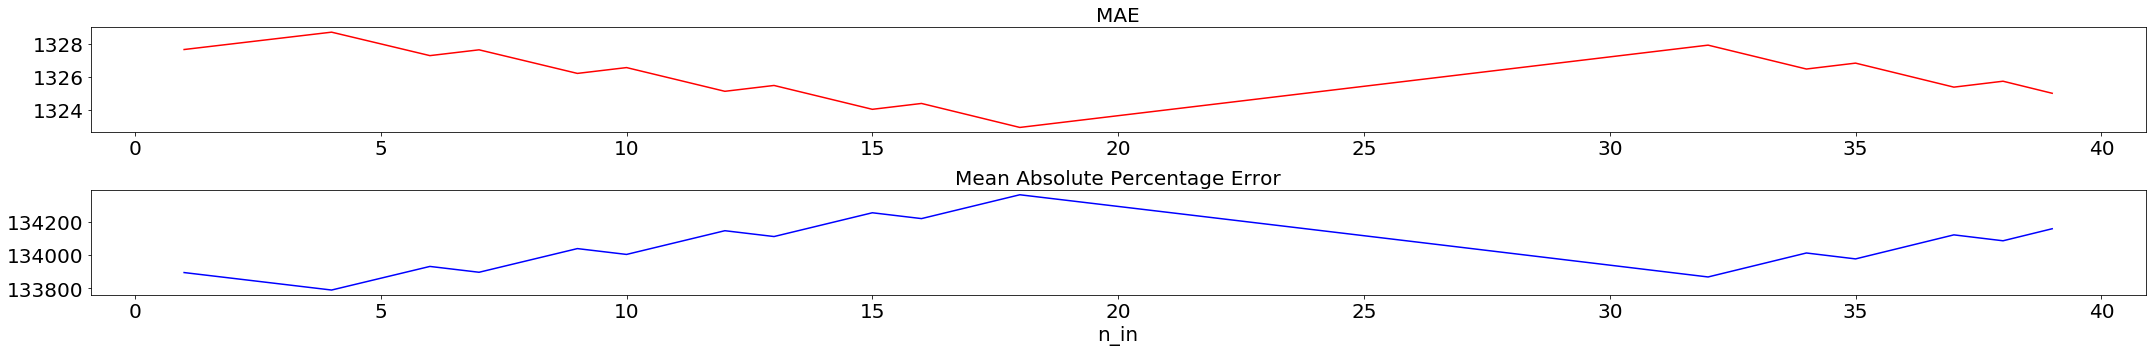

In [276]:
lag_range = range(1,40)

plt.subplot(211)
plt.plot(lag_range,np.array(error_MAE)*1000, 'r-')
plt.title('MAE', fontsize=20)

plt.xticks(fontsize=20); plt.yticks(fontsize=20)

plt.subplot(212)
plt.plot(lag_range,np.array(error_MAP)*1000, 'b-')
plt.title('Mean Absolute Percentage Error', fontsize=20)
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.xlabel('n_in', fontsize=20)

plt.tight_layout()

# Saving CSV for submission

In [148]:
# ########################### Export
# #################################################################################
# # Reading competition sample submission and
# # merging our predictions
# # As we have predictions only for "_validation" data
# # we need to do fillna() for "_evaluation" items
# submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
# submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
# submission.to_csv('submission_v'+str(VER)+'.csv', index=False)